## Market Research on Restaurants in Los Angeles 

<span style="color:blue">**Project description:**</span> We’ve decided to open a small robot-run cafe in Los Angeles (LA). The project is promising but expensive, so with our partners we decided to try to attract investors. They’re interested in the current market conditions—-will we be able to maintain our success when the novelty of robot waiters wears off? Our partners have asked us to prepare some market research. We have open-source data on restaurants in LA.

### Table of Contents

* [Step 1](#step1) Preprocessing of LA restaurant data 
    * [Step 1.1](#step1_1) General overview of the dataset   
    * [Step 1.2](#step1_2) Parsing restaurant names and addresses
        * [Step 1.2.1](#step1_2_1) Manual search of restaurant names
        * [Step 1.2.2](#step1_2_2) Regular expressions for restaurant names
        * [Step 1.2.3](#step1_2_3) Sequence matching for restaurant names 
        * [Step 1.2.4](#step1_2_4) Regular expressions for restaurant street names
    * [Step 1.3](#step1_3) Eliminating duplicates
* [Step 2](#step2) Analysis of restaurants in LA
    * [Step 2.1](#step2_1) Trends in establishments by types and by chain/non-chain property 
    * [Step 2.2](#step2_2) Trends in establishements by locations
* [Step 3](#step3) Presentation of the results and overall conclusions

<span style="color:blue">**Importing libraries:**</span> First, we import all code libraries and define helper functions that we will be using in our project.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display


In [2]:
# Define helper functions

# Define printmd() function to print code in blue color.
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

<a class="anchor" id="step1"></a> 
### Step 1. Preprocessing of LA restaurant data

We have been provided with the following dataset:
- `/datasets/rest_data_us.csv.`: the data on restaurants in LA

In this section, we will prepare the data for analysis in several steps. 

<a class="anchor" id="step1_1"></a> 
#### Step 1.1 General overview of the dataset 

In [3]:
# Read comma-separated values (csv) file into a pandas DataFrame object 
# using pandas.read_csv() method.
# Use try...except to make sure the project runs 
# both on local machine and platform.
try:    # paths on local machine.
    rest = pd.read_csv('rest_data_us.csv') 
except:    # paths on Practicum100 platform.
    rest = pd.read_csv('/datasets/rest_data_us.csv') 
    
# Assign names to the dataframe
rest.name = 'LA_restaurants'

# Print a concise summary of the dataFrames 
# with pandas.DataFrame.info() method.
printmd("{}".format(rest.name), color='blue')
rest.info()
display(rest.head(10))
display(rest.tail(10))



<span style='color:blue'>LA_restaurants</span>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
id             9651 non-null int64
object_name    9651 non-null object
address        9651 non-null object
chain          9648 non-null object
object_type    9651 non-null object
number         9651 non-null int64
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


id          object_name                          address  chain  \
0  11786  HABITAT COFFEE SHOP           3708 N EAGLE ROCK BLVD  False   
1  11787             REILLY'S              100 WORLD WAY # 120  False   
2  11788       STREET CHURROS        6801 HOLLYWOOD BLVD # 253  False   
3  11789    TRINITI ECHO PARK               1814 W SUNSET BLVD  False   
4  11790               POLLEN               2100 ECHO PARK AVE  False   
5  11791       THE SPOT GRILL              10004 NATIONAL BLVD  False   
6  11792                  CPK              100 WORLD WAY # 126  False   
7  11793             PHO LALA            3500 W 6TH ST STE 226  False   
8  11794           ABC DONUTS  3027 N SAN FERNANDO RD UNIT 103   True   
9  11795             UPSTAIRS             3707 N CAHUENGA BLVD  False   

  object_type  number  
0        Cafe      26  
1  Restaurant       9  
2   Fast Food      20  
3  Restaurant      22  
4  Restaurant      20  
5  Restaurant      14  
6  Restaurant     100  
7  Restaurant       7  
8   Fast Food       1  
9  Restaurant      35

id      object_name                         address  chain  \
9641  21427    OCEAN BASKETS              2851 CRENSHAW BLVD  False   
9642  21428           TOLOSA              2635 WHITTIER BLVD  False   
9643  21429      DIVINE DIPS            601 S LOS ANGELES ST  False   
9644  21430  LA BUFADORA BAR                   3470 E 1ST ST  False   
9645  21431       SAINT MARC  10250 SANTA MONICA BLVD # 1025  False   
9646  21432  HALL OF JUSTICE                217 W TEMPLE AVE  False   
9647  21433      FIN-MELROSE                5750 MELROSE AVE  False   
9648  21434      JUICY WINGZ             6741 HOLLYWOOD BLVD   True   
9649  21435  MEDIDATE COFFEE         548 S SPRING ST STE 100  False   
9650  21436     CAFE SPROUTS     1300 S SAN PEDRO ST STE 111   True   

     object_type  number  
9641  Restaurant      15  
9642  Restaurant      19  
9643  Restaurant      25  
9644         Bar      24  
9645  Restaurant     225  
9646  Restaurant     122  
9647  Restaurant      93  
9648   Fast Food      15  
9649        Cafe       6  
9650  Restaurant      19

We have a dataset with 9651 rows and 6 columns. Let us go through each column and point out potential problems. 

`id`: The column contains integer data. There are no null values. We expect this column to store the unique integer ids of the restaurants in LA. Let us check if this is the case.

In [4]:
print('Number of unique restaurant ids:', len(rest['id'].unique()))

Number of unique restaurant ids: 9651


Indeed, there are 9651 unique restaurant ids in this column. It seems that we do not need to preprocess data in this column.

`object_name`: This column stores the name of the restaurants as string objects. No null value appears. So, let us check how many uniques name we have.

In [5]:
print('Number of unique restaurant names:', len(rest['object_name'].unique()))
print('Number of restaurants serving under the same name:', 
      rest['object_name'].duplicated().sum())

Number of unique restaurant names: 8672
Number of restaurants serving under the same name: 979


Although we observed 9651 unique restaurant ids, we found out that only 8672 have different names. In fact, we expect some of the establishment, such as chains, to operate under the same name. We do not however have at this point enough information to argue about issues in the strings' content of this column. Maybe there are typos or differences in typing of conjunctions. We will preprocess the content of this column in detail later.

`address`: The adddress column stores the addresses of the restaurants, also as string objects. Let us count how many restaurants share the same address in raw data. 

In [6]:
print('Number of unique addresses for the restaurant locations:',
      len(rest['address'].unique()))
print('Number of restaurants sharing same addresses:', 
      rest['address'].duplicated().sum())


Number of unique addresses for the restaurant locations: 8517
Number of restaurants sharing same addresses: 1134


Let us also check if the same name restaurants are all located at different addresses. This will ensure that the data for the same restaurant was not entered to the database by mistake twice.

In [7]:
rest_name_dup = rest.loc[rest['object_name'].duplicated()]
#pd.options.display.max_rows = 9999

rest_name_grp = (rest.loc[rest['object_name'].isin(rest_name_dup['object_name'])]
                 .groupby('object_name'))
rest_name_grp_count = rest_name_grp.agg({'address':'count'})
rest_name_grp_unique = rest_name_grp.agg({'address':'nunique'})

print('Number of restaurants with different integer ids, but same name and same address:',
    (rest_name_grp_count != rest_name_grp_unique).sum()[0])                       


Number of restaurants with different integer ids, but same name and same address: 0


We have verified that establishments having the exact same name and address was not registered more than once with different ids. However, our analysis was rather limited, as there could by typos or mistakes in the strings storing the restaurant names or addresses. We will thus also explore in more detail and preprocess the content of this column later. 

`chain`: This column should indicate whether the restaurant is part of a chain or not. From the information printed earlier, we know that this column contains null values and that the data is stored as string objects. Let us check if the non-null values are only True/False values.

In [8]:
print('Unique values in the chain column:', rest['chain'].unique())


Unique values in the chain column: [False True nan]


As expected, we have True values indicating that the restaurant is part of a chain and False values indicating that it is not. Since a restaurant is either part of a chain or not, we conclude that the null values are missing data. Let us check the entries for the 3 rows with missing chain information.

In [9]:
print('The restaurant entries with missing chain information:')

display(rest.loc[rest['chain'].isnull()])

The restaurant entries with missing chain information:


id              object_name               address chain object_type  \
7408  19194  TAQUERIA LOS 3 CARNALES  5000 E WHITTIER BLVD   NaN  Restaurant   
7523  19309     JAMMIN JIMMY'S PIZZA   1641 FIRESTONE BLVD   NaN       Pizza   
8648  20434    THE LEXINGTON THEATER          129 E 3RD ST   NaN  Restaurant   

      number  
7408      14  
7523       1  
8648      35

Let us check if we have other restaurants with the above names. If so, we might be able to use their data to fill our missing values.

In [10]:
rest.loc[rest['object_name'].isin(rest.loc[rest['chain'].isnull(), 'object_name'])]

id              object_name               address chain object_type  \
7408  19194  TAQUERIA LOS 3 CARNALES  5000 E WHITTIER BLVD   NaN  Restaurant   
7523  19309     JAMMIN JIMMY'S PIZZA   1641 FIRESTONE BLVD   NaN       Pizza   
8648  20434    THE LEXINGTON THEATER          129 E 3RD ST   NaN  Restaurant   

      number  
7408      14  
7523       1  
8648      35

We did not find any other restaurants with the same name in our dataset. Since only 3 restaurants have missing chain values, we could simply drop them from our dataset. Alternatively we can check the internet to see if we can find the information. Here we opt for the first option, as we do not know how the data was collected originally and what criterion have been used to classify an establishement as chain. After dropping the null values, we convert the column's data type to Boolean. 

In [11]:
rest = rest.drop(index=[7408, 7523, 8648])
rest['chain'] = rest['chain'].astype('bool')
rest.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9648 entries, 0 to 9650
Data columns (total 6 columns):
id             9648 non-null int64
object_name    9648 non-null object
address        9648 non-null object
chain          9648 non-null bool
object_type    9648 non-null object
number         9648 non-null int64
dtypes: bool(1), int64(2), object(3)
memory usage: 461.7+ KB


It is possible that there are errors in the categorization of the establishments into chains. We will check if the content of this column is consistent for all branches of given chains after we clean the  <code>object_name</code> and <code>address</code> columns.

`object_type`: This column should contain categorical data defining the type of the restaurant. There aren't any null values, but the information is stored as string objects. This may not be optimal for memory usage. Let us see how many different types of establishments we have.

In [12]:
print('Types of restaurants:', rest['object_type'].unique())


Types of restaurants: ['Cafe' 'Restaurant' 'Fast Food' 'Bakery' 'Bar' 'Pizza']


We found out that there are only 6 types of restaurants. It thus make sense to optimize memory space by converting the data to Category type.

In [13]:
rest['object_type'] = rest['object_type'].astype("category")
rest.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9648 entries, 0 to 9650
Data columns (total 6 columns):
id             9648 non-null int64
object_name    9648 non-null object
address        9648 non-null object
chain          9648 non-null bool
object_type    9648 non-null category
number         9648 non-null int64
dtypes: bool(1), category(1), int64(2), object(2)
memory usage: 395.9+ KB


Note that it is possible that there are errors in the categorization of the types of the establishments operating under the same brand. We will check if the content of this column is consitent for all branches of such establishemnts after we clean the  <code>object_name</code> and <code>address</code> columns.

Before proceeding with the last column, let us check the distribution of chains for the different types of establishments. 

In [14]:
display(rest.groupby(by=['object_type'])['chain'].sum())
display(rest.groupby(by=['object_type'])['chain'].count())

object_type
Bakery         283.0
Bar             77.0
Cafe           266.0
Fast Food      605.0
Pizza          153.0
Restaurant    2292.0
Name: chain, dtype: float64

object_type
Bakery         283
Bar            292
Cafe           435
Fast Food     1066
Pizza          319
Restaurant    7253
Name: chain, dtype: int64

We found out that all the bakeries in our dataset were labeled as chains. This is suspicious. Since the bakeries correspond to less than 3% of our data and we believe that a robot run bakery has much less potential than the other types of establishments, we suggest to drop this category from our dataset. 

In [15]:
cond_bakery = rest.loc[rest['object_type'] == 'Bakery'].index
rest.drop(cond_bakery, inplace=True)


`number`: We expect this column to indicate the number of seats the restaurants have. The data is of type integer, as it should be, and there aren't any null value. Let us check the summary statistics to see if the numbers populating this column are rather reasonable.

In [16]:
rest['number'].describe()


count    9365.000000
mean       44.366257
std        47.979778
min         1.000000
25%        14.000000
50%        27.000000
75%        46.000000
max       229.000000
Name: number, dtype: float64

We found out that the restaurants can have any number of seats from 1 to 229. The latter is quite large, but still plausible. Imaging a hotel's restaurant, or a large restaurant where people have their weddings. On the other hand, the average number of seats of the restaurants in LA is close to 44 seats. Yet, the average restauranthas 27 seats as indicated by the median value. So, the very large capacity restaurants are pulling up the average number of seats per restaurants. The minimum number of 1 seat is also suspicious, but we cannot know at this point if those are erroneous entries or not. 

**Duplicates:** We end the preliminary analysis by checking duplicates in raw data. 

In [17]:
print('The number of duplicated columns in raw data equals:', rest.duplicated().sum())

The number of duplicated columns in raw data equals: 0


We did not find any duplicates in raw data. We should however check for duplicates again at the end of the data preprocessing stage.

In this preliminary investigation, we managed to eliminate the null values from our dataset and optimize the data types. We also removed establishments that were labels as bakeries. Next, we dive into parsing the establishment names in the <code>object_name</code> column and their addresses in the <code>address</code> column.

<a class="anchor" id="step1_2"></a> 
#### Parsing restaurant names and addresses 

We have first carried out an extensive analysis by manually searching US chain restaurant names in our dataset. Our findings indicate that our dataset is not ready for analysis for the following reasons:
- We noticed that there were differences or errors in the typographie of restaurant names. For instance the conjuction *"AND"* was also expressed with "N", "'N", or "&". The aposthrope to express the genitive in  "'S" was not always correctly rendered. Or, it was omitted or the "S" was merged to the word in front. The plural '"S"' did also sometimes miss for some of the restaurants .
- Some chain restaurants had numbers added at the end as "# 12233", which would make it difficult to group under the same name. 
- Similarly, some restuarants had the endings "INC" or "LLC" (with a comma before)
- Some restuarant names containing numbers in them were sometimes types with numeric letters and sometimes types with alphabetic letters. I.e., "32" or "THIRTHY TWO".
- Perhaps the analysis could be simplified by first unifying the differences in typography. However, we also noticed that the chain, object type, and address columns contained many errors. For example, the same restaurant (whose name might have been typed differently) might have appeared twice with the same address (typed differently or with a missing number etc.). Or, an establishement was sometime indicated as a restaurant and sometimes as a fast food place. Similarly, the chain column had errors.
- For this project, we only need the street names and not the full addresses of the establishements. We noticed that most detailed addresses start with the building number, followed by directional information such as *"N"* or *"W"*, followed by the street name, followed its type such as *"AVE"*, *"BLVD"*, followed by the appartment number (sometimes starting with a hashtag or letter). We did not spot an example where the zip code, city name, and country name were indicated. However, we spotted several cases where some of the elements in the above described format were not present. 

For the above cited reasons, we will rebuild our dataset correcting as much as possible issues in establishemnt names. We will rely on a mixture of manual correction, regular expressions, and sequence matching. Then, we will extract the street names from the adresses using regular expressions. Finally, we will remove duplicates and check consistency in the <code>chain</code> and <code>object_type</code> columns.

<a class="anchor" id="step1_2_1"></a> 
#### Manual search of restaurant names

We looked up from the web chain restaurant names in the US and searched them in our dataset. We did an extensive search, even sometimes checking the establishments names and addresses, however here we only present the resulting preprocessing to facilitate the review process.

Recall that we have in total data for 9651 establishements. Let us check how many rows are currently indicated as being part of some chains.

In [18]:
print('The number of rows indicating the establishement is part of a chain is:',
      (rest['chain'] == True).sum())

The number of rows indicating the establishement is part of a chain is: 3393


Naturally, there could be errors in the assignments of the <code>chain</code> column. In the following, we directly set the value of the column to <code>True</code> for the chain establishment we will manually search (and for which we know to be a chain)..


While going through the dataset, we have noticed that some establishments are part of co-branded chains (The corresponding rows contained the slash character '/'). We believe that these cases are rather special and at this stage irrelevant to our analysis. Therefore, we will drop these cases from our dataset. 

In [19]:
# Separately store the co-branding cases and drop them from the rest data.
co_brand_df = rest.loc[rest['object_name'].str.contains('/')].copy()
rest.drop(index=co_brand_df.index, inplace=True)
print('The co-branded establishements we have identified:')

co_brand_temp = rest.loc[(rest['object_name'].str.contains('KFC') 
          & rest['object_name'].str.contains('TACO'))].copy()
rest.drop(index=co_brand_temp.index, inplace=True)
co_brand_df = pd.concat([co_brand_df, co_brand_temp])

display(co_brand_df)


The co-branded establishements we have identified:


id                                        object_name  \
84    11870                         KOREAN AIR/ SKYTEAM LOUNGE   
137   11923  ASHLAND BAR EARTH BAR / PANDA EXPRESS ASHLAND ...   
432   12218                       W HOTEL LOS ANGELES/WESTWOOD   
463   12249                        MAMA SHELTER RESTAURANT/BAR   
546   12332                  SPRING FOR COFFEE/ SESTAN JUICERY   
...     ...                                                ...   
8993  20779                       GAMEZ SPORTS BAR/ONYX LOUNGE   
9336  21122             JOHNNIE'S NEW YORK PIZZARIA /SERALIGHT   
9432  21218                               TOTOYAMA SUSHI/RAMEN   
2428  14214                              KFC TACO BELL E791008   
3174  14960                              KFC TACO BELL E791001   

                         address  chain object_type  number  
84              380 WORLD WAY S4  False  Restaurant     219  
137          300 WORLD WAY # 329   True   Fast Food      25  
432              930 HILGARD AVE  False  Restaurant      49  
463               6500 SELMA AVE   True         Bar     158  
546              530 S GRAND AVE   True        Cafe      13  
...                          ...    ...         ...     ...  
8993             500 S SPRING ST  False         Bar      44  
9336  5757 WILSHIRE BLVD STE 102   True       Pizza      67  
9432   6201 HOLLYWOOD BLVD # 118  False  Restaurant      36  
2428           8500 LINCOLN BLVD   True   Fast Food      40  
3174        5220 W CENTINELA AVE   True   Fast Food      36  

[65 rows x 6 columns]

Below we define a function to help us process the establishment names. We also create two separate copies of our data to make search more efficient.

In [20]:
rest_cleaned = rest.copy()
rest_searched = rest.copy()

def clean_chain_name(search_name, assign_name):
    
    found_idx = rest_searched.loc[rest_searched['object_name'].str.contains(search_name) == True].index
    rest_cleaned.loc[found_idx, 'object_name'] = assign_name
    
    print('Number of entries for the chain:', len(found_idx))
    display(rest_searched.loc[found_idx])

    rest_searched.drop(index=found_idx, inplace=True)
    
    return len(found_idx)


For convenience, we have collected the string pairs that we will input to the <code>clean_chain_name()</code> function into a list. Note that any pair in the list have been checked separetely before being added to the list (and alternative keywords have been tried). The first element is the string searched in the <code>object_name</code> column via the <code>str.contains()</code> method. The second one is the new <code>object_name</code> assigned when the first string has been found in a given row of the dataset. 

In [21]:
# create a list of lists to input 
# into the clean_chain_name() function
chain_list_1 = [["SUBWAY", "SUBWAY"],
              ["STARBUCK", "STARBUCKS"],
              ["DONALD", "MCDONALD'S"],
              ["DUNKIN", "DUNKIN' DONUTS"],
              ["PIZZA HUT", "PIZZA HUT"],
              ["SOUTHERN CALIFORNIA PIZZA CO LLC", "PIZZA HUT"],
              ["BURGER KING", "BURGER KING"],
              ["KFC", "KENTUCKY FRIED CHICKEN"],
              ["KENTUCKY FRIED CHICKEN", "KENTUCKY FRIED CHICKEN"],
              ["TACO BELL", "TACO BELL"],
              ["DOMINO", "DOMINO'S PIZZA"],
              ["CHIPOTLE", "CHIPOTLE MEXICAN GRILL"],
              ["CAESAR", "LITTLE CEASARS"],
              ["JACK IN THE BOX", "JACK IN THE BOX"],
              ["PANDA EXPRESS", "PANDA EXPRESS"],
              ["POPEYES", "POPEYES"],
              ["CHICK-FIL-A", "CHICK-FIL-A"],
              ["PAPA JOHN", "PAPA JOHN'S PIZZA"],
              ["JIMMY JOHN", "JIMMY JOHN'S"],
              ["CARL'S JR", "CARL'S JR."],
              ["CARLS JR", "CARL'S JR."],
              ["WINGSTOP", "WINGSTOP"],
              ["JERSEY MIKE", "JERSEY MIKE'S SUBS"],
              ["IN-N-OUT BURGER", "IN-N-OUT BURGER"],
              ["EL POLLO LOCO", "EL POLLO LOCO"],
              ["EL POLO LOCO", "EL POLLO LOCO"],
              ["CHURCH'S FRIED CHICKEN", "CHURCH'S FRIED CHICKEN"],
              ["DEL TACO", "DEL TACO"],
              ["BASKIN ROBBINS", "BASKIN-ROBBINS"],
              ["FIVE GUYS", "FIVE GUYS BURGERS & FRIES"],
              ["AUNTIE ANNE", "AUNTIE ANNE'S"],
              ["LEMONADE", "LEMONADE"],
              ["WETZEL", "WETZEL'S PRETZELS"],
              ["WHICH", "WHICH WICH SUPERIOR SANDWICHES"],
              ["BOBA TIME", "IT'S BOBA TIME"],
              ["BOBA - LOCA TEA COFFEE", "IT'S BOBA TIME"],
              ["YUM YUM DONUT", "YUM-YUM DONUTS"],
              ["WINCH", "WINCHELL'S DONUTS"],
              ["COFFEE BEAN", "THE COFFEE BEAN & TEA LEAF"],
              ["JAMBA", "JAMBA"],
              ["PEET", "PEET'S COFFEE"],
              ["ROBEK", "ROBEKS"],
              ["LOUISIANA FRIED CHICKEN", "LOUISIANA FAMOUS FRIED CHICKEN"],
              ["KRISPY KRUNCHY CHICKEN", "KRISPY KRUNCHY CHICKEN"],
              ["PINKBERRY", "PINKBERRY"],
              ["TUTTI FRUTTI", "TUTTI FRUTTI FROZEN YOGURT"],
              ["YOGURTLAND", "YOGURTLAND"],
              ["YOGURT LAND", "YOGURTLAND"],
              ["UMAMI", "UMAMI BURGER"],
              ["BAJA FRESH", "BAJA FRESH MEXICAN GRILL"],
              ["WABA", "WABA GRILL"],
              ["FARMS", "MENDOCINO FARMS"],
              ["SUGARFISH", "SUGARFISH BY SUSHI NOZAWA"],
              ["TOFU HOUSE", "BCD TOFU HOUSE"],
              ["WENDY", "WENDY'S"],
              ["QDOBA", "QDOBA MEXICAN EATS"],
              ["PANERA", "PANERA BREAD"],
              ["ARBY", "ARBY'S"],
              ["BELWOOD BAKERY", "BELWOOD BAKERY"],
              ["KING TACO", "KING TACO"],
              ["BODYFACTORY", "BODYFACTORY"],
              ["EARTHBAR", "EARTHBAR"],
              ["EARTH BAR", "EARTHBAR"],
              ["EQUINOX", "EARTHBAR"],
              ["FARMER BOY", "FARMER BOYS"],
              ["ZANKOU CHICKEN", "ZANKOU CHICKEN"],
              ["FAT BURGER", "FATBURGER"],
              ["FATBURGER", "FATBURGER"],
              ["HABIT BURGER", "THE HABIT BURGER GRILL"],
              ["HOT DOG ON A STICK", "HOT DOG ON A STICK"],
              ["HARD ROCK", "HARD ROCK CAFE"],
              ["IHOP", "IHOP"],
              ["HOUSE OF PANCAKE", "IHOP"],
              ["SHAKEY'S PIZZA PARLOR", "SHAKEY'S PIZZA PARLOR"],
              ["SHAKEYS PIZZA PARLOR", "SHAKEYS PIZZA PARLOR"],
              ["LUCILLE'S SMOKEHOUSE BARBQUE", "LUCILLE'S SMOKEHOUSE BARBQUE"],
              ["TRIMANA", "TRIMANA"],
              ["DENNY", "DENNY'S"],
              ["KRISPY KREME DOUGHNUTS", "KRISPY KREME DOUGHNUTS"],
              ["EINSTEIN", "EINSTEIN BROS. BAGELS"],
              ["GROUND WORK", "GROUNDWORK COFFEE"],
              ["GROUNDWORK", "GROUNDWORK COFFEE"],
              ["SHAKE SHACK", "SHAKE SHACK"],
              ["CHUCK", "CHUCK E. CHEESE"],
              ["COLDSTONE CREAMERY", "COLD STONE CREAMERY"],
              ["COLD STONE CREAMERY", "COLD STONE CREAMERY"],
              ["CORNER BAKERY", "CORNER BAKERY CAFE"],
              ["DAVE & BUSTER", "DAVE & BUSTER'S"],
              ["SALT & STRAW", "SALT & STRAW"],
              ["PAIN QUOTIDIEN", "LE PAIN QUOTIDIEN"],
              ["AU BON PAIN", "AU BON PAIN CAFE BAKERY"],
              ["WEINERSCHNITZEL", "WEINERSCHNITZEL"],
              ["RALLY'S", "RALLY'S HAMBURGERS"],
              ["SIZZLER", "SIZZLER USA RESTAURANTS"],
              ["MORTON", "MORTON'S THE STEAKHOUSE"],
              ["SBARRO", "SBARRO"],
              ["SUPERIOR SUPER WAREHOUSE", "SUPERIOR GROCERS"],
              ["SUPERIOR GROCERS", "SUPERIOR GROCERS"],
              ["SUPERIOR WAREHOUSE", "SUPERIOR GROCERS"],
              ["SWEETFIN POKE", "SWEETFIN POKE"],
              ["KELLY'S COFFEE", "KELLY'S COFFEE & FUDGE FACTORY"],
              ["NOAH", "NOAH'S NEW YORK BAGELS"],
              ["WAYBACK BURGER'S", "WAYBACK BURGER'S"],
              ["PRONTO PIZZA", "PRONTO PIZZA"],
              ["POLLO CAMPERO", "POLLO CAMPERO"],
              ["QUIZNO", "QUIZNOS"],
              ["ONO HAWAIIAN BBQ", "ONO HAWAIIAN BBQ"],
              ["L&L HAWAIIAN BBQ", "L&L HAWAIIAN BBQ"]]


We now call the function by iterating over the elements of the above list. A counter is set to keep track of the total number of rows preprocessed after each iteration. 

In [22]:
counter = 0

for e in chain_list_1:
    print(e)
    print('Searching for:', e[1])

    counter += clean_chain_name(e[0],e[1])
    print('Processed total rows:', counter)


['SUBWAY', 'SUBWAY']
Searching for: SUBWAY
Number of entries for the chain: 152


id    object_name                      address  chain object_type  \
40    11826  SUBWAY -52105      255 S GRAND AVE STE 101   True   Fast Food   
82    11868  SUBWAY #39685                 704 W 1ST ST   True   Fast Food   
118   11904  SUBWAY #14183                 508 W 7TH ST   True   Fast Food   
162   11948  SUBWAY #12484  5339 W CENTINELA AVE STE #A   True   Fast Food   
182   11968   SUBWAY #1763   3959 WILSHIRE BLVD STE B-7   True   Fast Food   
...     ...            ...                          ...    ...         ...   
8739  20525         SUBWAY       11762 SAN VICENTE BLVD   True   Fast Food   
8744  20530  SUBWAY #24017     1821 E CESAR E CHAVEZ ST   True   Fast Food   
8774  20560  SUBWAY #39254      4770 E CESAR CHAVEZ AVE   True   Fast Food   
8794  20580  SUBWAY #25803         5536 E WHITTIER BLVD   True   Fast Food   
8966  20752   SUBWAY #5822           3974 S FIGUEROA ST   True   Fast Food   

      number  
40        37  
82         3  
118        4  
162       24  
182       17  
...      ...  
8739      23  
8744      18  
8774      21  
8794      20  
8966      21  

[152 rows x 6 columns]

Processed total rows: 152
['STARBUCK', 'STARBUCKS']
Searching for: STARBUCKS
Number of entries for the chain: 131


id              object_name                  address  chain  \
495   12281   STARBUCKS COFFEE #6688       1601 WILSHIRE BLVD   True   
697   12483  STARBUCKS COFFEE #11991   3242 W CAHUENGA BLVD W   True   
752   12538    STARBUCKS COFFEE #624         7624 MELROSE AVE   True   
938   12724                STARBUCKS        1401 S ALAMEDA ST   True   
964   12750  STARBUCKS COFFEE #10940       3111 GLENDALE BLVD   True   
...     ...                      ...                      ...    ...   
9281  21067   STARBUCKS COFFEE #5488       5020 WILSHIRE BLVD   True   
9285  21071          STARBUCKS-17413  3584 S FIGUEROA ST # #3   True   
9314  21100   STARBUCKS COFFEE #9225       330 S HOPE ST # 26   True   
9384  21170         STARBUCKS #51056            1106 CORNWELL   True   
9573  21359                STARBUCKS         1249 S GRAND AVE   True   

     object_type  number  
495         Cafe      37  
697         Cafe      11  
752         Cafe      45  
938         Cafe      18  
964         Cafe       3  
...          ...     ...  
9281        Cafe      27  
9285        Cafe      31  
9314        Cafe       6  
9384        Cafe      31  
9573        Cafe       7  

[131 rows x 6 columns]

Processed total rows: 283
['DONALD', "MCDONALD'S"]
Searching for: MCDONALD'S
Number of entries for the chain: 85


id         object_name                            address  chain  \
71    11857    MCDONALD'S #2084             3124 N SAN FERNANDO RD   True   
103   11889  MCDONALD'S # 10129                      245 N SOTO ST   True   
366   12152  MCDONALD'S # 18368                   690 S ALAMEDA ST   True   
391   12177    MCDONALD'S #6688              201 W WASHINGTON BLVD   True   
444   12230    MCDONALD'S #1135                 1800 S WESTERN AVE   True   
...     ...                 ...                                ...    ...   
9236  21022  MCDONALD���S #1126  1081 W MARTIN LUTHER KING JR BLVD   True   
9330  21116          MCDONALD'S                 1900 W SLAUSON AVE   True   
9436  21222          MCDONALD'S  2215 W MARTIN LUTHER KING JR BLVD   True   
9489  21275          MCDONALD'S                 7123 CRENSHAW BLVD   True   
9639  21425          MCDONALD'S                 1800 S WESTERN AVE   True   

     object_type  number  
71     Fast Food     112  
103    Fast Food      88  
366   Restaurant      35  
391    Fast Food     196  
444   Restaurant     139  
...          ...     ...  
9236  Restaurant      67  
9330   Fast Food     100  
9436   Fast Food      46  
9489   Fast Food     146  
9639   Fast Food     135  

[85 rows x 6 columns]

Processed total rows: 368
['DUNKIN', "DUNKIN' DONUTS"]
Searching for: DUNKIN' DONUTS
Number of entries for the chain: 7


id     object_name                 address  chain object_type  number
2494  14280   DUNKIN DONUTS        2300 VENICE BLVD   True   Fast Food       3
2898  14684  DUNKIN' DONUTS  3100 GLENDALE BLVD # A   True   Fast Food       8
3581  15367  DUNKIN' DONUTS     6201 HOLLYWOOD BLVD   True   Fast Food      19
3602  15388   DUNKIN DOUNTS          754 S OLIVE ST  False  Restaurant      29
3660  15446   DUNKIN DONUTS      1614 CRENSHAW BLVD   True   Fast Food      28
4742  16528  DUNKIN' DONUTS    400 WORLD WAY # GT45   True   Fast Food      18
9359  21145  DUNKIN' DONUTS    700 WORLD WAY # 1104   True   Fast Food      21

Processed total rows: 375
['PIZZA HUT', 'PIZZA HUT']
Searching for: PIZZA HUT
Number of entries for the chain: 30


id        object_name                       address  chain  \
140   11926   PIZZA HUT #26158             4356 LEIMERT BLVD   True   
185   11971   PIZZA HUT #26178   3959 WILSHIRE BLVD STE B-11   True   
323   12109   PIZZA HUT #25408    611 E IMPERIAL HWY STE 104   True   
990   12776   PIZZA HUT #26154            5101 W VENICE BLVD   True   
1215  13001   PIZZA HUT #26159           1001 W CENTURY BLVD   True   
1228  13014   PIZZA HUT #26162               1014 W MLK BLVD   True   
1436  13222   PIZZA HUT #26160                 3400 E 1ST ST   True   
2033  13819   PIZZA HUT #26218            2930 COLORADO BLVD   True   
2280  14066   PIZZA HUT #26143            1555 S WESTERN AVE   True   
2522  14308   PIZZA HUT #28345              11146 PALMS BLVD   True   
2738  14524   PIZZA HUT #26209   4629 SANTA MONICA BLVD # 52   True   
3453  15239   PIZZA HUT #26177              8947 W PICO BLVD   True   
3506  15292   PIZZA HUT #26183                6312 W 89TH ST   True   
3601  15387   PIZZA HUT #27613             4207 BEVERLY BLVD   True   
3782  15568   PIZZA HUT #26205          5130 HUNTINGTON DR S   True   
3945  15731   PIZZA HUT #26200            4329 N FIGUEROA ST   True   
4256  16042   PIZZA HUT #26228            6660 W SUNSET BLVD   True   
4492  16278   PIZZA HUT #26180              1562 W PICO BLVD   True   
4634  16420   PIZZA HUT #26198                5839 YORK BLVD   True   
5009  16795  PIZZA HUT #026176       12217 SANTA MONICA BLVD   True   
5374  17160   PIZZA HUT #26152            1851 W SLAUSON AVE   True   
5712  17498   PIZZA HUT #26163     4209 E CESAR E CHAVEZ AVE   True   
5744  17530   PIZZA HUT #26166            4351 S CENTRAL AVE   True   
6058  17844   PIZZA HUT #26149   718 S LOS ANGELES ST STE #C   True   
6583  18369   PIZZA HUT #26199             2724 HYPERION AVE   True   
6771  18557   PIZZA HUT #24951  1457 E FLORENCE AVE STE #109   True   
6993  18779   PIZZA HUT #28168        1780 S LA CIENEGA BLVD   True   
7101  18887          PIZZA HUT            2405 S VERMONT AVE   True   
8020  19806   PIZZA HUT #26179              2542 W TEMPLE ST   True   
8417  20203   PIZZA HUT #26165            7229 S FIGUEROA ST   True   

     object_type  number  
140        Pizza      16  
185        Pizza       7  
323        Pizza      15  
990        Pizza      19  
1215       Pizza      24  
1228       Pizza      15  
1436       Pizza      14  
2033       Pizza       5  
2280       Pizza      41  
2522       Pizza       6  
2738       Pizza      18  
3453       Pizza      11  
3506       Pizza      12  
3601       Pizza       3  
3782       Pizza       6  
3945       Pizza       4  
4256       Pizza      14  
4492       Pizza      20  
4634       Pizza      10  
5009       Pizza       6  
5374       Pizza       5  
5712       Pizza      19  
5744       Pizza      24  
6058       Pizza       6  
6583       Pizza      12  
6771       Pizza      27  
6993       Pizza      14  
7101       Pizza      22  
8020       Pizza      17  
8417       Pizza      27

Processed total rows: 405
['SOUTHERN CALIFORNIA PIZZA CO LLC', 'PIZZA HUT']
Searching for: PIZZA HUT
Number of entries for the chain: 2


id                       object_name                 address  chain  \
704   12490  SOUTHERN CALIFORNIA PIZZA CO LLC    5213 E WHITTIER BLVD  False   
4613  16399  SOUTHERN CALIFORNIA PIZZA CO LLC  11710 S WILMINGTON AVE   True   

     object_type  number  
704        Pizza      26  
4613       Pizza      16

Processed total rows: 407
['BURGER KING', 'BURGER KING']
Searching for: BURGER KING
Number of entries for the chain: 38


id          object_name                            address  chain  \
324   12110   BURGER KING # 1417                12736 S AVALON BLVD   True   
1945  13731  BURGER KING # 10734                      1830 W 8TH ST   True   
2504  14290   BURGER KING #11406                     6155 YORK BLVD   True   
2817  14603    BURGER KING #5180             3101 N SAN FERNANDO RD   True   
2927  14713     BURGER KING #903              5656 W MANCHESTER AVE   True   
3064  14850   BURGER KING # 5567                    1673 E 103RD ST   True   
3227  15013   BURGER KING #11024           5609 W SUNSET BLVD STE C   True   
3563  15349    BURGER KING #6202                2051 E FLORENCE AVE   True   
3745  15531    BURGER KING #5892               3501 E WHITTIER BLVD   True   
3802  15588    BURGER KING #4107  1662 MARTIN LUTHER KING JR BLVD W   True   
3834  15620   BURGER KING #11422                  833 S CENTRAL AVE   True   
3951  15737    BURGER KING #5853                 1301 GLENDALE BLVD   True   
4284  16070  BURGER KING # 11053                 3241 N FIGUEROA ST   True   
4295  16081    BURGER KING #2223               5228 W CENTINELA AVE   True   
4372  16158    BURGER KING #9717                535 S ATLANTIC BLVD   True   
4545  16331   BURGER KING # 4946                2511 S SAN PEDRO ST   True   
4557  16343   BURGER KING # 6107               4959 EAGLE ROCK BLVD   True   
4777  16563    BURGER KING #5596                 7079 W SUNSET BLVD   True   
4789  16575   BURGER KING # 5658               5850 S CRENSHAW BLVD   True   
5109  16895    BURGER KING 13511                 4410 S FIGUEROA ST   True   
5345  17131     BURGER KING #919              3520 S SEPULVEDA BLVD   True   
5507  17293    BURGER KING #6581                 1845 S VERMONT AVE   True   
5611  17397          BURGER KING                      300 WORLD WAY   True   
5693  17479   BURGER KING # 1630                 3036 CRENSHAW BLVD   True   
5755  17541  BURGER KING # 10724                 1106 N CORNWELL ST   True   
5985  17771    BURGER KING #2547                 1011 N WESTERN AVE   True   
6139  17925   BURGER KING #12576                 1540 N EASTERN AVE   True   
6416  18202    BURGER KING 11299           700 W CESAR E CHAVEZ AVE   True   
6929  18715  BURGER KING # 13331                1202 FIRESTONE BLVD   True   
7492  19278   BURGER KING # 9218             1742 S LA CIENEGA BLVD   True   
8000  19786    BURGER KING #9945                 1250 S LA BREA AVE   True   
8068  19854  BURGER KING # 11658                      2025 W 3RD ST   True   
8217  20003  BURGER KING # 11490                 4918 W SUNSET BLVD   True   
8432  20218     BURGER KING 2554                  181 S VERMONT AVE   True   
8464  20250   BURGER KING #12312                 304 W CENTURY BLVD   True   
8480  20266    BURGER KING #1346              1453 W MANCHESTER AVE   True   
8592  20378   BURGER KING #06023                7201 S FIGUEROA AVE   True   
8643  20429    BURGER KING #6941                  9601 AIRPORT BLVD   True   

     object_type  number  
324    Fast Food      41  
1945   Fast Food      28  
2504   Fast Food      67  
2817   Fast Food     137  
2927   Fast Food      47  
3064   Fast Food     137  
3227   Fast Food      40  
3563   Fast Food     109  
3745   Fast Food      89  
3802   Fast Food      48  
3834   Fast Food     124  
3951   Fast Food      49  
4284   Fast Food      42  
4295   Fast Food     142  
4372   Fast Food      67  
4545   Fast Food      64  
4557   Fast Food      86  
4777   Fast Food      63  
4789   Fast Food     125  
5109   Fast Food      48  
5345   Fast Food      77  
5507   Fast Food     118  
5611   Fast Food      92  
5693   Fast Food     140  
5755   Fast Food     103  
5985   Fast Food      87  
6139   Fast Food      31  
6416   Fast Food     105  
6929   Fast Food      46  
7492   Fast Food      84  
8000   Fast Food     149  
8068   Fast Food      43  
8217   Fast Food     118  
8432   Fast Food     144  
8464   Fast Food     

Processed total rows: 445
['KFC', 'KENTUCKY FRIED CHICKEN']
Searching for: KENTUCKY FRIED CHICKEN
Number of entries for the chain: 11


id   object_name                  address  chain object_type  number
2402  14188           KFC        340 N WESTERN AVE   True   Fast Food      66
2649  14435           KFC     11864 WILMINGTON AVE   True   Fast Food      19
3781  15567           KFC       5720 S VERMONT AVE   True   Fast Food       6
4144  15930      KFC #126     5811 E WHITTIER BLVD   True   Fast Food      48
4307  16093           KFC  126 S VERMONT AVE # 112   True   Fast Food      37
5826  17612           KFC      2801 W OLYMPIC BLVD   True   Fast Food     101
6262  18048           KFC            5130 RODEO RD   True   Fast Food      49
6909  18695           KFC        380 WORLD WAY T33   True   Fast Food      34
7038  18824           KFC     4903 EAGLE ROCK BLVD   True   Fast Food      37
9054  20840           KFC       2807 S FIGUEROA ST   True   Fast Food      34
9464  21250  KFC BROADWAY          2801 N BROADWAY   True   Fast Food      28

Processed total rows: 456
['KENTUCKY FRIED CHICKEN', 'KENTUCKY FRIED CHICKEN']
Searching for: KENTUCKY FRIED CHICKEN
Number of entries for the chain: 17


id                  object_name                       address  chain  \
311   12097       KENTUCKY FRIED CHICKEN                 320 N SOTO ST   True   
727   12513       KENTUCKY FRIED CHICKEN                708 S BROADWAY   True   
895   12681       KENTUCKY FRIED CHICKEN                 5925 W 3RD ST   True   
2943  14729       KENTUCKY FRIED CHICKEN             10501 W PICO BLVD   True   
3549  15335   KENTUCKY FRIED CHICKEN T32                 380 WORLD WAY   True   
3691  15477  KENTUCKY FRIED CHICKEN #119            3061 SAWTELLE BLVD   True   
3957  15743       KENTUCKY FRIED CHICKEN            1400 GLENDALE BLVD   True   
5287  17073       KENTUCKY FRIED CHICKEN               624 S LORENA ST   True   
5451  17237       KENTUCKY FRIED CHICKEN               2801 N BROADWAY   True   
5809  17595       KENTUCKY FRIED CHICKEN            1244 S LA BREA AVE   True   
5976  17762  KENTUCKY FRIED CHICKEN #111        1550 S LA CIENEGA BLVD   True   
6417  18203       KENTUCKY FRIED CHICKEN           11900 WILSHIRE BLVD   True   
7140  18926       KENTUCKY FRIED CHICKEN         1789 W JEFFERSON BLVD   True   
7328  19114       KENTUCKY FRIED CHICKEN  1425 MARTIN LUTHER KING BLVD   True   
7519  19305       KENTUCKY FRIED CHICKEN         1148 W MANCHESTER AVE   True   
7956  19742       KENTUCKY FRIED CHICKEN                 1501 W 6TH ST   True   
8034  19820       KENTUCKY FRIED CHICKEN            8515 S CENTRAL AVE   True   

     object_type  number  
311    Fast Food      25  
727    Fast Food     104  
895    Fast Food      20  
2943   Fast Food      37  
3549   Fast Food      44  
3691   Fast Food     121  
3957   Fast Food      39  
5287   Fast Food      28  
5451   Fast Food      27  
5809   Fast Food      39  
5976   Fast Food      26  
6417   Fast Food       5  
7140   Fast Food      48  
7328   Fast Food       2  
7519   Fast Food      35  
7956   Fast Food       9  
8034   Fast Food      49

Processed total rows: 473
['TACO BELL', 'TACO BELL']
Searching for: TACO BELL
Number of entries for the chain: 30


id        object_name                         address  chain  \
178   11964    TACO BELL #3141             1408 W CENTURY BLVD   True   
560   12346   TACO BELL #26841             5307 W CENTURY BLVD   True   
675   12461   TACO BELL #26840               12011 VENICE BLVD   True   
988   12774          TACO BELL           2628 S ROBERTSON BLVD   True   
2689  14475          TACO BELL              6060 N FIGUEROA ST   True   
2694  14480  TACO BELL #004554          11758 S WILMINGTON AVE   True   
3616  15402   TACO BELL #28722              6254 LEXINGTON AVE   True   
3856  15642    TACO BELL #5130          3562 S LA CIENEGA BLVD   True   
4077  15863   TACO BELL #33624              3629 S VERMONT AVE   True   
4304  16090   TACO BELL #28706               8440 BEVERLY BLVD   True   
4469  16255    TACO BELL #1178            6000 S CRENSHAW BLVD   True   
4654  16440          TACO BELL               990 N WESTERN AVE   True   
4741  16527          TACO BELL                   3029 W 8TH ST   True   
4807  16593   TACO BELL #33622              5801 S VERMONT AVE   True   
4993  16779  TACO BELL # 28707              2718 S FIGUEROA ST   True   
5293  17079    TACO BELL 28731              1604 S LA BREA AVE   True   
5627  17413    TACO BELL #3052            5406 E WHITTIER BLVD   True   
5679  17465   TACO BELL #15349              5801 S VERMONT AVE   True   
6486  18272   TACO BELL #28711               12105 W PICO BLVD   True   
6522  18308    TACO BELL #4554          11758 S WILMINGTON AVE   True   
6558  18344          TACO BELL              3629 S VERMONT AVE   True   
6595  18381   TACO BELL #17931  1401 W MARTIN LUTHER KING BLVD   True   
7076  18862    TACO BELL #4634                4050 MARLTON AVE   True   
7128  18914          TACO BELL               10937 WEYBURN AVE   True   
8007  19793    TACO BELL #3108              103 S RAMPART BLVD   True   
8057  19843   TACO BELL #17194              9919 S AVALON BLVD   True   
8240  20026     TACO BELL #833           2046 W MANCHESTER AVE   True   
8911  20697   TACO BELL #33623              2800 CRENSHAW BLVD   True   
8978  20764   TACO BELL #26843             12800 S FIGUEROA ST   True   
9167  20953   TACO BELL #33625    1401 MARTIN LUTHER KING BLVD   True   

     object_type  number  
178    Fast Food       5  
560    Fast Food      32  
675    Fast Food      13  
988    Fast Food       7  
2689   Fast Food      44  
2694   Fast Food      47  
3616   Fast Food     119  
3856   Fast Food      18  
4077   Fast Food     141  
4304   Fast Food      38  
4469   Fast Food      15  
4654   Fast Food      27  
4741   Fast Food      31  
4807   Fast Food      36  
4993   Fast Food     110  
5293   Fast Food     127  
5627   Fast Food      42  
5679   Fast Food      31  
6486   Fast Food      17  
6522   Fast Food      33  
6558   Fast Food     131  
6595   Fast Food      34  
7076   Fast Food      39  
7128   Fast Food      32  
8007   Fast Food      24  
8057   Fast Food      13  
8240   Fast Food     122  
8911   Fast Food      36  
8978   Fast Food      44  
9167   Fast Food      48

Processed total rows: 503
['DOMINO', "DOMINO'S PIZZA"]
Searching for: DOMINO'S PIZZA
Number of entries for the chain: 34


id            object_name                      address  chain  \
413   12199         DOMINO'S PIZZA           2324 WHITTIER BLVD   True   
655   12441         DOMINO'S PIZZA           7220 W SUNSET BLVD   True   
729   12515         DOMINO'S PIZZA    5401 S FIGUEROA ST STE #8   True   
837   12623   DOMINO'S PIZZA #7804        902 N LA CIENEGA BLVD   True   
939   12725   DOMINO'S PIZZA #8432          2025 E FLORENCE AVE   True   
975   12761         DOMINO'S PIZZA         950 W MANCHESTER AVE   True   
1115  12901         DOMINO'S PIZZA        2815 S ROBERTSON BLVD   True   
1116  12902   DOMINO'S PIZZA #7806            10616 W PICO BLVD   True   
1423  13209         DOMINO'S PIZZA           3502 W SUNSET BLVD   True   
1955  13741   DOMINO'S PIZZA #8244            7125 BEVERLY BLVD   True   
3318  15104         DOMINO'S PIZZA     4815 E VALLEY BLVD STE H   True   
3377  15163   DOMINO'S PIZZA #8224            8320 LINCOLN BLVD   True   
3778  15564   DOMINO'S PIZZA #8341    4746 E CESAR E CHAVEZ AVE   True   
4165  15951   DOMINO'S PIZZA #8131  6051 HOLLYWOOD BLVD STE 106   True   
4775  16561   DOMINO'S PIZZA #8157          2101 W CENTURY BLVD   True   
4974  16760  DOMINO'S PIZZA # 8173               5524 YORK BLVD   True   
5346  17132   DOMINO'S PIZZA #7743         1759 W COLORADO BLVD   True   
6638  18424         DOMINO'S PIZZA             3309 W PICO BLVD   True   
6866  18652         DOMINO'S PIZZA         3631 S CRENSHAW BLVD   True   
7091  18877         DOMINO'S PIZZA         520 W AVENUE 26 # #B   True   
7178  18964   DOMINO'S PIZZA #7802           1371 WESTWOOD BLVD   True   
7211  18997          DOMINOS PIZZA             3309 W PICO BLVD   True   
7298  19084         DOMINO'S PIZZA           1379 W SUNSET BLVD   True   
7395  19181   DOMINO'S PIZZA #8227           2193 WHITTIER BLVD   True   
7432  19218    DOMINOS PIZZA #8113      12237 SANTA MONICA BLVD   True   
7817  19603         DOMINO'S PIZZA                4259 W 3RD ST   True   
8010  19796         DOMINO'S PIZZA           270 S RAMPART BLVD   True   
8100  19886    DOMINO'S PIZZA 8391             5151 W PICO BLVD   True   
8334  20120               DOMINO'S           2803 S FIGUEROA ST  False   
8395  20181          DOMINOS PIZZA         520 W AVENUE 26 # #B   True   
8452  20238         DOMINO'S PIZZA  5065 HOLLYWOOD BLVD STE 101   True   
8750  20536   DOMINO'S PIZZA #7795          2527 S SAN PEDRO ST   True   
8926  20712         DOMINO'S PIZZA           2803 S FIGUEROA ST   True   
8950  20736   DOMINO'S PIZZA #8113      12237 SANTA MONICA BLVD   True   

     object_type  number  
413        Pizza       3  
655        Pizza      26  
729        Pizza       9  
837        Pizza      29  
939        Pizza      20  
975        Pizza      12  
1115       Pizza      17  
1116       Pizza       7  
1423       Pizza      20  
1955       Pizza      14  
3318       Pizza      12  
3377       Pizza      25  
3778       Pizza      14  
4165       Pizza       4  
4775       Pizza      12  
4974       Pizza       3  
5346       Pizza      11  
6638       Pizza       5  
6866       Pizza       6  
7091       Pizza      15  
7178       Pizza       5  
7211       Pizza       2  
7298       Pizza       4  
7395       Pizza      28  
7432       Pizza      22  
7817       Pizza      23  
8010       Pizza      23  
8100       Pizza      13  
8334  Restaurant      19  
8395       Pizza      12  
8452       Pizza       3  
8750       Pizza      22  
8926       Pizza       7  
8950       Pizza      24

Processed total rows: 537
['CHIPOTLE', 'CHIPOTLE MEXICAN GRILL']
Searching for: CHIPOTLE MEXICAN GRILL
Number of entries for the chain: 22


id                      object_name                         address  \
456   12242      CHIPOTLE MEXICAN GRILL #758      110 S FAIRFAX AVE STE #12A   
630   12416     CHIPOTLE MEXICAN GRILL #1913         3183 WILSHIRE BLVD #195   
940   12726           CHIPOTLE MEXICAN GRILL                7101 MELROSE AVE   
1787  13573           CHIPOTLE MEXICAN GRILL        11690 W SAN VICENTE BLVD   
1788  13574           CHIPOTLE MEXICAN GRILL  5550 W WILSHIRE BLVD STE #101B   
2384  14170     CHIPOTLE MEXICAN GRILL #2988        301 W OLYMPIC BLVD STE A   
2537  14323  CHIPOTLE MEXICAN GRILL #04-1500                    601 W 7TH ST   
2878  14664     CHIPOTLE MEXICAN GRILL #1310                  1460 N VINE ST   
3007  14793           CHIPOTLE MEXICAN GRILL            301 N LARCHMONT BLVD   
3136  14922           CHIPOTLE MEXICAN GRILL            5047 EAGLE ROCK BLVD   
3606  15392           CHIPOTLE MEXICAN GRILL              7660 W SUNSET BLVD   
3848  15634          CHIPOTLE  MEXICAN GRILL               8420 BEVERLY BLVD   
4152  15938                         CHIPOTLE             11711 NATIONAL BLVD   
6036  17822     CHIPOTLE MEXICAN GRILL #1084                1077 BROXTON AVE   
6757  18543     CHIPOTLE MEXICAN GRILL #1996              3939 CRENSHAW BLVD   
7237  19023           CHIPOTLE MEXICAN GRILL              3748 S FIGUEROA ST   
7238  19024           CHIPOTLE MEXICAN GRILL        4550 W PICO BLVD # C1301   
7315  19101           CHIPOTLE MEXICAN GRILL     121 N LA CIENEGA BLVD # 114   
7936  19722           CHIPOTLE MEXICAN GRILL   10250 SANTA MONICA BLVD #FC-2   
8765  20551     CHIPOTLE MEXICAN GRILL #3119             1122 W 6TH ST # 101   
8875  20661     CHIPOTLE MEXICAN GRILL #3062              2134 W SUNSET BLVD   
9636  21422                   CHIPOTLE #3094       6719 LA TIJERA BLVD # A-B   

      chain object_type  number  
456    True  Restaurant      98  
630    True  Restaurant      74  
940    True  Restaurant       2  
1787   True  Restaurant      35  
1788   True  Restaurant      41  
2384   True  Restaurant       6  
2537   True  Restaurant     107  
2878   True  Restaurant      36  
3007   True  Restaurant      72  
3136   True  Restaurant      37  
3606   True  Restaurant      44  
3848   True  Restaurant      39  
4152   True  Restaurant      29  
6036   True  Restaurant      32  
6757   True  Restaurant      42  
7237   True  Restaurant      47  
7238   True  Restaurant      34  
7315   True  Restaurant      35  
7936   True  Restaurant      32  
8765   True  Restaurant      19  
8875   True  Restaurant      23  
9636   True  Restaurant      47

Processed total rows: 559
['CAESAR', 'LITTLE CEASARS']
Searching for: LITTLE CEASARS
Number of entries for the chain: 26


id                  object_name                      address  chain  \
702   12488          LITTLE CAESAR #5909          1910 S SAN PEDRO ST   True   
743   12529               LITTLE CAESARS          10315 S AVALON BLVD   True   
801   12587                LITTLE CAESAR           1321 ECHO PARK AVE   True   
1317  13103   LITTLE CAESARS PIZZA #5763              1601 E 103RD ST   True   
1430  13216          LITTLE CAESAR #5929                2790 E 1ST ST   True   
1442  13228          CAESAR'S RESTAURANT          13000 S AVALON BLVD   True   
1559  13345          LITTLE CAESAR #5771  501 W EL SEGUNDO BLVD # 103   True   
2641  14427         LITTLE CAESARS #5826         4042 S CENTINELA AVE   True   
3629  15415  LITTLE CAESAR'S PIZZA #5831       5800 SANTA MONICA BLVD   True   
3777  15563         LITTLE CAESARS #5943           1754 W SLAUSON AVE   True   
4070  15856         LITTLE CAESARS #5745         4401 EAGLE ROCK BLVD   True   
4241  16027         LITTLE CAESARS #5922               4431 S MAIN ST   True   
4321  16107        LITTLE CAESAR'S #5737            100 S VERMONT AVE   True   
5025  16811              LITTLE CAESAR'S    3464 E CESAR E CHAVEZ AVE   True   
5233  17019               LITTLE CAESARS     3476 E WHITTIER BLVD 112   True   
5395  17181               LITTLE CAESARS         5053 E WHITTIER BLVD   True   
5401  17187               LITTLE CAESARS               2602 N MAIN ST   True   
5412  17198         LITTLE CAESARS #5935         1551 W 7TH ST STE #A   True   
6103  17889                LITTLE CAESAR   5857 S CENTRAL AVE STE 110   True   
6899  18685        LITTLE CAESAR'S PIZZA             5945 W PICO BLVD   True   
6989  18775               LITTLE CAESARS           2705 S WESTERN AVE   True   
7833  19619        LITTLE CAESARS # 5949         2843 S CRENSHAW BLVD   True   
8093  19879  LITTLE CAESAR'S PIZZA #5901            900 N VERMONT AVE   True   
8267  20053               LITTLE CAESARS         183 W MANCHESTER AVE   True   
8373  20159        LITTLE CAESAR'S #5960              1005 W MLK BLVD   True   
8517  20303         LITTLE CAESARS #5950   454 W FLORENCE AVE STE 104   True   

     object_type  number  
702   Restaurant       9  
743   Restaurant      15  
801   Restaurant      16  
1317       Pizza      23  
1430  Restaurant      24  
1442  Restaurant      37  
1559  Restaurant      13  
2641  Restaurant      18  
3629       Pizza      13  
3777  Restaurant       4  
4070  Restaurant      14  
4241  Restaurant      15  
4321  Restaurant       4  
5025  Restaurant       7  
5233  Restaurant       1  
5395  Restaurant      10  
5401  Restaurant      21  
5412  Restaurant      19  
6103  Restaurant      19  
6899       Pizza      14  
6989  Restaurant       9  
7833  Restaurant      18  
8093       Pizza      27  
8267  Restaurant      26  
8373  Restaurant       7  
8517  Restaurant      14

Processed total rows: 585
['JACK IN THE BOX', 'JACK IN THE BOX']
Searching for: JACK IN THE BOX
Number of entries for the chain: 53


id             object_name                    address  chain  \
86    11872   JACK IN THE BOX # 335          2521 PASADENA AVE   True   
119   11905  JACK IN THE BOX # 3348         1710 GLENDALE BLVD   True   
247   12033   JACK IN THE BOX #3393        4290 E OLYMPIC BLVD   True   
647   12433  JACK IN THE BOX # 3215              1900 W 6TH ST   True   
917   12703    JACK IN THE BOX #287         4407 S CENTRAL AVE   True   
942   12728  JACK IN THE BOX # 3507          1415 S ALAMEDA ST   True   
1194  12980    JACK IN THE BOX #233           8605 W PICO BLVD   True   
1309  13095   JACK IN THE BOX # 292       4210 S CRENSHAW BLVD   True   
1647  13433  JACK IN THE BOX # 5323        1365 E FLORENCE AVE   True   
1845  13631  JACK IN THE BOX # 3343         4228 N FIGUEROA ST   True   
1846  13632    JACK IN THE BOX #280    10967 SANTA MONICA BLVD   True   
2464  14250   JACK IN THE BOX #3173         6409 W SUNSET BLVD   True   
2748  14534    JACK IN THE BOX #151         5075 WHITTIER BLVD   True   
3003  14789  JACK IN THE BOX # 3339             1335 S SOTO ST   True   
3224  15010   JACK IN THE BOX # 279            1441 W MLK BLVD   True   
3276  15062   JACK IN THE BOX #3377       1906 S CRENSHAW BLVD   True   
3619  15405   JACK IN THE BOX #3161          11010 W PICO BLVD   True   
3737  15523    JACK IN THE BOX #229         2220 W SLAUSON AVE   True   
3961  15747    JACK IN THE BOX #298            7120 S BROADWAY   True   
4125  15911    JACK IN THE BOX #354             6250 YORK BLVD   True   
4161  15947   JACK IN THE BOX # 290         2511 S VERMONT AVE   True   
4448  16234    JACK IN THE BOX #299  4255 E CESAR E CHAVEZ AVE   True   
4718  16504   JACK IN THE BOX # 326       4470 EAGLE ROCK BLVD   True   
4747  16533   JACK IN THE BOX # 293          465 S FAIRFAX AVE   True   
4758  16544  JACK IN THE BOX #5425`         1000 W SLAUSON AVE   True   
4809  16595   JACK IN THE BOX #3280              3600 E 3RD ST   True   
4932  16718   JACK IN THE BOX #3214            1615 S BROADWAY   True   
5095  16881    JACK IN THE BOX #250  2701 E CESAR E CHAVEZ AVE   True   
5148  16934   JACK IN THE BOX # 370          1135 N MISSION RD   True   
5206  16992   JACK IN THE BOX # 286       4965 N HUNTINGTON DR   True   
5365  17151    JACK IN THE BOX #286     4965 N HUNTINGTON DR N   True   
5370  17156   JACK IN THE BOX #3230           2120 W PICO BLVD   True   
5607  17393   JACK IN THE BOX #3343         4228 N FIGUEROA ST   True   
5761  17547  JACK IN THE BOX # 5352            12735 S MAIN ST   True   
5873  17659  JACK IN THE BOX # 3345         5201 WILSHIRE BLVD   True   
6305  18091    JACK IN THE BOX #370          1135 N MISSION RD   True   
6485  18271    JACK IN THE BOX #385        1243 N HIGHLAND AVE   True   
6662  18448   JACK IN THE BOX #3215              1900 W 6TH ST   True   
7171  18957    JACK IN THE BOX #389          459 S VERMONT AVE   True   
7207  18993   JACK IN THE BOX #3580        11400 S FIGUEROA ST   True   
7231  19017   JACK IN THE BOX #3166         2921 S FIGUEROA ST   True   
7349  19135   JACK IN THE BOX #3378          516 N BEAUDRY AVE   True   
7561  19347    JACK IN THE BOX #291          10701 VENICE BLVD   True   
8008  19794    JACK IN THE BOX #224        12403 WASHINGTON PL   True   
8081  19867   JACK IN THE BOX #3153          830 N VERMONT AVE   True   
8104  19890   JACK IN THE BOX # 270         4353 S FIGUEROA ST   True   
8166  19952   JACK IN THE BOX #3262      5101 W JEFFERSON BLVD   True   
8363  20149    JACK IN THE BOX #228       805 W MANCHESTER AVE   True   
8547  20333   JACK IN THE BOX #5312         7201 S WESTERN AVE   True   
8603  20389    JACK IN THE BOX #294        10307 S CENTRAL AVE   True   
8711  20497  JACK IN THE BOX # 5312         7201 S WESTERN AVE   True   
9398  21184   JACK IN THE BOX #3214        1615 S BROADWAY AVE   True   
9418  21204   JACK IN THE BOX # 228         805 MANCHESTER AVE   True   

     object_type  number  
86    Restaurant     121  
119   Restau

Processed total rows: 638
['PANDA EXPRESS', 'PANDA EXPRESS']
Searching for: PANDA EXPRESS
Number of entries for the chain: 24


id           object_name                     address  chain  \
42    11828   PANDA EXPRESS #2596      1544 S LA CIENEGA BLVD   True   
150   11936   PANDA EXPRESS #1212          5543 W SUNSET BLVD   True   
1553  13339         PANDA EXPRESS              1969 ZONAL AVE   True   
1722  13508    PANDA EXPRESS INC.                630 W 5TH ST   True   
1971  13757   PANDA EXPRESS #2172        1803 N CAHUENGA BLVD   True   
2561  14347         PANDA EXPRESS    2204 SAWTELLE BLVD # 412   True   
2752  14538    PANDA EXPRESS #792  2919 LOS FELIZ BLVD STE #4   True   
2900  14686  PANDA EXPRESS # 2466          1603 WILSHIRE BLVD   True   
2952  14738         PANDA EXPRESS               380 WORLD WAY   True   
3364  15150    PANDA EXPRESS #948        4947 EAGLE ROCK BLVD   True   
3532  15318         PANDA EXPRESS       800 WORLD WAY # A1-16   True   
4605  16391    PANDA EXPRESS #660               727 N VINE ST   True   
4662  16448    PANDA EXPRESS #175            308 WESTWOOD PLZ   True   
4719  16505   PANDA EXPRESS # 248     350 S GRAND AVE # # R1A   True   
5000  16786   PANDA EXPRESS #1064  10250 STA MON BLVD STE FC6   True   
5273  17059   PANDA EXPRESS #2348          5867 S CENTRAL AVE   True   
6656  18442         PANDA EXPRESS   10800 W PICO BLVD STE 310   True   
6910  18696         PANDA EXPRESS           380 WORLD WAY T32   True   
6978  18764    PANDA EXPRESS #435          2828 S FIGUEROA ST   True   
7206  18992   PANDA EXPRESS #1271          4700 W PICO BLVD E   True   
7310  19096    PANDA EXPRESS #119       3650 W MLK BLVD # #13   True   
9082  20868   PANDA EXPRESS #2623          2011 WESTWOOD BLVD   True   
9547  21333   PANDA EXPRESS #2648               741 S SOTO ST   True   
9593  21379    PANDA EXPRESS 2919          1810 W SLAUSON AVE   True   

     object_type  number  
42     Fast Food      22  
150    Fast Food      45  
1553   Fast Food      69  
1722   Fast Food     160  
1971   Fast Food       6  
2561   Fast Food      47  
2752   Fast Food      33  
2900   Fast Food      49  
2952   Fast Food      49  
3364   Fast Food      40  
3532   Fast Food      13  
4605   Fast Food       7  
4662   Fast Food       5  
4719   Fast Food     111  
5000   Fast Food      43  
5273   Fast Food      32  
6656   Fast Food      26  
6910   Fast Food      46  
6978   Fast Food      49  
7206   Fast Food      31  
7310   Fast Food       7  
9082   Fast Food      36  
9547   Fast Food      48  
9593   Fast Food      15

Processed total rows: 662
['POPEYES', 'POPEYES']
Searching for: POPEYES
Number of entries for the chain: 9


id                 object_name                address  chain  \
539   12325                     POPEYES        1653 E 103RD ST   True   
922   12708             POPEYES CHICKEN  451 E EL SEGUNDO BLVD   True   
936   12722       POPEYES CHICKEN #3375        2000 MARENGO ST   True   
2026  13812                     POPEYES     2900 COLORADO BLVD   True   
2111  13897  POPEYES CHICKEN & BISCUITS    6384 HOLLYWOOD BLVD   True   
5909  17695             POPEYES CHICKEN     3268 W SLAUSON AVE   True   
5972  17758             POPEYES CHICKEN     3995 S WESTERN AVE   True   
6438  18224             POPEYES CHICKEN     3050 S LA BREA AVE   True   
8137  19923             POPEYES CHICKEN     8530 S FIGUEROA ST   True   

     object_type  number  
539   Restaurant      38  
922   Restaurant      45  
936   Restaurant      37  
2026  Restaurant      44  
2111  Restaurant      47  
5909  Restaurant      44  
5972  Restaurant      34  
6438  Restaurant      13  
8137  Restaurant      46

Processed total rows: 671
['CHICK-FIL-A', 'CHICK-FIL-A']
Searching for: CHICK-FIL-A
Number of entries for the chain: 7


id                              object_name  \
1055  12841  CHICK-FIL-A AT 405 @ JEFFERSON (LA) FSU   
3108  14894                THE HOLLYWOOD CHICK-FIL-A   
4973  16759               CHICK-FIL-A @ UCLA IN-LINE   
8328  20114                  CHICK-FIL-A @USC # 2650   
9013  20799                        CHICK-FIL-A @ USC   
9124  20910                              CHICK-FIL-A   
9421  21207                              CHICK-FIL-A   

                              address  chain object_type  number  
1055             11750 JEFFERSON BLVD   True  Restaurant     161  
3108               6750 W SUNSET BLVD   True  Restaurant      45  
4973                900 WESTWOOD BLVD   True  Restaurant     146  
8328               3758 S FIGUEROA ST   True  Restaurant      33  
9013               3758 S FIGUEROA ST   True  Restaurant      46  
9124  10250 SANTA MONICA BLVD STE FC4   True  Restaurant      10  
9421          660 S FIGUEROA ST # 100   True  Restaurant      47

Processed total rows: 678
['PAPA JOHN', "PAPA JOHN'S PIZZA"]
Searching for: PAPA JOHN'S PIZZA
Number of entries for the chain: 18


id              object_name                   address  chain  \
1022  12808        PAPA JOHN'S PIZZA        9844 NATIONAL BLVD   True   
1136  12922        PAPA JOHN'S PIZZA  3756 W AVENUE 40 UNIT 1H   True   
1937  13723        PAPA JOHN'S PIZZA       5962 W OLYMPIC BLVD   True   
4234  16020        PAPA JOHN'S PIZZA        11688 GATEWAY BLVD   True   
4689  16475         PAPA JOHNS PIZZA     13350 WASHINGTON BLVD   True   
4895  16681        PAPA JOHN'S PIZZA         7150 BEVERLY BLVD   True   
5923  17709        PAPA JOHN'S PIZZA       11841 WILSHIRE BLVD   True   
6185  17971        PAPA JOHN'S PIZZA        1301 WESTWOOD BLVD   True   
7000  18786        PAPA JOHN'S PIZZA     3756 W AVENUE 40 # #H   True   
7159  18945        PAPA JOHN'S #2623          2222 S HOOVER ST  False   
7169  18955  PAPA JOHN'S PIZZA #4421    6093 1/2 W SUNSET BLVD   True   
7427  19213        PAPA JOHN'S PIZZA  701 W CESAR E CHAVEZ AVE   True   
7839  19625         PAPA JOHNS PIZZA        11688 GATEWAY BLVD   True   
7965  19751        PAPA JOHN'S PIZZA         720 N VERMONT AVE   True   
8560  20346        PAPA JOHN'S PIZZA         720 VERMONT AVE N   True   
8916  20702  PAPA JOHN'S PIZZA #2623          2222 S HOOVER ST   True   
8999  20785        PAPA JOHN'S PIZZA     5654 W MANCHESTER AVE   True   
9402  21188  PAPA JOHN'S  PIZZA#4904        6520 CRENSHAW BLVD  False   

     object_type  number  
1022       Pizza       7  
1136       Pizza      27  
1937       Pizza      28  
4234       Pizza      26  
4689       Pizza      20  
4895       Pizza       5  
5923       Pizza       7  
6185       Pizza      27  
7000       Pizza      11  
7159  Restaurant       9  
7169       Pizza      27  
7427       Pizza       9  
7839       Pizza      15  
7965       Pizza       6  
8560       Pizza       2  
8916       Pizza       6  
8999       Pizza      19  
9402       Pizza       3

Processed total rows: 696
['JIMMY JOHN', "JIMMY JOHN'S"]
Searching for: JIMMY JOHN'S
Number of entries for the chain: 8


id              object_name                     address  chain  \
3371  15157       JIMMY JOHN'S #2575  3150 WILSHIRE BLVD STE 118   True   
5189  16975             JIMMY JOHN'S          600 W 7TH ST # 160   True   
7197  18983             JIMMY JOHN'S    2700 S FIGUEROA ST # 103   True   
7796  19582             JIMMY JOHN'S          1134 WESTWOOD BLVD   True   
7909  19695       JIMMY JOHN'S #2577    2700 S FIGUEROA ST # 103   True   
8102  19888  JIMMY JOHN'S SUBS #2575     3150 WILSHIRE BLVD #118   True   
8455  20241             JIMMY JOHN'S          7059 W SUNSET BLVD   True   
9137  20923             JIMMY JOHN'S     445 S FIGUEROA ST # 105   True   

     object_type  number  
3371  Restaurant      29  
5189  Restaurant      39  
7197  Restaurant      32  
7796  Restaurant       9  
7909  Restaurant      37  
8102  Restaurant      17  
8455  Restaurant       1  
9137  Restaurant      31

Processed total rows: 704
["CARL'S JR", "CARL'S JR."]
Searching for: CARL'S JR.
Number of entries for the chain: 23


id      object_name                   address  chain object_type  \
138   11924        CARL'S JR      308 WESTWOOD PLZ 505   True  Restaurant   
957   12743        CARL'S JR  5151 STATE UNIVERSITY DR   True  Restaurant   
1044  12830        CARL'S JR           3215 N BROADWAY   True  Restaurant   
2304  14090    CARL'S JR #12        1611 S WESTERN AVE   True  Restaurant   
2419  14205   CARL'S JR #102             5800 RODEO RD   True  Restaurant   
2753  14539   CARL'S JR #408       5625 W CENTURY BLVD   True  Restaurant   
3676  15462   CARL'S JR #440           1439 E GAGE AVE   True  Restaurant   
3832  15618       CARL'S JR.          800 WORLD WAY 8E   True  Restaurant   
3967  15753        CARL'S JR            254 S BROADWAY   True  Restaurant   
3972  15758   CARL'S JR #273             3005 W 6TH ST   True  Restaurant   
4041  15827    CARL'S JR #87         501 S WESTERN AVE   True  Restaurant   
4133  15919  CARL'S JR #7372      5633 E WHITTIER BLVD   True  Restaurant   
4944  16730   CARL'S JR #299        106 E OLYMPIC BLVD   True  Restaurant   
4984  16770   CARL'S JR #212            1751 S SOTO ST   True  Restaurant   
5277  17063        CARL'S JR       11224 S WESTERN AVE   True  Restaurant   
5380  17166    CARL'S JR #97        1005 S FAIRFAX AVE   True  Restaurant   
5518  17304  CARL'S JR #8388               2110 7TH ST   True  Restaurant   
5641  17427   CARL'S JR #422             2320 E 4TH ST   True  Restaurant   
6892  18678        CARL'S JR    2310 S LA CIENEGA BLVD   True  Restaurant   
7056  18842        CARL'S JR        3500 WILSHIRE BLVD   True  Restaurant   
7448  19234   CARL'S JR #321        2912 S FIGUEROA ST   True  Restaurant   
8371  20157        CARL'S JR           1001 W MLK BLVD   True  Restaurant   
8695  20481   CARL'S JR #337       5501 E TELEGRAPH RD   True  Restaurant   

      number  
138       37  
957       32  
1044     103  
2304     119  
2419     117  
2753     219  
3676      45  
3832      31  
3967      40  
3972     146  
4041     134  
4133     100  
4944     161  
4984     106  
5277      43  
5380      70  
5518     123  
5641      45  
6892      75  
7056     106  
7448     127  
8371      91  
8695      89

Processed total rows: 727
['CARLS JR', "CARL'S JR."]
Searching for: CARL'S JR.
Number of entries for the chain: 5


id    object_name                 address  chain object_type  number
161   11947  CARLS JR #212          1751 S SOTO ST  False  Restaurant     140
535   12321  CARLS JR #321      2912 S FIGUEROA ST  False  Restaurant     108
8797  20583  CARLS JR #422           2320 E 4TH ST  False  Restaurant      34
9269  21055  CARLS JR #404  2310 S LA CIENEGA BLVD  False  Restaurant     107
9417  21203   CARLS JR #97      1005 S FAIRFAX AVE  False  Restaurant      94

Processed total rows: 732
['WINGSTOP', 'WINGSTOP']
Searching for: WINGSTOP
Number of entries for the chain: 15


id       object_name                        address  chain  \
617   12403          WINGSTOP     5857 S CENTRAL AVE STE 170   True   
3773  15559     WINGSTOP #267           5049 E WHITTIER BLVD   True   
3787  15573          WINGSTOP      1754 W SLAUSON AVE STE #A   True   
4454  16240          WINGSTOP        8985 VENICE BLVD # C1-C   True   
4806  16592          WINGSTOP       1075 N WESTERN AVE # 107   True   
4918  16704          WINGSTOP             3584 S FIGUEROA ST   True   
5136  16922     WINGSTOP #672       11315 S FIGUEROA ST #110   True   
6386  18172          WINGSTOP  3825 S CRENSHAW BLVD STE #104   True   
6535  18321  WINGSTOP REST #3            6909 LA TIJERA BLVD   True   
6796  18582          WINGSTOP        12241 SANTA MONICA BLVD   True   
7006  18792          WINGSTOP               4725 VENICE BLVD   True   
9062  20848          WINGSTOP             8330 S VERMONT AVE   True   
9346  21132     WINGSTOP #443             1754 W SLAUSON AVE   True   
9425  21211          WINGSTOP           4040 S CENTINELA AVE   True   
9481  21267     WINGSTOP #494             8330 S VERMONT AVE   True   

     object_type  number  
617   Restaurant      34  
3773  Restaurant      48  
3787  Restaurant       6  
4454  Restaurant      15  
4806  Restaurant       8  
4918  Restaurant      24  
5136  Restaurant       8  
6386  Restaurant      19  
6535  Restaurant      35  
6796  Restaurant      14  
7006  Restaurant      37  
9062  Restaurant      31  
9346  Restaurant       2  
9425  Restaurant      14  
9481  Restaurant      41

Processed total rows: 747
['JERSEY MIKE', "JERSEY MIKE'S SUBS"]
Searching for: JERSEY MIKE'S SUBS
Number of entries for the chain: 12


id                     object_name                  address  chain  \
742   12528  JERSEY MIKE'S SUBS STORE-20229  2664 GRIFFITH PARK BLVD   True   
1590  13376              JERSEY MIKE'S SUBS       1609 WILSHIRE BLVD   True   
4407  16193              JERSEY MIKE'S SUBS    1517 N VINE ST # #107   True   
4842  16628              JERSEY MIKE'S SUBS  5453 HOLLYWOOD BLVD # B   True   
5017  16803              JERSEY MIKE'S SUBS       2601 COLORADO BLVD   True   
6342  18128              JERSEY MIKE'S SUBS      801 S HOPE ST STE C   True   
6573  18359              JERSEY MIKE'S SUBS      12003 WILSHIRE BLVD   True   
7080  18866              JERSEY MIKE'S SUBS       6361 WILSHIRE BLVD   True   
7138  18924     JERSEY MIKE'S SUBS # 20024B         1020 GLENDON AVE   True   
7711  19497               JERSEY MIKE'S SUB      801 S HOPE ST STE C  False   
7867  19653       JERSEY MIKE'S SUBS #20153      4700 W PICO BLVD #D   True   
8935  20721              JERSEY MIKE'S SUBS     11901 W OLYMPIC BLVD   True   

     object_type  number  
742   Restaurant       2  
1590  Restaurant      21  
4407  Restaurant      44  
4842  Restaurant      17  
5017  Restaurant      23  
6342  Restaurant       8  
6573  Restaurant      47  
7080  Restaurant      36  
7138  Restaurant       9  
7711  Restaurant      15  
7867  Restaurant      19  
8935  Restaurant       7

Processed total rows: 759
['IN-N-OUT BURGER', 'IN-N-OUT BURGER']
Searching for: IN-N-OUT BURGER
Number of entries for the chain: 5


id           object_name                 address  chain object_type  \
771   12557  IN-N-OUT BURGER #117   9131 S SEPULVEDA BLVD  False   Fast Food   
2548  14334  IN-N-OUT BURGER #102      7009 W SUNSET BLVD  False   Fast Food   
2608  14394  IN-N-OUT BURGER #111  3640 N CAHUENGA BLVD W  False   Fast Food   
3893  15679   IN-N-OUT BURGER #55        9245 VENICE BLVD  False   Fast Food   
7370  19156  IN-N-OUT BURGER #119          922 GAYLEY AVE  False   Fast Food   

      number  
771       61  
2548     102  
2608      46  
3893      38  
7370      88

Processed total rows: 764
['EL POLLO LOCO', 'EL POLLO LOCO']
Searching for: EL POLLO LOCO
Number of entries for the chain: 37


id           object_name                           address  chain  \
10    11796         EL POLLO LOCO                5319 W SUNSET BLVD   True   
319   12105   EL POLLO LOCO #5322                    1224 S SOTO ST   True   
959   12745   EL POLLO LOCO CSULA          5151 STATE UNIVERSITY DR   True   
1146  12932   EL POLLO LOCO #3531             3008 S SEPULVEDA BLVD   True   
1383  13169  EL POLLO LOCO # 5386                    1260 N VINE ST   True   
1569  13355         EL POLLO LOCO             226 E 9TH ST STE 1124   True   
1577  13363         EL POLLO LOCO                8154 W SUNSET BLVD   True   
2018  13804         EL POLLO LOCO               12800 S AVALON BLVD   True   
2103  13889   EL POLLO LOCO #5906                 986 S VERMONT AVE   True   
2328  14114  EL POLLO LOCO # 3540                1545 S WESTERN AVE   True   
2333  14119  EL POLLO LOCO # 5502               1934 W OLYMPIC BLVD   True   
2547  14333   EL POLLO LOCO #3364           12860 W WASHINGTON BLVD   True   
3124  14910   EL POLLO LOCO #5532            5520 SANTA MONICA BLVD   True   
3338  15124   EL POLLO LOCO #6000               5160 E OLYMPIC BLVD   True   
3459  15245   EL POLLO LOCO #5988                4405 S AVALON BLVD   True   
3534  15320   EL POLLO LOCO #5534            3070 N SAN FERNANDO RD   True   
3597  15383   EL POLLO LOCO #5975                 3350 W VERNON AVE   True   
3649  15435         EL POLLO LOCO         2000 E CESAR E CHAVEZ AVE   True   
4075  15861         EL POLLO LOCO               1360 W IMPERIAL HWY   True   
4089  15875         EL POLLO LOCO                   2201 N BROADWAY   True   
4173  15959   EL POLLO LOCO #5479  11870 SANTA MONICA BLVD STE #112   True   
4205  15991    EL POLLO LOCO 3526                3925 W SUNSET BLVD   True   
4254  16040   EL POLLO LOCO #5902              5300 W CENTINELA AVE   True   
4427  16213   EL POLLO LOCO #3785                6009 N FIGUEROA ST   True   
4566  16352   EL POLLO LOCO #5349             408 E WASHINGTON BLVD   True   
4808  16594   EL POLLO LOCO #5919                5800 S VERMONT AVE   True   
5122  16908         EL POLLO LOCO        5001 WILSHIRE BLVD STE 101   True   
5551  17337         EL POLLO LOCO                    260 S BROADWAY   True   
5779  17565   EL POLLO LOCO #3301            1833 S LA CIENEGA BLVD   True   
6035  17821   EL POLLO LOCO #5415              2801 S CRENSHAW BLVD   True   
7259  19045   EL POLLO LOCO #3730                7101 W SUNSET BLVD   True   
7355  19141   EL POLLO LOCO #3280                   1081 GAYLEY AVE   True   
7541  19327   EL POLLO LOCO #5900                2904 S FIGUEROA ST   True   
7774  19560         EL POLLO LOCO                 330 N ALVARADO ST   True   
7776  19562   EL POLLO LOCO #5301                 503 S ALVARADO ST   True   
8009  19795   EL POLLO LOCO #3369                 912 N VERMONT AVE   True   
8292  20078   EL POLLO LOCO #5972              101 E MANCHESTER AVE   True   

     object_type  number  
10    Restaurant      38  
319   Restaurant      48  
959   Restaurant      29  
1146  Restaurant      43  
1383  Restaurant     142  
1569  Restaurant      47  
1577  Restaurant      77  
2018  Restaurant      31  
2103  Restaurant     102  
2328  Restaurant      47  
2333  Restaurant      48  
2547  Restaurant      37  
3124  Restaurant      49  
3338  Restaurant      31  
3459  Restaurant      40  
3534  Restaurant      49  
3597  Restaurant      44  
3649  Restaurant      94  
4075  Restaurant      47  
4089  Restaurant     139  
4173  Restaurant      47  
4205  Restaurant     100  
4254  Restaurant      36  
4427  Restaurant      95  
4566  Restaurant      87  
4808  Restaurant     117  
5122  Restaurant      39  
5551  Restaurant      32  
5779  Restaurant      31  
6035  Restaurant     148  
7259  Restaurant      98  
7355  Restaurant      76  
7541  Restaurant      42  
7774  Restaurant      92  
7776  Restaurant     109  
8009  Restaurant      49  
8292  Restaurant      91

Processed total rows: 801
['EL POLO LOCO', 'EL POLLO LOCO']
Searching for: EL POLLO LOCO
Number of entries for the chain: 1


id         object_name                     address  chain  \
4599  16385  EL POLO LOCO #5410  3959 WILSHIRE BLVD STE A-1  False   

     object_type  number  
4599  Restaurant      44

Processed total rows: 802
["CHURCH'S FRIED CHICKEN", "CHURCH'S FRIED CHICKEN"]
Searching for: CHURCH'S FRIED CHICKEN
Number of entries for the chain: 9


id                   object_name                address  chain  \
635   12421   CHURCH'S FRIED CHICKEN #959     5325 S FIGUEROA ST  False   
722   12508  CHURCH'S FRIED CHICKEN #1191        6210 S BROADWAY  False   
4672  16458  CHURCH'S FRIED CHICKEN #1000     2604 S CENTRAL AVE  False   
5569  17355  CHURCH'S FRIED CHICKEN #1021   4720 S CRENSHAW BLVD  False   
7493  19279   CHURCH'S FRIED CHICKEN #128       261 E VERNON AVE  False   
7758  19544   CHURCH'S FRIED CHICKEN #779  1030 E MANCHESTER AVE  False   
8066  19852   CHURCH'S FRIED CHICKEN #663     7205 S VERMONT AVE  False   
8071  19857   CHURCH'S FRIED CHICKEN #965     8531 S FIGUEROA ST  False   
9260  21046   CHURCH'S FRIED CHICKEN #738    11251 S WESTERN AVE  False   

     object_type  number  
635   Restaurant      24  
722   Restaurant      24  
4672  Restaurant      19  
5569  Restaurant       8  
7493  Restaurant      12  
7758  Restaurant       2  
8066  Restaurant      23  
8071  Restaurant       7  
9260  Restaurant       8

Processed total rows: 811
['DEL TACO', 'DEL TACO']
Searching for: DEL TACO
Number of entries for the chain: 8


id      object_name                    address  chain object_type  \
557   12343    DEL TACO #862        1816 W IMPERIAL HWY   True   Fast Food   
1024  12810    DEL TACO #988  8651 LA TIJERA BLVD # 988   True   Fast Food   
2707  14493    DEL TACO #976         3552 S LA BREA AVE   True   Fast Food   
3530  15316    DEL TACO #162      3020 W LOS FELIZ BLVD   True   Fast Food   
3827  15613  DEL TACO # 1193     4903 N EAGLE ROCK BLVD   True   Fast Food   
3831  15617   DEL TACO #1105         4376 W SUNSET BLVD   True   Fast Food   
6568  18354  DEL TACO # 1115    11066 SANTA MONICA BLVD   True   Fast Food   
7464  19250         DEL TACO     2060 S LA CIENEGA BLVD   True   Fast Food   

      number  
557       49  
1024      43  
2707      62  
3530      31  
3827       1  
3831      40  
6568      36  
7464      13

Processed total rows: 819
['BASKIN ROBBINS', 'BASKIN-ROBBINS']
Searching for: BASKIN-ROBBINS
Number of entries for the chain: 17


id                   object_name                    address  chain  \
2957  14743                BASKIN ROBBINS         5039 WHITTIER BLVD   True   
3931  15717          BASKIN ROBBINS #3119         3516 W SUNSET BLVD   True   
4167  15953         BASKIN ROBBINS # 3156              2700 E 1ST ST   True   
4257  16043                BASKIN ROBBINS              4048 W 3RD ST   True   
4463  16249          BASKIN ROBBINS #3105         5802 N FIGUEROA ST   True   
4712  16498        BASKIN ROBBINS #349761          759 S VERMONT AVE   True   
5200  16986                BASKIN ROBBINS         1693 N EASTERN AVE   True   
5259  17045     BASKIN ROBBINS 31 FLAVORS        11658 WILSHIRE BLVD   True   
5811  17597                BASKIN ROBBINS         1954 W SLAUSON AVE   True   
6296  18082  BASKIN ROBBINS 31 FLAVORS 89           7150 MELROSE AVE   True   
6414  18200        BASKIN ROBBINS #360054         1832 N WESTERN AVE   True   
7155  18941     BASKIN ROBBINS 31 FLAVORS          4066 VICTORIA AVE   True   
7244  19030                BASKIN ROBBINS          1375 W ADAMS BLVD   True   
7477  19263                BASKIN ROBBINS          1723 IMPERIAL HWY   True   
7805  19591                BASKIN ROBBINS        6843 LA TIJERA BLVD   True   
7829  19615     BASKIN ROBBINS 31 FLAVORS          11127 VENICE BLVD   True   
9152  20938                BASKIN ROBBINS  1800 S ROBERTSON BLVD # 8   True   

     object_type  number  
2957  Restaurant       1  
3931  Restaurant      29  
4167  Restaurant      23  
4257  Restaurant      27  
4463  Restaurant       7  
4712  Restaurant       6  
5200  Restaurant      24  
5259  Restaurant      21  
5811  Restaurant      13  
6296  Restaurant      16  
6414  Restaurant      10  
7155  Restaurant       6  
7244  Restaurant      24  
7477  Restaurant      25  
7805  Restaurant       9  
7829  Restaurant      25  
9152  Restaurant      24

Processed total rows: 836
['FIVE GUYS', 'FIVE GUYS BURGERS & FRIES']
Searching for: FIVE GUYS BURGERS & FRIES
Number of entries for the chain: 4


id                      object_name                    address  \
1841  13627  FIVE GUYS BURGERS & FRIES #1430   5550 WILSHIRE BLVD STE D   
4505  16291        FIVE GUYS BURGERS & FRIES  735 S FIGUEROA ST STE 129   
6992  18778  FIVE GUYS BURGERS & FRIES #1394        530 W 27TH ST # 104   
7562  19348        FIVE GUYS BURGERS & FRIES           1061 BROXTON AVE   

      chain object_type  number  
1841  False   Fast Food     135  
4505  False   Fast Food      18  
6992  False   Fast Food      97  
7562  False   Fast Food     132

Processed total rows: 840
['AUNTIE ANNE', "AUNTIE ANNE'S"]
Searching for: AUNTIE ANNE'S
Number of entries for the chain: 4


id            object_name                                    address  \
4405  16191  AUNTIE ANNE'S PRETZEL                6801 HOLLYWOOD BLVD STE 337   
5059  16845          AUNTIE ANNE'S                     3650 W MLK BLVD # 268A   
7772  19558          AUNTIE ANNE'S                    3650 W MLK BLVD # #268A   
8925  20711  AUNTIE ANNE'S PRETZEL  3650 W MARTIN LUTHER KING JR. BLVD # K-1A   

      chain object_type  number  
4405   True  Restaurant      15  
5059   True  Restaurant      14  
7772   True  Restaurant      13  
8925   True  Restaurant      25

Processed total rows: 844
['LEMONADE', 'LEMONADE']
Searching for: LEMONADE
Number of entries for the chain: 8


id           object_name                 address  chain object_type  \
83    11869   LEMONADE RESTAURANT  505 S FLOWER ST # B-15   True  Restaurant   
531   12317              LEMONADE         250 S GRAND AVE   True  Restaurant   
3253  15039   LEMONADE RESTAURANT    626 N LARCHMONT BLVD   True  Restaurant   
4687  16473              LEMONADE       500 WORLD WAY #5A   True  Restaurant   
5787  17573              LEMONADE    145 S BARRINGTON AVE   True  Restaurant   
6311  18097              LEMONADE     3607 TROUSDALE PKWY   True  Restaurant   
7698  19484             LEMONADES     3607 TROUSDALE PKWY   True  Restaurant   
8183  19969  LEMONADE ON SAWTELLE      2047 SAWTELLE BLVD   True  Restaurant   

      number  
83        45  
531       13  
3253      25  
4687     126  
5787      33  
6311     138  
7698     111  
8183      24

Processed total rows: 852
['WETZEL', "WETZEL'S PRETZELS"]
Searching for: WETZEL'S PRETZELS
Number of entries for the chain: 12


id        object_name                       address  chain  \
3662  15448  WETZELS PRETZEL'S     8500 BEVERLY BLVD STE 702   True   
3941  15727  WETZEL'S PRETZELS              101 THE GROVE DR   True   
4113  15899  WETZEL'S PRETZELS  6922 HOLLYWOOD BLVD STE #107   True   
5498  17284  WETZEL'S PRETZELS           655 S HOPE ST LM100   True   
5571  17357   WETZELS PRETZELS        6081 CENTER DR STE 213   True   
5865  17651   WETZELS PRETZELS     10800 W PICO BLVD STE 380   True   
5957  17743  WETZEL'S PRETZELS       2700 COLORADO BLVD 9002   True   
7143  18929  WETZEL'S PRETZELS       189 THE GROVE DR # KS-1   True   
7152  18938   WETZELS PRETZELS     8500 BEVERLY BLVD STE 702   True   
7581  19367  WETZEL'S PRETZELS       10800 W PICO BLVD # 380   True   
8498  20284   WETZELS PRETZELS              800 N ALAMEDA ST   True   
9067  20853  WETZELS PRETZEL'S              800 N ALAMEDA ST  False   

     object_type  number  
3662  Restaurant       4  
3941  Restaurant       1  
4113  Restaurant      14  
5498  Restaurant      13  
5571  Restaurant      15  
5865  Restaurant      25  
5957  Restaurant      15  
7143  Restaurant      22  
7152  Restaurant      12  
7581  Restaurant      23  
8498  Restaurant       4  
9067  Restaurant      21

Processed total rows: 864
['WHICH', 'WHICH WICH SUPERIOR SANDWICHES']
Searching for: WHICH WICH SUPERIOR SANDWICHES
Number of entries for the chain: 5


id                    object_name                 address  chain  \
368   12154                WHICH WICH #403     5529 HOLLYWOOD BLVD   True   
978   12764                     WHICH WICH  5600 WILSHIRE BLVD # G   True   
5615  17401                     WHICH WICH      2212 SAWTELLE BLVD   True   
7249  19035  WHICHWICH SUPERIOR SANDWICHES    3584 FIGUEROA ST # 2  False   
8296  20082                      WHICHWICH     8495 W 3RD ST D-104  False   

     object_type  number  
368   Restaurant      11  
978   Restaurant      21  
5615  Restaurant      15  
7249  Restaurant      44  
8296  Restaurant      36

Processed total rows: 869
['BOBA TIME', "IT'S BOBA TIME"]
Searching for: IT'S BOBA TIME
Number of entries for the chain: 11


id           object_name                     address  chain  \
671   12457         ITS BOBA TIME          2255 COLORADO BLVD   True   
1977  13763        BOBA TIME- USC          3617 S VERMONT AVE   True   
2691  14477        IT'S BOBA TIME    6660 W SUNSET BLVD STE Q   True   
3929  15715        IT'S BOBA TIME       3450 W 6TH ST STE 111   True   
4269  16055             BOBA TIME         11207 NATIONAL BLVD   True   
4873  16659             BOBA TIME           701 S VERMONT AVE   True   
5279  17065             BOBA TIME               623 E 12TH ST   True   
8386  20172             BOBA TIME   125 N WESTERN AVE STE 103   True   
8398  20184        IT'S BOBA TIME           704 N VERMONT AVE   True   
8963  20749  BOBA TIME - HIGHLAND  5001 WILSHIRE BLVD STE 104   True   
9327  21113       FRESH BOBA TIME               623 E 12TH ST   True   

     object_type  number  
671   Restaurant      24  
1977  Restaurant       1  
2691  Restaurant      46  
3929  Restaurant      37  
4269  Restaurant      25  
4873  Restaurant      22  
5279  Restaurant       8  
8386  Restaurant      11  
8398  Restaurant      16  
8963  Restaurant       7  
9327  Restaurant      28

Processed total rows: 880
['BOBA - LOCA TEA COFFEE', "IT'S BOBA TIME"]
Searching for: IT'S BOBA TIME
Number of entries for the chain: 1


id             object_name             address  chain object_type  \
7517  19303  BOBA - LOCA TEA COFFEE  3617 S VERMONT AVE  False        Cafe   

      number  
7517      14

Processed total rows: 881
['YUM YUM DONUT', 'YUM-YUM DONUTS']
Searching for: YUM-YUM DONUTS
Number of entries for the chain: 18


id                     object_name                       address  \
439   12225          YUM YUM DONUT SHOP #54             1834 E MARENGO ST   
562   12348            YUM YUM DONUTS #59-E              1608 S HOOVER ST   
694   12480  YUM YUM DONUTS FRANCHISE 9147E         5836 W MANCHESTER AVE   
1079  12865    YUM YUM DONUTS #9235 STORAGE                 700 N VINE ST   
1959  13745                  YUM YUM DONUTS        3103 N SAN FERNANDO RD   
2059  13845               YUM YUM DONUTS #1            2633 N FIGUEROA ST   
2814  14600            YUM YUM DONUTS #63-B   6600 E OLYMPIC BLVD STE 106   
2940  14726           YUM YUM DONUTS #9147D         5836 W MANCHESTER AVE   
3199  14985           YUM YUM DONUTS #9198E            4503 N FIGUEROA ST   
3302  15088           YUM YUM DONUTS # 75-P        4815 VALLEY BLVD STE A   
3533  15319    YUM YUM DONUTS FRANCHISE #19            724 N HIGHLAND AVE   
3637  15423   YUM YUM DONUTS #13C FRANCHISE             12201 VENICE BLVD   
3717  15503     YUM YUM DONUT FRANCHISE #53          3351 E WHITTIER BLVD   
6232  18018           YUM YUM DONUTS #9198D            4503 N FIGUEROA ST   
6987  18773                  YUM YUM DONUTS  6600 E OLYMPIC BLVD STE #106   
7287  19073    YUM YUM DONUTS FRANCHISE #75     4815 E VALLEY BLVD STE #A   
7468  19254                  YUM YUM DONUTS    1976 S LA CIENEGA BLVD STE   
8006  19792    YUM YUM DONUT #13C FRANCHISE             12201 VENICE BLVD   

      chain object_type  number  
439   False   Fast Food       2  
562    True   Fast Food      11  
694    True   Fast Food       6  
1079   True   Fast Food       5  
1959   True   Fast Food      23  
2059   True   Fast Food      24  
2814   True   Fast Food      26  
2940   True   Fast Food      25  
3199   True   Fast Food      29  
3302   True   Fast Food       2  
3533   True   Fast Food       3  
3637   True   Fast Food      22  
3717  False   Fast Food      11  
6232   True   Fast Food      16  
6987   True   Fast Food      18  
7287   True   Fast Food      18  
7468   True   Fast Food       9  
8006  False   Fast Food      24

Processed total rows: 899
['WINCH', "WINCHELL'S DONUTS"]
Searching for: WINCHELL'S DONUTS
Number of entries for the chain: 20


id                   object_name                       address  \
592   12378  WINCHELL'S DONUT HOUSE #9445            101 W FLORENCE AVE   
944   12730        WINCHELL'S DONUT #9890           1931 E FLORENCE AVE   
1257  13043       WINCHELL'S DONUTS #9393               697 S HOOVER ST   
1319  13105       WINCHELL'S DONUTS #9888  1457 E FLORENCE AVE STE #107   
1838  13624       WINCHELL'S DONUTS #9259            1700 S WESTERN AVE   
3173  14959       WINCHELL'S DONUTS #9517                1213 S SOTO ST   
3289  15075  WINCHELL'S DONUT HOUSE #9086              3610 VENICE BLVD   
4019  15805        WINCHELL'S DONUT #9356              7158 MELROSE AVE   
4328  16114  WINCHELLS DONUTS FRNCH 9423A           10833 NATIONAL BLVD   
4474  16260       WINCHELL'S DONUTS HOUSE                  1316 VINE ST   
4554  16340       WINCHELL'S DONUTS #9384           2501 S SAN PEDRO ST   
5084  16870       WINCHELL'S DONUTS #9103           3023 W FLORENCE AVE   
5310  17096       WINCHELL'S DONUTS #9388          1455 S ATLANTIC BLVD   
5943  17729   WINCHELL'S DONUTS FRANCHISE           1404 W IMPERIAL HWY   
7201  18987        WINCHELL'S DONUT #9339             716 N WESTERN AVE   
8302  20088        WINCHELL'S DONUT #9381             2100 BEVERLY BLVD   
8533  20319       WINCHELL'S DONUTS #9201            928 W FLORENCE AVE   
8681  20467  WINCHELL'S DONUT HOUSE #9887          8567 S BROADWAY # #2   
8995  20781       WINCHELL'S DONUTS #9381             2100 BEVERLY BLVD   
9051  20837       WINCHELL'S DONUTS #9339             716 N WESTERN AVE   

      chain object_type  number  
592    True   Fast Food       2  
944   False   Fast Food      14  
1257  False   Fast Food       3  
1319  False   Fast Food       5  
1838  False   Fast Food       7  
3173  False   Fast Food       2  
3289   True   Fast Food      23  
4019  False   Fast Food       5  
4328  False   Fast Food      20  
4474  False   Fast Food      19  
4554  False   Fast Food       5  
5084  False   Fast Food      29  
5310  False   Fast Food       3  
5943  False   Fast Food      15  
7201  False   Fast Food      14  
8302  False   Fast Food      17  
8533  False   Fast Food       9  
8681   True   Fast Food      27  
8995  False   Fast Food      17  
9051  False   Fast Food       5

Processed total rows: 919
['COFFEE BEAN', 'THE COFFEE BEAN & TEA LEAF']
Searching for: THE COFFEE BEAN & TEA LEAF
Number of entries for the chain: 66


id                           object_name  \
1154  12940            THE COFFEE BEAN & TEA LEAF   
1648  13434       THE COFFEE BEAN & TEA LEAF #187   
1939  13725            THE COFFEE BEAN & TEA LEAF   
2223  14009            THE COFFEE BEAN & TEA LEAF   
2610  14396            THE COFFEE BEAN & TEA LEAF   
...     ...                                   ...   
9305  21091            THE COFFEE BEAN & TEA LEAF   
9307  21093  THE COFFEE BEAN & TEA LEAF - ARRIVAL   
9310  21096            THE COFFEE BEAN & TEA LEAF   
9322  21108            THE COFFEE BEAN & TEA LEAF   
9325  21111       THE COFFEE BEAN & TEA LEAF #348   

                           address  chain object_type  number  
1154    5700 WILSHIRE BLVD STE 120   True        Cafe      74  
1648     8601 LINCOLN BLVD STE 140   True        Cafe      41  
1939           5970 W OLYMPIC BLVD   True        Cafe      22  
2223  6922 HOLLYWOOD BLVD STE #103   True        Cafe      21  
2610           3607 TROUSDALE PKWY   True        Cafe      43  
...                            ...    ...         ...     ...  
9305              500 WORLD WAY T5   True        Cafe      21  
9307         380 WORLD WAY STE T86   True        Cafe       5  
9310           10612 NATIONAL BLVD   True        Cafe      11  
9322                 500 WORLD WAY   True        Cafe      26  
9325              9829 VENICE BLVD   True        Cafe      10  

[66 rows x 6 columns]

Processed total rows: 985
['JAMBA', 'JAMBA']
Searching for: JAMBA
Number of entries for the chain: 20


id                object_name                          address  \
149   11935           JAMBA JUICE #527        2919 LOS FELIZ BLVD STE 2   
379   12165          JAMBA JUICE #1546             122 N LARCHMONT BLVD   
775   12561           JAMBA JUICE #661      3800 WILSHIRE BLVD STE 110A   
2661  14447            JAMBA JUICE #38           8495 W 3RD ST STE D101   
3087  14873           JAMBA JUICE #767        308 WESTWOOD PLZ STE A260   
3812  15598           JAMBA JUICE #644               5305 CENTINELA AVE   
4750  16536           JAMBA JUICE #919               1852 W SLAUSON AVE   
4838  16624           JAMBA JUICE #425        5453 HOLLYWOOD BLVD STE C   
5506  17292                JAMBA JUICE             5053 EAGLE ROCK BLVD   
6282  18068            JAMBA JUICE #14   11911 SAN VICENTE BLVD STE 100   
7008  18794            JAMBA JUICE #36              158 N LARCHMONT AVE   
7358  19144          JAMBA JUICE #1278           189 THE GROVE DR # K-2   
7390  19176          JAMBA JUICE #1279  10250 SANTA MONICA BLVD STE 204   
7571  19357            JAMBA JUICE #14  11911 SAN VICENTE BLVD STE #100   
7812  19598           JAMBA JUICE #399          11074 SANTA MONICA BLVD   
7866  19652           JAMBA JUICE #767            308 WESTWOOD PLZ A260   
7961  19747  JAMBA JUICE COMPANY #1279  10250 SANTA MONICA BLVD STE 204   
7994  19780           JAMBA JUICE #527       2919 LOS FELIZ BLVD STE #2   
8177  19963                JAMBA JUICE            331 SANTA MONICA BLVD   
9024  20810          JAMBA JUICE #1514                 4729 VENICE BLVD   

      chain object_type  number  
149    True  Restaurant      21  
379    True  Restaurant       1  
775    True  Restaurant      23  
2661   True  Restaurant      25  
3087   True  Restaurant      35  
3812   True  Restaurant      12  
4750   True  Restaurant      12  
4838   True  Restaurant      29  
5506   True  Restaurant       9  
6282   True  Restaurant      26  
7008   True  Restaurant       1  
7358   True  Restaurant      27  
7390   True  Restaurant      16  
7571   True  Restaurant      28  
7812   True  Restaurant      19  
7866   True  Restaurant      33  
7961   True  Restaurant       1  
7994   True  Restaurant       5  
8177   True  Restaurant       5  
9024   True  Restaurant      43

Processed total rows: 1005
['PEET', "PEET'S COFFEE"]
Searching for: PEET'S COFFEE
Number of entries for the chain: 8


id                  object_name                  address  chain  \
600   12386     PEET'S COFFEE ANGEL CITY            300 WORLD WAY   True   
3092  14878        PEET'S COFFEE AND TEA        175 S FAIRFAX AVE   True   
3316  15102                PEET'S COFFEE      600 WORLD WAY # 632   True   
5944  17730        PEET'S COFFEE AND TEA     124 N LARCHMONT BLVD   True   
5975  17761          PEET'S COFFEE & TEA       1854 WESTWOOD BLVD   True   
8035  19821  PEET'S COFFEE & TEA CO #321       1154 WESTWOOD BLVD   True   
8317  20103                PEET'S COFFEE  355 S GRAND AVE # 3RDFL   True   
8496  20282        PEET'S COFFEE AND TEA   11750 SAN VICENTE BLVD   True   

     object_type  number  
600         Cafe      33  
3092        Cafe      29  
3316        Cafe      22  
5944        Cafe      19  
5975        Cafe      24  
8035        Cafe      19  
8317        Cafe      25  
8496        Cafe      18

Processed total rows: 1013
['ROBEK', 'ROBEKS']
Searching for: ROBEKS
Number of entries for the chain: 5


id               object_name                    address  chain  \
629   12415             ROBEK'S JUICE    1528 N VERMONT AVE # #B  False   
1607  13393  ROBEKS JUICE WESTCHESTER        8905 SEPULVEDA BLVD   True   
3733  15519                 ROBEKS 26  3448 WILSHIRE BLVD # #100  False   
6894  18680              ROBEKS JUICE      8905 S SEPULVEDA BLVD   True   
8340  20126              ROBEKS JUICE       1915 N HILLHURST AVE   True   

     object_type  number  
629   Restaurant       5  
1607  Restaurant      26  
3733  Restaurant      26  
6894  Restaurant      20  
8340  Restaurant      20

Processed total rows: 1018
['LOUISIANA FRIED CHICKEN', 'LOUISIANA FAMOUS FRIED CHICKEN']
Searching for: LOUISIANA FAMOUS FRIED CHICKEN
Number of entries for the chain: 20


id                             object_name  \
215   12001           LOUISIANA FRIED CHICKEN #4050   
832   12618  LOUISIANA FRIED CHICKEN & CHINESE FOOD   
1561  13347            LOUISIANA FRIED CHICKEN & FI   
1898  13684  CHINA BOWL AND LOUISIANA FRIED CHICKEN   
2989  14775    LOUISIANA FRIED CHICKEN & CHINA BOWL   
3333  15119  LOUISIANA FRIED CHICKEN & CHINESE FOOD   
3462  15248        LOUISIANA FRIED CHICKEN & HONG 2   
4330  16116                 LOUISIANA FRIED CHICKEN   
4912  16698            LOUISIANA FRIED CHICKEN TACO   
4938  16724                 LOUISIANA FRIED CHICKEN   
5303  17089                 LOUISIANA FRIED CHICKEN   
6563  18349                 LOUISIANA FRIED CHICKEN   
7100  18886                 LOUISIANA FRIED CHICKEN   
7625  19411                 LOUISIANA FRIED CHICKEN   
8054  19840                 LOUISIANA FRIED CHICKEN   
8444  20230                 LOUISIANA FRIED CHICKEN   
8676  20462  LOUISIANA FRIED CHICKEN & CHINESE FOOD   
8813  20599   PERFECT DONUT LOUISIANA FRIED CHICKEN   
9303  21089                 LOUISIANA FRIED CHICKEN   
9491  21277                 LOUISIANA FRIED CHICKEN   

                                 address  chain object_type  number  
215                   4050 CRENSHAW BLVD   True  Restaurant      27  
832                   4411 S WESTERN AVE   True  Restaurant      12  
1561              4501 W MLK BLVD STE #F   True  Restaurant       2  
1898         1601 E IMPERIAL HWY STE 101   True  Restaurant      13  
2989          10306 WILMINGTON AVE STE A   True  Restaurant      25  
3333                   1734 W ADAMS BLVD   True  Restaurant      13  
3462           12730 S FIGUEROA ST # 101   True  Restaurant       6  
4330                     11318 S MAIN ST   True  Restaurant       1  
4912                      4378 S MAIN ST   True   Fast Food       9  
4938                 11415 S VERMONT AVE   True  Restaurant      10  
5303                4050 S CRENSHAW BLVD   True  Restaurant       8  
6563               2103 W JEFFERSON BLVD   True  Restaurant       8  
7100       10306 S WILMINGTON AVE STE #A   True  Restaurant      13  
7625                     1030 W MLK BLVD   True  Restaurant       4  
8054                  9101 S CENTRAL AVE   True  Restaurant      29  
8444               1401 W MANCHESTER AVE   True  Restaurant      15  
8676                  9101 S CENTRAL AVE   True  Restaurant       4  
8813                  300 W FLORENCE AVE   True   Fast Food      23  
9303  1030 W MARTIN LUTHER KING JR # 109   True  Restaurant      10  
9491                    4400 CENTRAL AVE   True  Restaurant       1

Processed total rows: 1038
['KRISPY KRUNCHY CHICKEN', 'KRISPY KRUNCHY CHICKEN']
Searching for: KRISPY KRUNCHY CHICKEN
Number of entries for the chain: 5


id                        object_name  \
29    11815  KRISPY KRUNCHY CHICKEN - ALVARADO   
5076  16862             KRISPY KRUNCHY CHICKEN   
5479  17265       KRISPY KRUNCHY CHICKEN #4605   
6001  17787             KRISPY KRUNCHY CHICKEN   
7392  19178             KRISPY KRUNCHY CHICKEN   

                                address  chain object_type  number  
29           600 S ALVARADO ST STE 111C   True  Restaurant      15  
5076  3650 W MARTIN LUTHER KING JR BLVD   True  Restaurant      27  
5479           1600 W SLAUSON AVE # I31   True  Restaurant      15  
6001                 4448 W SLAUSON AVE   True  Restaurant      24  
7392  3650 MARTIN LUTHER KING BLVD FC 1   True  Restaurant      26

Processed total rows: 1043
['PINKBERRY', 'PINKBERRY']
Searching for: PINKBERRY
Number of entries for the chain: 12


id             object_name                  address  chain  \
852   12638     PINKBERRY DEPARTURE            380 WORLD WAY   True   
2170  13956       PINKBERRY ARRIVAL      380 WORLD WAY # T93   True   
2621  14407               PINKBERRY        2829 HYPERION AVE   True   
4633  16419               PINKBERRY  7288 W SUNSET BLVD # 1A   True   
6000  17786           PINKBERRY #78            100 WORLD WAY   True   
6537  18323               PINKBERRY        3300 W 6TH ST # 4   True   
6567  18353               PINKBERRY      6333 W 3RD ST # 130   True   
7723  19509               PINKBERRY         11711 GORHAM AVE   True   
8212  19998               PINKBERRY        332 E 2ND ST # #A   True   
8915  20701  PINKBERRY LITTLE TOKYO       332 E 2ND ST STE A   True   
8962  20748        PINKBERRY #15032         332 E 2ND ST # A   True   
8982  20768               PINKBERRY    6333 W 3RD ST STE 130   True   

     object_type  number  
852   Restaurant      17  
2170  Restaurant      13  
2621  Restaurant      17  
4633  Restaurant      25  
6000  Restaurant       3  
6537  Restaurant       2  
6567  Restaurant      42  
7723  Restaurant      15  
8212  Restaurant      14  
8915  Restaurant      28  
8962  Restaurant      29  
8982  Restaurant      49

Processed total rows: 1055
['TUTTI FRUTTI', 'TUTTI FRUTTI FROZEN YOGURT']
Searching for: TUTTI FRUTTI FROZEN YOGURT
Number of entries for the chain: 5


id                 object_name                           address  \
116   11902                TUTTI FRUTTI                     312 E 11TH ST   
6258  18044                TUTTI FRUTTI                3015 S FIGUEROA ST   
6429  18215                TUTTI FRUTTI  4770 E CESAR E CHAVEZ AVE STE #B   
6570  18356         YOGURT TUTTI FRUTTI                     3544 E 3RD PL   
9099  20885  TUTTI FRUTTI FROZEN YOGURT                3015 S FIGUEROA ST   

      chain object_type  number  
116    True  Restaurant       9  
6258   True  Restaurant      23  
6429   True  Restaurant      21  
6570   True  Restaurant       9  
9099   True  Restaurant      28

Processed total rows: 1060
['YOGURTLAND', 'YOGURTLAND']
Searching for: YOGURTLAND
Number of entries for the chain: 20


id                object_name                           address  \
683   12469                 YOGURTLAND             5045 EAGLE  ROCK BLVD   
1030  12816     YOGURTLAND WESTCHESTER         8752 S SEPULVEDA BLVD # B   
1098  12884                 YOGURTLAND               8495 W 3RD ST STE B   
1593  13379                 YOGURTLAND                1607 WILSHIRE BLVD   
2253  14039  YOGURTLAND LADERA HEIGHTS          5375 W CENTINELA AVE # B   
2513  14299   YOGURTLAND BALDWIN HILLS          3939 CRENSHAW BLVD STE C   
3219  15005          YOGURTLAND SUNSET         5541 W SUNSET BLVD # #107   
3706  15492   YOGURTLAND BOYLE HEIGHTS          3476 WHITTIER BLVD # 108   
5583  17369     YOGURTLAND WESTCHESTER             8752 S SEPULVEDA BLVD   
5878  17664                 YOGURTLAND  10250 SANTA MONICA BLVD STE 1260   
6299  18085                 YOGURTLAND                4733 W VENICE BLVD   
6483  18269                 YOGURTLAND                1132 N VERMONT AVE   
6633  18419                 YOGURTLAND                10911 LINDBROOK DR   
7226  19012                 YOGURTLAND          5857 S CENTRAL AVE # 120   
7597  19383                 YOGURTLAND           310 S LA BREA AVE STE A   
7854  19640                 YOGURTLAND            11706 SAN VICENTE BLVD   
8085  19871    YOGURTLAND LITTLE TOKYO                 130 S CENTRAL AVE   
8152  19938                 YOGURTLAND                     700 WORLD WAY   
9090  20876     YOGURTLAND USC GATEWAY          3335 S FIGUEROA ST STE K   
9247  21033                 YOGURTLAND         3183 WILSHIRE BLVD # #181   

      chain object_type  number  
683    True  Restaurant      21  
1030   True  Restaurant      20  
1098   True  Restaurant      18  
1593   True  Restaurant      11  
2253   True  Restaurant      23  
2513   True  Restaurant      10  
3219   True  Restaurant      11  
3706   True  Restaurant      26  
5583   True  Restaurant       1  
5878   True  Restaurant      21  
6299   True  Restaurant      19  
6483   True  Restaurant      27  
6633   True  Restaurant      16  
7226   True  Restaurant      18  
7597   True  Restaurant       9  
7854   True  Restaurant       1  
8085   True  Restaurant      20  
8152   True  Restaurant      29  
9090   True  Restaurant       7  
9247   True  Restaurant       7

Processed total rows: 1080
['YOGURT LAND', 'YOGURTLAND']
Searching for: YOGURTLAND
Number of entries for the chain: 2


id  object_name                    address  chain object_type  number
7341  19127  YOGURT LAND         1132 N VERMONT AVE   True  Restaurant      27
7752  19538  YOGURT LAND  3183 WILSHIRE BLVD # #181   True  Restaurant       9

Processed total rows: 1082
['UMAMI', 'UMAMI BURGER']
Searching for: UMAMI BURGER
Number of entries for the chain: 7


id                    object_name                      address  \
878   12664                          UMAMI            3300 W 6TH ST # 1   
1893  13679                   UMAMI BURGER    189 THE GROVE DR STE C-10   
2475  14261  UMAMI BURGER URBAN JUNGLE LLC  1520 N CAHUENGA BLVD STE #7   
2930  14716                   UMAMI BURGER            380 WORLD WAY T30   
3186  14972         UMAMI BURGER HOLLYWOOD          4655 HOLLYWOOD BLVD   
4164  15950                  UMAMI CATESEN               852 S BROADWAY   
6370  18156                   UMAMI BURGER                 738 E 3RD ST   

      chain object_type  number  
878   False  Restaurant      37  
1893   True   Fast Food     148  
2475   True   Fast Food      69  
2930   True   Fast Food      32  
3186   True   Fast Food     145  
4164  False  Restaurant     169  
6370   True   Fast Food     108

Processed total rows: 1089
['BAJA FRESH', 'BAJA FRESH MEXICAN GRILL']
Searching for: BAJA FRESH MEXICAN GRILL
Number of entries for the chain: 6


id                   object_name                       address  \
378   12164                    BAJA FRESH  6922 HOLLYWOOD BLVD STE #106   
1393  13179                    BAJA FRESH     2921 LOS FELIZ BLVD STE 1   
1457  13243                    BAJA FRESH    5757 WILSHIRE BLVD STE 103   
3790  15576                    BAJA FRESH                 8495 W 3RD ST   
5074  16860                    BAJA FRESH            2210 SAWTELLE BLVD   
5378  17164  BAJA FRESH MEXICAN GRILL#049          8495 W 3RD ST STE #C   

      chain object_type  number  
378    True  Restaurant     129  
1393   True  Restaurant      45  
1457   True  Restaurant      75  
3790   True  Restaurant      49  
5074   True  Restaurant      32  
5378   True  Restaurant      43

Processed total rows: 1095
['WABA', 'WABA GRILL']
Searching for: WABA GRILL
Number of entries for the chain: 17


id          object_name                     address  chain  \
37    11823           WABA GRILL          7109 W SUNSET BLVD   True   
349   12135           WABA GRILL         5527 HOLLYWOOD BLVD   True   
937   12723           WABA GRILL       1907 S ALAMEDA ST # 1   True   
1274  13060           WABA GRILL           650 S WESTERN AVE   True   
1578  13364           WABA GRILL          1730 S WESTERN AVE   True   
1921  13707      WABA GRILL, LLC               2030 W 8TH ST   True   
2662  14448           WABA GRILL      5857 S CENTRAL AVE 140   True   
3508  15294           WABA GRILL       5539 W MANCHESTER AVE   True   
3531  15317           WABA GRILL      3113 N SAN FERNANDO RD   True   
3647  15433           WABA GRILL           726 N WESTERN AVE   True   
3750  15536           WABA GRILL  2324 E WHITTIER BLVD STE 8   True   
4043  15829           WABA GRILL          3028 N BROADWAY ST   True   
4562  16348           WABA GRILL          1134 N VERMONT AVE   True   
4570  16356           WABA GRILL       508 E WASHINGTON BLVD   True   
4843  16629  WABA GRILL FIGUEROA          6316 N FIGUEROA ST   True   
6167  17953           WABA GRILL     1907 S ALAMEDA ST # 101   True   
7877  19663     KAWABA RICE BALL            7368 MELROSE AVE  False   

     object_type  number  
37    Restaurant      49  
349   Restaurant     111  
937   Restaurant       3  
1274  Restaurant      41  
1578  Restaurant      44  
1921  Restaurant      12  
2662  Restaurant      38  
3508  Restaurant      42  
3531  Restaurant     122  
3647  Restaurant      32  
3750  Restaurant       4  
4043  Restaurant      45  
4562  Restaurant      44  
4570  Restaurant      11  
4843  Restaurant      45  
6167  Restaurant      14  
7877  Restaurant      18

Processed total rows: 1112
['FARMS', 'MENDOCINO FARMS']
Searching for: MENDOCINO FARMS
Number of entries for the chain: 8


id                   object_name                        address  \
1446  13232               MENDOCINO FARMS        444 S FLOWER ST STE 160   
3576  15362  BRISTOL FARMS #2304DELL-CAFE              8448 LINCOLN BLVD   
3919  15705               MENDOCINO FARMS        175 S FAIRFAX AVE STE B   
4313  16099    MENDOCINO FARMS - SCULLERY         735 S FIGUEROA ST #130   
4318  16104               MENDOCINO FARMS         735 S FIGUEROA ST #129   
4456  16242               MENDOCINO FARMS      300 S GRAND AVE STE #LP41   
6667  18453       BRISTOL FARMS MEAT DEPT           1515 E WESTWOOD BLVD   
9339  21125               MENDOCINO FARMS  11911 SA VICENTE BLVD STE 100   

      chain object_type  number  
1446   True  Restaurant      10  
3576  False  Restaurant      46  
3919   True  Restaurant      34  
4313   True  Restaurant      13  
4318   True  Restaurant      41  
4456   True  Restaurant      18  
6667  False  Restaurant      25  
9339   True  Restaurant      61

Processed total rows: 1120
['SUGARFISH', 'SUGARFISH BY SUSHI NOZAWA']
Searching for: SUGARFISH BY SUSHI NOZAWA
Number of entries for the chain: 4


id                object_name                   address  chain  \
2539  14325                  SUGARFISH      600 W 7TH ST STE 150   True   
2726  14512                  SUGARFISH   101 S LA BREA AVE #100A   True   
3356  15142                  SUGARFISH    11640 SAN VICENTE BLVD   True   
3730  15516  SUGARFISH BY SUSHI NOZAWA  6115 W SUNSET BLVD # 170   True   

     object_type  number  
2539  Restaurant      41  
2726  Restaurant      39  
3356  Restaurant      41  
3730  Restaurant      31

Processed total rows: 1124
['TOFU HOUSE', 'BCD TOFU HOUSE']
Searching for: BCD TOFU HOUSE
Number of entries for the chain: 2


id       object_name                   address  chain object_type  \
1894  13680  B C D TOFU HOUSE  869 S WESTERN AVE STE #2  False  Restaurant   
2658  14444    BCD TOFU HOUSE        3575 WILSHIRE BLVD  False  Restaurant   

      number  
1894     133  
2658      77

Processed total rows: 1126
['WENDY', "WENDY'S"]
Searching for: WENDY'S
Number of entries for the chain: 3


id     object_name              address  chain object_type  number
3580  15366     WENDY'S #12   7135 W SUNSET BLVD  False  Restaurant      98
8411  20197    WENDY'S # 13   1305 N VERMONT AVE  False  Restaurant     140
8839  20625  WENDY'S #34860  1305 N VERMONT BLVD  False  Restaurant      68

Processed total rows: 1129
['QDOBA', 'QDOBA MEXICAN EATS']
Searching for: QDOBA MEXICAN EATS
Number of entries for the chain: 2


id          object_name        address  chain object_type  number
6753  18539   QDOBA MEXICAN EATS  655 S HOPE ST  False  Restaurant     104
7365  19151  QDOBA MEXICAN GRILL  655 S HOPE ST  False  Restaurant      62

Processed total rows: 1131
['PANERA', 'PANERA BREAD']
Searching for: PANERA BREAD
Number of entries for the chain: 2


id   object_name                    address  chain object_type  \
4618  16404  PANERA BREAD       10990 JEFFERSON BLVD   True  Restaurant   
9010  20796  PANERA BREAD  1101 WESTWOOD BLVD # 1145   True  Restaurant   

      number  
4618      93  
9010      31

Processed total rows: 1133
['ARBY', "ARBY'S"]
Searching for: ARBY'S
Number of entries for the chain: 1


id        object_name             address  chain object_type  number
6626  18412  ARBY'S ROAST BEEF  5920 W SUNSET BLVD   True  Restaurant      13

Processed total rows: 1134
['BELWOOD BAKERY', 'BELWOOD BAKERY']
Searching for: BELWOOD BAKERY
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1134
['KING TACO', 'KING TACO']
Searching for: KING TACO
Number of entries for the chain: 9


id     object_name                    address  chain object_type  \
1161  12947  KING TACO #101           1118 CYPRESS AVE  False   Fast Food   
1579  13365  KING TACO #206      645 E WASHINGTON BLVD  False   Fast Food   
1827  13613  KING TACO #106        1951 S SAN PEDRO ST  False   Fast Food   
2101  13887  KING TACO #110           2020 W PICO BLVD   True   Fast Food   
2827  14613  KING TACO #102              4504 E 3RD ST   True   Fast Food   
3702  15488  KING TACO #109    2414 E CESAR CHAVEZ AVE   True   Fast Food   
3792  15578  KING TACO #115        4300 E OLYMPIC BLVD  False   Fast Food   
4064  15850  KING TACO #108            2904 N BROADWAY  False   Fast Food   
4966  16752  KING TACO #109  2400 E CESAR E CHAVEZ AVE   True   Fast Food   

      number  
1161       7  
1579      99  
1827      46  
2101     125  
2827     217  
3702       3  
3792      37  
4064       7  
4966      19

Processed total rows: 1143
['BODYFACTORY', 'BODYFACTORY']
Searching for: BODYFACTORY
Number of entries for the chain: 2


id  object_name                    address  chain object_type  number
410   12196  BODYFACTORY         6366 W SUNSET BLVD   True  Restaurant      23
2287  14073  BODYFACTORY  8000 W SUNSET BLVD # B120   True  Restaurant      28

Processed total rows: 1145
['EARTHBAR', 'EARTHBAR']
Searching for: EARTHBAR
Number of entries for the chain: 6


id            object_name                         address  chain  \
2180  13966               EARTHBAR             10960 WILSHIRE BLVD   True   
4353  16139               EARTHBAR             600 WORLD WAY # 645   True   
5359  17145               EARTHBAR                    523 W 6TH ST   True   
5730  17516  EARTHBAR EQUINOX-DTLA            444 S FLOWER ST #350   True   
6975  18761               EARTHBAR        10220 CONSTELLATION BLVD   True   
9133  20919       EQUINOX EARTHBAR  10250 SANTA MONICA BLVD # 3750   True   

     object_type  number  
2180         Bar      20  
4353         Bar       1  
5359         Bar      33  
5730         Bar       3  
6975         Bar      36  
9133         Bar       4

Processed total rows: 1151
['EARTH BAR', 'EARTHBAR']
Searching for: EARTHBAR
Number of entries for the chain: 1


id object_name             address  chain object_type  number
983  12769   EARTH BAR  5750 WILSHIRE BLVD   True         Bar       6

Processed total rows: 1152
['EQUINOX', 'EARTHBAR']
Searching for: EARTHBAR
Number of entries for the chain: 1


id object_name         address  chain object_type  number
2115  13901     EQUINOX  1540 N VINE ST  False  Restaurant       6

Processed total rows: 1153
['FARMER BOY', 'FARMER BOYS']
Searching for: FARMER BOYS
Number of entries for the chain: 2


id            object_name              address  chain object_type  \
355   12141  FARMER BOYS HOLLYWOOD  5519 HOLLYWOOD BLVD  False  Restaurant   
3310  15096            FARMER BOYS     726 S ALAMEDA ST  False  Restaurant   

      number  
355      135  
3310     117

Processed total rows: 1155
['ZANKOU CHICKEN', 'ZANKOU CHICKEN']
Searching for: ZANKOU CHICKEN
Number of entries for the chain: 2


id     object_name             address  chain object_type  number
106   11892  ZANKOU CHICKEN  7851 W SUNSET BLVD   True  Restaurant      40
8509  20295  ZANKOU CHICKEN  5065 W SUNSET BLVD   True  Restaurant      67

Processed total rows: 1157
['FAT BURGER', 'FATBURGER']
Searching for: FATBURGER
Number of entries for the chain: 3


id                object_name                      address  chain  \
2869  14655    FAT BURGER BUFFELO CAFE     3150 WILSHIRE BLVD # 116   True   
6689  18475                 FAT BURGER       888 S FIGUEROA ST #120   True   
7557  19343  FAT BURGER & CENTURY CITY  10250 STA MON BLVD STE FC-8   True   

     object_type  number  
2869   Fast Food     122  
6689   Fast Food       9  
7557   Fast Food      38

Processed total rows: 1160
['FATBURGER', 'FATBURGER']
Searching for: FATBURGER
Number of entries for the chain: 11


id         object_name                  address  chain object_type  \
239   12025  DOWNTOWN FATBURGER        888 S FIGUEROA ST   True   Fast Food   
1454  13240           FATBURGER  5001 WILSHIRE BLVD #103   True   Fast Food   
1824  13610     FATBURGER #1171  5867 S CENTRAL AVE #230   True   Fast Food   
4061  15847           FATBURGER            8500 W 3RD ST   True   Fast Food   
4272  16058           FATBURGER        11275 VENICE BLVD   True   Fast Food   
4768  16554  CRENSHAW FATBURGER       5817 CRENSHAW BLVD   True   Fast Food   
5894  17680           FATBURGER        10955 KINROSS AVE   True   Fast Food   
5984  17770           FATBURGER      12005 WILSHIRE BLVD   True   Fast Food   
6785  18571          FATBURGERS       3026 S FIGUEROA ST   True   Fast Food   
7827  19613           FATBURGER  11090 SANTA MONICA BLVD   True   Fast Food   
8195  19981     FATBURGER # 109       1611 N VERMONT AVE   True   Fast Food   

      number  
239       15  
1454       1  
1824      45  
4061      16  
4272      12  
4768      49  
5894      18  
5984      43  
6785      42  
7827      40  
8195       9

Processed total rows: 1171
['HABIT BURGER', 'THE HABIT BURGER GRILL']
Searching for: THE HABIT BURGER GRILL
Number of entries for the chain: 3


id                  object_name                  address  chain  \
2072  13858           HABIT BURGER GRILL  7307 N FIGUEROA ST #202  False   
3268  15054       THE HABIT BURGER GRILL      3607 TROUSDALE PKWY  False   
8821  20607  THE HABIT BURGER GRILL #230       2134 W SUNSET BLVD  False   

     object_type  number  
2072   Fast Food      46  
3268   Fast Food      43  
8821   Fast Food      44

Processed total rows: 1174
['HOT DOG ON A STICK', 'HOT DOG ON A STICK']
Searching for: HOT DOG ON A STICK
Number of entries for the chain: 2


id              object_name                     address  chain  \
5557  17343       HOT DOG ON A STICK   10800 W PICO BLVD STE 304  False   
8367  20153  HOT DOG ON A STICK #120  10800 W PICO BLVD STE #304  False   

     object_type  number  
5557  Restaurant      11  
8367  Restaurant      11

Processed total rows: 1176
['HARD ROCK', 'HARD ROCK CAFE']
Searching for: HARD ROCK CAFE
Number of entries for the chain: 1


id               object_name                      address  chain  \
365  12151  HARD ROCK CAFE HOLLYWOOD  6801 HOLLYWOOD BLVD STE 105   True   

    object_type  number  
365  Restaurant     164

Processed total rows: 1177
['IHOP', 'IHOP']
Searching for: IHOP
Number of entries for the chain: 7


id      object_name                        address  chain  \
41    11827             IHOP             7006 W SUNSET BLVD   True   
183   11969        IHOP #782  8600 S SEPULVEDA BLVD # #0000   True   
898   12684        IHOP #796             5655 WILSHIRE BLVD   True   
1365  13151             IHOP                  3165 W 6TH ST   True   
4518  16304  IHOP RESTAURANT                800 S FLOWER ST   True   
6742  18528             IHOP               12115 W OHIO AVE   True   
9292  21078  IHOP RESTAURANT                3625 STOCKER ST   True   

     object_type  number  
41    Restaurant     158  
183   Restaurant     133  
898   Restaurant     194  
1365  Restaurant     116  
4518  Restaurant      86  
6742  Restaurant      67  
9292  Restaurant     102

Processed total rows: 1184
['HOUSE OF PANCAKE', 'IHOP']
Searching for: IHOP
Number of entries for the chain: 3


id                     object_name                address  chain  \
1139  12925           INT HOUSE OF PANCAKES  2912 S SEPULVEDA BLVD  False   
2285  14071  INTERNATIONAL HOUSE OF PANCAKE     2227 N FIGUEROA ST  False   
4905  16691    INTNL HOUSE OF PANCAKES #003        3625 STOCKER ST  False   

     object_type  number  
1139  Restaurant     113  
2285  Restaurant     107  
4905  Restaurant     102

Processed total rows: 1187
["SHAKEY'S PIZZA PARLOR", "SHAKEY'S PIZZA PARLOR"]
Searching for: SHAKEY'S PIZZA PARLOR
Number of entries for the chain: 1


id                object_name             address  chain object_type  \
2924  14710  SHAKEY'S PIZZA PARLOR #17  5170 W SUNSET BLVD  False       Pizza   

      number  
2924     209

Processed total rows: 1188
['SHAKEYS PIZZA PARLOR', 'SHAKEYS PIZZA PARLOR']
Searching for: SHAKEYS PIZZA PARLOR
Number of entries for the chain: 3


id              object_name                    address  chain  \
1107  12893  SHAKEYS PIZZA PARLOR #1     7001 SANTA MONICA BLVD  False   
1969  13755  SHAKEYS PIZZA PARLOR #2        6052 W OLYMPIC BLVD  False   
3641  15427     SHAKEYS PIZZA PARLOR  2023 E CESAR E CHAVEZ AVE  False   

     object_type  number  
1107       Pizza     112  
1969       Pizza     187  
3641       Pizza     216

Processed total rows: 1191
["LUCILLE'S SMOKEHOUSE BARBQUE", "LUCILLE'S SMOKEHOUSE BARBQUE"]
Searching for: LUCILLE'S SMOKEHOUSE BARBQUE
Number of entries for the chain: 1


id                   object_name              address  chain  \
6175  17961  LUCILLE'S SMOKEHOUSE BARBQUE  6000 SEPULVEDA BLVD  False   

     object_type  number  
6175         Bar     152

Processed total rows: 1192
['TRIMANA', 'TRIMANA']
Searching for: TRIMANA
Number of entries for the chain: 26


id                object_name                            address  \
375   12161                    TRIMANA                  9841 AIRPORT BLVD   
388   12174                    TRIMANA        3550 WILSHIRE BLVD STE #116   
575   12361            TRIMANA EXPRESS            1139 S HILL ST #AU- 140   
636   12422       TRIMANA COMMONWEALTH     600 S COMMONWEALTH AVE STE 100   
1725  13511         TRIMANA OF HOPE ST                333 S HOPE ST C-375   
1761  13547                    TRIMANA             1200 W 7TH ST STE #125   
2510  14296                    TRIMANA        3415 S SEPULVEDA BLVD # 160   
2567  14353              TRIMANA GRILL                 6246 WILSHIRE BLVD   
2736  14522                    TRIMANA             700 EXPOSITION PARK DR   
3213  14999            GOODIES TRIMANA                5757 W CENTURY BLVD   
4868  16654                    TRIMANA            12100 WILSHIRE BLVD M30   
5157  16943                    TRIMANA  1900 AVENUE OF THE STARS STE A100   
5705  17491                    TRIMANA           6500 WILSHIRE BLVD # 130   
6347  18133                    TRIMANA          1875 CENTURY PARK E STE A   
6597  18383  TRIMANA OF CALIFORNIAMART                 110 E 9TH ST BL034   
6853  18639                    TRIMANA                 633 W 5TH ST # 150   
7027  18813       TRIMANA 515 FIGUEROA         515 S FIGUEROA ST STE #380   
7040  18826            TRIMANA EXPRESS              330 S HOPE ST # 2-009   
7445  19231                    TRIMANA        10880 WILSHIRE BLVD STE 111   
7650  19436                    TRIMANA        11601 WILSHIRE BLVD STE 103   
7676  19462  TRIMANA OF 11755 WILSHIRE         11755 WILSHIRE BLVD STE 30   
7915  19701     TRIMANA CITY HALL EAST              200 N MAIN ST FL FL 1   
7992  19778         TRIMANA RESTAURANT    1800 AVENUE OF THE STARS STE PK   
8161  19947                    TRIMANA                         633 5TH ST   
8368  20154       TRIMANA AT WATERIDGE                 5035 W SLAUSON AVE   
8532  20318              TRIMANA GRILL          221 N FIGUEROA ST STE 190   

      chain object_type  number  
375    True  Restaurant      19  
388    True  Restaurant      33  
575    True   Fast Food       7  
636    True  Restaurant      49  
1725   True  Restaurant      37  
1761   True  Restaurant     138  
2510   True  Restaurant      24  
2567   True  Restaurant      48  
2736   True  Restaurant      33  
3213   True  Restaurant      39  
4868   True  Restaurant       5  
5157   True  Restaurant      36  
5705   True  Restaurant      43  
6347   True  Restaurant     119  
6597   True  Restaurant      12  
6853   True  Restaurant       7  
7027   True  Restaurant      34  
7040   True   Fast Food       7  
7445   True  Restaurant      40  
7650   True  Restaurant      41  
7676   True  Restaurant      41  
7915   True  Restaurant       9  
7992   True  Restaurant      15  
8161   True  Restaurant      27  
8368   True  Restaurant       5  
8532   True  Restaurant       2

Processed total rows: 1218
['DENNY', "DENNY'S"]
Searching for: DENNY'S
Number of entries for the chain: 15


id               object_name                    address  chain  \
390   12176             DENNY'S #6865         3750 WILSHIRE BLVD  False   
502   12288         DENNY'S INC #1728           6100 SUNSET BLVD  False   
637   12423             DENNY'S #1865          400 N VERMONT AVE  False   
1404  13190             DENNY'S #1144         5751 W SUNSET BLVD  False   
1517  13303                   DENNY'S          1060 TIVERTON AVE  False   
2693  14479             DENNY'S #7566       11700 WILMINGTON AVE  False   
2772  14558              DENNY'S #149          635 W VERMONT AVE  False   
2976  14762             DENNY'S #8019  4760 E CESAR E CHAVEZ AVE  False   
3380  15166             DENNY'S #6220          8601 BELLANCA AVE  False   
3556  15342  DENNY'S RESTAURANT #2125     3060 N SAN FERNANDO RD   True   
4582  16368        DENNY'S RESTAURANT  888 S FIGUEROA ST STE 190   True   
4679  16465               DENNYS 1918        5535 W CENTURY BLVD  False   
7549  19335  DENNY'S RESTAURANT #7757         3740 CRENSHAW BLVD   True   
7846  19632              DENNYS #6826             5142 TRIGGS ST  False   
8129  19915  DENNY'S RESTAURANT #6231             530 RAMIREZ ST   True   

     object_type  number  
390   Restaurant     164  
502   Restaurant      95  
637   Restaurant     227  
1404  Restaurant      81  
1517  Restaurant     102  
2693  Restaurant     136  
2772  Restaurant      87  
2976  Restaurant     135  
3380  Restaurant      87  
3556  Restaurant     190  
4582  Restaurant      70  
4679  Restaurant     193  
7549  Restaurant      95  
7846  Restaurant      95  
8129  Restaurant     157

Processed total rows: 1233
['KRISPY KREME DOUGHNUTS', 'KRISPY KREME DOUGHNUTS']
Searching for: KRISPY KREME DOUGHNUTS
Number of entries for the chain: 2


id             object_name               address  chain object_type  \
5945  17731  KRISPY KREME DOUGHNUTS  4034 S CRENSHAW BLVD  False  Restaurant   
9401  21187  KRISPY KREME DOUGHNUTS    4034 CRENSHAW BLVD  False  Restaurant   

      number  
5945      42  
9401      45

Processed total rows: 1235
['EINSTEIN', 'EINSTEIN BROS. BAGELS']
Searching for: EINSTEIN BROS. BAGELS
Number of entries for the chain: 3


id                  object_name                      address  chain  \
980   12766  EINSTEIN BROS. BAGELS #3594  5550 WILSHIRE BLVD STE STE#  False   
6396  18182  EINSTEIN BROS. BAGELS #3614              10759 PICO BLVD  False   
9224  21010              EINSTEIN BEGELS         100 WORLD WAY # TM23  False   

     object_type  number  
980   Restaurant     142  
6396  Restaurant     140  
9224  Restaurant      18

Processed total rows: 1238
['GROUND WORK', 'GROUNDWORK COFFEE']
Searching for: GROUNDWORK COFFEE
Number of entries for the chain: 1


id         object_name           address  chain object_type  number
8738  20524  GROUND WORK COFFEE  811 TRACTION AVE  False        Cafe     124

Processed total rows: 1239
['GROUNDWORK', 'GROUNDWORK COFFEE']
Searching for: GROUNDWORK COFFEE
Number of entries for the chain: 4


id                           object_name                   address  \
4948  16734                     GROUNDWORK COFFEE              108 W 2ND ST   
5584  17370  GROUNDWORK COFFEE -THE GROVE (KIOSK)  189 THE GROVE DRIVE # K2   
7762  19548                            GROUNDWORK      1501 N CAHUENGA BLVD   
9348  21134                     GROUNDWORK COFFEE      150 N LARCHMONT BLVD   

      chain object_type  number  
4948   True        Cafe      29  
5584   True        Cafe      10  
7762  False  Restaurant      84  
9348   True        Cafe       5

Processed total rows: 1243
['SHAKE SHACK', 'SHAKE SHACK']
Searching for: SHAKE SHACK
Number of entries for the chain: 4


id  object_name                        address  chain object_type  \
100   11886  SHAKE SHACK            6201 HOLLYWOOD BLVD   True  Restaurant   
3725  15511  SHAKE SHACK            300 WORLD WAY # 337   True  Restaurant   
9073  20859  SHAKE SHACK  10250 SANTA MONICA BLVD # 202   True  Restaurant   
9576  21362  SHAKE SHACK                   400 W 8TH ST   True  Restaurant   

      number  
100        3  
3725      47  
9073      76  
9576      48

Processed total rows: 1247
['CHUCK', 'CHUCK E. CHEESE']
Searching for: CHUCK E. CHEESE
Number of entries for the chain: 3


id            object_name                      address  chain  \
4805  16591  CHUCK E CHEESE'S #367          6901 LA TIJERA BLVD   True   
5478  17264  CHUCK E CHEESE'S #397           2706 WILSHIRE BLVD   True   
7361  19147  CHUCK E CHEESE'S #634  2700 COLORADO BLVD STE #224   True   

     object_type  number  
4805  Restaurant     167  
5478  Restaurant     228  
7361  Restaurant     200

Processed total rows: 1250
['COLDSTONE CREAMERY', 'COLD STONE CREAMERY']
Searching for: COLD STONE CREAMERY
Number of entries for the chain: 1


id         object_name             address  chain object_type  number
7239  19025  COLDSTONE CREAMERY  3730 S FIGUEROA ST  False  Restaurant       6

Processed total rows: 1251
['COLD STONE CREAMERY', 'COLD STONE CREAMERY']
Searching for: COLD STONE CREAMERY
Number of entries for the chain: 2


id                object_name                       address  chain  \
6187  17973        COLD STONE CREAMERY             10875 W PICO BLVD  False   
7094  18880  COLD STONE CREAMERY #2324  6801 HOLLYWOOD BLVD STE #319  False   

     object_type  number  
6187  Restaurant      22  
7094  Restaurant      19

Processed total rows: 1253
['CORNER BAKERY', 'CORNER BAKERY CAFE']
Searching for: CORNER BAKERY CAFE
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1253
['DAVE & BUSTER', "DAVE & BUSTER'S"]
Searching for: DAVE & BUSTER'S
Number of entries for the chain: 3


id            object_name                   address  chain  \
5568  17354  DAVE & BUSTER'S #0078  6801 HOLLYWOOD BLVD #363  False   
7351  19137         DAVE & BUSTERS            6081 CENTER DR   True   
9049  20835         DAVE & BUSTERS      6081 CENTER DR # 118   True   

     object_type  number  
5568  Restaurant     183  
7351  Restaurant     221  
9049  Restaurant     174

Processed total rows: 1256
['SALT & STRAW', 'SALT & STRAW']
Searching for: SALT & STRAW
Number of entries for the chain: 2


id   object_name            address  chain object_type  number
5874  17660  SALT & STRAW  240 LARCHMONT AVE   True  Restaurant      29
9127  20913  SALT & STRAW       829 E 3RD ST   True  Restaurant      13

Processed total rows: 1258
['PAIN QUOTIDIEN', 'LE PAIN QUOTIDIEN']
Searching for: LE PAIN QUOTIDIEN
Number of entries for the chain: 6


id                  object_name                         address  \
1259  13045            LE PAIN QUOTIDIEN                      509 6TH ST   
1583  13369            LE PAIN QUOTIDIEN            320 S ROBERTSON BLVD   
4757  16543  LE PAIN QUOTIDIEN LARCHMONT            113 N LARCHMONT BLVD   
5768  17554            LE PAIN QUOTIDIEN  13050 SAN VICENTE BLVD STE 114   
6817  18603            LE PAIN QUOTIDIEN           11702 W BARRINGTON CT   
8172  19958            LE PAIN QUOTIDIEN                1055 BROXTON AVE   

      chain object_type  number  
1259   True  Restaurant      49  
1583   True  Restaurant     102  
4757   True  Restaurant      39  
5768   True  Restaurant     123  
6817   True  Restaurant       5  
8172   True  Restaurant      48

Processed total rows: 1264
['AU BON PAIN', 'AU BON PAIN CAFE BAKERY']
Searching for: AU BON PAIN CAFE BAKERY
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1264
['WEINERSCHNITZEL', 'WEINERSCHNITZEL']
Searching for: WEINERSCHNITZEL
Number of entries for the chain: 2


id               object_name               address  chain  \
4955  16741           WEINERSCHNITZEL    4714 W SLAUSON AVE  False   
7884  19670  DER WEINERSCHNITZEL #228  1002 S ATLANTIC BLVD  False   

     object_type  number  
4955  Restaurant      28  
7884  Restaurant      19

Processed total rows: 1266
["RALLY'S", "RALLY'S HAMBURGERS"]
Searching for: RALLY'S HAMBURGERS
Number of entries for the chain: 2


id               object_name  \
5079  16865  RALLY'S HAMBURGERS #4131   
8065  19851   RALLY'S HAMBURGER #4103   

                                      address  chain object_type  number  
5079  3650 W MARTIN LUTHER KING JR BLVD # 134  False   Fast Food       8  
8065                       7207 S AVALON BLVD  False   Fast Food      27

Processed total rows: 1268
['SIZZLER', 'SIZZLER USA RESTAURANTS']
Searching for: SIZZLER USA RESTAURANTS
Number of entries for the chain: 6


id                   object_name                address  chain  \
1563  13349                SIZZLER #75214      710 S WESTERN AVE  False   
2283  14069                  SIZZLER #226    2920 LOS FELIZ BLVD  False   
2570  14356  SIZZLER USA RESTAURANTS, INC   2516 S COLORADO BLVD   True   
4153  15939   SIZZLER USA RESTAURANTS INC  5856 W MANCHESTER AVE   True   
4701  16487  SIZZLER USA RESTAURANT, INC.      400 S VERMONT AVE   True   
6939  18725                SIZZLER #75213    1323 N HIGHLAND AVE  False   

     object_type  number  
1563  Restaurant     161  
2283  Restaurant      71  
2570  Restaurant     170  
4153  Restaurant     209  
4701  Restaurant     222  
6939  Restaurant     199

Processed total rows: 1274
['MORTON', "MORTON'S THE STEAKHOUSE"]
Searching for: MORTON'S THE STEAKHOUSE
Number of entries for the chain: 2


id                object_name                    address  chain  \
2523  14309  ARNIE MORTON'S OF CHICAGO  735 S FIGUEROA ST STE 207  False   
3718  15504    MORTON'S THE STEAKHOUSE      435 S LA CIENEGA BLVD  False   

     object_type  number  
2523  Restaurant     171  
3718  Restaurant     120

Processed total rows: 1276
['SBARRO', 'SBARRO']
Searching for: SBARRO
Number of entries for the chain: 4


id                 object_name                        address  chain  \
950   12736  SBARRO-ITALIAN EATERY #978       5151 STATE UNIVERSITY DR   True   
1803  13589                      SBARRO        3650 W MLK BLVD # FC-10   True   
6477  18263         LA CUCINA BY SBARRO               308 WESTWOOD PLZ   True   
8022  19808                      SBARRO  201 N LOS ANGELES ST STE 22-A   True   

     object_type  number  
950          Bar      91  
1803         Bar      19  
6477         Bar       4  
8022         Bar      16

Processed total rows: 1280
['SUPERIOR SUPER WAREHOUSE', 'SUPERIOR GROCERS']
Searching for: SUPERIOR GROCERS
Number of entries for the chain: 3


id               object_name             address  chain object_type  \
561   12347  SUPERIOR SUPER WAREHOUSE  5824 S VERMONT AVE  False  Restaurant   
848   12634  SUPERIOR SUPER WAREHOUSE  7316 S COMPTON AVE  False  Restaurant   
8115  19901  SUPERIOR SUPER WAREHOUSE  8811 S WESTERN AVE  False  Restaurant   

      number  
561        1  
848       11  
8115      29

Processed total rows: 1283
['SUPERIOR GROCERS', 'SUPERIOR GROCERS']
Searching for: SUPERIOR GROCERS
Number of entries for the chain: 4


id            object_name                    address  chain  \
906   12692       SUPERIOR GROCERS        10211 S AVALON BLVD   True   
1168  12954       SUPERIOR GROCERS         2000 S CENTRAL AVE   True   
5877  17663  SUPERIOR GROCERS #113  3600 E CESAR E CHAVEZ AVE   True   
6526  18312       SUPERIOR GROCERS         3480 S LA BREA AVE   True   

     object_type  number  
906   Restaurant      16  
1168  Restaurant      12  
5877  Restaurant       3  
6526  Restaurant      15

Processed total rows: 1287
['SUPERIOR WAREHOUSE', 'SUPERIOR GROCERS']
Searching for: SUPERIOR GROCERS
Number of entries for the chain: 1


id         object_name          address  chain object_type  number
4018  15804  SUPERIOR WAREHOUSE  133 W AVENUE 45  False  Restaurant      27

Processed total rows: 1288
['SWEETFIN POKE', 'SWEETFIN POKE']
Searching for: SWEETFIN POKE
Number of entries for the chain: 5


id    object_name               address  chain object_type  number
2686  14472  SWEETFIN POKE         8075 W 3RD ST   True  Restaurant      20
3028  14814  SWEETFIN POKE  135 N LARCHMONT BLVD   True  Restaurant      25
3992  15778  SWEETFIN POKE    3112 W SUNSET BLVD   True  Restaurant      19
8818  20604  SWEETFIN POKE      735 W 7TH ST # G   True  Restaurant       4
9061  20847  SWEETFIN POKE    1146 WESTWOOD BLVD   True  Restaurant      12

Processed total rows: 1293
["KELLY'S COFFEE", "KELLY'S COFFEE & FUDGE FACTORY"]
Searching for: KELLY'S COFFEE & FUDGE FACTORY
Number of entries for the chain: 3


id                   object_name                      address  chain  \
5621  17407        KELLY'S COFFEE & FUDGE                231 E 12TH ST  False   
7189  18975  KELLY'S COFFEE & FUDGE FACTO  6801 HOLLYWOOD BLVD STE 120  False   
8515  20301                KELLY'S COFFEE           5701 S EASTERN AVE  False   

     object_type  number  
5621        Cafe      27  
7189        Cafe      22  
8515        Cafe      13

Processed total rows: 1296
['NOAH', "NOAH'S NEW YORK BAGELS"]
Searching for: NOAH'S NEW YORK BAGELS
Number of entries for the chain: 4


id                   object_name                         address  \
2102  13888  NOAH'S NEW YORK BAGELS #2859        8985 VENICE BLVD STE C2B   
2648  14434  NOAH'S NEW YORK BAGELS #2192            250 N LARCHMONT BLVD   
7624  19410  NOAH'S NEW YORK BAGELS #2154              10910 LINDBROOK DR   
7643  19429  NOAH'S NEW YORK BAGELS #2126  11911 SAN VICENTE BLVD STE 104   

      chain object_type  number  
2102   True  Restaurant      15  
2648   True  Restaurant       2  
7624   True  Restaurant      25  
7643   True  Restaurant      45

Processed total rows: 1300
["WAYBACK BURGER'S", "WAYBACK BURGER'S"]
Searching for: WAYBACK BURGER'S
Number of entries for the chain: 1


id       object_name                    address  chain object_type  \
4983  16769  WAYBACK BURGER'S  5445 W HOLLYWOOD BLVD # B  False   Fast Food   

      number  
4983      32

Processed total rows: 1301
['PRONTO PIZZA', 'PRONTO PIZZA']
Searching for: PRONTO PIZZA
Number of entries for the chain: 2


id   object_name                           address  chain  \
3779  15565  PRONTO PIZZA  4770 E CESAR E CHAVEZ AVE STE #D   True   
8582  20368  PRONTO PIZZA              608 E MANCHESTER AVE   True   

     object_type  number  
3779       Pizza       6  
8582       Pizza      13

Processed total rows: 1303
['POLLO CAMPERO', 'POLLO CAMPERO']
Searching for: POLLO CAMPERO
Number of entries for the chain: 7


id        object_name                    address  chain object_type  \
205   11991      POLLO CAMPERO         1890 W SLAUSON AVE   True  Restaurant   
853   12639      POLLO CAMPERO         5547 W SUNSET BLVD   True  Restaurant   
871   12657      POLLO CAMPERO              2116 W 7TH ST   True  Restaurant   
948   12734      POLLO CAMPERO          10960 SHERMAN WAY   True  Restaurant   
2214  14000      POLLO CAMPERO  1605 W OLYMPIC BLVD # 120   True  Restaurant   
2995  14781  POLLO CAMPERO #24              2116 W 7TH ST   True  Restaurant   
8764  20550      POLLO CAMPERO          1605 OLYMPIC BLVD   True  Restaurant   

      number  
205      123  
853       90  
871       86  
948      127  
2214     110  
2995     117  
8764     100

Processed total rows: 1310
['QUIZNO', 'QUIZNOS']
Searching for: QUIZNOS
Number of entries for the chain: 9


id             object_name                      address  chain  \
2792  14578           QUIZNO'S 5608       1528 N VERMONT AVE # A   True   
3172  14958             QUIZNOS SUB           3738 S FIGUEROA ST  False   
6774  18560      QUIZNO'S SUB #1786  8800 S SEPULVEDA BLVD STE 3   True   
7728  19514            QUIZNO'S SUB         11909 W OLYMPIC BLVD   True   
7914  19700   QUIZNO'S CLASSIC SUBS           2516 S FIGUEROA ST   True   
7943  19729      QUIZNO'S SUB #2434            134 S CENTRAL AVE   True   
8011  19797                QUIZNO'S  201 N LOS ANGELES ST STE 22   True   
8264  20050                QUIZNO'S           7117 W SUNSET BLVD   True   
8396  20182  QUIZNO'S SUB HOLLYWOOD    6767 W SUNSET BLVD STE 1A   True   

     object_type  number  
2792  Restaurant      28  
3172  Restaurant      16  
6774  Restaurant      22  
7728  Restaurant      20  
7914  Restaurant      49  
7943  Restaurant      47  
8011  Restaurant      26  
8264  Restaurant      25  
8396  Restaurant      46

Processed total rows: 1319
['ONO HAWAIIAN BBQ', 'ONO HAWAIIAN BBQ']
Searching for: ONO HAWAIIAN BBQ
Number of entries for the chain: 5


id       object_name                      address  chain object_type  \
33    11819  ONO HAWAIIAN BBQ           5539 W SUNSET BLVD   True  Restaurant   
1833  13619  ONO HAWAIIAN BBQ  5550 WILSHIRE BLVD STE 101C   True  Restaurant   
5660  17446  ONO HAWAIIAN BBQ      12115 SANTA MONICA BLVD   True  Restaurant   
6471  18257  ONO HAWAIIAN BBQ           7077 W SUNSET BLVD   True  Restaurant   
6748  18534  ONO HAWAIIAN BBQ           3010 S FIGUEROA ST   True  Restaurant   

      number  
33        35  
1833      49  
5660      32  
6471      49  
6748      14

Processed total rows: 1324
['L&L HAWAIIAN BBQ', 'L&L HAWAIIAN BBQ']
Searching for: L&L HAWAIIAN BBQ
Number of entries for the chain: 1


id       object_name             address  chain object_type  number
360  12146  L&L HAWAIIAN BBQ  4430 YORK BLVD # B  False  Restaurant      19

Processed total rows: 1325


In [23]:
rest_cleaned.info()
rest_searched.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9300 entries, 0 to 9650
Data columns (total 6 columns):
id             9300 non-null int64
object_name    9300 non-null object
address        9300 non-null object
chain          9300 non-null bool
object_type    9300 non-null category
number         9300 non-null int64
dtypes: bool(1), category(1), int64(2), object(2)
memory usage: 701.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7975 entries, 0 to 9650
Data columns (total 6 columns):
id             7975 non-null int64
object_name    7975 non-null object
address        7975 non-null object
chain          7975 non-null bool
object_type    7975 non-null category
number         7975 non-null int64
dtypes: bool(1), category(1), int64(2), object(2)
memory usage: 327.3+ KB


Although we had looked up to many chain establishments, we can see that there were only corresponding 1331 entries. So, we decided to dig up more. In the following few cells, we repeat the process for 3 more such lists. We also note that the fourth list contains establishments that were falsely classified as non-chain. Thus, these are also corrected in the process.

In [24]:
# create a second list of lists to input 
# into the clean_chain_name() function

chain_list_2 = [["JOHNNIE'S N", "JOHNNIE'S NEW YORK PIZZERIA"],
               ["JOHNNIES NY", "JOHNNIE'S NEW YORK PIZZERIA"],
               ["LOCALI", "LOCALI"],
               ["JOHNNY ROCKET", "JOHNNY ROCKETS"],
               ["SCHNITZEL", "WIENERSCHNITZEL"],
               ["WIENERSCHNITZEL", "WIENERSCHNITZEL"],
               ["INK SA", "SACK SANDWICHES"],
               ["ANDANTE", "ANDANTE COFFEE ROASTERS"],
               ["YOSHINOYA", "YOSHINOYA"],
               ["FOOD 4 LESS", "FOOD 4 LESS"],
               ["COCO FRESH", "COCO FRESH TEA & JUICE"],
               ["CAMPOS TACOS", "CAMPOS TACOS"],
               ["TREJO", "TREJO'S RESTAURANT"],
               ["SALADFARM", "SALAD FARM"],
               ["SALAD FARM", "SALAD FARM"],
               ["NATALEE THAI", "NATALEE THAI"],
               ["NATALIE THAI", "NATALEE THAI"],
               ["SPECIALTY'S CAFE & BAKERY", "SPECIALTY'S CAFE & BAKERY"],
               ["CALIFORNIA PIZZA KITCHEN", "CALIFORNIA PIZZA KITCHEN"],
               ["CALIF PIZZA KITCHEN", "CALIFORNIA PIZZA KITCHEN"],
               ["VIKTOR BENE", "VIKTOR BENES CONTINENTAL PASTRIES"],
               ["CONTINENTAL BAKERY", "CONTINENTAL BAKERY"],
               ["SWEET GREEN", "SWEETGREEN"],
               ["SWEETGREEN", "SWEETGREEN"]]

for e in chain_list_2:
    print(e)
    print('Searching for:', e[1])

    counter += clean_chain_name(e[0],e[1])
    print('Processed total rows:', counter)



["JOHNNIE'S N", "JOHNNIE'S NEW YORK PIZZERIA"]
Searching for: JOHNNIE'S NEW YORK PIZZERIA
Number of entries for the chain: 5


id                   object_name                     address  chain  \
65    11851      JOHNNIE'S NEW YORK PIZZA     505 S FLOWER ST # B300F   True   
1529  13315  JOHNNIE'S NY ITALIAN RESTAUR  5757 WILSHIRE BLVD STE 102  False   
4913  16699   JOHNNIE'S NEW YORK PIZZERIA     10251 SANTA MONICA BLVD  False   
7305  19091      JOHNNIE'S NEW YORK PIZZA     350 S GRAND AVE FL #D-2   True   
8540  20326  JOHNNIE'S NEW YORK  PIZZERIA        11676 W OLYMPIC BLVD  False   

     object_type  number  
65         Pizza      24  
1529  Restaurant      71  
4913  Restaurant      36  
7305       Pizza       9  
8540  Restaurant      12

Processed total rows: 1330
['JOHNNIES NY', "JOHNNIE'S NEW YORK PIZZERIA"]
Searching for: JOHNNIE'S NEW YORK PIZZERIA
Number of entries for the chain: 1


id           object_name               address  chain object_type  \
7804  19590  JOHNNIES NY PIZZERIA  11676 W OLYMPIC BLVD  False  Restaurant   

      number  
7804      24

Processed total rows: 1331
['LOCALI', 'LOCALI']
Searching for: LOCALI
Number of entries for the chain: 3


id                object_name                          address  \
80    11866                     LOCALI                5825 FRANKLIN AVE   
3939  15725                     LOCALI                 701 LINCOLN BLVD   
6197  17983  LOCALITA & THE BADASSERIE  817 S LOS ANGELES ST LBBY LOBBY   

      chain object_type  number  
80     True  Restaurant      27  
3939   True  Restaurant      24  
6197   True  Restaurant      21

Processed total rows: 1334
['JOHNNY ROCKET', 'JOHNNY ROCKETS']
Searching for: JOHNNY ROCKETS
Number of entries for the chain: 5


id          object_name                       address  chain  \
101   11887       JOHNNY ROCKETS   6801 HOLLYWOOD BLVD STE 325   True   
2664  14450  JOHNNY ROCKETS #406  100 N LA CIENEGA BLVD # C123   True   
5687  17473        JOHNNY ROCKET        6081 CENTER DR STE 109   True   
8179  19965       JOHNNY ROCKETS             131 S CENTRAL AVE   True   
8394  20180    JOHNNY ROCKETS #1              7507 MELROSE AVE   True   

     object_type  number  
101   Restaurant      40  
2664  Restaurant      46  
5687  Restaurant      88  
8179  Restaurant      32  
8394  Restaurant     112

Processed total rows: 1339
['SCHNITZEL', 'WIENERSCHNITZEL']
Searching for: WIENERSCHNITZEL
Number of entries for the chain: 5


id              object_name               address  chain object_type  \
112   11898  DER WIENERSCHNITZEL #20    5215 N FIGUEROA ST   True  Restaurant   
270   12056     WIENERSCHNITZEL #114   3619 W OLYMPIC BLVD  False  Restaurant   
4783  16569      DER WIENERSCHNITZEL  3789 S CRENSHAW BLVD   True  Restaurant   
5465  17251      DER WIENERSCHNITZEL   3619 W OLYMPIC BLVD   True  Restaurant   
9444  21230     WIENERSCHNITZEL #228  1002 S ATLANTIC BLVD  False  Restaurant   

      number  
112       19  
270       27  
4783       6  
5465      17  
9444       4

Processed total rows: 1344
['WIENERSCHNITZEL', 'WIENERSCHNITZEL']
Searching for: WIENERSCHNITZEL
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1344
['INK SA', 'SACK SANDWICHES']
Searching for: SACK SANDWICHES
Number of entries for the chain: 2


id object_name                   address  chain object_type  number
154   11940    INK SACK         380 WORLD WAY T48   True  Restaurant      20
8134  19920     INK SAK  8360 MELROSE AVE STE 107   True  Restaurant      19

Processed total rows: 1346
['ANDANTE', 'ANDANTE COFFEE ROASTERS']
Searching for: ANDANTE COFFEE ROASTERS
Number of entries for the chain: 3


id                   object_name             address  chain  \
156   11942       ANDANTE COFFEE ROASTERS  2201 W SUNSET BLVD   True   
883   12669                ANDANTE COFFEE   7623 BEVERLY BLVD  False   
9233  21019  ANDANTE COFFEE ROASTERS, INC     816 S GRAND AVE   True   

     object_type  number  
156         Cafe       4  
883         Cafe       8  
9233        Cafe      24

Processed total rows: 1349
['YOSHINOYA', 'YOSHINOYA']
Searching for: YOSHINOYA
Number of entries for the chain: 29


id          object_name                         address  chain  \
172   11958      YOSHINOYA #1147    3959 WILSHIRE BLVD STE A3-A5   True   
638   12424      YOSHINOYA #1239          539 E FLORENCE AVE # C   True   
679   12465      YOSHINOYA #1238             1900 S SAN PEDRO ST   True   
757   12543      YOSHINOYA #1243              1004 W SLAUSON AVE   True   
841   12627      YOSHINOYA #1226             2500 N PASADENA AVE   True   
873   12659      YOSHINOYA #1207          1461 S LA CIENEGA BLVD   True   
1117  12903      YOSHINOYA #1253              1802 E SLAUSON AVE   True   
1685  13471      YOSHINOYA #1126          6300 SANTA MONICA BLVD   True   
1836  13622      YOSHINOYA #4128      1570 S WESTERN AVE STE 100   True   
2422  14208            YOSHINOYA  617 E CHARLES E YOUNG DR 140-A   True   
2822  14608      YOSHINOYA #2129          3081 N SAN FERNANDO RD   True   
3113  14899      YOSHINOYA #1251             1777 E OLYMPIC BLVD   True   
3585  15371      YOSHINOYA #1137       2897 W OLYMPIC BLVD # 102   True   
4055  15841      YOSHINOYA #1135                  1201 S SOTO ST   True   
4136  15922            YOSHINOYA        2215 S VERMONT AVE # 106   True   
4423  16209      YOSHINOYA #1254           5656 W MANCHESTER AVE   True   
4665  16451      YOSHINOYA #1210      1075 N WESTERN AVE STE 109   True   
5229  17015     YOSHINOYA # 4124      3476 WHITTIER BLVD STE 101   True   
5597  17383      YOSHINOYA #1143              3021 S FIGUEROA ST   True   
5710  17496      YOSHINOYA #1219               642 S ALVARADO ST   True   
5992  17778  YOSHINOYA BEEF BOWL         2850 CRENSHAW BLVD # #C   True   
6010  17796      YOSHINOYA #1249                4846 W PICO BLVD   True   
6338  18124      YOSHINOYA #1136             701 S ATLANTIC BLVD   True   
7157  18943            YOSHINOYA     2215 S VERMONT AVE STE #106   True   
7301  19087            YOSHINOYA                 1902 MARENGO ST   True   
8103  19889      YOSHINOYA #1129               700 N VERMONT AVE   True   
8364  20150      YOSHINOYA #1232              4000 S VERMONT AVE   True   
8511  20297      YOSHINOYA #1230               4202 BEVERLY BLVD   True   
9474  21260     YOSHINOYA # 4124        3476 WHITTIER BLVD 101-2   True   

     object_type  number  
172   Restaurant      35  
638   Restaurant      39  
679   Restaurant      40  
757   Restaurant      36  
841   Restaurant      45  
873   Restaurant      37  
1117  Restaurant       3  
1685  Restaurant      49  
1836  Restaurant      45  
2422  Restaurant      36  
2822  Restaurant      32  
3113  Restaurant     135  
3585  Restaurant      42  
4055  Restaurant      42  
4136  Restaurant      38  
4423  Restaurant       5  
4665  Restaurant      49  
5229  Restaurant      45  
5597  Restaurant     122  
5710  Restaurant      49  
5992  Restaurant      40  
6010  Restaurant      42  
6338  Restaurant      33  
7157  Restaurant      35  
7301  Restaurant      40  
8103  Restaurant      44  
8364  Restaurant      49  
8511  Restaurant     111  
9474  Restaurant      34

Processed total rows: 1378
['FOOD 4 LESS', 'FOOD 4 LESS']
Searching for: FOOD 4 LESS
Number of entries for the chain: 9


id       object_name                  address  chain object_type  \
180   11966  FOOD 4 LESS #362       5420 W SUNSET BLVD   True  Restaurant   
199   11985  FOOD 4 LESS #777       1820 W SLAUSON AVE   True  Restaurant   
341   12127  FOOD 4 LESS #399      11507 S WESTERN AVE   True  Restaurant   
828   12614  FOOD 4 LESS #766       5100 N FIGUEROA ST   True  Restaurant   
1565  13351  FOOD 4 LESS #370   4910 E HUNTINGTON DR S   True  Restaurant   
3867  15653  FOOD 4 LESS #770            1700 W 6TH ST   True  Restaurant   
4558  16344  FOOD 4 LESS #363            2750 E 1ST ST   True  Restaurant   
5223  17009  FOOD 4 LESS #309  9635 LAUREL CANYON BLVD   True  Restaurant   
7279  19065  FOOD 4 LESS #359    1748 W JEFFERSON BLVD   True  Restaurant   

      number  
180       21  
199       15  
341        9  
828       16  
1565      25  
3867      16  
4558      17  
5223      27  
7279      21

Processed total rows: 1387
['COCO FRESH', 'COCO FRESH TEA & JUICE']
Searching for: COCO FRESH TEA & JUICE
Number of entries for the chain: 6


id               object_name                       address  chain  \
190   11976  COCO FRESH TEA AND JUICE            3470 W 6TH ST # 2B   True   
2431  14217  COCO FRESH TEA AND JUICE                521 S OLIVE ST   True   
3821  15607  COCO FRESH TEA AND JUICE             8336 LINCOLN BLVD   True   
4967  16753    COCO FRESH TEA & JUICE                1113 S HOPE ST   True   
5055  16841    COCO FRESH TEA & JUICE                 8516 W 3RD ST   True   
5565  17351    COCO FRESH TEA & JUICE  11301 W OLYMPIC BLVD STE 105   True   

     object_type  number  
190   Restaurant      23  
2431  Restaurant      25  
3821  Restaurant       6  
4967  Restaurant      11  
5055  Restaurant      16  
5565  Restaurant      22

Processed total rows: 1393
['CAMPOS TACOS', 'CAMPOS TACOS']
Searching for: CAMPOS TACOS
Number of entries for the chain: 2


id   object_name                  address  chain object_type  number
273   12059  CAMPOS TACOS  13322 W WASHINGTON BLVD   True   Fast Food      18
3872  15658  CAMPOS TACOS        11622 VENICE BLVD   True   Fast Food      31

Processed total rows: 1395
['TREJO', "TREJO'S RESTAURANT"]
Searching for: TREJO'S RESTAURANT
Number of entries for the chain: 5


id            object_name                    address  chain  \
308   12094          TREJO'S TACOS       1556 N CAHUENGA BLVD   True   
2042  13828           TREJOS TACOS         1048 S LA BREA AVE  False   
3110  14896  TREJO'S COFFEE &DONUT     6785 SANTA MONICA BLVD  False   
8419  20205            TREJO TACOS           611 N VIRGIL AVE  False   
9390  21176          TREJO'S TACOS  835 W JEFFERSON BLVD # 7H   True   

     object_type  number  
308    Fast Food      81  
2042   Fast Food      41  
3110        Cafe       3  
8419   Fast Food      21  
9390   Fast Food       8

Processed total rows: 1400
['SALADFARM', 'SALAD FARM']
Searching for: SALAD FARM
Number of entries for the chain: 2


id object_name                  address  chain object_type  number
498   12284   SALADFARM       2210 S FIGUEROA ST   True  Restaurant      34
7586  19372   SALADFARM  11047 SANTA MONICA BLVD   True  Restaurant      40

Processed total rows: 1402
['SALAD FARM', 'SALAD FARM']
Searching for: SALAD FARM
Number of entries for the chain: 1


id object_name                  address  chain object_type  number
4998  16784  SALAD FARM  11047 SANTA MONICA BLVD  False  Restaurant      31

Processed total rows: 1403
['NATALEE THAI', 'NATALEE THAI']
Searching for: NATALEE THAI
Number of entries for the chain: 2


id   object_name               address  chain object_type  number
733   12519  NATALEE THAI  998 S ROBERTSON BLVD   True  Restaurant      62
4115  15901  NATALEE THAI     10101 VENICE BLVD   True  Restaurant     140

Processed total rows: 1405
['NATALIE THAI', 'NATALEE THAI']
Searching for: NATALEE THAI
Number of entries for the chain: 1


id   object_name               address  chain object_type  number
7642  19428  NATALIE THAI  998 S ROBERTSON BLVD  False  Restaurant     148

Processed total rows: 1406
["SPECIALTY'S CAFE & BAKERY", "SPECIALTY'S CAFE & BAKERY"]
Searching for: SPECIALTY'S CAFE & BAKERY
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1406
['CALIFORNIA PIZZA KITCHEN', 'CALIFORNIA PIZZA KITCHEN']
Searching for: CALIFORNIA PIZZA KITCHEN
Number of entries for the chain: 5


id                  object_name                         address  \
888   12674     CALIFORNIA PIZZA KITCHEN             3607 TROUSDALE PKWY   
1560  13346     CALIFORNIA PIZZA KITCHEN  10250 SANTA MONICA BLVD # 2800   
1874  13660  CALIFORNIA PIZZA KITCHEN #6    11677 SAN VICENTE BLVD SP 21   
4364  16150   CALIFORNIA PIZZA KITCHEN #      735 S FIGUEROA ST STE #305   
4536  16322   CALIFORNIA PIZZA KITCHEN #     6801 HOLLYWOOD BLVD # D2-25   

      chain object_type  number  
888    True       Pizza      44  
1560   True       Pizza      63  
1874   True       Pizza     145  
4364   True       Pizza     168  
4536   True       Pizza     154

Processed total rows: 1411
['CALIF PIZZA KITCHEN', 'CALIFORNIA PIZZA KITCHEN']
Searching for: CALIFORNIA PIZZA KITCHEN
Number of entries for the chain: 5


id              object_name                       address  chain  \
6072  17858  CALIF PIZZA KITCHEN #12                 330 S HOPE ST   True   
7154  18940   CALIF PIZZA KITCHEN #2  121 N LA CIENEGA BLVD # #113   True   
7388  19174    CALIF PIZZA KITCHEN #    735 S FIGUEROA ST STE #305   True   
7616  19402    CALIF PIZZA KITCHEN #   6801 HOLLYWOOD BLVD # D2-25   True   
8118  19904      CALIF PIZZA KITCHEN            1001 S BROXTON AVE  False   

     object_type  number  
6072       Pizza     162  
7154       Pizza      62  
7388       Pizza     170  
7616       Pizza     192  
8118       Pizza      82

Processed total rows: 1416
['VIKTOR BENE', 'VIKTOR BENES CONTINENTAL PASTRIES']
Searching for: VIKTOR BENES CONTINENTAL PASTRIES
Number of entries for the chain: 1


id                   object_name            address  chain  \
4175  15961  VIKTOR BENES CONTINENTAL BAK  2725 HYPERION AVE  False   

     object_type  number  
4175  Restaurant      22

Processed total rows: 1417
['CONTINENTAL BAKERY', 'CONTINENTAL BAKERY']
Searching for: CONTINENTAL BAKERY
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1417
['SWEET GREEN', 'SWEETGREEN']
Searching for: SWEETGREEN
Number of entries for the chain: 3


id             object_name                     address  chain  \
1023  12809             SWEET GREEN  8840 WASHINGTON BLVD # 101   True   
1822  13608  SWEET GREEN 5TH +GRAND                601 W 5TH ST   True   
2698  14484             SWEET GREEN               8055 W 3RD ST   True   

     object_type  number  
1023  Restaurant      20  
1822  Restaurant      19  
2698  Restaurant      46

Processed total rows: 1420
['SWEETGREEN', 'SWEETGREEN']
Searching for: SWEETGREEN
Number of entries for the chain: 4


id         object_name                         address  chain  \
3735  15521          SWEETGREEN        6115 W SUNSET BLVD # 130   True   
8864  20650  SWEETGREEN LA BREA               180 S LA BREA AVE   True   
9035  20821          SWEETGREEN          11677 SAN VICENTE BLVD   True   
9319  21105          SWEETGREEN  10250 SANTA MONICA BLVD # 1415   True   

     object_type  number  
3735  Restaurant       5  
8864  Restaurant      21  
9035  Restaurant      32  
9319  Restaurant       6

Processed total rows: 1424


In [25]:
# create a third list of lists to input 
# into the clean_chain_name() function

chain_list_3 = [["CHECKER'S", "CHECKER'S AND RALLY'S"],
               ["ROSCOE'S", "ROSCOE'S HOUSE OF CHICKEN 'N WAFFLES"],
               ["MRS F", "MRS. FIELDS "],
               ["IT UP", "JUICE IT UP"],
               ["PHILZ", "PHILZ COFFEE"],
               ["FOSTER", "FOSTERS FREEZE"],
               ["MENCHIE", "MENCHIE'S FROZEN YOGURT"],
               ["FARMER BOY", "FARMER BOYS"],
               ["SPROUTS FARMERS MARKET", "SPROUTS FARMERS MARKET"],
               ["OUMI SUSHI", "SPROUTS FARMERS MARKET"],
               ["BLAZE", "BLAZE PIZZA"],
               ["VEGGIE GRILL", "VEGGIE GRILL"],
               ["WAHOO", "WAHOO'S FISH TACO"],
               ["TOGO", "TOGO'S"],
               ["JOLLIBEE", "JOLLIBEE"],
               ["BJ'S", "BJ'S RESTAURANT & BREWHOUSE"],
               ["HOOTER", "HOOTERS"],
               ["CILANTRO FRESH MEX", "CILANTRO FRESH MEXICAN GRILL"],
               ["BUFFALO WILD", "BUFFALO WILD WINGS"],
               ["CALIFORNIA STEAK", "CALIFORNIA STEAK & FRIES"],
               ["UNCLE PAULIE'S DELI", "UNCLE PAULIE'S DELI"],
               ["PANDA GARDEN", "PANDA GARDEN CHINESE FOOD"],
               ["PANDA KING", "PANDA GARDEN CHINESE RESTAURANT"],
               ["MAMAS & PAPAS", "BIG MAMA'S AND PAPA'S PIZZERIA"],
               ["BIG MAMA'S AND PAPA", "BIG MAMA'S AND PAPA'S PIZZERIA"],
               ["BIG MAMA'S & PAPA", "BIG MAMA'S AND PAPA'S PIZZERIA"],
               ["DINO'S CHICKEN AND BURGERS", "ORIGINAL DINO'S FAMOUS CHICKEN"],
               ["RUBIO'S FRESH MEXICAN GRILL", "RUBIO'S FRESH MEXICAN GRILL"],
               ["NUMERO UNO PIZZA", "NUMERO UNO PIZZA"],
               ["H. SALT FISH", "H. SALT ESQUIRE"],
               ["H SALT ESQUIRE FISH", "H. SALT ESQUIRE" ],
               ["KABUKI JAPANESE RESTAURANT", "KABUKI JAPANESE RESTAURANT"],
               ["KANPAI JAPAN", "KANPAI SUSHI BAR & GRILL"],
               ["SEAFOOD RANCH MARKET DELI", "AMERICAN RANCH & SEAFOOD MARKET"],
               ["AMERICAN RANCH & SEAFOOD MKT OF LA", "AMERICAN RANCH & SEAFOOD MARKET"],
               ["UNCLE PAULIE'S DELI", "UNCLE PAULIE'S DELI"],
               ["KIKKA", "KIKKA SUSHI"],
               ["HAKATA RAMEN", "HAKATA RAMEN SHIN-SEN-GUMI"],
               ["DOSANKO RAMEN", "DOSANKO RAMEN"],
               ["KOPAN RAMEN", "KOPAN RAMEN"],
               ["PARIS BAGUETTE", "PARIS BAGUETTE"],
               ["SANSAI JAPANESE GRILL", "SANSAI JAPANESE GRILL"],
               ["FOOD FOR LIFE", "FOOD FOR LIFE"],
               ["RICE GARDEN", "RICE GARDEN"],
               ["ISLANDS FINE BURGERS & DRINKS", "ISLANDS FINE BURGERS & DRINKS"],
               ["JUICE CRAFTER", "JUICE CRAFTERS"],
               ["SILVER LAKE JUICE BAR", "JUICE CRAFTERS"],
               ["PRESSED JUICERY", "PRESSED JUICERY"],
               ["QWENCH JUICE BAR", "QWENCH JUICE BAR"],
               ["JUICE SERVED HERE", "JUICE SERVED HERE"],
               ["COCO FRESH", "COCO FRESH TEA & JUICE"],
               ["NEKTER JUICE BAR", "NEKTER JUICE BAR"],
               ["PRIME PIZZA", "PRIME PIZZA"],
               ["GYM", "GOLD'S GYM"],
               ["SEOUL SAUSAGE", "SEOUL SAUSAGE"],
               ["MATTEO'S", "MATTEO'S"],
               ["TOM N TOM", "TOM N TOMS"],
               ["TOM'S JR", "TOM'S JR. BURGER"],
               ["TOM'S JR", "TOM'S JR. BURGER"],
               ["SUSHI STOP", "SUSHI STOP"],
               ["GOLDILOCKS", "GOLDILOCKS BAKESHOP"],
               ["BOBA STORY", "BOBA STORY"],
               ["MR BOBA", "MR. BOBA"],
               ["MR. BOBA", "MR. BOBA"],
               ["BOBA LOCA", "BOBA LOCA"],
               ["BOBA BEAR", "BOBA BEAR"],
               ["BOILING CRAB", "THE BOILING CRAB"],
               ["CABO CANTINA", "CABO CANTINA"],
               ["GOLDEN BIRD", "GOLDEN BIRD"],
               ["STARFISH SUSHI", "STARFISH SUSHI"],
               ["CHARLEY", "CHARLEY'S GRILLED SUBS"],
               ["CAKE HOUSE", "CAKE HOUSE"],
               ["SPRINKLE", "SPRINKLES CUPCAKES"],
               ["SUSIE CAKES", "SUSIE CAKES"],
               ["FRENCH CREPE", "THE FRENCH CREPE CO."],
               ["ME GUSTA GOURMET TAMALES", "ME GUSTA GOURMET TAMALES"],
               ["TIERRA MIA", "TIERRA MIA COFFEE COMPANY"],
               ["LETTE MACARON", "LETTE MACARONS"],
               ["LE MACARON", "LE MACARON FRENCH PASTRIES"],
               ["SIMPLY SALAD", "SIMPLY SALAD"],
               ["EGGSLUT", "EGGSLUT"],
               ["FLAME BROILER", "FLAME BROILER"],
               ["EL SUP", "EL SUPER"],
               ["PANINI CAFE", "PANINI CAFE"],
               ["SOUPLANTATION", "SOUPLANTATION"],
               ["WHEALTHY RESTAURANT", "WHEALTHY RESTAURANT"],
               ["CHAMPAS", "LAS CHAMPAS PUPUSERIA Y RESTAURANTES"],
               ["CHAMPAGNE FRENCH BAKERY", "CHAMPAGNE FRENCH BAKERY"],
               ["REAL FOOD DAILY", "REAL FOOD DAILY"],
               ["VANILLA BAKESHOP", "VANILLA BAKESHOP"],
               ["TEAVANA", "TEAVANA"],
               ["BURGER PALACE", "BURGER PALACE"],
               ["TRIMANA EXPRESS", "TRIMANA EXPRESS"],
               ["TRIMANA", "TRIMANA"],
               ["COMMISSARY", "COFFEE COMMISSARY"],
               ["THE CARVING BOARD", "THE CARVING BOARD"],
               ["PANADERIA SALVADORENA", "PANADERIA SALVADORENA"],
               ["MASTER BURGER", "MASTER BURGER"],
               ["PAO", "PAO JAO DUMPLING HOUSE"],
               ["CARNITAS MICHOACAN", "CARNITAS MICHOACAN"],
               ["CHINATOWN EXPRESS", "CHINATOWN EXPRESS"],
               ["DAILY DONUTS HOUSE", "DAILY DONUTS HOUSE"],
               ["DAILY DONUT", "DAILY DONUTS"],
               ["MI QUERIDO PULGARCITO", "MI QUERIDO PULGARCITO"],
               ["LA PIZZA LOCA", "LA PIZZA LOCA"]]
               

for e in chain_list_3:
    print(e)
    print('Searching for:', e[1])

    counter += clean_chain_name(e[0],e[1])
    print('Processed total rows:', counter)


["CHECKER'S", "CHECKER'S AND RALLY'S"]
Searching for: CHECKER'S AND RALLY'S
Number of entries for the chain: 2


id           object_name          address  chain object_type  number
1282  13068  CHECKER'S RESTAURANT  535 S GRAND AVE   True  Restaurant      64
8877  20663      CHECKER'S LOUNGE  535 S GRAND AVE  False  Restaurant      97

Processed total rows: 1426
["ROSCOE'S", "ROSCOE'S HOUSE OF CHICKEN 'N WAFFLES"]
Searching for: ROSCOE'S HOUSE OF CHICKEN 'N WAFFLES
Number of entries for the chain: 2


id                          object_name               address  chain  \
416   12202         ROSCOE'S HSE CHICKEN & WAFFL       1514 N GOWER ST  False   
8683  20469  ROSCOE'S HOUSE OF CHICKEN & WAFFLES  106 W MANCHESTER AVE  False   

     object_type  number  
416   Restaurant     111  
8683  Restaurant      38

Processed total rows: 1428
['MRS F', 'MRS. FIELDS ']
Searching for: MRS. FIELDS 
Number of entries for the chain: 2


id             object_name                 address  chain  \
69    11855  MRS FIELD'S COOKI #426         505 S FLOWER ST  False   
4644  16430      MRS FIELDS COOKIES  6081 CENTER DR STE 210  False   

     object_type  number  
69    Restaurant      11  
4644  Restaurant      26

Processed total rows: 1430
['IT UP', 'JUICE IT UP']
Searching for: JUICE IT UP
Number of entries for the chain: 2


id          object_name                   address  chain object_type  \
951   12737  JUICE IT UP - CSULA  5151 STATE UNIVERSITY DR  False  Restaurant   
6256  18042          JUICE IT UP           1824 MARENGO ST  False  Restaurant   

      number  
951       23  
6256      12

Processed total rows: 1432
['PHILZ', 'PHILZ COFFEE']
Searching for: PHILZ COFFEE
Number of entries for the chain: 2


id   object_name             address  chain object_type  number
2426  14212  PHILZ COFFEE   801 S HOPE ST # A   True        Cafe      43
4818  16604  PHILZ COFFEE  6430 W SUNSET BLVD   True        Cafe      17

Processed total rows: 1434
['FOSTER', 'FOSTERS FREEZE']
Searching for: FOSTERS FREEZE
Number of entries for the chain: 3


id          object_name               address  chain object_type  \
2210  13996  FOSTERS FREEZE #107      2760 FLETCHER DR  False  Restaurant   
3861  15647  FOSTER'S FREEZE #53  4967 EAGLE ROCK BLVD  False  Restaurant   
4978  16764        FOSTER FREEZE  2704 E WHITTIER BLVD  False  Restaurant   

      number  
2210      18  
3861      14  
4978      11

Processed total rows: 1437
['MENCHIE', "MENCHIE'S FROZEN YOGURT"]
Searching for: MENCHIE'S FROZEN YOGURT
Number of entries for the chain: 2


id              object_name                address  chain  \
1600  13386                MENCHIE'S  8815 S SEPULVEDA BLVD  False   
3667  15453  MENCHIE'S FROZEN YOGURT        1415 E GAGE AVE  False   

     object_type  number  
1600  Restaurant      23  
3667  Restaurant      20

Processed total rows: 1439
['FARMER BOY', 'FARMER BOYS']
Searching for: FARMER BOYS
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1439
['SPROUTS FARMERS MARKET', 'SPROUTS FARMERS MARKET']
Searching for: SPROUTS FARMERS MARKET
Number of entries for the chain: 3


id                 object_name               address  chain  \
3799  15585  SPROUTS FARMERS MARKET#403      2245 YOSEMITE DR   True   
4285  16071      SPROUTS FARMERS MARKET     915 N LA BREA AVE  False   
5726  17512      SPROUTS FARMERS MARKET  1751 S WESTWOOD BLVD   True   

     object_type  number  
3799  Restaurant       2  
4285        Cafe       6  
5726  Restaurant      15

Processed total rows: 1442
['OUMI SUSHI', 'SPROUTS FARMERS MARKET']
Searching for: SPROUTS FARMERS MARKET
Number of entries for the chain: 4


id               object_name             address  chain object_type  \
4363  16149  OUMI SUSHI @ SPROUTS 275  1751 WESTWOOD BLVD   True  Restaurant   
4466  16252      OUMI SUSHI @ SPROUTS    8985 VENICE BLVD   True  Restaurant   
5430  17216      OUMI SUSHI @ SPROUTS   915 N LA BREA AVE   True  Restaurant   
6737  18523      OUMI SUSHI @ SPROUTS    2245 YOSEMITE DR   True  Restaurant   

      number  
4363       1  
4466      11  
5430      24  
6737      20

Processed total rows: 1446
['BLAZE', 'BLAZE PIZZA']
Searching for: BLAZE PIZZA
Number of entries for the chain: 3


id               object_name                address  chain  \
2605  14391               BLAZE PIZZA  110 S FAIRFAX AVE A14  False   
2622  14408  BLAZE PIZZA PREP KITCHEN  6333 W 3RD ST STE K 7   True   
7406  19192               BLAZE PIZZA     3335 S FIGUEROA ST  False   

     object_type  number  
2605       Pizza      20  
2622       Pizza       5  
7406       Pizza     113

Processed total rows: 1449
['VEGGIE GRILL', 'VEGGIE GRILL']
Searching for: VEGGIE GRILL
Number of entries for the chain: 4


id              object_name                     address  chain  \
136   11922         THE VEGGIE GRILL    8000 W SUNSET BLVD # 112   True   
309   12095         THE VEGGIE GRILL   6374 W SUNSET BLVD STE #A   True   
515   12301  VEGGIE GRILL - WESTWOOD          10916 LINDBROOK DR  False   
6592  18378    THE VEGGIE GRILL INC.  110 S FAIRFAX AVE STE A-16   True   

     object_type  number  
136   Restaurant     134  
309   Restaurant      69  
515   Restaurant     111  
6592  Restaurant     107

Processed total rows: 1453
['WAHOO', "WAHOO'S FISH TACO"]
Searching for: WAHOO'S FISH TACO
Number of entries for the chain: 3


id            object_name              address  chain object_type  \
2806  14592       WAHOOS FISH TACO   6258 WILSHIRE BLVD  False   Fast Food   
4317  16103  WAHOO'S AND THE HABIT  600 WORLD WAY # 639  False  Restaurant   
7815  19601      WAHOO'S FISH TACO  11911 WILSHIRE BLVD  False   Fast Food   

      number  
2806     122  
4317     174  
7815      95

Processed total rows: 1456
['TOGO', "TOGO'S"]
Searching for: TOGO'S
Number of entries for the chain: 6


id       object_name                        address  chain  \
48    11834            TOGO'S      505 S FLOWER ST STE #B420   True   
2807  14593            TOGO'S     1111 WILSHIRE BLVD STE 102   True   
3810  15596      TOGOS EATERY             3462 WILSHIRE BLVD  False   
4199  15985            TOGO'S  1831 S LA CIENEGA BLVD STE #A   True   
4784  16570    TOGO'S #302593           8985 VENICE BLVD #1B   True   
6552  18338  TOGOS SANDWICHES             3619 S VERMONT AVE  False   

     object_type  number  
48    Restaurant      28  
2807  Restaurant       3  
3810  Restaurant      34  
4199  Restaurant       8  
4784  Restaurant      29  
6552  Restaurant      25

Processed total rows: 1462
['JOLLIBEE', 'JOLLIBEE']
Searching for: JOLLIBEE
Number of entries for the chain: 2


id            object_name                     address  chain  \
134   11920               JOLLIBEE  2700 COLORADO BLVD STE 105  False   
1522  13308  JOLLIBEE BEVERLY BLVD           3831 BEVERLY BLVD  False   

     object_type  number  
134   Restaurant      43  
1522  Restaurant     115

Processed total rows: 1464
["BJ'S", "BJ'S RESTAURANT & BREWHOUSE"]
Searching for: BJ'S RESTAURANT & BREWHOUSE
Number of entries for the chain: 2


id                   object_name                           address  \
1304  13090            BJ'S PIZZA & GRILL                   939 BROXTON AVE   
8158  19944  BJ'S RESTAURANT AND BREW HOU  10250 SANTA MONICA BLVD STE #450   

      chain object_type  number  
1304  False       Pizza      89  
8158   True  Restaurant     165

Processed total rows: 1466
['HOOTER', 'HOOTERS']
Searching for: HOOTERS
Number of entries for the chain: 2


id          object_name              address  chain object_type  \
326   12112  HOOTERS RESTAURANTS  6922 HOLLYWOOD BLVD   True  Restaurant   
1591  13377              HOOTERS   1248 S FIGUEROA ST  False  Restaurant   

      number  
326      167  
1591     173

Processed total rows: 1468
['CILANTRO FRESH MEX', 'CILANTRO FRESH MEXICAN GRILL']
Searching for: CILANTRO FRESH MEXICAN GRILL
Number of entries for the chain: 6


id                   object_name                      address  chain  \
1145  12931   CILANTRO FRESH MEXICAN FOOD               6308 W 89TH ST   True   
1498  13284  CILANTRO FRESH MEXICAN GRILL                505 FLOWER ST   True   
3444  15230  CILANTRO FRESH MEXICAN GRILL  1940 CENTURY PARK E STE 150   True   
6709  18495  CILANTRO FRESH MEXICAN GRILL          330 S HOPE ST # #23   True   
8536  20322  CILANTRO FRESH MEXICAN GRILL     1234 WILSHIRE BLVD # 104   True   
9334  21120  CILANTRO FRESH MEXICAN GRILL            816 S FIGUEROA ST   True   

     object_type  number  
1145  Restaurant      22  
1498  Restaurant       3  
3444  Restaurant      15  
6709  Restaurant      24  
8536  Restaurant       8  
9334  Restaurant      20

Processed total rows: 1474
['BUFFALO WILD', 'BUFFALO WILD WINGS']
Searching for: BUFFALO WILD WINGS
Number of entries for the chain: 4


id              object_name                     address  chain  \
1088  12874       BUFFALO WILD WINGS          3150 WILSHIRE BLVD   True   
2483  14269       BUFFALO WILD WINGS        3939 CRENSHAW BLVD E   True   
3851  15637  BUFFALO WILD WINGS #472         6081 CENTER DR #105   True   
4079  15865       BUFFALO WILD WINGS  7060 HOLLYWOOD BLVD # #110   True   

     object_type  number  
1088  Restaurant     140  
2483  Restaurant     144  
3851  Restaurant     216  
4079  Restaurant     209

Processed total rows: 1478
['CALIFORNIA STEAK', 'CALIFORNIA STEAK & FRIES']
Searching for: CALIFORNIA STEAK & FRIES
Number of entries for the chain: 2


id                 object_name                   address  chain  \
2699  14485    CALIFORNIA STEAK & FRIES      11810 WILMINGTON AVE  False   
6498  18284  CALIFORNIA STEAK AND FRIES  3745 S LA BREA AVE STE B  False   

     object_type  number  
2699  Restaurant       2  
6498  Restaurant      18

Processed total rows: 1480
["UNCLE PAULIE'S DELI", "UNCLE PAULIE'S DELI"]
Searching for: UNCLE PAULIE'S DELI
Number of entries for the chain: 1


id          object_name           address  chain object_type  number
4511  16297  UNCLE PAULIE'S DELI  8369 BEVERLY BLV   True  Restaurant      22

Processed total rows: 1481
['PANDA GARDEN', 'PANDA GARDEN CHINESE FOOD']
Searching for: PANDA GARDEN CHINESE FOOD
Number of entries for the chain: 4


id                     object_name                      address  \
2288  14074                    PANDA GARDEN  12003 S AVALON BLVD STE 102   
5022  16808                    PANDA GARDEN      12003 S AVALON BLVD # B   
6198  17984  PANDA GARDEN CHINESE FAST FOOD               1211 S SOTO ST   
8800  20586                    PANDA GARDEN               1211 S SOTO ST   

      chain object_type  number  
2288   True  Restaurant       5  
5022   True  Restaurant      27  
6198   True  Restaurant       3  
8800   True  Restaurant      44

Processed total rows: 1485
['PANDA KING', 'PANDA GARDEN CHINESE RESTAURANT']
Searching for: PANDA GARDEN CHINESE RESTAURANT
Number of entries for the chain: 5


id                   object_name             address  chain  \
1818  13604                    PANDA KING       2760 E 1ST ST   True   
3018  14804                    PANDA KING     1027 W MLK BLVD   True   
7037  18823                    PANDA KING      402 S BROADWAY   True   
7886  19672       PANDA KING CHINESE FOOD  4310 S CENTRAL AVE   True   
8213  19999  PANDA KING CHINESE FAST FOOD  4310 S CENTRAL AVE   True   

     object_type  number  
1818  Restaurant      35  
3018  Restaurant      45  
7037  Restaurant      33  
7886  Restaurant      12  
8213  Restaurant      22

Processed total rows: 1490
['MAMAS & PAPAS', "BIG MAMA'S AND PAPA'S PIZZERIA"]
Searching for: BIG MAMA'S AND PAPA'S PIZZERIA
Number of entries for the chain: 1


id                 object_name          address  chain object_type  \
5503  17289  BIG MAMAS & PAPAS PIZZERIA  657 S FLOWER ST  False  Restaurant   

      number  
5503      25

Processed total rows: 1491
["BIG MAMA'S AND PAPA", "BIG MAMA'S AND PAPA'S PIZZERIA"]
Searching for: BIG MAMA'S AND PAPA'S PIZZERIA
Number of entries for the chain: 2


id                   object_name               address  chain  \
6859  18645  BIG MAMA'S AND PAPA'S PIZZER    7353 W SUNSET BLVD   True   
8566  20352  BIG MAMA'S AND PAPA'S PIZZER  2136 W COLORADO BLVD   True   

     object_type  number  
6859  Restaurant      28  
8566  Restaurant      25

Processed total rows: 1493
["BIG MAMA'S & PAPA", "BIG MAMA'S AND PAPA'S PIZZERIA"]
Searching for: BIG MAMA'S AND PAPA'S PIZZERIA
Number of entries for the chain: 2


id                   object_name             address  chain  \
4003  15789   BIG MAMA'S & PAPA' PIZZERIA  7353 W SUNSET BLVD  False   
8079  19865  BIG MAMA'S & PAPA'S PIZZERIA   812 N VERMONT AVE  False   

     object_type  number  
4003  Restaurant      11  
8079  Restaurant      42

Processed total rows: 1495
["DINO'S CHICKEN AND BURGERS", "ORIGINAL DINO'S FAMOUS CHICKEN"]
Searching for: ORIGINAL DINO'S FAMOUS CHICKEN
Number of entries for the chain: 1


id                             object_name           address  chain  \
3432  15218  DINO'S CHICKEN AND BURGERS LOS ANGELES  2575 W PICO BLVD  False   

     object_type  number  
3432   Fast Food      33

Processed total rows: 1496
["RUBIO'S FRESH MEXICAN GRILL", "RUBIO'S FRESH MEXICAN GRILL"]
Searching for: RUBIO'S FRESH MEXICAN GRILL
Number of entries for the chain: 2


id                  object_name                 address  chain  \
4650  16436  RUBIO'S FRESH MEXICAN GRILL        308 WESTWOOD PLZ  False   
5398  17184  RUBIO'S FRESH MEXICAN GRILL  6081 CENTER DR STE 216  False   

     object_type  number  
4650  Restaurant      32  
5398  Restaurant     114

Processed total rows: 1498
['NUMERO UNO PIZZA', 'NUMERO UNO PIZZA']
Searching for: NUMERO UNO PIZZA
Number of entries for the chain: 2


id       object_name             address  chain object_type  number
4898  16684  NUMERO UNO PIZZA       5770 RODEO RD   True       Pizza     114
5120  16906  NUMERO UNO PIZZA  5044 WILSHIRE BLVD   True       Pizza      42

Processed total rows: 1500
['H. SALT FISH', 'H. SALT ESQUIRE']
Searching for: H. SALT ESQUIRE
Number of entries for the chain: 1


id           object_name                          address  chain  \
6755  18541  H. SALT FISH & CHIPS  11870 SANTA MONICA BLVD STE 110  False   

     object_type  number  
6755  Restaurant       5

Processed total rows: 1501
['H SALT ESQUIRE FISH', 'H. SALT ESQUIRE']
Searching for: H. SALT ESQUIRE
Number of entries for the chain: 1


id                  object_name              address  chain  \
8531  20317  H SALT ESQUIRE FISH & CHIPS  4732 HOLLYWOOD BLVD  False   

     object_type  number  
8531  Restaurant       1

Processed total rows: 1502
['KABUKI JAPANESE RESTAURANT', 'KABUKI JAPANESE RESTAURANT']
Searching for: KABUKI JAPANESE RESTAURANT
Number of entries for the chain: 2


id                 object_name                    address  chain  \
594   12380  KABUKI JAPANESE RESTAURANT             1545 N VINE ST   True   
3734  15520  KABUKI JAPANESE RESTAURANT  6081 W CENTER DR STE #203   True   

     object_type  number  
594   Restaurant     229  
3734  Restaurant     139

Processed total rows: 1504
['KANPAI JAPAN', 'KANPAI SUSHI BAR & GRILL']
Searching for: KANPAI SUSHI BAR & GRILL
Number of entries for the chain: 2


id                        object_name                       address  \
586   12372  KANPAI JAPANESE SUSHI BAR & GRILL  8736 S SEPULVEDA BLVD UNIT C   
4603  16389          KANPAI JAPANESE SUSHI BAR             8325 LINCOLN BLVD   

      chain object_type  number  
586   False  Restaurant      32  
4603  False         Bar      36

Processed total rows: 1506
['SEAFOOD RANCH MARKET DELI', 'AMERICAN RANCH & SEAFOOD MARKET']
Searching for: AMERICAN RANCH & SEAFOOD MARKET
Number of entries for the chain: 1


id                object_name                    address  chain  \
1125  12911  SEAFOOD RANCH MARKET DELI  3756 W AVENUE 40 STE #NPQ   True   

     object_type  number  
1125  Restaurant      24

Processed total rows: 1507
['AMERICAN RANCH & SEAFOOD MKT OF LA', 'AMERICAN RANCH & SEAFOOD MARKET']
Searching for: AMERICAN RANCH & SEAFOOD MARKET
Number of entries for the chain: 1


id                         object_name             address  chain  \
8397  20183  AMERICAN RANCH & SEAFOOD MKT OF LA  1001 N VERMONT AVE   True   

     object_type  number  
8397  Restaurant      46

Processed total rows: 1508
["UNCLE PAULIE'S DELI", "UNCLE PAULIE'S DELI"]
Searching for: UNCLE PAULIE'S DELI
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1508
['KIKKA', 'KIKKA SUSHI']
Searching for: KIKKA SUSHI
Number of entries for the chain: 6


id                      object_name                   address  chain  \
61    11847               KIKKA @ ARCO PLAZA   505 S FLOWER ST # B-270   True   
139   11925                      KIKKA SUSHI  308 WESTWOOD PLZ # A233B   True   
958   12744             KIKKA @ CAL STATE LA  5151 STATE UNIVERSITY DR  False   
2174  13960  KIKKA SUSHI @ SMART& FINAL #484   845 S FIGUEROA ST # 100   True   
3205  14991        KIKKA SUSHI - WHOLE FOODS    12746 W JEFFERSON BLVD   True   
6916  18702                      KIKKA @ LMU                  1 LMU DR   True   

     object_type  number  
61    Restaurant      21  
139   Restaurant       1  
958   Restaurant      33  
2174  Restaurant       4  
3205  Restaurant       9  
6916  Restaurant      24

Processed total rows: 1514
['HAKATA RAMEN', 'HAKATA RAMEN SHIN-SEN-GUMI']
Searching for: HAKATA RAMEN SHIN-SEN-GUMI
Number of entries for the chain: 2


id                 object_name                  address  chain  \
431   12217  HAKATA RAMEN SHIN-SEN-GUMI  1601 SAWTELLE BLVD #101  False   
8196  19982  HAKATA RAMEN SHIN SEN GUMI        132 S CENTRAL AVE  False   

     object_type  number  
431   Restaurant      43  
8196  Restaurant      32

Processed total rows: 1516
['DOSANKO RAMEN', 'DOSANKO RAMEN']
Searching for: DOSANKO RAMEN
Number of entries for the chain: 2


id    object_name                     address  chain object_type  \
2872  14658  DOSANKO RAMEN   11555 OLYMPIC BLVD UNIT B   True  Restaurant   
8898  20684  DOSANKO RAMEN  11555 W OLYMPIC BLVD STE B   True  Restaurant   

      number  
2872      45  
8898      10

Processed total rows: 1518
['KOPAN RAMEN', 'KOPAN RAMEN']
Searching for: KOPAN RAMEN
Number of entries for the chain: 2


id  object_name                      address  chain object_type  \
3946  15732  KOPAN RAMEN  621 S WESTERN AVE STE 208-B   True  Restaurant   
9470  21256  KOPAN RAMEN             1091 BROXTON AVE   True  Restaurant   

      number  
3946      32  
9470      39

Processed total rows: 1520
['PARIS BAGUETTE', 'PARIS BAGUETTE']
Searching for: PARIS BAGUETTE
Number of entries for the chain: 6


id          object_name                    address  chain  \
4171  15957       PARIS BAGUETTE          3470 W 6TH ST # 4   True   
4290  16076  PARIS BAGUETTE CAFE  621 S WESTERN AVE STE 105   True   
7086  18872       PARIS BAGUETTE       3470 W 6TH ST STE #4   True   
8503  20289       PARIS BAGUETTE    125 N WESTERN AVE # 101   True   
8647  20433       PARIS BAGUETTE   125 N WESTERN AVE # #101   True   
9577  21363       PARIS BAGUETTE               200 E 9TH ST   True   

     object_type  number  
4171  Restaurant       2  
4290  Restaurant      23  
7086  Restaurant      12  
8503  Restaurant      11  
8647  Restaurant      16  
9577  Restaurant      23

Processed total rows: 1526
['SANSAI JAPANESE GRILL', 'SANSAI JAPANESE GRILL']
Searching for: SANSAI JAPANESE GRILL
Number of entries for the chain: 2


id            object_name                    address  chain  \
393   12179  SANSAI JAPANESE GRILL  8601 LINCOLN BLVD STE 120   True   
1395  13181  SANSAI JAPANESE GRILL               806 W 8TH ST   True   

     object_type  number  
393   Restaurant      46  
1395  Restaurant      11

Processed total rows: 1528
['FOOD FOR LIFE', 'FOOD FOR LIFE']
Searching for: FOOD FOR LIFE
Number of entries for the chain: 1


id        object_name       address  chain object_type  number
1074  12860  FOOD FOR LIFE INC  401 E 6TH ST   True  Restaurant      28

Processed total rows: 1529
['RICE GARDEN', 'RICE GARDEN']
Searching for: RICE GARDEN
Number of entries for the chain: 2


id  object_name                   address  chain object_type  number
963   12749  RICE GARDEN  5151 STATE UNIVERSITY DR   True  Restaurant      42
1468  13254  RICE GARDEN   505 S FLOWER ST # #B270   True  Restaurant     131

Processed total rows: 1531
['ISLANDS FINE BURGERS & DRINKS', 'ISLANDS FINE BURGERS & DRINKS']
Searching for: ISLANDS FINE BURGERS & DRINKS
Number of entries for the chain: 2


id                    object_name                 address  chain  \
3716  15502  ISLANDS FINE BURGERS & DRINKS  6081 CENTER DR STE 104   True   
4067  15853  ISLANDS FINE BURGERS & DRINKS       10948 W PICO BLVD   True   

     object_type  number  
3716   Fast Food     158  
4067   Fast Food     133

Processed total rows: 1533
['JUICE CRAFTER', 'JUICE CRAFTERS']
Searching for: JUICE CRAFTERS
Number of entries for the chain: 4


id     object_name                 address  chain object_type  number
769   12555  JUICE CRAFTERS    2740 N GRIFFITH PARK   True  Restaurant      17
3636  15422  JUICE CRAFTERS     6247 HOLLYWOOD BLVD   True  Restaurant      25
6823  18609  JUICE CRAFTERS         702 S SPRING ST   True  Restaurant      28
9197  20983  JUICE CRAFTERS  11682 SAN VICENTE BLVD   True  Restaurant      13

Processed total rows: 1537
['SILVER LAKE JUICE BAR', 'JUICE CRAFTERS']
Searching for: JUICE CRAFTERS
Number of entries for the chain: 1


id            object_name             address  chain object_type  \
6368  18154  SILVER LAKE JUICE BAR  2813 W SUNSET BLVD   True         Bar   

      number  
6368      47

Processed total rows: 1538
['PRESSED JUICERY', 'PRESSED JUICERY']
Searching for: PRESSED JUICERY
Number of entries for the chain: 6


id                  object_name                    address  chain  \
3814  15600  PRESSED JUICERY - THE GROVE      189 THE GROVE DR # K4   True   
4207  15993              PRESSED JUICERY       201 N LARCHMONT BLVD   True   
4461  16247              PRESSED JUICERY  6201 HOLLYWOOD BLVD # 128   True   
7910  19696          PRESSED JUICERY LLC        10878 W KINROSS AVE   True   
9139  20925              PRESSED JUICERY           11711 GORHAM AVE   True   
9275  21061              PRESSED JUICERY        350 GRAND AVE # D-8   True   

     object_type  number  
3814  Restaurant       7  
4207  Restaurant      14  
4461  Restaurant       2  
7910  Restaurant      22  
9139  Restaurant       5  
9275  Restaurant      25

Processed total rows: 1544
['QWENCH JUICE BAR', 'QWENCH JUICE BAR']
Searching for: QWENCH JUICE BAR
Number of entries for the chain: 2


id       object_name                      address  chain object_type  \
7904  19690  QWENCH JUICE BAR  201 N LOS ANGELES ST STE 24   True         Bar   
9585  21371  QWENCH JUICE BAR                 700 W 7TH ST   True         Bar   

      number  
7904      10  
9585      18

Processed total rows: 1546
['JUICE SERVED HERE', 'JUICE SERVED HERE']
Searching for: JUICE SERVED HERE
Number of entries for the chain: 4


id        object_name                          address  chain  \
4604  16390  JUICE SERVED HERE               3827 W SUNSET BLVD   True   
5955  17741  JUICE SERVED HERE  10250 SANTA MONICA BLVD # FC-10   True   
6692  18478  JUICE SERVED HERE                    8366 W 3RD ST   True   
7790  19576  JUICE SERVED HERE       6464 W SUNSET BLVD STE 120   True   

     object_type  number  
4604  Restaurant      29  
5955  Restaurant      26  
6692  Restaurant      21  
7790  Restaurant      11

Processed total rows: 1550
['COCO FRESH', 'COCO FRESH TEA & JUICE']
Searching for: COCO FRESH TEA & JUICE
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1550
['NEKTER JUICE BAR', 'NEKTER JUICE BAR']
Searching for: NEKTER JUICE BAR
Number of entries for the chain: 1


id       object_name             address  chain object_type  number
6674  18460  NEKTER JUICE BAR  10912 LINDBROOK DR   True         Bar       4

Processed total rows: 1551
['PRIME PIZZA', 'PRIME PIZZA']
Searching for: PRIME PIZZA
Number of entries for the chain: 2


id  object_name            address  chain object_type  number
4174  15960  PRIME PIZZA  446 N FAIRFAX AVE   True       Pizza       9
8919  20705  PRIME PIZZA    141 CENTRAL AVE   True       Pizza       2

Processed total rows: 1553
['GYM', "GOLD'S GYM"]
Searching for: GOLD'S GYM
Number of entries for the chain: 2


id object_name                    address  chain object_type  number
1920  13706  GOLD'S GYM            1016 N COLE AVE  False  Restaurant       3
5682  17468   GOLDS GYM  725 S FIGUEROA ST STE 100  False  Restaurant      16

Processed total rows: 1555
['SEOUL SAUSAGE', 'SEOUL SAUSAGE']
Searching for: SEOUL SAUSAGE
Number of entries for the chain: 2


id    object_name                   address  chain object_type  \
7372  19158  SEOUL SAUSAGE     11313 MISSISSIPPI AVE   True  Restaurant   
7860  19646  SEOUL SAUSAGE  236 S LOS ANGELES ST # G   True  Restaurant   

      number  
7372      12  
7860      33

Processed total rows: 1557
["MATTEO'S", "MATTEO'S"]
Searching for: MATTEO'S
Number of entries for the chain: 1


id object_name             address  chain object_type  number
1359  13145    MATTEO'S  2321 WESTWOOD BLVD  False  Restaurant     213

Processed total rows: 1558
['TOM N TOM', 'TOM N TOMS']
Searching for: TOM N TOMS
Number of entries for the chain: 9


id                  object_name                      address  chain  \
3895  15681                    TOM N TOM    440 S VERMONT AVE STE 116  False   
4310  16096            TOM N TOMS COFFEE    333 S ALAMEDA ST STE #108   True   
4831  16617                   TOM N TOMS    2716 W OLYMPIC BLVD # 108   True   
5886  17672            TOM N TOMS-COFFEE   3974 W WILSHIRE BLVD # 101   True   
6393  18179            TOM N TOMS COFFEE    3785 WILSHIRE BLVD STE 26   True   
7092  18878            TOM N TOMS COFFEE  3240 WILSHIRE BLVD STE #102   True   
8568  20354            TOM N TOMS COFFEE     125 N WESTERN AVE # #113   True   
8814  20600  TOM N TOMS VERMONT GALLERIA      440 S VERMONT AVE # 116   True   
9563  21349                   TOM N TOMS                  3829 6TH ST   True   

     object_type  number  
3895  Restaurant      13  
4310        Cafe     112  
4831  Restaurant      27  
5886        Cafe      78  
6393        Cafe       1  
7092        Cafe      12  
8568        Cafe     143  
8814  Restaurant       9  
9563  Restaurant       2

Processed total rows: 1567
["TOM'S JR", "TOM'S JR. BURGER"]
Searching for: TOM'S JR. BURGER
Number of entries for the chain: 7


id          object_name             address  chain object_type  \
739   12525  TOM'S JR BURGERS #4  1500 E SLAUSON AVE  False   Fast Food   
3148  14934      TOM'S JR BURGER        1883 DALY ST  False   Fast Food   
4255  16041     TOM'S JR BURGERS  1500 E SLAUSON AVE  False   Fast Food   
8273  20059          TOM'S JR #3  3996 S FIGUEROA ST  False  Restaurant   
8567  20353    TOM'S JR. EXPRESS  722 W FLORENCE AVE  False   Fast Food   
8714  20500      TOM'S JR EXRESS  724 W FLORENCE AVE  False  Restaurant   
9331  21117     TOM'S JR. BURGER        1883 DALY ST  False   Fast Food   

      number  
739       36  
3148      43  
4255      43  
8273      12  
8567      23  
8714       1  
9331      37

Processed total rows: 1574
["TOM'S JR", "TOM'S JR. BURGER"]
Searching for: TOM'S JR. BURGER
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1574
['SUSHI STOP', 'SUSHI STOP']
Searching for: SUSHI STOP
Number of entries for the chain: 3


id object_name             address  chain object_type  number
2828  14614  SUSHI STOP   5917 FRANKLIN AVE   True  Restaurant      22
5450  17236  SUSHI STOP  2053 SAWTELLE BLVD   True  Restaurant       5
6291  18077  SUSHI STOP  2222 SAWTELLE BLVD   True  Restaurant      14

Processed total rows: 1577
['GOLDILOCKS', 'GOLDILOCKS BAKESHOP']
Searching for: GOLDILOCKS BAKESHOP
Number of entries for the chain: 1


id object_name                     address  chain object_type  number
7105  18891  GOLDILOCKS  2700 COLORADO BLVD STE 110  False  Restaurant     137

Processed total rows: 1578
['BOBA STORY', 'BOBA STORY']
Searching for: BOBA STORY
Number of entries for the chain: 2


id object_name                  address  chain object_type  number
2554  14340  BOBA STORY        701 S WESTERN AVE   True  Restaurant      12
4500  16286  BOBA STORY  3407 W 6TH ST UNIT 101B   True  Restaurant       3

Processed total rows: 1580
['MR BOBA', 'MR. BOBA']
Searching for: MR. BOBA
Number of entries for the chain: 2


id object_name                address  chain object_type  number
334   12120     MR BOBA  700 WESTERN AVE # 102   True  Restaurant       5
6012  17798     MR BOBA          3805 W 6TH ST   True  Restaurant      44

Processed total rows: 1582
['MR. BOBA', 'MR. BOBA']
Searching for: MR. BOBA
Number of entries for the chain: 1


id object_name        address  chain object_type  number
2236  14022    MR. BOBA  3805 W 6TH ST  False  Restaurant      44

Processed total rows: 1583
['BOBA LOCA', 'BOBA LOCA']
Searching for: BOBA LOCA
Number of entries for the chain: 2


id object_name             address  chain object_type  number
578   12364   BOBA LOCA  3121 GLENDALE BLVD   True  Restaurant      11
8251  20037   BOBA LOCA   10946 WEYBURN AVE   True  Restaurant      15

Processed total rows: 1585
['BOBA BEAR', 'BOBA BEAR']
Searching for: BOBA BEAR
Number of entries for the chain: 2


id object_name                   address  chain object_type  number
3950  15736   BOBA BEAR  414 S WESTERN AVE STE #C   True  Restaurant      46
7739  19525   BOBA BEAR   12105 SANTA MONICA BLVD   True  Restaurant      47

Processed total rows: 1587
['BOILING CRAB', 'THE BOILING CRAB']
Searching for: THE BOILING CRAB
Number of entries for the chain: 3


id                  object_name                      address  chain  \
1226  13012       THE BOILING CRAB KTOWN  3377 WILSHIRE BLVD STE #114  False   
2687  14473             THE BOILING CRAB          10875 W KINROSS AVE  False   
5183  16969  THE BOILING CRAB (TAKE OUT)      3377 WILSHIRE BLVD #107  False   

     object_type  number  
1226  Restaurant      99  
2687  Restaurant     224  
5183  Restaurant       6

Processed total rows: 1590
['CABO CANTINA', 'CABO CANTINA']
Searching for: CABO CANTINA
Number of entries for the chain: 2


id   object_name              address  chain object_type  number
1764  13550  CABO CANTINA  11829 WILSHIRE BLVD   True  Restaurant     107
4107  15893  CABO CANTINA  6669 HOLLYWOOD BLVD   True  Restaurant     133

Processed total rows: 1592
['GOLDEN BIRD', 'GOLDEN BIRD']
Searching for: GOLDEN BIRD
Number of entries for the chain: 3


id       object_name               address  chain object_type  number
538   12324       GOLDEN BIRD   13501 S AVALON BLVD   True  Restaurant      11
4754  16540       GOLDEN BIRD  2847 S CRENSHAW BLVD   True  Restaurant      12
8265  20051  GOLDEN BIRD INC.    8300 S WESTERN AVE   True  Restaurant      45

Processed total rows: 1595
['STARFISH SUSHI', 'STARFISH SUSHI']
Searching for: STARFISH SUSHI
Number of entries for the chain: 2


id     object_name                    address  chain object_type  \
1840  13626  STARFISH SUSHI  5600 WILSHIRE BLVD STE #C   True  Restaurant   
8477  20263  STARFISH SUSHI         1755 N VERMONT AVE   True  Restaurant   

      number  
1840      41  
8477      31

Processed total rows: 1597
['CHARLEY', "CHARLEY'S GRILLED SUBS"]
Searching for: CHARLEY'S GRILLED SUBS
Number of entries for the chain: 2


id             object_name                     address  chain  \
5043  16829  CHARLEY'S GRILLED SUBS  10800 W PICO BLVD STE #308   True   
6911  18697  CHARLEY'S GRILLED SUBS       3650 W MLK BLVD # 142   True   

     object_type  number  
5043  Restaurant      44  
6911  Restaurant      20

Processed total rows: 1599
['CAKE HOUSE', 'CAKE HOUSE']
Searching for: CAKE HOUSE
Number of entries for the chain: 5


id                 object_name                       address  chain  \
3887  15673                  CAKE HOUSE    440 S VERMONT AVE STE #112   True   
4249  16035                  CAKE HOUSE        3500 W 6TH ST STE #117   True   
4498  16284                  CAKE HOUSE   3250 W OLYMPIC BLVD STE 103   True   
5396  17182  CAKE HOUSE-DONG BANG MI IN  3250 W OLYMPIC BLVD STE #102   True   
5885  17671       HAPPY RICE CAKE HOUSE             855 S WESTERN AVE   True   

     object_type  number  
3887  Restaurant      20  
4249  Restaurant      46  
4498  Restaurant      12  
5396  Restaurant       4  
5885  Restaurant      13

Processed total rows: 1604
['SPRINKLE', 'SPRINKLES CUPCAKES']
Searching for: SPRINKLES CUPCAKES
Number of entries for the chain: 4


id               object_name                   address  chain  \
3228  15014     SPRINKLES A THE GROVE  189 THE GROVE DR # P5-01   True   
3767  15553        SPRINKLES CUPCAKES     420 N LA CIENEGA BLVD   True   
3774  15560        SPRINKLES CUPCAKES     422 N LA CIENEGA BLVD   True   
9266  21052  SPRINKLES CALIFORNIA LLC    735 S FIGUEROA ST #210   True   

     object_type  number  
3228  Restaurant       3  
3767  Restaurant      14  
3774  Restaurant       1  
9266  Restaurant      16

Processed total rows: 1608
['SUSIE CAKES', 'SUSIE CAKES']
Searching for: SUSIE CAKES
Number of entries for the chain: 2


id  object_name                 address  chain object_type  number
7585  19371  SUSIE CAKES       328 S LA BREA AVE   True  Restaurant       8
7853  19639  SUSIE CAKES  11708 SAN VICENTE BLVD   True  Restaurant      26

Processed total rows: 1610
['FRENCH CREPE', 'THE FRENCH CREPE CO.']
Searching for: THE FRENCH CREPE CO.
Number of entries for the chain: 3


id                            object_name  \
3241  15027                    THE FRENCH CREPE CO   
3299  15085                   THE FRENCH CREPE CO.   
3311  15097  THE FRENCH CREPE COMPANY PREP KITCHEN   

                           address  chain object_type  number  
3241  6801 HOLLYWOOD BLVD STE #403  False  Restaurant      35  
3299        6333 W 3RD ST STE #318  False  Restaurant       5  
3311          6333 W 3RD ST # K-14   True  Restaurant      18

Processed total rows: 1613
['ME GUSTA GOURMET TAMALES', 'ME GUSTA GOURMET TAMALES']
Searching for: ME GUSTA GOURMET TAMALES
Number of entries for the chain: 2


id               object_name               address  chain  \
5086  16872  ME GUSTA GOURMET TAMALES  215 W 6TH ST STE 110   True   
7614  19400  ME GUSTA GOURMET TAMALES          215 W 6TH ST   True   

     object_type  number  
5086  Restaurant       4  
7614  Restaurant      23

Processed total rows: 1615
['TIERRA MIA', 'TIERRA MIA COFFEE COMPANY']
Searching for: TIERRA MIA COFFEE COMPANY
Number of entries for the chain: 3


id                object_name                address  chain  \
2343  14129  TIERRA MIA COFFEE COMPANY    5526 MONTE VISTA ST   True   
6003  17789  TIERRA MIA COFFEE COMPANY  1202 N ALVARADO ST #A   True   
6129  17915  TIERRA MIA COFFEE COMPANY        653 S SPRING ST   True   

     object_type  number  
2343        Cafe      29  
6003        Cafe      46  
6129        Cafe      10

Processed total rows: 1618
['LETTE MACARON', 'LETTE MACARONS']
Searching for: LETTE MACARONS
Number of entries for the chain: 2


id     object_name                         address  chain  \
3355  15141   LETTE MACARON  10250 SANTA MONICA BLVD # 9200  False   
5254  17040  LETTE MACARONS                8578 W PICO BLVD  False   

     object_type  number  
3355  Restaurant       4  
5254  Restaurant      21

Processed total rows: 1620
['LE MACARON', 'LE MACARON FRENCH PASTRIES']
Searching for: LE MACARON FRENCH PASTRIES
Number of entries for the chain: 2


id object_name             address  chain object_type  number
9209  20995  LE MACARON    5373 W PICO BLVD   True  Restaurant      24
9572  21358  LE MACARON  541 S SPRING # 127   True  Restaurant      17

Processed total rows: 1622
['SIMPLY SALAD', 'SIMPLY SALAD']
Searching for: SIMPLY SALAD
Number of entries for the chain: 3


id   object_name                       address  chain object_type  \
298   12084  SIMPLY SALAD  11726 SAN VICENTE BLVD # 150   True  Restaurant   
1733  13519  SIMPLY SALAD       334 S MAIN ST APT #1101   True  Restaurant   
2263  14049  SIMPLY SALAD              645 W 9TH ST 106   True  Restaurant   

      number  
298       44  
1733      17  
2263      12

Processed total rows: 1625
['EGGSLUT', 'EGGSLUT']
Searching for: EGGSLUT
Number of entries for the chain: 3


id object_name                  address  chain object_type  number
2789  14575     EGGSLUT  317 S BROADWAY ST 101E1   True  Restaurant       7
3156  14942     EGGSLUT         1611 PACIFIC AVE   True  Restaurant      15
8893  20679    EGGSLUTS  8500 BEVERLY BLVD # 101   True  Restaurant      23

Processed total rows: 1628
['FLAME BROILER', 'FLAME BROILER']
Searching for: FLAME BROILER
Number of entries for the chain: 10


id                 object_name                    address  chain  \
3249  15035           THE FLAME BROILER         5638 N FIGUEROA ST   True   
3555  15341           THE FLAME BROILER       5383 W CENTINELA AVE   True   
3819  15605           THE FLAME BROILER         3500 WILSHIRE BLVD   True   
4514  16300           THE FLAME BROILER            659 S FLOWER ST   True   
5057  16843   THE FLAME BROILER STORAGE          10948 WEYBURN AVE   True   
5937  17723           THE FLAME BROILER         2526 S FIGUEROA ST   True   
7289  19075               FLAME BROILER         3500 WILSHIRE BLVD  False   
7436  19222               FLAME BROILER            659 S FLOWER ST   True   
7449  19235      FLAME BROILER TRBK #80  8730 1/4 S SEPULVEDA BLVD  False   
9042  20828  THE FLAME BROILER TRBK #80  8730 1/4 S SEPULVEDA BLVD   True   

     object_type  number  
3249  Restaurant      15  
3555  Restaurant      45  
3819  Restaurant      43  
4514  Restaurant       9  
5057  Restaurant      26  
5937  Restaurant      35  
7289  Restaurant      43  
7436  Restaurant      18  
7449  Restaurant      29  
9042  Restaurant      23

Processed total rows: 1638
['EL SUP', 'EL SUPER']
Searching for: EL SUPER
Number of entries for the chain: 7


id          object_name                    address  chain  \
1810  13596        EL SUPER TACO          11300 W PICO BLVD  False   
2468  14254             EL SUPER             5610 YORK BLVD  False   
4704  16490             EL SUPER            1301 E GAGE AVE   True   
4772  16558             EL SUPER         1100 W SLAUSON AVE   True   
5027  16813             EL SUPER  3405 E CESAR E CHAVEZ AVE  False   
8461  20247             EL SUPER         310 E FLORENCE AVE  False   
9507  21293  EL SUPER FRESH #501         7224 S VERMONT AVE  False   

     object_type  number  
1810   Fast Food       7  
2468  Restaurant      21  
4704  Restaurant      19  
4772  Restaurant      11  
5027  Restaurant       8  
8461  Restaurant       2  
9507  Restaurant      17

Processed total rows: 1645
['PANINI CAFE', 'PANINI CAFE']
Searching for: PANINI CAFE
Number of entries for the chain: 3


id           object_name               address  chain object_type  \
4770  16556  PANINI CAFE DOWNTOWN  600 W 9TH ST # C116-   True  Restaurant   
5647  17433           PANINI CAFE         8054 W 3RD ST   True  Restaurant   
7613  19399           PANINI CAFE    10861 LINDBROOK DR   True  Restaurant   

      number  
4770      91  
5647     100  
7613      35

Processed total rows: 1648
['SOUPLANTATION', 'SOUPLANTATION']
Searching for: SOUPLANTATION
Number of entries for the chain: 7


id          object_name                          address  chain  \
1439  13225   SOUPLANTATION #135            2921 LOS FELIZ BLVD 3   True   
1588  13374        SOUPLANTATION      100 N LA CIENEGA BLVD # E-3   True   
5624  17410   SOUPLANTATION # 17      100 N LA CIENEGA BLVD # E-3   True   
5728  17514  SOUPLANTATION # 124             6081 CENTER DR # 102   True   
5827  17613        SOUPLANTATION              2921 LOS FELIZ BLVD   True   
5888  17674   SOUPLANTATION # 19  11911 SAN VICENTE BLVD STE #116   True   
8981  20767        SOUPLANTATION   11911 SAN VICENTE BLVD STE 116   True   

     object_type  number  
1439  Restaurant     189  
1588  Restaurant     181  
5624  Restaurant     199  
5728  Restaurant     187  
5827  Restaurant     219  
5888  Restaurant     218  
8981  Restaurant     209

Processed total rows: 1655
['WHEALTHY RESTAURANT', 'WHEALTHY RESTAURANT']
Searching for: WHEALTHY RESTAURANT
Number of entries for the chain: 2


id          object_name                      address  chain  \
4892  16678  WHEALTHY RESTAURANT    6801 HOLLYWOOD BLVD # 309   True   
9552  21338  WHEALTHY RESTAURANT  6801 HOLLYWOOD BLVD STE 309   True   

     object_type  number  
4892  Restaurant      48  
9552  Restaurant      31

Processed total rows: 1657
['CHAMPAS', 'LAS CHAMPAS PUPUSERIA Y RESTAURANTES']
Searching for: LAS CHAMPAS PUPUSERIA Y RESTAURANTES
Number of entries for the chain: 9


id                   object_name             address  chain  \
343   12129    LAS CHAMPAS RESTAURANT #12  4509 WHITTIER BLVD   True   
1596  13382                   LAS CHAMPAS  7508 S COMPTON AVE   True   
2590  14376  LAS CHAMPAS USA FOOD SERVICE    5400 AVALON BLVD   True   
5968  17754                LAS CHAMPAS 12  4509 WHITTIER BLVD   True   
6326  18112                   LAS CHAMPAS  7915 S CENTRAL AVE   True   
6907  18693               LAS CHAMPAS #16    5400 AVALON BLVD   True   
8716  20502                LAS CHAMPAS #4    8120 AVALON BLVD   True   
9158  20944                   LAS CHAMPAS    8328 COMPTON AVE   True   
9286  21072                 LAS CHAMPAS 2    8328 COMPTON AVE   True   

     object_type  number  
343   Restaurant      46  
1596  Restaurant      25  
2590  Restaurant      45  
5968  Restaurant     176  
6326  Restaurant      29  
6907  Restaurant      46  
8716  Restaurant      18  
9158  Restaurant       5  
9286  Restaurant       3

Processed total rows: 1666
['CHAMPAGNE FRENCH BAKERY', 'CHAMPAGNE FRENCH BAKERY']
Searching for: CHAMPAGNE FRENCH BAKERY
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1666
['REAL FOOD DAILY', 'REAL FOOD DAILY']
Searching for: REAL FOOD DAILY
Number of entries for the chain: 2


id           object_name                address  chain object_type  \
1281  13067  REAL FOOD DAILY, LLC  414 N LA CIENEGA BLVD   True  Restaurant   
5932  17718       REAL FOOD DAILY  414 N LA CIENEGA BLVD   True  Restaurant   

      number  
1281      74  
5932     142

Processed total rows: 1668
['VANILLA BAKESHOP', 'VANILLA BAKESHOP']
Searching for: VANILLA BAKESHOP
Number of entries for the chain: 1


id       object_name            address  chain object_type  number
6209  17995  VANILLA BAKESHOP  380 WORLD WAY T55  False  Restaurant      28

Processed total rows: 1669
['TEAVANA', 'TEAVANA']
Searching for: TEAVANA
Number of entries for the chain: 2


id object_name                     address  chain object_type  number
1141  12927     TEAVANA  8500 BEVERLY BLVD STE #650   True  Restaurant      19
7880  19666     TEAVANA  10250 STA MON BLVD STE 134   True  Restaurant       3

Processed total rows: 1671
['BURGER PALACE', 'BURGER PALACE']
Searching for: BURGER PALACE
Number of entries for the chain: 3


id       object_name                address  chain object_type  \
3352  15138     BURGER PALACE     7126 S WESTERN AVE  False   Fast Food   
5083  16869  BURGER PALACE #2  2075 W JEFFERSON BLVD  False   Fast Food   
8408  20194   BURGER PALACE 1   100 E MANCHESTER AVE  False   Fast Food   

      number  
3352      18  
5083      49  
8408       5

Processed total rows: 1674
['TRIMANA EXPRESS', 'TRIMANA EXPRESS']
Searching for: TRIMANA EXPRESS
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1674
['TRIMANA', 'TRIMANA']
Searching for: TRIMANA
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1674
['COMMISSARY', 'COFFEE COMMISSARY']
Searching for: COFFEE COMMISSARY
Number of entries for the chain: 4


id        object_name                    address  chain object_type  \
2331  14117     ABC COMMISSARY          4151 PROSPECT AVE  False  Restaurant   
4876  16662  COFFEE COMMISSARY  801 N FAIRFAX AVE STE 106   True        Cafe   
5999  17785  COFFEE COMMISSARY         6087 W SUNSET BLVD   True        Cafe   
8143  19929  COFFEE COMMISSARY             3425 MOTOR AVE   True        Cafe   

      number  
2331     114  
4876      22  
5999      29  
8143      46

Processed total rows: 1678
['THE CARVING BOARD', 'THE CARVING BOARD']
Searching for: THE CARVING BOARD
Number of entries for the chain: 2


id        object_name                 address  chain object_type  \
403   12189  THE CARVING BOARD  7300 W SUNSET BLVD # I   True  Restaurant   
1075  12861  THE CARVING BOARD      11676 GATEWAY BLVD   True  Restaurant   

      number  
403       47  
1075      41

Processed total rows: 1680
['PANADERIA SALVADORENA', 'PANADERIA SALVADORENA']
Searching for: PANADERIA SALVADORENA
Number of entries for the chain: 3


id            object_name                 address  chain object_type  \
8440  20226  PANADERIA SALVADORENA  4873 SANTA MONICA BLVD   True  Restaurant   
8454  20240  PANADERIA SALVADORENA           2715 W 6TH ST   True  Restaurant   
8664  20450  PANADERIA SALVADORENA       4322 BEVERLY BLVD   True  Restaurant   

      number  
8440      12  
8454       4  
8664      13

Processed total rows: 1683
['MASTER BURGER', 'MASTER BURGER']
Searching for: MASTER BURGER
Number of entries for the chain: 4


id    object_name                   address  chain object_type  \
825   12611  MASTER BURGER        4419 S WESTERN AVE   True   Fast Food   
3415  15201  MASTER BURGER  3420 W SLAUSON AVE STE A   True   Fast Food   
5106  16892  MASTER BURGER         4366 W ADAMS BLVD   True   Fast Food   
9472  21258  MASTER BURGER     1001 S BROADWAY # A-B   True   Fast Food   

      number  
825       26  
3415       3  
5106      11  
9472      16

Processed total rows: 1687
['PAO', 'PAO JAO DUMPLING HOUSE']
Searching for: PAO JAO DUMPLING HOUSE
Number of entries for the chain: 3


id                object_name                  address  chain  \
1405  13191                    PAO JAO  928 S WESTERN AVE # 137  False   
6551  18337      PAOJAO DUMPLING HOUSE      735 E 12TH ST # 402  False   
6852  18638  PAO JAO DUMPLING HOUSE LA      735 E 12TH ST # 402  False   

     object_type  number  
1405  Restaurant      22  
6551  Restaurant      20  
6852  Restaurant      12

Processed total rows: 1690
['CARNITAS MICHOACAN', 'CARNITAS MICHOACAN']
Searching for: CARNITAS MICHOACAN
Number of entries for the chain: 3


id            object_name                   address  chain  \
2932  14718  CARNITAS MICHOACAN #4  1605 S HOOVER ST STE 105   True   
4087  15873     CARNITAS MICHOACAN           1901 N BROADWAY   True   
6880  18666     CARNITAS MICHOACAN             741 S SOTO ST   True   

     object_type  number  
2932  Restaurant      38  
4087  Restaurant      42  
6880  Restaurant     142

Processed total rows: 1693
['CHINATOWN EXPRESS', 'CHINATOWN EXPRESS']
Searching for: CHINATOWN EXPRESS
Number of entries for the chain: 12


id            object_name                       address  chain  \
3190  14976  CHINATOWN EXPRESS #80     5445 HOLLYWOOD BLVD STE A   True   
3474  15260      CHINATOWN EXPRESS            321 S MCDONELL AVE   True   
5941  17727      CHINATOWN EXPRESS       1411 ECHO PARK AVE #101   True   
5946  17732      CHINATOWN EXPRESS                1320 N VINE ST   True   
6295  18081   CHINATOWN EXPRESS #7      2531 S SAN PEDRO ST # #A   True   
7364  19150  CHINATOWN EXPRESS # 1             4201 BEVERLY BLVD   True   
7837  19623      CHINATOWN EXPRESS           321 S MCDONNELL AVE   True   
7870  19656      CHINATOWN EXPRESS                 2137 W 6TH ST   True   
7938  19724      CHINATOWN EXPRESS            304 W FLORENCE AVE   True   
8282  20068  CHINATOWN EXPRESS #28  519 W MANCHESTER AVE STE 106   True   
8629  20415  CHINATOWN EXPRESS #42             252 S WESTERN AVE   True   
9581  21367   CHINATOWN EXPRESS #1             4201 BEVERLY BLVD   True   

     object_type  number  
3190   Fast Food       7  
3474   Fast Food      14  
5941   Fast Food       7  
5946   Fast Food      32  
6295   Fast Food      29  
7364   Fast Food      29  
7837   Fast Food      24  
7870   Fast Food       3  
7938   Fast Food       7  
8282   Fast Food      12  
8629   Fast Food       2  
9581   Fast Food      24

Processed total rows: 1705
['DAILY DONUTS HOUSE', 'DAILY DONUTS HOUSE']
Searching for: DAILY DONUTS HOUSE
Number of entries for the chain: 1


id         object_name                     address  chain  \
2252  14038  DAILY DONUTS HOUSE  1905 S WESTERN AVE STE #20   True   

     object_type  number  
2252   Fast Food      28

Processed total rows: 1706
['DAILY DONUT', 'DAILY DONUTS']
Searching for: DAILY DONUTS
Number of entries for the chain: 7


id        object_name                      address  chain  \
5271  17057        DAILY DONUT  11315 S FIGUEROA ST STE 101   True   
5528  17314        DAILY DONUT             2009 VENICE BLVD   True   
5595  17381       DAILY DONUTS    1100 N VERMONT AVE STE 18   True   
6493  18279       DAILY DONUTS      100 E CENTURY BLVD # #A   True   
7126  18912  DAILY DONUT HOUSE          1628 FIRESTONE BLVD   True   
8051  19837       DAILY DONUTS         1908 N HILLHURST AVE   True   
8090  19876        DAILY DONUT            8524 SAN PEDRO ST   True   

     object_type  number  
5271   Fast Food      16  
5528   Fast Food      14  
5595   Fast Food      16  
6493   Fast Food       1  
7126   Fast Food      29  
8051   Fast Food      15  
8090   Fast Food      20

Processed total rows: 1713
['MI QUERIDO PULGARCITO', 'MI QUERIDO PULGARCITO']
Searching for: MI QUERIDO PULGARCITO
Number of entries for the chain: 4


id                   object_name                 address  chain  \
1471  13257  MI QUERIDO PULGARCITO PUPUSE  1606 W WASHINGTON BLVD   True   
1506  13292         MI QUERIDO PULGARCITO  1608 W WASHINGTON BLVD   True   
2991  14777         MI QUERIDO PULGARCITO       727 S ALVARADO ST   True   
3605  15391         MI QUERIDO PULGARCITO        2500 W PICO BLVD   True   

     object_type  number  
1471  Restaurant      26  
1506  Restaurant      88  
2991  Restaurant      44  
3605  Restaurant      39

Processed total rows: 1717
['LA PIZZA LOCA', 'LA PIZZA LOCA']
Searching for: LA PIZZA LOCA
Number of entries for the chain: 9


id        object_name                           address  chain  \
849   12635  LA PIZZA LOCA #20            1401 E GAGE AVE STE #A  False   
1056  12842  LA PIZZA LOCA #31                610 S RAMPART BLVD  False   
5078  16864   LA PIZZA LOCA #7         2924 E CESAR E CHAVEZ AVE  False   
6452  18238  LA PIZZA LOCA #36  252 E MARTIN LUTHER KING JR BLVD  False   
7524  19310  LA PIZZA LOCA #43                  3627 W PICO BLVD  False   
7569  19355   LA PIZZA LOCA #2            3109 N SAN FERNANDO RD  False   
8058  19844      LA PIZZA LOCA       11151 S AVALON BLVD STE 102  False   
8248  20034  LA PIZZA LOCA #12              1563 W PICO BLVD # B  False   
8943  20729   LA PIZZA LOCA #5                5040 WHITTIER BLVD  False   

     object_type  number  
849        Pizza      16  
1056       Pizza       3  
5078       Pizza      29  
6452       Pizza      23  
7524       Pizza       1  
7569       Pizza      11  
8058       Pizza      18  
8248       Pizza       9  
8943       Pizza      13

Processed total rows: 1726


In [26]:
# create a fourth list of lists to input 
# into the clean_chain_name() function
# The chain column is wrongly classified as False in the original data
# for these establishments. 

chain_list_4 = [["MARCO", "MARCO'S PIZZA"],
                ["BOSTON MARKET", "BOSTON MARKET"],
                ["CHEESECAKE", "THE CHEESECAKE FACTORY"],
                ["YARD HOUSE", "YARD HOUSE"],
                ["MAGGIANO", "MAGGIANO'S LITTLE ITALY"],
                ["WOOD RANCH", "WOOD RANCH BBQ & GRILL"],
                ["PICK-UP STIX", "PICK-UP STIX"],
                ["HOMETOWN BUFFET", "HOMETOWN BUFFET"],
                ["FRIDAY", "TGI FRIDAY'S"],
                ["FOGO", "FOGO DE CHAO BRAZILIAN STEAKHOUSE"],
                ["LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN", 
                 "LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN"],
                ["ELEVEN", "7-ELEVEN STORE"],
                ["BUCA DI BEPPO", "BUCA DI BEPPO"],
                ["MIMI'S CAFE", "MIMI'S CAFE"],
                ["WURSTKUCHE", "WURSTKUCHE"],
                ["CHURCHS FRIED CHICKEN", "CHURCHS FRIED CHICKEN"],
                ["NORTHGATE MARKET", "NORTHGATE MARKET"],
                ["SENOR FISH", "SENOR FISH"],
                ["TOM'S JR BURGER", "TOMS JR BURGERS"],
                ["TOM'S JUNIOR", "TOMS JR BURGERS"],
                ["TOM'S JR #3", "TOMS JR BURGERS"],
                ["TOM'S JR. BURGER", "TOMS JR BURGERS"],
                ["TASTE NOODLE HOUSE", "TASTY NOODLE HOUSE"],
                ["TASTY NOODLE HOUSE", "TASTY NOODLE HOUSE"],
                ["WOODYS", "WOODYS BAR B Q"]]


for e in chain_list_4:
    print(e)
    print('Searching for:', e[1])

    counter += clean_chain_name(e[0],e[1])
    print('Processed total rows:', counter)
    

['MARCO', "MARCO'S PIZZA"]
Searching for: MARCO'S PIZZA
Number of entries for the chain: 1


id    object_name                 address  chain object_type  number
367  12153  MARCO'S PIZZA  2215 WESTWOOD BLVD # D  False       Pizza      25

Processed total rows: 1727
['BOSTON MARKET', 'BOSTON MARKET']
Searching for: BOSTON MARKET
Number of entries for the chain: 1


id         object_name                address  chain object_type  \
643  12429  BOSTON MARKET #850  8901 S SEPULVEDA BLVD  False  Restaurant   

     number  
643      37

Processed total rows: 1728
['CHEESECAKE', 'THE CHEESECAKE FACTORY']
Searching for: THE CHEESECAKE FACTORY
Number of entries for the chain: 1


id             object_name                   address  chain  \
1343  13129  THE CHEESECAKE FACTORY  189 THE GROVE DR # STEK9  False   

     object_type  number  
1343  Restaurant     177

Processed total rows: 1729
['YARD HOUSE', 'YARD HOUSE']
Searching for: YARD HOUSE
Number of entries for the chain: 1


id object_name             address  chain object_type  number
2260  14046  YARD HOUSE  800 W OLYMPIC BLVD  False  Restaurant     213

Processed total rows: 1730
['MAGGIANO', "MAGGIANO'S LITTLE ITALY"]
Searching for: MAGGIANO'S LITTLE ITALY
Number of entries for the chain: 1


id              object_name                    address  chain  \
1705  13491  MAGGIANO'S LITTLE ITALY  189 THE GROVE DR STE Z-80  False   

     object_type  number  
1705  Restaurant     188

Processed total rows: 1731
['WOOD RANCH', 'WOOD RANCH BBQ & GRILL']
Searching for: WOOD RANCH BBQ & GRILL
Number of entries for the chain: 1


id             object_name                    address  chain  \
1391  13177  WOOD RANCH BBQ & GRILL  189 THE GROVE DR STE Y-80  False   

     object_type  number  
1391  Restaurant     176

Processed total rows: 1732
['PICK-UP STIX', 'PICK-UP STIX']
Searching for: PICK-UP STIX
Number of entries for the chain: 1


id   object_name             address  chain object_type  number
3260  15046  PICK-UP STIX  200 WORLD WAY T236  False  Restaurant      44

Processed total rows: 1733
['HOMETOWN BUFFET', 'HOMETOWN BUFFET']
Searching for: HOMETOWN BUFFET
Number of entries for the chain: 1


id                object_name                address  chain  \
882  12668  HOMETOWN BUFFET REST #252  8629 S SEPULVEDA BLVD  False   

    object_type  number  
882  Restaurant     199

Processed total rows: 1734
['FRIDAY', "TGI FRIDAY'S"]
Searching for: TGI FRIDAY'S
Number of entries for the chain: 1


id         object_name              address  chain object_type  \
3537  15323  TGI FRIDAY'S #2498  6721 LA TIJERA BLVD  False  Restaurant   

      number  
3537     225

Processed total rows: 1735
['FOGO', 'FOGO DE CHAO BRAZILIAN STEAKHOUSE']
Searching for: FOGO DE CHAO BRAZILIAN STEAKHOUSE
Number of entries for the chain: 1


id   object_name                  address  chain object_type  number
3826  15612  FOGO DE CHAO  800 S FIGUEROA ST # 100  False  Restaurant     165

Processed total rows: 1736
["LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN", "LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN"]
Searching for: LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN
Number of entries for the chain: 1


id                                object_name  \
394  12180  LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN   

                           address  chain object_type  number  
394  1011 S FIGUEROA ST B101 -B201  False   Fast Food     127

Processed total rows: 1737
['ELEVEN', '7-ELEVEN STORE']
Searching for: 7-ELEVEN STORE
Number of entries for the chain: 1


id             object_name             address  chain object_type  \
9562  21348  7-ELEVEN STORE #18778D  7600 W SUNSET BLVD  False  Restaurant   

      number  
9562       1

Processed total rows: 1738
['BUCA DI BEPPO', 'BUCA DI BEPPO']
Searching for: BUCA DI BEPPO
Number of entries for the chain: 1


id    object_name              address  chain object_type  number
1333  13119  BUCA DI BEPPO  6333 W 3RD ST 20-02  False  Restaurant     174

Processed total rows: 1739
["MIMI'S CAFE", "MIMI'S CAFE"]
Searching for: MIMI'S CAFE
Number of entries for the chain: 1


id  object_name              address  chain object_type  number
2265  14051  MIMI'S CAFE  2925 LOS FELIZ BLVD  False  Restaurant     165

Processed total rows: 1740
['WURSTKUCHE', 'WURSTKUCHE']
Searching for: WURSTKUCHE
Number of entries for the chain: 1


id object_name       address  chain object_type  number
8346  20132  WURSTKUCHE  800 E 3RD ST  False  Restaurant      32

Processed total rows: 1741
['CHURCHS FRIED CHICKEN', 'CHURCHS FRIED CHICKEN']
Searching for: CHURCHS FRIED CHICKEN
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1741
['NORTHGATE MARKET', 'NORTHGATE MARKET']
Searching for: NORTHGATE MARKET
Number of entries for the chain: 4


id            object_name              address  chain object_type  \
606   12392  NORTHGATE MARKETS #38    944 E SLAUSON AVE  False  Restaurant   
1793  13579   NORTHGATE MARKET #37        425 S SOTO ST  False  Restaurant   
4722  16508       NORTHGATE MARKET  2323 W OLYMPIC BLVD  False  Restaurant   
6896  18682   NORTHGATE MARKET #41  4700 INGLEWOOD BLVD  False  Restaurant   

      number  
606        7  
1793       9  
4722      29  
6896       2

Processed total rows: 1745
['SENOR FISH', 'SENOR FISH']
Searching for: SENOR FISH
Number of entries for the chain: 2


id      object_name               address  chain object_type  number
3146  14932       SENOR FISH  4803 EAGLE ROCK BLVD  False  Restaurant      40
4431  16217  SENOR FISH INC.         155 S MAIN ST  False  Restaurant     111

Processed total rows: 1747
["TOM'S JR BURGER", 'TOMS JR BURGERS']
Searching for: TOMS JR BURGERS
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1747
["TOM'S JUNIOR", 'TOMS JR BURGERS']
Searching for: TOMS JR BURGERS
Number of entries for the chain: 1


id   object_name             address  chain object_type  number
2633  14419  TOM'S JUNIOR  953 W FLORENCE AVE  False  Restaurant     131

Processed total rows: 1748
["TOM'S JR #3", 'TOMS JR BURGERS']
Searching for: TOMS JR BURGERS
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1748
["TOM'S JR. BURGER", 'TOMS JR BURGERS']
Searching for: TOMS JR BURGERS
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1748
['TASTE NOODLE HOUSE', 'TASTY NOODLE HOUSE']
Searching for: TASTY NOODLE HOUSE
Number of entries for the chain: 1


id         object_name             address  chain object_type  number
8791  20577  TASTE NOODLE HOUSE  2117 SAWTELLE BLVD  False  Restaurant      43

Processed total rows: 1749
['TASTY NOODLE HOUSE', 'TASTY NOODLE HOUSE']
Searching for: TASTY NOODLE HOUSE
Number of entries for the chain: 1


id         object_name        address  chain object_type  number
2506  14292  TASTY NOODLE HOUSE  8054 W 3RD ST  False  Restaurant     132

Processed total rows: 1750
['WOODYS', 'WOODYS BAR B Q']
Searching for: WOODYS BAR B Q
Number of entries for the chain: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Processed total rows: 1750


In the manual search process, we also identified establishments that were falsely labeled as chains. So, we label them as non-chains.

In [27]:
false_chain_list = ["NUEVOS BAKERY",
               "HONG KONG RESTAURANT",
               "HONG KONG BBQ RESTAURANT",
               "MARIA'S BAKERY", 
               "MAYRA'S BAKERY", 
               "MOUNTAINGATE",
               "MAYA", 
               "HAPPY DO",
               "PLANET RESTAURANT", 
               "PLATO RESTAURANT",
               "PICHILINGUE", 
               "CAPTAIN LEE'S SEAFOOD",
               "MUSH BAKERY",
               "BURGER FACTORY #1",
               "LOS BURRITOS",
               "LOS BURRITOS Y MAS RESTAURANT",
               "LOS BURRITOS RESTAURANT", 
               "EARTH ORGANIC JUICE BAR",
               "PAPA JAKE'S",
               "RUBIO'S BAKERY & RESTAURANT", 
               "MOM'S TAMALES", 
               "TAQUERIA & BAKERY OAXACA",
               "BILLINGSLEY", 
               "LA SUPERIOR PANADERIA",
               "BEST DONUTS",  
               "UNCLE JOHN'S CAFE",
               "VISTA DEL MAR FOOD SERVICE A", 
               "EL RINCONCITO DEL MAR",
               "THE GUMBO POT PREP KITCHEN", 
               "SOPITA RAMEN", 
               "MOMOTA RAMEN",
               "OROCHON RAMEN",
               "ISA JAPANESE RESTAURANT(RAMEN, SUSHI & CURRY)",
               "RAMEN NOODLE RESTAURANT",
               "MODAN EAGLEROCK RAMEN",
               "PHOENIX BAKERY", 
               "MILKFARM",
               "STICKY RICE",
               "HYPERION AVE TAVERN", 
               "LOVE HATE ROCK BAR",
               "MANDARIN CHATEAU RESTAURANT", 
               "AU LAC PLANT-BASED FOOD & DRINK", 
               "AROMA JUICE BAR",
               "ANGEL'S JUICE BAR", 
               "LIQUID JUICE BAR",
               "EMELY'S JUICE BAR",
               "HEALTHY CHOICES JUICE BAR",
               "EARTH ORGANIC JUICE BAR", 
               "M'DEARS DESERTS BAKERY & BIS", 
               "M'DEARS BAKERY & BISTRO", 
               "PLAZA PANTRY",
               "ROXY & JO'S SEAFOOD GRILL AND OYSTER BAR",
               "LA SALSA RESTAURANT",
               "EL SALSABOR", 
               "YAMATO RESTAURANT",
               "TOP DONUT", 
               "YEN SUSHI & SAKE BAR",
               "A WON JAPANASE RESTAURANT",
               "MITAKI JAPAN", 
               "HOUSE OF BOBA",
               "GOLDEN SEAFOOD EXPRESS",
               "GOLDEN CITY RESTAURANT",
               "PROOF BAKERY",
               "TAQUERIA TIJUANA", 
               "CALIFORNIA ROLL & SUSHI FISH",
               "AHIMAHI FISH GRILL",
               "PICO KOSHER", 
               "EVANS FOOD SERVICES INC", 
               "THE BACKHOUSE RESTAURANT",
               "HAPPY RICE CAKE HOUSE",
               "LILY'S CAKE SI & BAKERY", 
               "FRANCES BAKERY AND COFFEE", 
               "MARIE'S COFFEE AND DELI",
               "MI TIERRA",
               "COFFEE TIME", 
               "STREET FOOD", 
               "EL HUARACHITO RESTAURANT",
               "BARACOA CUBAN RESTAURANT",
               "EL SUPER TACO", 
               "THE HEALTH WINNER", 
               "LAS CHAMPITAS USA FOOD SERVICES", 
               "PLAZA SUSHI",
               "PLAZA CAFE",
               "PLAZA PANTRY",
               "THE COFFEE TABLE EAGLE ROCK", 
               "VANESSA'S BAKERY",
               "ESPERANZA'S BAKERY", 
               "LA ESPERANZA'S BAKERY",
               "SPRING FOR COFFEE", 
               "SALVATION ARMY - PREP KITCHEN",
               "PLAYAS EL SALVADOR RESTAURANT", 
               "EL PALMAR SALVADORIAN RESTAURANT #2, INC",
               "LA MICHOACANA COLD DELIGHTS", 
               "NEW BEVERLY CINEMA", 
               "CGV CINEMAS CONCESSION STAND",
               "NEW KAMARA RESTAURANT",
               "EL TAPATIO FOODS INC",
               "EL TAPATIO RESTAURANT"]

for fc in false_chain_list:
    cond = rest['object_name'].str.contains(fc)
    temp = len(rest.loc[cond,'object_name'])
    rest.loc[cond, 'chain'] = False
    print('Number of entries:', len(rest[cond]))
    display(rest.loc[cond])

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 1


id           object_name             address  chain object_type  \
184  11970  HONG KONG RESTAURANT  5122 WHITTIER BLVD  False  Restaurant   

     number  
184      44

Number of entries: 1


id               object_name         address  chain object_type  \
5130  16916  HONG KONG BBQ RESTAURANT  803 N BROADWAY  False  Restaurant   

      number  
5130      92

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 2


id                object_name                 address  chain  \
460  12246  MOUNTAINGATE COUNTRY CLUM     12445 MOUNTAIN GATE  False   
475  12261  MOUNTAINGATE COUNTRY CLUB  12445 MOUNTAIN GATE DR  False   

    object_type  number  
460  Restaurant       9  
475  Restaurant     229

Number of entries: 7


id             object_name              address  chain object_type  \
551   12337         MAYA RESTAURANT   200 S AVENUE 19 ST  False  Restaurant   
2274  14060       MAYA'S RESTAURANT   3900 WILSHIRE BLVD  False  Restaurant   
3586  15372  MAYAS TACOS RESTAURANT   1600 N ALVARADO ST  False   Fast Food   
6763  18549          MAYA'S KITCHEN       1061 S HILL ST  False  Restaurant   
6837  18623                RAMAYANI   1777 WESTWOOD BLVD  False  Restaurant   
7725  19511        MAYAN RESTAURANT        1811 W 6TH ST  False  Restaurant   
8965  20751            MAYA'S GRILL  1645 FIRESTONE BLVD  False  Restaurant   

      number  
551        3  
2274      87  
3586      22  
6763       5  
6837      31  
7725      16  
8965      46

Number of entries: 4


id   object_name                      address  chain object_type  \
659   12445  HAPPY DONUTS   4157 EAGLE ROCK BLVD STE 5  False   Fast Food   
1398  13184  HAPPY DONUTS    600 S ALVARADO ST STE 110  False   Fast Food   
5447  17233  HAPPY DONUTS  4157 EAGLE ROCK BLVD STE #5  False   Fast Food   
6041  17827   HAPPY DONUT          1242 E FLORENCE AVE  False   Fast Food   

      number  
659       22  
1398      29  
5447      14  
6041      20

Number of entries: 1


id        object_name        address  chain object_type  number
3054  14840  PLANET RESTAURANT  1411 W 3RD ST  False  Restaurant      11

Number of entries: 1


id       object_name        address  chain object_type  number
692  12478  PLATO RESTAURANT  3474 W 8TH ST  False  Restaurant     118

Number of entries: 1


id                      object_name                    address  \
7502  19288  PICHILINGUE'S RESTAURANT-COFFEE  1625 E CESAR E CHAVEZ AVE   

      chain object_type  number  
7502  False        Cafe      10

Number of entries: 1


id            object_name                      address  chain  \
302  12088  CAPTAIN LEE'S SEAFOOD  404 S FIGUEROA ST STE 401-B  False   

    object_type  number  
302  Restaurant      10

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 2


id        object_name                 address  chain object_type  \
2868  14654  BURGER FACTORY #1  5802 SANTA MONICA BLVD  False   Fast Food   
5754  17540  BURGER FACTORY #1     6050 HOLLYWOOD BLVD  False   Fast Food   

      number  
2868      20  
5754       2

Number of entries: 4


id                    object_name                 address  chain  \
2886  14672                   LOS BURRITOS      1312 ECHO PARK AVE  False   
4479  16265  LOS BURRITOS Y MAS RESTAURANT     6517 HOLLYWOOD BLVD  False   
6476  18262        LOS BURRITOS RESTAURANT  3125 N SAN FERNANDO RD  False   
8520  20306                   LOS BURRITOS      4929 W SUNSET BLVD  False   

     object_type  number  
2886  Restaurant      15  
4479  Restaurant      48  
6476  Restaurant      72  
8520  Restaurant     102

Number of entries: 1


id                    object_name              address  chain  \
4479  16265  LOS BURRITOS Y MAS RESTAURANT  6517 HOLLYWOOD BLVD  False   

     object_type  number  
4479  Restaurant      48

Number of entries: 1


id              object_name                 address  chain  \
6476  18262  LOS BURRITOS RESTAURANT  3125 N SAN FERNANDO RD  False   

     object_type  number  
6476  Restaurant      72

Number of entries: 1


id              object_name               address  chain object_type  \
7801  19587  EARTH ORGANIC JUICE BAR  1753 N HILLHURST AVE  False         Bar   

      number  
7801      18

Number of entries: 2


id                        object_name               address  chain  \
3361  15147               PAPA JAKE'S SUB SHOP   6333 W 3RD ST # 510  False   
3379  15165  PAPA JAKE'S SUB SHOP PREP KITCHEN  6333 W 3RD ST # EK10  False   

     object_type  number  
3361  Restaurant      10  
3379  Restaurant       9

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 2


id    object_name              address  chain object_type  number
5117  16903  MOM'S TAMALES    3328 PASADENA AVE  False  Restaurant      39
5442  17228  MOM'S TAMALES  3328 N PASADENA AVE  False  Restaurant      33

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 2


id    object_name            address  chain object_type  number
1808  13594  BILLINGSLEY'S    11326 PICO BLVD  False  Restaurant     221
7500  19286  BILLINGSLEY'S  11326 W PICO BLVD  False  Restaurant     168

Number of entries: 2


id            object_name                 address  chain object_type  \
1949  13735  LA SUPERIOR PANADERIA           2001 W 8TH ST  False  Restaurant   
4623  16409  LA SUPERIOR PANADERIA  801 S VERMONT AVE # #B  False  Restaurant   

      number  
1949       1  
4623       4

Number of entries: 2


id  object_name                    address  chain object_type  number
7274  19060  BEST DONUTS      3991 S WESTERN AVE #1  False   Fast Food      11
9586  21372  BEST DONUTS  3991 S WESTERN AVE UNIT 1  False   Fast Food      15

Number of entries: 2


id        object_name          address  chain object_type  number
2292  14078  UNCLE JOHN'S CAFE  834 S GRAND AVE  False  Restaurant      33
6653  18439  UNCLE JOHN'S CAFE  836 S GRAND AVE  False  Restaurant      32

Number of entries: 1


id                   object_name         address  chain object_type  \
1216  13002  VISTA DEL MAR FOOD SERVICE A  3200 MOTOR AVE  False  Restaurant   

      number  
1216      10

Number of entries: 1


id            object_name        address  chain object_type  number
1816  13602  EL RINCONCITO DEL MAR  2908 E 1ST ST  False  Restaurant     139

Number of entries: 1


id                 object_name                  address  chain  \
4560  16346  THE GUMBO POT PREP KITCHEN  6333 W 3RD ST STE E-K12  False   

     object_type  number  
4560  Restaurant       3

Number of entries: 2


id   object_name                 address  chain object_type  number
1626  13412  SOPITA RAMEN  3087 W PICO BLVD STE 9  False  Restaurant      21
3218  15004  SOPITA RAMEN  2201 W PICO BLVD STE A  False  Restaurant       4

Number of entries: 2


id         object_name                   address  chain object_type  \
235   12021  MOMOTA RAMEN HOUSE  4003 WILSHIRE BLVD STE I  False  Restaurant   
9520  21306  MOMOTA RAMEN HOUSE        3019 S FIGUEROA ST  False  Restaurant   

      number  
235       21  
9520      69

Number of entries: 1


id    object_name                                address  chain  \
8237  20023  OROCHON RAMEN  123 ASTRONAUT ELLISON ONIZUKA ST #303  False   

     object_type  number  
8237  Restaurant      23

Number of entries: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 1


id              object_name             address  chain object_type  \
2773  14559  RAMEN NOODLE RESTAURANT  317 S BROADWAY # 3  False  Restaurant   

      number  
2773      27

Number of entries: 1


id            object_name             address  chain object_type  \
2833  14619  MODAN EAGLEROCK RAMEN  1757 COLORADO BLVD  False  Restaurant   

      number  
2833      10

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 1


id object_name             address  chain object_type  number
4954  16740    MILKFARM  2106 COLORADO BLVD  False  Restaurant       7

Number of entries: 3


id            object_name                   address  chain  \
1852  13638            STICKY RICE  317 S BROADWAY STE #C-4-  False   
1855  13641            STICKY RICE        317 BROADWAY # B-5  False   
9595  21381  STICKY RICE ECHO PARK          1801 SUNSET BLVD  False   

     object_type  number  
1852  Restaurant      24  
1855  Restaurant      27  
9595  Restaurant      44

Number of entries: 2


id          object_name            address  chain object_type  number
928   12714  HYPERION AVE TAVERN  1997 HYPERION AVE  False  Restaurant      13
4893  16679  HYPERION AVE TAVERN  1941 HYPERION AVE  False  Restaurant      27

Number of entries: 1


id         object_name           address  chain object_type  number
1138  12924  LOVE HATE ROCK BAR  5226 POMONA BLVD  False         Bar     124

Number of entries: 1


id                  object_name                 address  chain  \
5762  17548  MANDARIN CHATEAU RESTAURANT  970 N BROADWAY STE 114  False   

     object_type  number  
5762  Restaurant      91

Number of entries: 2


id                      object_name       address  chain object_type  \
7637  19423  AU LAC PLANT-BASED FOOD & DRINK    710 1ST ST  False  Restaurant   
8904  20690  AU LAC PLANT-BASED FOOD & DRINK  710 W 1ST ST  False  Restaurant   

      number  
7637     157  
8904     207

Number of entries: 1


id      object_name                     address  chain object_type  \
797  12583  AROMA JUICE BAR  3680 WILSHIRE BLVD STE T02  False         Bar   

     number  
797       5

Number of entries: 1


id        object_name                    address  chain object_type  \
867  12653  ANGEL'S JUICE BAR  833 S WESTERN AVE STE #40  False         Bar   

     number  
867      10

Number of entries: 1


id       object_name           address  chain object_type  number
4280  16066  LIQUID JUICE BAR  8180 MELROSE AVE  False         Bar       5

Number of entries: 1


id        object_name           address  chain object_type  number
4415  16201  EMELY'S JUICE BAR  1903 S MAPLE AVE  False         Bar      28

Number of entries: 1


id                   object_name                        address  \
7480  19266  HEALTHY CHOICES JUICE BAR, I  1833 S LA CIENEGA BLVD STE #C   

      chain object_type  number  
7480  False         Bar       1

Number of entries: 1


id              object_name               address  chain object_type  \
7801  19587  EARTH ORGANIC JUICE BAR  1753 N HILLHURST AVE  False         Bar   

      number  
7801      18

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 3


id       object_name                         address  chain  \
5850  17636  THE PLAZA PANTRY  11980 SAN VICENTE BLVD STE 107  False   
9172  20958      PLAZA PANTRY          11980 SAN VICENTE BLVD  False   
9380  21166      PLAZA PANTRY  11980 SAN VICENTE BLVD STE 107  False   

     object_type  number  
5850  Restaurant      25  
9172  Restaurant       8  
9380  Restaurant       2

Number of entries: 1


id                               object_name              address  \
8790  20576  ROXY & JO'S SEAFOOD GRILL AND OYSTER BAR  6333 W 3RD ST # 436   

      chain object_type  number  
8790  False  Restaurant      16

Number of entries: 1


id          object_name        address  chain object_type  number
2580  14366  LA SALSA RESTAURANT  2122 W 7TH ST  False  Restaurant      34

Number of entries: 2


id  object_name           address  chain object_type  number
1721  13507  EL SALSABOR   522 S LORENA ST  False  Restaurant      37
2090  13876  EL SALSABOR  2262 VENICE BLVD  False  Restaurant      38

Number of entries: 1


id        object_name             address  chain object_type  number
7755  19541  YAMATO RESTAURANT  1099 WESTWOOD BLVD  False  Restaurant     177

Number of entries: 4


id  object_name                address  chain object_type  number
3766  15552    TOP DONUT    3331 HYDE PARK BLVD  False   Fast Food      22
5473  17259    TOP DONUT       2201 W PICO BLVD  False   Fast Food      23
7299  19085    TOP DONUT  3331 W HYDE PARK BLVD  False   Fast Food       4
9497  21283  TOP DONUT'S    3331 HYDE PARK BLVD  False   Fast Food       9

Number of entries: 1


id           object_name                   address  chain  \
4063  15849  YEN SUSHI & SAKE BAR  9618 W PICO BLVD STE 509  False   

     object_type  number  
4063         Bar     135

Number of entries: 1


id                object_name            address  chain object_type  \
4824  16610  A WON JAPANASE RESTAURANT  913 S VERMONT AVE  False  Restaurant   

      number  
4824     105

Number of entries: 2


id                  object_name                   address  chain  \
1260  13046  MITAKI JAPANESE RESTAURANTS  1234 WILSHIRE BLVD # 105  False   
1652  13438  MITAKI JAPANSE RESTAURANT 2     630 W 6TH ST STE 110D  False   

     object_type  number  
1260  Restaurant      15  
1652  Restaurant      18

Number of entries: 3


id    object_name                 address  chain object_type  number
3513  15299  HOUSE OF BOBA          5930 S MAIN ST  False  Restaurant       8
5343  17129  HOUSE OF BOBA    5930 S MAIN ST # 102  False  Restaurant       1
7527  19313  HOUSE OF BOBA  5930 S MAIN ST STE 102  False  Restaurant      25

Number of entries: 1


id             object_name                        address  chain  \
1880  13666  GOLDEN SEAFOOD EXPRESS  1601 E IMPERIAL HWY STE 103-A  False   

     object_type  number  
1880   Fast Food      28

Number of entries: 1


id             object_name        address  chain object_type  number
6169  17955  GOLDEN CITY RESTAURANT  960 N HILL ST  False  Restaurant     117

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 2


id       object_name             address  chain object_type  number
1091  12877  TAQUERIA TIJUANA  241 W FLORENCE AVE  False  Restaurant      13
7656  19442  TAQUERIA TIJUANA    925 E VERNON AVE  False  Restaurant      29

Number of entries: 2


id                   object_name                   address  chain  \
3793  15579  CALIFORNIA ROLL & SUSHI FISH      125 N LARCHMONT BLVD  False   
7850  19636  CALIFORNIA ROLL & SUSHI FISH  2081 N HILLHURST AVE # A  False   

     object_type  number  
3793  Restaurant      34  
7850  Restaurant      27

Number of entries: 1


id         object_name                    address  chain object_type  \
4403  16189  AHIMAHI FISH GRILL  5650 MANCHESTER AVE STE C  False  Restaurant   

      number  
4403       2

Number of entries: 2


id                object_name           address  chain object_type  \
1470  13256           PICO KOSHER DELI  8826 W PICO BLVD  False  Restaurant   
1513  13299  PICO KOSHER DELI TAKE-OUT  8820 W PICO BLVD  False  Restaurant   

      number  
1470      40  
1513      21

Number of entries: 1


id              object_name            address  chain object_type  \
5956  17742  EVANS FOOD SERVICES INC  717 N FIGUEROA ST  False  Restaurant   

      number  
5956     205

Number of entries: 2


id               object_name            address  chain object_type  \
824  12610  THE BACKHOUSE RESTAURANT  10913 W PICO BLVD  False  Restaurant   
854  12640  THE BACKHOUSE RESTAURANT  10915 W PICO BLVD  False  Restaurant   

     number  
824      40  
854      21

Number of entries: 1


id            object_name            address  chain object_type  \
5885  17671  HAPPY RICE CAKE HOUSE  855 S WESTERN AVE  False  Restaurant   

      number  
5885      13

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 1


id                object_name       address  chain object_type  \
7991  19777  FRANCES BAKERY AND COFFEE  404 E 2ND ST  False        Cafe   

      number  
7991      18

Number of entries: 1


id              object_name       address  chain object_type  number
123  11909  MARIE'S COFFEE AND DELI  731 W 7TH ST  False        Cafe      36

Number of entries: 3


id           object_name             address  chain object_type  \
2704  14490  MI TIERRA RESTAURANT  5949 WHITTIER BLVD  False  Restaurant   
3467  15253    SABOR DE MI TIERRA   1260 S SOTO ST #4  False  Restaurant   
7687  19473  MI TIERRA RESTAURANT        2423 DALY ST  False  Restaurant   

      number  
2704      41  
3467       3  
7687       5

Number of entries: 2


id         object_name                address  chain object_type  \
684   12470  COFFEE TIMES DONUT           5333 MAIN ST  False        Cafe   
6440  18226         COFFEE TIME  851 1/2 S WESTERN AVE  False        Cafe   

      number  
684       21  
6440      44

Number of entries: 4


id           object_name                      address  chain  \
4438  16224  STREET FOOD OF SEOUL        3500 W 6TH ST STE 228  False   
4755  16541    KOREAN STREET FOOD  621 S WESTERN AVE STE 100-A  False   
4970  16756   LAO TAO STREET FOOD         727 N BROADWAY # 207  False   
8908  20694   BANGKOK STREET FOOD          5269 HOLLYWOOD BLVD  False   

     object_type  number  
4438  Restaurant      22  
4755  Restaurant      12  
4970  Restaurant      21  
8908  Restaurant       2

Number of entries: 1


id               object_name              address  chain object_type  \
1250  13036  EL HUARACHITO RESTAURANT  3010 1/2 N BROADWAY  False  Restaurant   

      number  
1250      39

Number of entries: 1


id               object_name             address  chain object_type  \
3093  14879  BARACOA CUBAN RESTAURANT  3175 GLENDALE BLVD  False         Bar   

      number  
3093      16

Number of entries: 1


id    object_name            address  chain object_type  number
1810  13596  EL SUPER TACO  11300 W PICO BLVD  False   Fast Food       7

Number of entries: 2


id        object_name                      address  chain  \
521   12307  THE HEALTH WINNER  404 S FIGUEROA ST STE 401-A  False   
5929  17715  THE HEALTH WINNER  404 S FIGUEROA ST STE #401A  False   

     object_type  number  
521   Restaurant      12  
5929  Restaurant      26

Number of entries: 1


id                      object_name             address  chain  \
5201  16987  LAS CHAMPITAS USA FOOD SERVICES  5900 S CENTRAL AVE  False   

     object_type  number  
5201  Restaurant      34

Number of entries: 2


id  object_name                     address  chain object_type  \
1186  12972  PLAZA SUSHI   928 S WESTERN AVE STE 119  False  Restaurant   
9597  21383  PLAZA SUSHI  928 S WESTERN AVE UNIT 119  False  Restaurant   

      number  
1186       8  
9597      25

Number of entries: 2


id object_name                      address  chain object_type  \
3211  14997  PLAZA CAFE  5777 W CENTURY BLVD STE 104  False  Restaurant   
6247  18033  PLAZA CAFE            8700 BEVERLY BLVD  False  Restaurant   

      number  
3211       3  
6247      76

Number of entries: 3


id       object_name                         address  chain  \
5850  17636  THE PLAZA PANTRY  11980 SAN VICENTE BLVD STE 107  False   
9172  20958      PLAZA PANTRY          11980 SAN VICENTE BLVD  False   
9380  21166      PLAZA PANTRY  11980 SAN VICENTE BLVD STE 107  False   

     object_type  number  
5850  Restaurant      25  
9172  Restaurant       8  
9380  Restaurant       2

Number of entries: 2


id                  object_name             address  chain  \
4945  16731  THE COFFEE TABLE EAGLE ROCK  1958 COLORADO BLVD  False   
6578  18364  THE COFFEE TABLE EAGLE ROCK  1954 COLORADO BLVD  False   

     object_type  number  
4945        Cafe      77  
6578        Cafe      41

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 2


id        object_name                   address  chain object_type  \
3143  14929  SPRING FOR COFFEE     548 S SPRING ST # 106  False        Cafe   
5546  17332  SPRING FOR COFFEE  548 S SPRING ST STE #106  False        Cafe   

      number  
3143       8  
5546      11

Number of entries: 1


id                    object_name                 address  chain  \
5173  16959  SALVATION ARMY - PREP KITCHEN  860 JAMES M. WOOD BLVD  False   

     object_type  number  
5173  Restaurant      32

Number of entries: 1


id                    object_name                       address  \
1756  13542  PLAYAS EL SALVADOR RESTAURANT  4020 W WASHINGTON BLVD STE 4   

      chain object_type  number  
1756  False  Restaurant      20

Number of entries: 1


id                               object_name             address  \
7629  19415  EL PALMAR SALVADORIAN RESTAURANT #2, INC  2781 S WESTERN AVE   

      chain object_type  number  
7629  False  Restaurant      33

Number of entries: 1


id                  object_name             address  chain  \
9186  20972  LA MICHOACANA COLD DELIGHTS  2807 S VERMONT AVE  False   

     object_type  number  
9186  Restaurant      18

Number of entries: 1


id         object_name            address  chain object_type  number
2959  14745  NEW BEVERLY CINEMA  7165 BEVERLY BLVD  False  Restaurant       7

Number of entries: 1


id                   object_name                    address  chain  \
4642  16428  CGV CINEMAS CONCESSION STAND  621 S WESTERN AVE STE 304  False   

     object_type  number  
4642  Restaurant      95

Number of entries: 1


id            object_name                address  chain object_type  \
6842  18628  NEW KAMARA RESTAURANT  709 N HILL ST STE #14  False  Restaurant   

      number  
6842      43

Number of entries: 1


id           object_name             address  chain object_type  \
8299  20085  EL TAPATIO FOODS INC  310 E FLORENCE AVE  False  Restaurant   

      number  
8299      15

Number of entries: 1


id            object_name                    address  chain  \
3859  15645  EL TAPATIO RESTAURANT  2049 E CESAR E CHAVEZ AVE  False   

     object_type  number  
3859  Restaurant      26

Note that it is very difficult at this stage to correct the errors in the <code>chain</code> column since we do not know how the data was collected and how establishments were classified as chains or not. For instance, even a famous chain for which there are only one branch in our original dataset could have been classified as non chain (take the case for the 'Cheese Cake Factory'). Similarly, some local establishments that have or contain a same common name (such as 'Street Food') were labeled as chains despite not being so. Therefore, this is not an issue we can efficiently resolve here as we would need to look up cases one by one. We believe that this is an issue that must have been addressed during the collection of data.

Finally, we also noticed that some popular chains that actually have branches in Los Angeles did not appear in our dataset. 

In [28]:
absent_chain_list = ['SONIC', 'DAIRY QUEEN', 'A&W', 'WHATABURGER', 'HARDEE', 'ZAXBY', 
                     "CULVER'S",'BOJANGLE','RAISING CANE', "STEAK'N SHAKE", 
                     'FIREHOUSE', 'PAPA MURPHY', 'TIM HORTONS', "MCALISTER'S DELI", 
                     'WHITE CASTLE', 'CANNABIS CAFE', 'SOUTHERN TABLE', 
                     "MOE'S SOUTHWEST GRILL", "JASON’S DELI", "SUPER DUPER BURGER",
                     "BIG BOY", "ORANGE JULIUS"]

for e in absent_chain_list:
    cond = rest['object_name'].str.contains(e)
    temp = len(rest.loc[cond,'object_name'])
    print('Number of entries:', len(rest[cond]))
    display(rest.loc[cond])


Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Number of entries: 0


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

We can see that manual search is a very demanding and slow process. Let us illustrate this in the below search example.  

In [29]:
# ORIGINAL TOMMY
cond = rest['object_name'].str.contains('TOMMY')
temp = len(rest.loc[cond,'object_name']) 

print('Number of entries:', len(rest[cond]))
display(rest.loc[cond])

Number of entries: 5


id           object_name                address  chain object_type  \
196   11982            TOMMY TACO         970 GAYLEY AVE  False   Fast Food   
1174  12960          TOMMY'S CAFE  1610 S LOS ANGELES ST  False  Restaurant   
1537  13323  ORIGINAL TOMMY'S #20    5873 HOLLYWOOD BLVD  False  Restaurant   
5344  17130               TOMMY'S     1717 COLORADO BLVD  False  Restaurant   
8307  20093    TOMMY'S HAMBURGERS    2575 W BEVERLY BLVD  False   Fast Food   

      number  
196       12  
1174      25  
1537      42  
5344      38  
8307      19

Searching on the web, we found out that the last three entries in the above table are branches of the chain "Original Tommy's World Famous Hamburgers". So, we correct their information.

In [30]:
id_list = [13323, 17130, 20093]
for id_ in id_list:
    print(rest_cleaned.loc[rest_cleaned['id'] == id_ , 'chain'])


1537    False
Name: chain, dtype: bool
5344    False
Name: chain, dtype: bool
8307    False
Name: chain, dtype: bool


In [31]:
id_list = [13323, 17130, 20093]
for id_ in id_list:
    rest_cleaned.loc[rest_cleaned['id'] == id_, 'object_name'] = "ORIGINAL TOMMY'S"
    rest_cleaned.loc[rest_cleaned['id'] == id_, 'chain'] = True
    rest_searched.drop(index=rest_cleaned.loc[rest_cleaned['id'] == id_].index, inplace=True)

    

Web resources: https://www.qsrmagazine.com/reports/qsr-50-11

<a class="anchor" id="step1_2_2"></a> 
#### Regular expressions for restaurant names

Below we continue our data cleaning with regex expressions. The set of code cells in this part searches for patterns in the strings of establishment names and eliminate redundant information or unify typography.

In [32]:
pattern= 'T\d+'

temp_bool = rest_cleaned['object_name'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(pattern, '')
display(rest_cleaned.loc[temp_bool])



5 string pattern for "T\d+" found:


id              object_name                   address  chain  \
19    11805        DELTA SKY CLUB T3             300 WORLD WAY  False   
3059  14845         DELTA AIRLINE T2             200 WORLD WAY  False   
4504  16290          T3  BAR & GRILL  333 S ALAMEDA ST STE 115  False   
8900  20686      TARGET STORE #T2774         10861 WEYBURN AVE  False   
9399  21185  DELTA AIRLINE T3 LOUNGE             300 WORLD WAY  False   

     object_type  number  
19    Restaurant     103  
3059  Restaurant      25  
4504  Restaurant     219  
8900        Cafe       3  
9399  Restaurant     124

id            object_name                   address  chain  \
19    11805        DELTA SKY CLUB              300 WORLD WAY  False   
3059  14845         DELTA AIRLINE              200 WORLD WAY  False   
4504  16290            BAR & GRILL  333 S ALAMEDA ST STE 115  False   
8900  20686         TARGET STORE #         10861 WEYBURN AVE  False   
9399  21185  DELTA AIRLINE  LOUNGE             300 WORLD WAY  False   

     object_type  number  
19    Restaurant     103  
3059  Restaurant      25  
4504  Restaurant     219  
8900        Cafe       3  
9399  Restaurant     124

In [33]:
pattern = '-'
pd.options.display.max_rows = 300


temp_bool = rest_cleaned['object_name'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(pattern, ' ')
display(rest_cleaned.loc[temp_bool])
   

243 string pattern for "-" found:


id                                      object_name  \
58    11844                             BASE COAT -JUICE BAR   
94    11880                                  THE SEMI-TROPIC   
111   11897                     L.A.A.C.-8TH FLOOR SNACK BAR   
277   12063                                     SOL-LIP TOFU   
385   12171                                         AY-DO-NO   
394   12180        LIVE BASIL PIZZA-SMASH BURGER-TOM'S URBAN   
431   12217                       HAKATA RAMEN SHIN-SEN-GUMI   
439   12225                                   YUM-YUM DONUTS   
457   12243                        USC MAIN KITCHEN-BASEMENT   
517   12303                                   ZANKOU-CHICKEN   
562   12348                                   YUM-YUM DONUTS   
574   12360                                D-TOWN BURGER BAR   
576   12362                          JONATHAN CLUB-BAKE SHOP   
591   12377                  GEORGE'S DRIVE-IN BOYLE HEIGHTS   
645   12431                              TARGET STORE T-3262   
694   12480                                   YUM-YUM DONUTS   
749   12535  SKIRBALL CENTER SUPPORT KITCHEN- NORTH BUILDING   
771   12557                                  IN-N-OUT BURGER   
1047  12833                     MOD PIZZA- VENICE CROSSROADS   
1055  12841                                      CHICK-FIL-A   
1079  12865                                   YUM-YUM DONUTS   
1108  12894                    MY JUICE SPOT - POPS HOT DOGS   
1118  12904                                     THE SIT-DOWN   
1164  12950                      MANDARIN HOUSE-JIN HUNG GAK   
1217  13003                    THE LA HOTEL DOWNTOWN - ZIRAN   
1237  13023             THE LA HOTEL DOWNTOWN - BANQUET ROOM   
1261  13047            THE LA HOTEL DOWNTOWN -  MAIN KITCHEN   
1269  13055        JOHN ANSON FORD AMPHITHEATER- THE TERRACE   
1280  13066                                 PATRA'S DRIVE-IN   
1284  13070                          FOUR SEASONS HOTEL-MAIN   
1298  13084                                   BOBATIME-DEWEY   
1313  13099                     BREAKFAST BAR-EMBASSY SUITES   
1362  13148                       AERO BISTRO-EMBASSY SUITES   
1366  13152            MARY MOUNT HIGH SCHOOL - KITCHEN PREP   
1419  13205                        CHINESE 6-MAIN CONCESSION   
1440  13226                       TEH RESTAURANT-BON APPETIT   
1449  13235                          TUCK HOTEL - RESTAURANT   
1465  13251                               DAIKOKUYA-SAWTELLE   
1472  13258                                  WOODY'S BAR-B-Q   
1513  13299                        PICO KOSHER DELI TAKE-OUT   
1542  13328                     CENTURY KITCHEN-OLYMPIC COLL   
1548  13334                     REGENCY KITCHEN-OLYMPIC COLL   
1586  13372                     DRAGO CENTRO-BASEMENT STORAG   
1592  13378                                          TOFU-YA   
1601  13387                           ALTA-MED SENIOR CENTER   
1612  13398                     CALIFORNIA CLUB-MAIN KITCHEN   
1666  13452                             ROONG-FAH RESTAURANT   
1709  13495                   NIJIYA MARKET - SAWTELLE STORE   
1871  13657                                            G-GLE   
1934  13720               THE SLIPPER CLUTCH - ( 1ST LEVEL )   
1935  13721                                        G-STATION   
1959  13745                                   YUM-YUM DONUTS   
1965  13751                     BRADLEY MULTI-PURPOSE CENTER   
2043  13829                                  LA SALSA - PICO   
2059  13845                                   YUM-YUM DONUTS   
2063  13849                           PATINA CATERING - CAFE   
2080  13866                  SESAME MEDITERRANEAN - SOOMSOOM   
2175  13961                         BLU JAM CAFE - BRENTWOOD   
2254  14040                          J - N - J  BURGER SHACK   
2322  14108                                       DELI-CIOUS   
2325  14111                              IMPROV- COMEDY CLUB   
2376  14162                            TH

id                                      object_name  \
58    11844                             BASE COAT  JUICE BAR   
94    11880                                  THE SEMI TROPIC   
111   11897                     L.A.A.C. 8TH FLOOR SNACK BAR   
277   12063                                     SOL LIP TOFU   
385   12171                                         AY DO NO   
394   12180        LIVE BASIL PIZZA SMASH BURGER TOM'S URBAN   
431   12217                       HAKATA RAMEN SHIN SEN GUMI   
439   12225                                   YUM YUM DONUTS   
457   12243                        USC MAIN KITCHEN BASEMENT   
517   12303                                   ZANKOU CHICKEN   
562   12348                                   YUM YUM DONUTS   
574   12360                                D TOWN BURGER BAR   
576   12362                          JONATHAN CLUB BAKE SHOP   
591   12377                  GEORGE'S DRIVE IN BOYLE HEIGHTS   
645   12431                              TARGET STORE T 3262   
694   12480                                   YUM YUM DONUTS   
749   12535  SKIRBALL CENTER SUPPORT KITCHEN  NORTH BUILDING   
771   12557                                  IN N OUT BURGER   
1047  12833                     MOD PIZZA  VENICE CROSSROADS   
1055  12841                                      CHICK FIL A   
1079  12865                                   YUM YUM DONUTS   
1108  12894                    MY JUICE SPOT   POPS HOT DOGS   
1118  12904                                     THE SIT DOWN   
1164  12950                      MANDARIN HOUSE JIN HUNG GAK   
1217  13003                    THE LA HOTEL DOWNTOWN   ZIRAN   
1237  13023             THE LA HOTEL DOWNTOWN   BANQUET ROOM   
1261  13047            THE LA HOTEL DOWNTOWN    MAIN KITCHEN   
1269  13055        JOHN ANSON FORD AMPHITHEATER  THE TERRACE   
1280  13066                                 PATRA'S DRIVE IN   
1284  13070                          FOUR SEASONS HOTEL MAIN   
1298  13084                                   BOBATIME DEWEY   
1313  13099                     BREAKFAST BAR EMBASSY SUITES   
1362  13148                       AERO BISTRO EMBASSY SUITES   
1366  13152            MARY MOUNT HIGH SCHOOL   KITCHEN PREP   
1419  13205                        CHINESE 6 MAIN CONCESSION   
1440  13226                       TEH RESTAURANT BON APPETIT   
1449  13235                          TUCK HOTEL   RESTAURANT   
1465  13251                               DAIKOKUYA SAWTELLE   
1472  13258                                  WOODY'S BAR B Q   
1513  13299                        PICO KOSHER DELI TAKE OUT   
1542  13328                     CENTURY KITCHEN OLYMPIC COLL   
1548  13334                     REGENCY KITCHEN OLYMPIC COLL   
1586  13372                     DRAGO CENTRO BASEMENT STORAG   
1592  13378                                          TOFU YA   
1601  13387                           ALTA MED SENIOR CENTER   
1612  13398                     CALIFORNIA CLUB MAIN KITCHEN   
1666  13452                             ROONG FAH RESTAURANT   
1709  13495                   NIJIYA MARKET   SAWTELLE STORE   
1871  13657                                            G GLE   
1934  13720               THE SLIPPER CLUTCH   ( 1ST LEVEL )   
1935  13721                                        G STATION   
1959  13745                                   YUM YUM DONUTS   
1965  13751                     BRADLEY MULTI PURPOSE CENTER   
2043  13829                                  LA SALSA   PICO   
2059  13845                                   YUM YUM DONUTS   
2063  13849                           PATINA CATERING   CAFE   
2080  13866                  SESAME MEDITERRANEAN   SOOMSOOM   
2175  13961                         BLU JAM CAFE   BRENTWOOD   
2254  14040                          J   N   J  BURGER SHACK   
2322  14108                                       DELI CIOUS   
2325  14111                              IMPROV  COMEDY CLUB   
2376  14162                            TH

In [34]:
pattern_list = [', INC.', ', INC', ',INC.', ',INC', 
                ', LLC.', ', LLC', ',LLC.', ',LLC',
                '#\d+', '# \d+', '-\d+', '- \d+']

for pattern in pattern_list:
    temp_bool = rest_cleaned['object_name'].str.contains(pattern)
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(pattern, '')
    display(rest_cleaned.loc[temp_bool])

temp_bool = rest_cleaned['object_name'].str.contains(' AT ')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(' AT ', ' @ ')
display(rest_cleaned.loc[temp_bool])

temp_bool = rest_cleaned['object_name'].str.contains('@')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace('(@).*', '')
display(rest_cleaned.loc[temp_bool])

temp_bool = rest_cleaned['object_name'].str.contains(' INC ')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(' INC ', ' ')
display(rest_cleaned.loc[temp_bool])

temp_bool = rest_cleaned['object_name'].str.contains(' INC.')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(' INC.', '')
display(rest_cleaned.loc[temp_bool])

temp_bool = rest_cleaned['object_name'].str.contains(' LLC ')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(' LLC ', ' ')
display(rest_cleaned.loc[temp_bool])

temp_bool = rest_cleaned['object_name'].str.contains(' LLC')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(' LLC', '')
display(rest_cleaned.loc[temp_bool])

#rest_cleaned['object_name'].str.match(r'.*?\d{2}$').sum()

    

id                     object_name                       address  \
173   11959       THIRTEEN SINCE 2017, INC.           2500 W 8TH ST # 108   
231   12017           TEUM RESTAURANT, INC.                 3526 W 8TH ST   
443   12229            BURGER FACTORY, INC.        2066 W WASHINGTON BLVD   
633   12419                 WACKY WOK, INC.         8919 S SEPULVEDA BLVD   
1771  13557   GUERO'S COCINA MEXICANA, INC.          737 S LOS ANGELES ST   
4229  16015                    TAEMEN, INC.           3500 W 6TH ST #100A   
5855  17641                     HACOR, INC.                8506 OSAGE AVE   
5952  17738             MAST BROTHERS, INC.            816 S SANTA FE AVE   
6098  17884  GASTRONOMIC SCIENCES LAB, INC.                 1809 E 7TH ST   
6324  18110       VIM THAI RESTAURANT, INC.             946 N WESTERN AVE   
6351  18137            BELLA PITA USC, INC.            3013 S FIGUEROA ST   
6696  18482                 JANCHIJIP, INC.                 3328 W 8TH ST   
6778  18564         K TOWN RESTAURANT, INC.           1925 W OLYMPIC BLVD   
7645  19431       WIZ BANG INDUSTRIES, INC.          240 N LARCHMONT BLVD   
8156  19942             PD OPERATIONS, INC.            4836 S EASTERN AVE   
8614  20400     KIMS FISH MANNA WORLD, INC.             10004 AVALON BLVD   
8641  20427                LUNCH STOP, INC.  313 N FIGUEROA ST 10TH FLOOR   
9096  20882                    MILKYS, INC.         1429 S ROBERTSON BLVD   

      chain object_type  number  
173   False  Restaurant      79  
231    True  Restaurant      77  
443   False   Fast Food       5  
633   False  Restaurant      16  
1771  False  Restaurant      45  
4229  False  Restaurant       7  
5855  False  Restaurant      70  
5952  False  Restaurant      15  
6098  False  Restaurant      26  
6324   True  Restaurant      79  
6351  False  Restaurant      34  
6696  False  Restaurant      36  
6778   True  Restaurant     152  
7645   True  Restaurant       9  
8156  False  Restaurant      11  
8614  False  Restaurant      13  
8641  False  Restaurant      34  
9096   True  Restaurant      19

id               object_name                       address  chain  \
173   11959       THIRTEEN SINCE 2017           2500 W 8TH ST # 108  False   
231   12017           TEUM RESTAURANT                 3526 W 8TH ST   True   
443   12229            BURGER FACTORY        2066 W WASHINGTON BLVD  False   
633   12419                 WACKY WOK         8919 S SEPULVEDA BLVD  False   
1771  13557   GUERO'S COCINA MEXICANA          737 S LOS ANGELES ST  False   
4229  16015                    TAEMEN           3500 W 6TH ST #100A  False   
5855  17641                     HACOR                8506 OSAGE AVE  False   
5952  17738             MAST BROTHERS            816 S SANTA FE AVE  False   
6098  17884  GASTRONOMIC SCIENCES LAB                 1809 E 7TH ST  False   
6324  18110       VIM THAI RESTAURANT             946 N WESTERN AVE   True   
6351  18137            BELLA PITA USC            3013 S FIGUEROA ST  False   
6696  18482                 JANCHIJIP                 3328 W 8TH ST  False   
6778  18564         K TOWN RESTAURANT           1925 W OLYMPIC BLVD   True   
7645  19431       WIZ BANG INDUSTRIES          240 N LARCHMONT BLVD   True   
8156  19942             PD OPERATIONS            4836 S EASTERN AVE  False   
8614  20400     KIMS FISH MANNA WORLD             10004 AVALON BLVD  False   
8641  20427                LUNCH STOP  313 N FIGUEROA ST 10TH FLOOR  False   
9096  20882                    MILKYS         1429 S ROBERTSON BLVD   True   

     object_type  number  
173   Restaurant      79  
231   Restaurant      77  
443    Fast Food       5  
633   Restaurant      16  
1771  Restaurant      45  
4229  Restaurant       7  
5855  Restaurant      70  
5952  Restaurant      15  
6098  Restaurant      26  
6324  Restaurant      79  
6351  Restaurant      34  
6696  Restaurant      36  
6778  Restaurant     152  
7645  Restaurant       9  
8156  Restaurant      11  
8614  Restaurant      13  
8641  Restaurant      34  
9096  Restaurant      19

id                               object_name  \
2194  13980                   SUN NONG DAN FOODS, INC   
3768  15554                  TENGOKU LOS ANGELES, INC   
3971  15757                            TEN RAMEN, INC   
4345  16131            BREAKROOM COFFEE AND FOOD, INC   
5357  17143                            SHIM UNNI, INC   
5676  17462                  MARISCOS SINALOENSE, INC   
7208  18994                    BURGER FACTORY II, INC   
7224  19010              KIM'S MANNA FISH & CHIP, INC   
7455  19241                     EMPRESS PAVILION, INC   
7629  19415  EL PALMAR SALVADORIAN RESTAURANT #2, INC   
7631  19417                    BELIZIAN PARADISE, INC   
8078  19864                      THE DAILY SHAKE, INC   
8698  20484                         THE FOODSHOP, INC   
8789  20575                           PHO LEGEND, INC   
8819  20605                               T FISH, INC   
9026  20812                               MILK+T, INC   
9483  21269                           DOSHI FISH, INC   

                             address  chain object_type  number  
2194               3470 W 6TH ST # 7   True  Restaurant      24  
3768               539 S WESTERN AVE  False  Restaurant       1  
3971               3324 W 6TH ST # A  False  Restaurant       6  
4345   10100 SANTA MONICA BLVD # 160   True        Cafe       5  
5357                   3122 W 8TH ST  False  Restaurant      48  
5676             10024 S FIGUEROA ST  False  Restaurant      19  
7208  1358 W MARTIN LUTHER KING BLVD  False   Fast Food       3  
7224             10707 S AVALON BLVD  False  Restaurant       9  
7455          988 N HILL ST UNIT 201  False  Restaurant     167  
7629              2781 S WESTERN AVE   True  Restaurant      33  
7631              1271 S LA BREA AVE  False  Restaurant       7  
8078          5450 W PICO BLVD # 101  False  Restaurant      25  
8698               147 N WESTERN AVE   True  Restaurant       8  
8789               209 S VERMONT AVE  False  Restaurant      37  
8819    1101 S VERMONT AVE #101 -102  False  Restaurant     133  
9026     200 S SAN PEDRO ST UNIT 310   True  Restaurant       1  
9483       3636 W OLYMPIC BLVD STE B  False  Restaurant      10

id                          object_name  \
2194  13980                   SUN NONG DAN FOODS   
3768  15554                  TENGOKU LOS ANGELES   
3971  15757                            TEN RAMEN   
4345  16131            BREAKROOM COFFEE AND FOOD   
5357  17143                            SHIM UNNI   
5676  17462                  MARISCOS SINALOENSE   
7208  18994                    BURGER FACTORY II   
7224  19010              KIM'S MANNA FISH & CHIP   
7455  19241                     EMPRESS PAVILION   
7629  19415  EL PALMAR SALVADORIAN RESTAURANT #2   
7631  19417                    BELIZIAN PARADISE   
8078  19864                      THE DAILY SHAKE   
8698  20484                         THE FOODSHOP   
8789  20575                           PHO LEGEND   
8819  20605                               T FISH   
9026  20812                               MILK+T   
9483  21269                           DOSHI FISH   

                             address  chain object_type  number  
2194               3470 W 6TH ST # 7   True  Restaurant      24  
3768               539 S WESTERN AVE  False  Restaurant       1  
3971               3324 W 6TH ST # A  False  Restaurant       6  
4345   10100 SANTA MONICA BLVD # 160   True        Cafe       5  
5357                   3122 W 8TH ST  False  Restaurant      48  
5676             10024 S FIGUEROA ST  False  Restaurant      19  
7208  1358 W MARTIN LUTHER KING BLVD  False   Fast Food       3  
7224             10707 S AVALON BLVD  False  Restaurant       9  
7455          988 N HILL ST UNIT 201  False  Restaurant     167  
7629              2781 S WESTERN AVE   True  Restaurant      33  
7631              1271 S LA BREA AVE  False  Restaurant       7  
8078          5450 W PICO BLVD # 101  False  Restaurant      25  
8698               147 N WESTERN AVE   True  Restaurant       8  
8789               209 S VERMONT AVE  False  Restaurant      37  
8819    1101 S VERMONT AVE #101 -102  False  Restaurant     133  
9026     200 S SAN PEDRO ST UNIT 310   True  Restaurant       1  
9483       3636 W OLYMPIC BLVD STE B  False  Restaurant      10

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

id           object_name             address  chain object_type  \
1689  13475  KINGS PANADERIA ,INC  1119 N WESTERN AVE  False  Restaurant   

      number  
1689       6

id       object_name             address  chain object_type  number
1689  13475  KINGS PANADERIA   1119 N WESTERN AVE  False  Restaurant       6

id                                 object_name              address  \
5776  17562  THE ORIGINAL MARIA'S ITALIAN KITCHEN, LLC.  11723 BARRINGTON CT   

      chain object_type  number  
5776  False  Restaurant      15

id                           object_name              address  chain  \
5776  17562  THE ORIGINAL MARIA'S ITALIAN KITCHEN  11723 BARRINGTON CT  False   

     object_type  number  
5776  Restaurant      15

id                        object_name                     address  \
1034  12820              BACKHOUSE K TOWN, LLC         3500 W 6th ST # 301   
1210  12996                TONKATSU HOUSE, LLC  928 S WESTERN AVE STE #127   
3433  15219         7180 SUNSET HOLLYWOOD, LLC          7180 W SUNSET BLVD   
3484  15270     BERRI'S KITCHEN HOLLYWOOD, LLC            7123 SUNSET BLVD   
5172  16958                        GYB LA, LLC  3435 WILSHIRE BLVD STE 123   
5241  17027              ALL STAR PIZZA 8, LLC          3272 W SLAUSON AVE   
7041  18827                      LOTUS LA, LLC            3742 S FLOWER ST   
7743  19529     JACKI'S COOKIE CONNECTION, LLC     12109 SANTA MONICA BLVD   
8786  20572         KEBAB DADDY HOLLYWOOD, LLC          6110 W SUNSET BLVD   
8842  20628  LOS ANGELES POST OFFICE CAFE, LLC          7001 S CENTRAL AVE   

      chain object_type  number  
1034  False  Restaurant     146  
1210  False  Restaurant      28  
3433  False  Restaurant     107  
3484  False  Restaurant      46  
5172  False  Restaurant     227  
5241  False       Pizza       9  
7041  False  Restaurant      37  
7743  False  Restaurant      18  
8786  False  Restaurant      15  
8842  False  Restaurant     201

id                   object_name                     address  chain  \
1034  12820              BACKHOUSE K TOWN         3500 W 6th ST # 301  False   
1210  12996                TONKATSU HOUSE  928 S WESTERN AVE STE #127  False   
3433  15219         7180 SUNSET HOLLYWOOD          7180 W SUNSET BLVD  False   
3484  15270     BERRI'S KITCHEN HOLLYWOOD            7123 SUNSET BLVD  False   
5172  16958                        GYB LA  3435 WILSHIRE BLVD STE 123  False   
5241  17027              ALL STAR PIZZA 8          3272 W SLAUSON AVE  False   
7041  18827                      LOTUS LA            3742 S FLOWER ST  False   
7743  19529     JACKI'S COOKIE CONNECTION     12109 SANTA MONICA BLVD  False   
8786  20572         KEBAB DADDY HOLLYWOOD          6110 W SUNSET BLVD  False   
8842  20628  LOS ANGELES POST OFFICE CAFE          7001 S CENTRAL AVE  False   

     object_type  number  
1034  Restaurant     146  
1210  Restaurant      28  
3433  Restaurant     107  
3484  Restaurant      46  
5172  Restaurant     227  
5241       Pizza       9  
7041  Restaurant      37  
7743  Restaurant      18  
8786  Restaurant      15  
8842  Restaurant     201

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

id                                  object_name  \
49    11835                 AFC SUSHI AT WALGREENS #1527   
55    11841                           RALPHS MARKET #206   
192   11978  CEMITAS POBLANAS MI MAGDALENA RESTAURANT #2   
212   11998                          REYNAS PUPUSERIA #3   
232   12018                      AFC SUSHI @ RALPH'S #39   
283   12069                            RALPHS MARKET #39   
291   12077                    CASITA TACO AL CARBON  #3   
371   12157                   KENTUCK FRIED CHICKEN #187   
459   12245                            OLYMPIC DONUTS #4   
461   12247                           TROY'S BURGERS #10   
467   12253                           RALPHS MARKET #709   
478   12264                            TUPANYOU PIZZA #1   
484   12270                            VONS MARKET #2077   
492   12278                                 LA FUENTE #6   
519   12305                        BIONICOS LA PALAPA #3   
527   12313                               EL TEXANITO #2   
613   12399                           RALPHS MARKET #210   
640   12426                     LA ESQUINA RESTAURANT #2   
661   12447                       AFC SUSHI @ VONS #2655   
681   12467                       AFC SUSHI @ RALPHS #32   
688   12474                        COSTCO WHOLESALE #130   
903   12689                            RALPHS MARKET #32   
913   12699                           RALPHS MARKET #289   
934   12720                          TARGET STORES #1306   
981   12767                         LITTLE CASESAR #5918   
1124  12910                   OCHA CLASSIC RESTAURANT #3   
1148  12934                       ACE SUSHI @ VONS #2077   
1200  12986                      SEOUL SOON DAE HOUSE #2   
1431  13217                                TACO HOUSE #3   
1515  13301                                 ALLEY DOG #1   
1527  13313                 DULAN'S SOUL FOOD KITCHEN #3   
1697  13483                                ENGINE CO #28   
1710  13496                         #1 CHINESE FAST FOOD   
1723  13509                                  #2 MOON BBQ   
1777  13563                     VALLARTA SUPERMARKET #25   
1801  13587                    LAMBERTOS MEXICAN FOOD #2   
1814  13600                         EL BORREGO DE ORO #1   
1870  13656                      AFC SUSHI @ RALPHS #289   
1891  13677                         PLAZA DE MARISCOS #2   
1962  13748                  MARISCOS MARIA'S EXPRESS #2   
1966  13752                           RALPHS MARKET #278   
1967  13753                        AFC SUSHI @ RALPH#278   
1968  13754                      TAM'S SUPER BURGERS #35   
1978  13764                                 CARVEL #3288   
2070  13856                            VONS MARKET #2655   
2108  13894                            RALPHS MARKET #48   
2109  13895                          RALPHS MARKET  #198   
2122  13908                           HOP LEE SEAFOOD #2   
2123  13909                           RALPHS MARKET #291   
2171  13957                      PESCADERIA EL ATACOR #1   
2176  13962                   OCHA CLASSIC RESTAURANT #5   
2221  14007                           RALPHS MARKET #185   
2224  14010                     BIRRIERIA TLAQUEPAQUE #2   
2230  14016                     S.G. HERCULES BURGERS #2   
2242  14028                       RODEO MEXICAN GRILL #2   
2248  14034                         AFC SUSHI@RALPHS#185   
2329  14115                      RINCON DE GUAYABITOS #3   
2360  14146                              TAM'S BURGER #7   
2378  14164                        LUPITAS RESTAURANT #1   
2389  14175                             TAM'S BURGERS #8   
2403  14189                         EL BORREGO DE ORO #2   
2454  14240                         HONG KONG EXPRESS #2   
2480  14266                           RALPHS MARKET #156   
2488  14274                                    TAM'S #15   
2491  14277                     AFC SUSHI AT RALPH'S #22   
2644  14430                            AFC AT RAL

id                                object_name  \
49    11835                    AFC SUSHI AT WALGREENS    
55    11841                             RALPHS MARKET    
192   11978  CEMITAS POBLANAS MI MAGDALENA RESTAURANT    
212   11998                          REYNAS PUPUSERIA    
232   12018                       AFC SUSHI @ RALPH'S    
283   12069                             RALPHS MARKET    
291   12077                    CASITA TACO AL CARBON     
371   12157                     KENTUCK FRIED CHICKEN    
459   12245                            OLYMPIC DONUTS    
461   12247                            TROY'S BURGERS    
467   12253                             RALPHS MARKET    
478   12264                            TUPANYOU PIZZA    
484   12270                               VONS MARKET    
492   12278                                 LA FUENTE    
519   12305                        BIONICOS LA PALAPA    
527   12313                               EL TEXANITO    
613   12399                             RALPHS MARKET    
640   12426                     LA ESQUINA RESTAURANT    
661   12447                          AFC SUSHI @ VONS    
681   12467                        AFC SUSHI @ RALPHS    
688   12474                          COSTCO WHOLESALE    
903   12689                             RALPHS MARKET    
913   12699                             RALPHS MARKET    
934   12720                             TARGET STORES    
981   12767                            LITTLE CASESAR    
1124  12910                   OCHA CLASSIC RESTAURANT    
1148  12934                          ACE SUSHI @ VONS    
1200  12986                      SEOUL SOON DAE HOUSE    
1431  13217                                TACO HOUSE    
1515  13301                                 ALLEY DOG    
1527  13313                 DULAN'S SOUL FOOD KITCHEN    
1697  13483                                 ENGINE CO    
1710  13496                          CHINESE FAST FOOD   
1723  13509                                   MOON BBQ   
1777  13563                      VALLARTA SUPERMARKET    
1801  13587                    LAMBERTOS MEXICAN FOOD    
1814  13600                         EL BORREGO DE ORO    
1870  13656                        AFC SUSHI @ RALPHS    
1891  13677                         PLAZA DE MARISCOS    
1962  13748                  MARISCOS MARIA'S EXPRESS    
1966  13752                             RALPHS MARKET    
1967  13753                          AFC SUSHI @ RALPH   
1968  13754                       TAM'S SUPER BURGERS    
1978  13764                                    CARVEL    
2070  13856                               VONS MARKET    
2108  13894                             RALPHS MARKET    
2109  13895                            RALPHS MARKET     
2122  13908                           HOP LEE SEAFOOD    
2123  13909                             RALPHS MARKET    
2171  13957                      PESCADERIA EL ATACOR    
2176  13962                   OCHA CLASSIC RESTAURANT    
2221  14007                             RALPHS MARKET    
2224  14010                     BIRRIERIA TLAQUEPAQUE    
2230  14016                     S.G. HERCULES BURGERS    
2242  14028                       RODEO MEXICAN GRILL    
2248  14034                           AFC SUSHI@RALPHS   
2329  14115                      RINCON DE GUAYABITOS    
2360  14146                              TAM'S BURGER    
2378  14164                        LUPITAS RESTAURANT    
2389  14175                             TAM'S BURGERS    
2403  14189                         EL BORREGO DE ORO    
2454  14240                         HONG KONG EXPRESS    
2480  14266                             RALPHS MARKET    
2488  14274                                     TAM'S    
2491  14277                      AFC SUSHI AT RALPH'S    
2644  14430                              AFC AT RALPHS   
2770  14556                       AFC SUSHI @ RALPH'S    
2795  14581                            LOS MOLCAJETES    
2798  1

id                            object_name  \
1046  12832                  BIONICOS JALISCOS # 2   
2147  13933                    RALPHS MARKET # 209   
2653  14439                    RALPHS MARKET # 100   
3374  15160                     OLYMPIC DONUTS # 7   
4208  15994                     THE WINE BAR # 662   
4302  16088  CONCHITAS RESTAURANTE Y PUPUSERIA # 4   
4617  16403                     AFC @ RALPHS # 709   
5058  16844              AFC SUSHI @ RALPH'S # 294   
5358  17144               PIEOLOGY PIZZERIA # 8042   
6204  17990                              TAMS # 35   
6302  18088                  TULLY'S COFFEE # 3400   
7911  19697              AFC SUSHI @ RALPH'S # 156   
7932  19718             AFC SUSHI AT RALPH'S # 283   
8200  19986                    TU PANYOU PIZZA # 2   
8945  20731                  LITTLE CEASARS # 5945   

                         address  chain object_type  number  
1046           4433 S ALAMEDA ST  False  Restaurant      18  
2147       8825 S SEPULVEDA BLVD  False  Restaurant      21  
2653          7257 W SUNSET BLVD  False  Restaurant      22  
3374   4773 E CESAR E CHAVEZ AVE  False   Fast Food      11  
4208               600 WORLD WAY  False         Bar      34  
4302   820 N WESTERN AVE STE 111   True  Restaurant      19  
4617         11361 NATIONAL BLVD  False  Restaurant      18  
5058          2600 S VERMONT AVE  False  Restaurant      26  
5358  3377 WILSHIRE BLVD STE 100  False  Restaurant      38  
6204         6225 S SAN PEDRO ST  False  Restaurant       3  
6302           855 N VERMONT AVE  False        Cafe     110  
7911        10309 W OLYMPIC BLVD  False  Restaurant      28  
7932               5080 RODEO RD  False  Restaurant      16  
8200           3525 W 3RD ST # 4  False       Pizza      29  
8945  10714 S WESTERN AVE # 106A  False  Restaurant       4

id                         object_name                     address  \
1046  12832                  BIONICOS JALISCOS            4433 S ALAMEDA ST   
2147  13933                      RALPHS MARKET        8825 S SEPULVEDA BLVD   
2653  14439                      RALPHS MARKET           7257 W SUNSET BLVD   
3374  15160                     OLYMPIC DONUTS    4773 E CESAR E CHAVEZ AVE   
4208  15994                       THE WINE BAR                600 WORLD WAY   
4302  16088  CONCHITAS RESTAURANTE Y PUPUSERIA    820 N WESTERN AVE STE 111   
4617  16403                       AFC @ RALPHS          11361 NATIONAL BLVD   
5058  16844                AFC SUSHI @ RALPH'S           2600 S VERMONT AVE   
5358  17144                  PIEOLOGY PIZZERIA   3377 WILSHIRE BLVD STE 100   
6204  17990                               TAMS          6225 S SAN PEDRO ST   
6302  18088                     TULLY'S COFFEE            855 N VERMONT AVE   
7911  19697                AFC SUSHI @ RALPH'S         10309 W OLYMPIC BLVD   
7932  19718               AFC SUSHI AT RALPH'S                5080 RODEO RD   
8200  19986                    TU PANYOU PIZZA            3525 W 3RD ST # 4   
8945  20731                     LITTLE CEASARS   10714 S WESTERN AVE # 106A   

      chain object_type  number  
1046  False  Restaurant      18  
2147  False  Restaurant      21  
2653  False  Restaurant      22  
3374  False   Fast Food      11  
4208  False         Bar      34  
4302   True  Restaurant      19  
4617  False  Restaurant      18  
5058  False  Restaurant      26  
5358  False  Restaurant      38  
6204  False  Restaurant       3  
6302  False        Cafe     110  
7911  False  Restaurant      28  
7932  False  Restaurant      16  
8200  False       Pizza      29  
8945  False  Restaurant       4

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

id                        object_name                        address  \
49    11835            AFC SUSHI AT WALGREENS                  1501 N VINE ST   
226   12012              HERE'S LOOKING AT YOU              3901 W 6TH ST # A   
345   12131          THE CHEESE BOX AT WALLY'S             2107 WESTWOOD BLVD   
911   12697                     RAY'S AT LACMA             5905 WILSHIRE BLVD   
1002  12788      PACIFIC THEATRES AT THE GROVE      189 THE GROVE DR STE L-80   
1332  13118         SLS HOTEL AT BEVERLY HILLS            465 LA CIENEGA BLVD   
1427  13213  THE WATERMARK AT WESTWOOD VILLAGE                947 TIERTON AVE   
1488  13274                 ROOM AT THE BOTTOM     2500 WILSHIRE BLVD STE 102   
1602  13388           THE LARDER AT BURTON WAY          8500 W BURTON WAY 200   
1660  13446    CAFE AT THE END OF THE UNIVERSE         2800 E OBSERVATORY AVE   
1743  13529           BARBARA'S AT THE BREWERY                620 MOULTON AVE   
2390  14176     CENTRAL KITCHEN AT THE LORENZO               325 W ADAMS BLVD   
2491  14277              AFC SUSHI AT RALPH'S              645 W 9TH ST # 101   
2553  14339                   LARDER AT TAVERN              380 WORLD WAY T34   
2568  14354               FLEMING'S AT LA LIVE    800 W OLYMPIC BLVD STE A135   
2644  14430                      AFC AT RALPHS             7257 W SUNSET BLVD   
2842  14628  WET BAR AND KITCHEN AT POOL LEVEL            6250 HOLLYWOOD BLVD   
2851  14637             LOFT BAR AT POOL LEVEL            6250 HOLLYWOOD BLVD   
3116  14902                   MET HER AT A BAR              759 S LA BREA AVE   
3232  15018                MRKT AT THE RESERVE  13031 JEFFERSON BLVD SPCE 120   
3736  15522              THE CORK AT LA TIJERA            6835 LA TIJERA BLVD   
4086  15872                      AFC AT RALPHS               9616 W PICO BLVD   
4771  16557    WILMONT CAFE AT THE NORTH TOWER       3200 WILSHIRE BLVD # 105   
4798  16584       LOTERIA GRILL AT FARMERS MAR          6333 W 3RD ST STE 322   
5234  17020                 AMMO AT THE HAMMER            10899 WILSHIRE BLVD   
5486  17272       THE KITCHEN AT CONSTELLATION  10250 CONSTELLATION BLVD #175   
6825  18611        SQUARE ONE AT THE BOATHOUSE              751 ECHO PARK AVE   
6886  18672          PURGATORY AT THE JUNCTION             3536 W SUNSET BLVD   
7761  19547     FORTY CARROTS AT BLOOMINGDALES        10250 SANTA MONICA BLVD   
7928  19714              AFC SUSHI AT RALPH'S               10861 WEYBURN AVE   
7932  19718              AFC SUSHI AT RALPH'S                   5080 RODEO RD   
9524  21310             CULINART AT L.A. METRO                  1 GATEWAY PLZ   

      chain object_type  number  
49    False  Restaurant       8  
226   False  Restaurant      14  
345   False  Restaurant      24  
911   False  Restaurant     184  
1002  False  Restaurant      28  
1332  False  Restaurant      78  
1427  False  Restaurant     205  
1488  False  Restaurant      21  
1602  False  Restaurant      38  
1660  False  Restaurant     118  
1743  False         Bar     138  
2390  False  Restaurant     145  
2491  False  Restaurant      20  
2553  False  Restaurant      43  
2568  False  Restaurant     194  
2644  False  Restaurant       8  
2842  False  Restaurant      37  
2851  False         Bar     123  
3116  False         Bar      36  
3232  False  Restaurant      25  
3736  False  Restaurant     137  
4086  False  Restaurant      12  
4771  False  Restaurant      39  
4798  False  Restaurant      21  
5234  False  Restaurant      33  
5486   True  Restaurant      36  
6825  False  Restaurant      23  
6886  False  Restaurant      27  
7761  False  Restaurant      46  
7928  False  Restaurant      11  
7932  False  Restaurant      16  
9524  False  Restaurant     206

id                       object_name                        address  \
49    11835            AFC SUSHI @ WALGREENS                  1501 N VINE ST   
226   12012              HERE'S LOOKING @ YOU              3901 W 6TH ST # A   
345   12131          THE CHEESE BOX @ WALLY'S             2107 WESTWOOD BLVD   
911   12697                     RAY'S @ LACMA             5905 WILSHIRE BLVD   
1002  12788      PACIFIC THEATRES @ THE GROVE      189 THE GROVE DR STE L-80   
1332  13118         SLS HOTEL @ BEVERLY HILLS            465 LA CIENEGA BLVD   
1427  13213  THE WATERMARK @ WESTWOOD VILLAGE                947 TIERTON AVE   
1488  13274                 ROOM @ THE BOTTOM     2500 WILSHIRE BLVD STE 102   
1602  13388           THE LARDER @ BURTON WAY          8500 W BURTON WAY 200   
1660  13446    CAFE @ THE END OF THE UNIVERSE         2800 E OBSERVATORY AVE   
1743  13529           BARBARA'S @ THE BREWERY                620 MOULTON AVE   
2390  14176     CENTRAL KITCHEN @ THE LORENZO               325 W ADAMS BLVD   
2491  14277              AFC SUSHI @ RALPH'S              645 W 9TH ST # 101   
2553  14339                   LARDER @ TAVERN              380 WORLD WAY T34   
2568  14354               FLEMING'S @ LA LIVE    800 W OLYMPIC BLVD STE A135   
2644  14430                      AFC @ RALPHS             7257 W SUNSET BLVD   
2842  14628  WET BAR AND KITCHEN @ POOL LEVEL            6250 HOLLYWOOD BLVD   
2851  14637             LOFT BAR @ POOL LEVEL            6250 HOLLYWOOD BLVD   
3116  14902                   MET HER @ A BAR              759 S LA BREA AVE   
3232  15018                MRKT @ THE RESERVE  13031 JEFFERSON BLVD SPCE 120   
3736  15522              THE CORK @ LA TIJERA            6835 LA TIJERA BLVD   
4086  15872                      AFC @ RALPHS               9616 W PICO BLVD   
4771  16557    WILMONT CAFE @ THE NORTH TOWER       3200 WILSHIRE BLVD # 105   
4798  16584       LOTERIA GRILL @ FARMERS MAR          6333 W 3RD ST STE 322   
5234  17020                 AMMO @ THE HAMMER            10899 WILSHIRE BLVD   
5486  17272       THE KITCHEN @ CONSTELLATION  10250 CONSTELLATION BLVD #175   
6825  18611        SQUARE ONE @ THE BOATHOUSE              751 ECHO PARK AVE   
6886  18672          PURGATORY @ THE JUNCTION             3536 W SUNSET BLVD   
7761  19547     FORTY CARROTS @ BLOOMINGDALES        10250 SANTA MONICA BLVD   
7928  19714              AFC SUSHI @ RALPH'S               10861 WEYBURN AVE   
7932  19718              AFC SUSHI @ RALPH'S                   5080 RODEO RD   
9524  21310             CULINART @ L.A. METRO                  1 GATEWAY PLZ   

      chain object_type  number  
49    False  Restaurant       8  
226   False  Restaurant      14  
345   False  Restaurant      24  
911   False  Restaurant     184  
1002  False  Restaurant      28  
1332  False  Restaurant      78  
1427  False  Restaurant     205  
1488  False  Restaurant      21  
1602  False  Restaurant      38  
1660  False  Restaurant     118  
1743  False         Bar     138  
2390  False  Restaurant     145  
2491  False  Restaurant      20  
2553  False  Restaurant      43  
2568  False  Restaurant     194  
2644  False  Restaurant       8  
2842  False  Restaurant      37  
2851  False         Bar     123  
3116  False         Bar      36  
3232  False  Restaurant      25  
3736  False  Restaurant     137  
4086  False  Restaurant      12  
4771  False  Restaurant      39  
4798  False  Restaurant      21  
5234  False  Restaurant      33  
5486   True  Restaurant      36  
6825  False  Restaurant      23  
6886  False  Restaurant      27  
7761  False  Restaurant      46  
7928  False  Restaurant      11  
7932  False  Restaurant      16  
9524  False  Restaurant     206

id                       object_name                        address  \
49    11835            AFC SUSHI @ WALGREENS                  1501 N VINE ST   
226   12012              HERE'S LOOKING @ YOU              3901 W 6TH ST # A   
232   12018              AFC SUSHI @ RALPH'S               260 S LA BREA AVE   
345   12131          THE CHEESE BOX @ WALLY'S             2107 WESTWOOD BLVD   
469   12255     ROOFTOP CABANA @ MAMA SHELTER                 6500 SELMA AVE   
661   12447                 AFC SUSHI @ VONS              7311 N FIGUEROA ST   
681   12467               AFC SUSHI @ RALPHS                   3410 W 3RD ST   
911   12697                     RAY'S @ LACMA             5905 WILSHIRE BLVD   
1002  12788      PACIFIC THEATRES @ THE GROVE      189 THE GROVE DR STE L-80   
1148  12934                 ACE SUSHI @ VONS           3118 S SEPULVEDA BLVD   
1240  13026       MARKET CAFE @ 550 S HOPE ST                  550 S HOPE ST   
1271  13057       SODEXO @ THE HOLLYWOOD BOWL            2301 N HIGHLAND AVE   
1332  13118         SLS HOTEL @ BEVERLY HILLS            465 LA CIENEGA BLVD   
1427  13213  THE WATERMARK @ WESTWOOD VILLAGE                947 TIERTON AVE   
1428  13214        GARDEN TERRACE @ THE GETTY           1200 GETTY CENTER DR   
1488  13274                 ROOM @ THE BOTTOM     2500 WILSHIRE BLVD STE 102   
1602  13388           THE LARDER @ BURTON WAY          8500 W BURTON WAY 200   
1660  13446    CAFE @ THE END OF THE UNIVERSE         2800 E OBSERVATORY AVE   
1743  13529           BARBARA'S @ THE BREWERY                620 MOULTON AVE   
1870  13656               AFC SUSHI @ RALPHS              5601 WILSHIRE BLVD   
1967  13753                 AFC SUSHI @ RALPH              8701 LINCOLN BLVD   
2248  14034                  AFC SUSHI@RALPHS           5245 W CENTINELA AVE   
2349  14135    MARKET CAFE @ WESTWOOD GATEWAY        11150 SANTA MONICA BLVD   
2390  14176     CENTRAL KITCHEN @ THE LORENZO               325 W ADAMS BLVD   
2491  14277              AFC SUSHI @ RALPH'S              645 W 9TH ST # 101   
2528  14314              LITTLE SISTER @ DTLA                   523 W 7TH ST   
2553  14339                   LARDER @ TAVERN              380 WORLD WAY T34   
2568  14354               FLEMING'S @ LA LIVE    800 W OLYMPIC BLVD STE A135   
2644  14430                      AFC @ RALPHS             7257 W SUNSET BLVD   
2671  14457             GUCKENHEIMER @ BELKIN        12035 WATERFRONT DR # 2   
2770  14556              AFC SUSHI @ RALPH'S              11727 OLYMPIC BLVD   
2842  14628  WET BAR AND KITCHEN @ POOL LEVEL            6250 HOLLYWOOD BLVD   
2851  14637             LOFT BAR @ POOL LEVEL            6250 HOLLYWOOD BLVD   
3104  14890         CHLOE'S PUB @ GOLDEN ROAD       5410 N SAN FERNANDO RD W   
3116  14902                   MET HER @ A BAR              759 S LA BREA AVE   
3232  15018                MRKT @ THE RESERVE  13031 JEFFERSON BLVD SPCE 120   
3305  15091                 AFC SUSHI @ VONS                     3461 3RD ST   
3457  15243               AFC SUSHI @ RALPHS               670 S WESTERN AVE   
3736  15522              THE CORK @ LA TIJERA            6835 LA TIJERA BLVD   
4086  15872                      AFC @ RALPHS               9616 W PICO BLVD   
4126  15912                  ACE SUSHI @ VONS           4030 S CENTINELA AVE   
4617  16403                     AFC @ RALPHS             11361 NATIONAL BLVD   
4771  16557    WILMONT CAFE @ THE NORTH TOWER       3200 WILSHIRE BLVD # 105   
4798  16584       LOTERIA GRILL @ FARMERS MAR          6333 W 3RD ST STE 322   
5035  16821       MARKET RESTAURANT @ LA MART        1933 S BROADWAY # B-105   
5058  16844              AFC SUSHI @ RALPH'S              2600 S VERMONT AVE   
5199  16985                      PADRE @ DTLA             510 S BROADWAY AVE   
5234  17020                 AMMO @ THE HAMMER            10899 WILSHIRE BLVD   
5486  17272       THE KITCHEN @ CONSTELLATION  10250 CONSTELLATION BLVD #175   
6825  186

id           object_name                        address  chain  \
49    11835            AFC SUSHI                  1501 N VINE ST  False   
226   12012       HERE'S LOOKING               3901 W 6TH ST # A  False   
232   12018            AFC SUSHI               260 S LA BREA AVE  False   
345   12131       THE CHEESE BOX              2107 WESTWOOD BLVD  False   
469   12255       ROOFTOP CABANA                  6500 SELMA AVE  False   
661   12447            AFC SUSHI              7311 N FIGUEROA ST  False   
681   12467            AFC SUSHI                   3410 W 3RD ST  False   
911   12697                RAY'S              5905 WILSHIRE BLVD  False   
1002  12788     PACIFIC THEATRES       189 THE GROVE DR STE L-80  False   
1148  12934            ACE SUSHI           3118 S SEPULVEDA BLVD  False   
1240  13026          MARKET CAFE                   550 S HOPE ST  False   
1271  13057               SODEXO             2301 N HIGHLAND AVE  False   
1332  13118            SLS HOTEL             465 LA CIENEGA BLVD  False   
1427  13213        THE WATERMARK                 947 TIERTON AVE  False   
1428  13214       GARDEN TERRACE            1200 GETTY CENTER DR  False   
1488  13274                 ROOM      2500 WILSHIRE BLVD STE 102  False   
1602  13388           THE LARDER           8500 W BURTON WAY 200  False   
1660  13446                 CAFE          2800 E OBSERVATORY AVE  False   
1743  13529            BARBARA'S                 620 MOULTON AVE  False   
1870  13656            AFC SUSHI              5601 WILSHIRE BLVD  False   
1967  13753            AFC SUSHI               8701 LINCOLN BLVD  False   
2248  14034             AFC SUSHI           5245 W CENTINELA AVE  False   
2349  14135          MARKET CAFE         11150 SANTA MONICA BLVD  False   
2390  14176      CENTRAL KITCHEN                325 W ADAMS BLVD  False   
2491  14277            AFC SUSHI              645 W 9TH ST # 101  False   
2528  14314        LITTLE SISTER                    523 W 7TH ST  False   
2553  14339               LARDER               380 WORLD WAY T34  False   
2568  14354            FLEMING'S     800 W OLYMPIC BLVD STE A135  False   
2644  14430                  AFC              7257 W SUNSET BLVD  False   
2671  14457         GUCKENHEIMER         12035 WATERFRONT DR # 2  False   
2770  14556            AFC SUSHI              11727 OLYMPIC BLVD  False   
2842  14628  WET BAR AND KITCHEN             6250 HOLLYWOOD BLVD  False   
2851  14637             LOFT BAR             6250 HOLLYWOOD BLVD  False   
3104  14890          CHLOE'S PUB        5410 N SAN FERNANDO RD W  False   
3116  14902              MET HER               759 S LA BREA AVE  False   
3232  15018                 MRKT   13031 JEFFERSON BLVD SPCE 120  False   
3305  15091            AFC SUSHI                     3461 3RD ST  False   
3457  15243            AFC SUSHI               670 S WESTERN AVE  False   
3736  15522             THE CORK             6835 LA TIJERA BLVD  False   
4086  15872                  AFC                9616 W PICO BLVD  False   
4126  15912            ACE SUSHI            4030 S CENTINELA AVE  False   
4617  16403                  AFC             11361 NATIONAL BLVD  False   
4771  16557         WILMONT CAFE        3200 WILSHIRE BLVD # 105  False   
4798  16584        LOTERIA GRILL           6333 W 3RD ST STE 322  False   
5035  16821    MARKET RESTAURANT         1933 S BROADWAY # B-105   True   
5058  16844            AFC SUSHI              2600 S VERMONT AVE  False   
5199  16985                PADRE              510 S BROADWAY AVE  False   
5234  17020                 AMMO             10899 WILSHIRE BLVD  False   
5486  17272          THE KITCHEN   10250 CONSTELLATION BLVD #175   True   
6825  18611           SQUARE ONE               751 ECHO PARK AVE  False   
6886  18672            PURGATORY              3536 W SUNSET BLVD  False   
6979  18765                SHACK             574 HILGARD AVE 2FL  False   
7229  19015          THE KITCHEN  

id        object_name                  address  chain object_type  \
1679  13465    MHC INC LAC&USC  1200 N STATE ST RM 1601  False  Restaurant   
9392  21178  PIZZA DE CAL INC     1401 E GAGE AVE STE A  False       Pizza   

      number  
1679     205  
9392      12

id    object_name                  address  chain object_type  number
1679  13465    MHC LAC&USC  1200 N STATE ST RM 1601  False  Restaurant     205
9392  21178  PIZZA DE CAL     1401 E GAGE AVE STE A  False       Pizza      12

id                            object_name  \
147   11933                       WH POKE BAR INC.   
1729  13515                           OIL PRO INC.   
2774  14560     El HUARACHE AZTECA RESTAURANT INC.   
3031  14817            MERLE NORMAN COSMETICS INC.   
3417  15203                         POKE MAKI INC.   
3449  15235                       VOLCANO WOK INC.   
3523  15309                        SOOTBULJIP INC.   
3607  15393                  THE MAGIC CASTLE INC.   
3879  15665                 POLLOS EL BRASERO INC.   
5041  16827              NAPOLEON & JOSEPHINE INC.   
5419  17205                       GREEK KABOB INC.   
5497  17283                EL VALLE OAXAQUENO INC.   
6162  17948                 ROLL CAKE FACTORY INC.   
6841  18627                             BOKGA INC.   
7044  18830                    MOMO'S KITCHEN INC.   
7715  19501               HUANG BBQ & SEAFOOD INC.   
7955  19741  EL PALMAR SALVADOREAN RESTAURANT INC.   
8345  20131                       DESHI FOODS INC.   
8447  20233                  TACOS EL GALLAZO INC.   
9071  20857                      PAN VICTORIA INC.   
9469  21255          MARISCOS EL PESCADO LOCO INC.   

                          address  chain object_type  number  
147      6215 TOPANGA CANYON BLVD   True         Bar      20  
1729               1045 BLAINE ST  False  Restaurant      21  
2774               5223 YORK BLVD   True  Restaurant       9  
3031            9130 BELLANCA AVE  False  Restaurant     164  
3417         1819 N CAHUENGA BLVD  False  Restaurant      20  
3449    7040 W SUNSET BLVD STE #D  False  Restaurant      16  
3523                3136 W 8TH ST  False  Restaurant      94  
3607            7001 FRANKLIN AVE  False  Restaurant      15  
3879             2281 W PICO BLVD  False  Restaurant      48  
5041             7212 MELROSE AVE  False  Restaurant      37  
5419         11911 W OLYMPIC BLVD  False  Restaurant      22  
5497  1601 S VERMONT AVE STE #106  False  Restaurant      13  
6162            936 N WESTERN AVE  False  Restaurant      18  
6841            545 S WESTERN AVE  False  Restaurant      42  
7044           7001 S CENTRAL AVE  False  Restaurant     161  
7715             4808 MELROSE AVE   True  Restaurant      48  
7955                3555 W 3RD ST   True  Restaurant      45  
8345                3723 W 3RD ST   True  Restaurant      20  
8447           8001 S CENTRAL AVE  False   Fast Food      32  
9071   2190 W WASHINGTON BLVD # A  False  Restaurant      14  
9469           3345 N EASTERN AVE  False  Restaurant      69

id                       object_name                      address  \
147   11933                       WH POKE BAR     6215 TOPANGA CANYON BLVD   
1729  13515                           OIL PRO               1045 BLAINE ST   
2774  14560     El HUARACHE AZTECA RESTAURANT               5223 YORK BLVD   
3031  14817            MERLE NORMAN COSMETICS            9130 BELLANCA AVE   
3417  15203                         POKE MAKI         1819 N CAHUENGA BLVD   
3449  15235                       VOLCANO WOK    7040 W SUNSET BLVD STE #D   
3523  15309                        SOOTBULJIP                3136 W 8TH ST   
3607  15393                  THE MAGIC CASTLE            7001 FRANKLIN AVE   
3879  15665                 POLLOS EL BRASERO             2281 W PICO BLVD   
5041  16827              NAPOLEON & JOSEPHINE             7212 MELROSE AVE   
5419  17205                       GREEK KABOB         11911 W OLYMPIC BLVD   
5497  17283                EL VALLE OAXAQUENO  1601 S VERMONT AVE STE #106   
6162  17948                 ROLL CAKE FACTORY            936 N WESTERN AVE   
6841  18627                             BOKGA            545 S WESTERN AVE   
7044  18830                    MOMO'S KITCHEN           7001 S CENTRAL AVE   
7715  19501               HUANG BBQ & SEAFOOD             4808 MELROSE AVE   
7955  19741  EL PALMAR SALVADOREAN RESTAURANT                3555 W 3RD ST   
8345  20131                       DESHI FOODS                3723 W 3RD ST   
8447  20233                  TACOS EL GALLAZO           8001 S CENTRAL AVE   
9071  20857                      PAN VICTORIA   2190 W WASHINGTON BLVD # A   
9469  21255          MARISCOS EL PESCADO LOCO           3345 N EASTERN AVE   

      chain object_type  number  
147    True         Bar      20  
1729  False  Restaurant      21  
2774   True  Restaurant       9  
3031  False  Restaurant     164  
3417  False  Restaurant      20  
3449  False  Restaurant      16  
3523  False  Restaurant      94  
3607  False  Restaurant      15  
3879  False  Restaurant      48  
5041  False  Restaurant      37  
5419  False  Restaurant      22  
5497  False  Restaurant      13  
6162  False  Restaurant      18  
6841  False  Restaurant      42  
7044  False  Restaurant     161  
7715   True  Restaurant      48  
7955   True  Restaurant      45  
8345   True  Restaurant      20  
8447  False   Fast Food      32  
9071  False  Restaurant      14  
9469  False  Restaurant      69

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

id                                        object_name  \
12    11798                           EMC RESTAURANT GROUP LLC   
504   12290                     800 DEGREES DOWN TOWN LACA LLC   
732   12518                               MILK JAR COOKIES LLC   
800   12586                                 THE HUNGRY PIG LLC   
912   12698                                           MALO LLC   
1752  13538                             OCHO MEXICAN GRILL LLC   
2235  14021                         ANDRE OD TOWN & COUNTY LLC   
2239  14025                         ANDRE OF TOWN & COUNTY LLC   
2501  14287                         GINGERGRASS SILVERLAKE LLC   
2728  14514                         CIABATTA BAR HOLLYWOOD LLC   
2973  14759                               EATERIA & COFFEE LLC   
3103  14889                                    VEGAN GLORY LLC   
4039  15825  BENNY'S TACOS & CHICKEN ROTISSERIE CULVER CITY...   
4146  15932                             COCOBELLA CREAMERY LLC   
4194  15980                                   VEGGIE HOUSE LLC   
4766  16552                                     LE 42 CAFE LLC   
6855  18641                        MR J'S LOUISIANA KICHEN LLC   
7230  19016                                      BACARO LA LLC   
7345  19131                                      FOODCOURT LLC   
7925  19711                        JIM DANDY FRIED CHICKEN LLC   
8381  20167                        PATINA RESTAURANT GROUP LLC   
8707  20493                               MIA JEE TANDOORI LLC   
9089  20875                                    ROSE MARKET LLC   
9119  20905                                      MG JV F&B LLC   
9155  20941                                EASTSIDE MARKET LLC   
9156  20942                                 BRENTWOOD PIES LLC   
9210  20996                       THE  RESTAURANT & LOUNGE LLC   
9329  21115                                CARVERY KITCHEN LLC   
9450  21236                                  DUIDOUGH CAFE LLC   
9580  21366                         FAMILY STYLE KITCHEN 2 LLC   
9582  21368                                           HYDE LLC   
9599  21385                                    MY TACO BUY LLC   

                       address  chain object_type  number  
12       3500 W 6TH ST STE 101   True  Restaurant     133  
504          800 WILSHIRE BLVD  False       Pizza      46  
732       5466 W WILSHIRE BLVD   True  Restaurant      28  
800           2920 W TEMPLE ST  False  Restaurant      14  
912         4326 W SUNSET BLVD  False  Restaurant      86  
1752      630 W 6TH ST # #110A   True  Restaurant      18  
2235     6332 W 3RD ST # 18-10  False  Restaurant      10  
2239     6332 W 3RD ST # 18-10  False  Restaurant      94  
2501        2396 GLENDALE BLVD  False  Restaurant      35  
2728   6464 W SUNSET BLVD #100  False         Bar      20  
2973              119 E 5TH ST  False        Cafe      26  
3103         8393 BEVERLY BLVD  False  Restaurant      44  
4039  10401 VENICE BLVD # 101B  False   Fast Food      16  
4146       1253 N VINE ST # 12  False  Restaurant      22  
4194      3217 CAHUENGA BLVD W  False  Restaurant      23  
4766         4281 BEVERLY BLVD  False  Restaurant      19  
6855        4213 CRENSHAW BLVD  False  Restaurant      24  
7230          2308 S UNION AVE  False  Restaurant      13  
7345            327 S BROADWAY   True  Restaurant     191  
7925     1824 W MANCHESTER AVE  False  Restaurant      22  
8381       400 S HOPE ST FL 22   True  Restaurant      22  
8707         205 S VERMONT AVE  False  Restaurant      49  
9089   3300 OVERLAND AVE # 107  False  Restaurant      24  
9119              1741 NAUD ST  False  Restaurant     225  
9155            1013 ALPINE ST  False  Restaurant     131  
9156    11678 SAN VICENTE BLVD  False  Restaurant      14  
9210            1907 W 48TH ST   True  Restaurant      39  
9329          8832 W PICO BLVD  False  Restaurant      19  
9450            6334 SELMA AVE  False  Restaurant       9  
9580           1523 S BUNDY DR

id                                     object_name  \
12    11798                            EMC RESTAURANT GROUP   
504   12290                      800 DEGREES DOWN TOWN LACA   
732   12518                                MILK JAR COOKIES   
800   12586                                  THE HUNGRY PIG   
912   12698                                            MALO   
1752  13538                              OCHO MEXICAN GRILL   
2235  14021                          ANDRE OD TOWN & COUNTY   
2239  14025                          ANDRE OF TOWN & COUNTY   
2501  14287                          GINGERGRASS SILVERLAKE   
2728  14514                          CIABATTA BAR HOLLYWOOD   
2973  14759                                EATERIA & COFFEE   
3103  14889                                     VEGAN GLORY   
4039  15825  BENNY'S TACOS & CHICKEN ROTISSERIE CULVER CITY   
4146  15932                              COCOBELLA CREAMERY   
4194  15980                                    VEGGIE HOUSE   
4766  16552                                      LE 42 CAFE   
6855  18641                         MR J'S LOUISIANA KICHEN   
7230  19016                                       BACARO LA   
7345  19131                                       FOODCOURT   
7925  19711                         JIM DANDY FRIED CHICKEN   
8381  20167                         PATINA RESTAURANT GROUP   
8707  20493                                MIA JEE TANDOORI   
9089  20875                                     ROSE MARKET   
9119  20905                                       MG JV F&B   
9155  20941                                 EASTSIDE MARKET   
9156  20942                                  BRENTWOOD PIES   
9210  20996                        THE  RESTAURANT & LOUNGE   
9329  21115                                 CARVERY KITCHEN   
9450  21236                                   DUIDOUGH CAFE   
9580  21366                          FAMILY STYLE KITCHEN 2   
9582  21368                                            HYDE   
9599  21385                                     MY TACO BUY   

                       address  chain object_type  number  
12       3500 W 6TH ST STE 101   True  Restaurant     133  
504          800 WILSHIRE BLVD  False       Pizza      46  
732       5466 W WILSHIRE BLVD   True  Restaurant      28  
800           2920 W TEMPLE ST  False  Restaurant      14  
912         4326 W SUNSET BLVD  False  Restaurant      86  
1752      630 W 6TH ST # #110A   True  Restaurant      18  
2235     6332 W 3RD ST # 18-10  False  Restaurant      10  
2239     6332 W 3RD ST # 18-10  False  Restaurant      94  
2501        2396 GLENDALE BLVD  False  Restaurant      35  
2728   6464 W SUNSET BLVD #100  False         Bar      20  
2973              119 E 5TH ST  False        Cafe      26  
3103         8393 BEVERLY BLVD  False  Restaurant      44  
4039  10401 VENICE BLVD # 101B  False   Fast Food      16  
4146       1253 N VINE ST # 12  False  Restaurant      22  
4194      3217 CAHUENGA BLVD W  False  Restaurant      23  
4766         4281 BEVERLY BLVD  False  Restaurant      19  
6855        4213 CRENSHAW BLVD  False  Restaurant      24  
7230          2308 S UNION AVE  False  Restaurant      13  
7345            327 S BROADWAY   True  Restaurant     191  
7925     1824 W MANCHESTER AVE  False  Restaurant      22  
8381       400 S HOPE ST FL 22   True  Restaurant      22  
8707         205 S VERMONT AVE  False  Restaurant      49  
9089   3300 OVERLAND AVE # 107  False  Restaurant      24  
9119              1741 NAUD ST  False  Restaurant     225  
9155            1013 ALPINE ST  False  Restaurant     131  
9156    11678 SAN VICENTE BLVD  False  Restaurant      14  
9210            1907 W 48TH ST   True  Restaurant      39  
9329          8832 W PICO BLVD  False  Restaurant      19  
9450            6334 SELMA AVE  False  Restaurant       9  
9580           1523 S BUNDY DR  False  Restaurant      17  
9582        8029 W SUNSET BLVD  False  Restaurant      42  
9599     

In [35]:
pattern_list = [' AND ', " 'N ", "'N ", " N "]

for pattern in pattern_list:
    temp_bool = rest_cleaned['object_name'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(pattern, ' & ')
    display(rest_cleaned.loc[temp_bool])
    

138 string pattern for " AND " found:


id                                    object_name  \
123   11909                        MARIE'S COFFEE AND DELI   
152   11938                        FRESH AND MEATY BURGERS   
267   12053               THE HEIGHTS DELI AND BOTTLE SHOP   
295   12081                          QWENCH 9TH AND FLOWER   
339   12125           THE ORIGINAL RINALDI'S DELI AND CAFE   
340   12126                                   J AND P DELI   
485   12271                       JOANIE AND LEIGH'S CAKES   
523   12309                      FOLLIERO'S PIZZA AND DELI   
530   12316                                 CAT AND FIDDLE   
543   12329                OAXACA CAFE ANTOJITOS AND JUICE   
571   12357                   JUGOS AND LICUADOS EL CHAPUL   
593   12379                         AL AND BEAS RESTAURANT   
612   12398                  LA FAMILIA RESTAURANT AND BAR   
618   12404                      GAME SPORTS BAR AND GRILL   
717   12503                            KISS PIZZA AND DELI   
738   12524                            TOASTED AND ROASTED   
772   12558               CASA FINA RESTAURANT AND CANTINA   
969   12755               MATEO'S ICE CREAM AND SANDWICHES   
1120  12906                                  WOOD AND VINE   
1129  12915                  KASTURI RESTAURANT AND MARKET   
1198  12984                CRAFT COFFEE AND GOOD FOOD CAFE   
1266  13052                 FREEHAND ROOFTOP BAR AND GRILL   
1278  13064             TEXIS RESTAURANT AND ENTERTAINMENT   
1282  13068                          CHECKER'S AND RALLY'S   
1463  13249                          CASEY S BAR AND GRILL   
1512  13298                        FEAST KITCHEN AND GRILL   
1656  13442                                FOOD AND BOUNTY   
1802  13588                     NICK AND STEF'S STEAKHOUSE   
1813  13599                         PIZZA, BEER, AND WINGS   
1932  13718                      CICADA RESTAURANT AND BAR   
2030  13816                                 KABAB AND MORE   
2290  14076                                A AND T BURGERS   
2347  14133                          ORLEANS AND YORK DELI   
2379  14165                       DIAMOND BUFFET AND GRILL   
2449  14235                        MONARCA PASTA AND GRILL   
2489  14275                DIAMOND DONUTS AND CHINESE DELI   
2532  14318                       SEVEN BAR AND RESTAURANT   
2555  14341                           SUEDE BAR AND LOUNGE   
2630  14416                           GIGO'S CAFE AND DELI   
2638  14424                          COTTE DESSERT AND TEA   
2842  14628                           WET BAR AND KITCHEN    
2882  14668                         PATIO BURGERS AND BEER   
3061  14847                    JOAN AND SISTERS RESTAURANT   
3074  14860                         PALETTE FOOD AND JUICE   
3168  14954                    EAGLE ROCK NOODLE AND GRILL   
3188  14974                    OPEN SPACE CAFE AND THEATER   
3195  14981                     PLAN CHECK KITCHEN AND BAR   
3222  15008                                JON AND VINNY'S   
3319  15105                            RUBIES AND DIAMONDS   
3353  15139                         STREET TACOS AND GRILL   
3552  15338                        PIECE O PIZZA AND PASTA   
3656  15442                      KREATION AND  3RD ST KAFE   
3688  15474                                 PINE AND CRANE   
3699  15485                    7 STARS DONUTS AND SANDWICH   
3729  15515                       DANIEL'S KATSU AND FRIES   
3846  15632                        CHAVEZ POLLO AND BURGER   
3920  15706                      ATTICUS ICECREAM AND PIES   
4003  15789                 BIG MAMA'S AND PAPA'S PIZZERIA   
4106  15892                        LA'S BEST DELI AND CAFE   
4117  15903                       BROOKLYN PIZZA AND PASTA   
4150  15936                         OH! RESTAURANT AND BAR   
4158  15944                     SAMURAI SUSHI AND TERIYAKI   
4182  15968                            BRAVO PIZZA AND SUB   
4235  16021                     TUSQUELLA

id                                  object_name  \
123   11909                        MARIE'S COFFEE & DELI   
152   11938                        FRESH & MEATY BURGERS   
267   12053               THE HEIGHTS DELI & BOTTLE SHOP   
295   12081                          QWENCH 9TH & FLOWER   
339   12125           THE ORIGINAL RINALDI'S DELI & CAFE   
340   12126                                   J & P DELI   
485   12271                       JOANIE & LEIGH'S CAKES   
523   12309                      FOLLIERO'S PIZZA & DELI   
530   12316                                 CAT & FIDDLE   
543   12329                OAXACA CAFE ANTOJITOS & JUICE   
571   12357                   JUGOS & LICUADOS EL CHAPUL   
593   12379                         AL & BEAS RESTAURANT   
612   12398                  LA FAMILIA RESTAURANT & BAR   
618   12404                      GAME SPORTS BAR & GRILL   
717   12503                            KISS PIZZA & DELI   
738   12524                            TOASTED & ROASTED   
772   12558               CASA FINA RESTAURANT & CANTINA   
969   12755               MATEO'S ICE CREAM & SANDWICHES   
1120  12906                                  WOOD & VINE   
1129  12915                  KASTURI RESTAURANT & MARKET   
1198  12984                CRAFT COFFEE & GOOD FOOD CAFE   
1266  13052                 FREEHAND ROOFTOP BAR & GRILL   
1278  13064             TEXIS RESTAURANT & ENTERTAINMENT   
1282  13068                          CHECKER'S & RALLY'S   
1463  13249                          CASEY S BAR & GRILL   
1512  13298                        FEAST KITCHEN & GRILL   
1656  13442                                FOOD & BOUNTY   
1802  13588                     NICK & STEF'S STEAKHOUSE   
1813  13599                         PIZZA, BEER, & WINGS   
1932  13718                      CICADA RESTAURANT & BAR   
2030  13816                                 KABAB & MORE   
2290  14076                                A & T BURGERS   
2347  14133                          ORLEANS & YORK DELI   
2379  14165                       DIAMOND BUFFET & GRILL   
2449  14235                        MONARCA PASTA & GRILL   
2489  14275                DIAMOND DONUTS & CHINESE DELI   
2532  14318                       SEVEN BAR & RESTAURANT   
2555  14341                           SUEDE BAR & LOUNGE   
2630  14416                           GIGO'S CAFE & DELI   
2638  14424                          COTTE DESSERT & TEA   
2842  14628                           WET BAR & KITCHEN    
2882  14668                         PATIO BURGERS & BEER   
3061  14847                    JOAN & SISTERS RESTAURANT   
3074  14860                         PALETTE FOOD & JUICE   
3168  14954                    EAGLE ROCK NOODLE & GRILL   
3188  14974                    OPEN SPACE CAFE & THEATER   
3195  14981                     PLAN CHECK KITCHEN & BAR   
3222  15008                                JON & VINNY'S   
3319  15105                            RUBIES & DIAMONDS   
3353  15139                         STREET TACOS & GRILL   
3552  15338                        PIECE O PIZZA & PASTA   
3656  15442                      KREATION &  3RD ST KAFE   
3688  15474                                 PINE & CRANE   
3699  15485                    7 STARS DONUTS & SANDWICH   
3729  15515                       DANIEL'S KATSU & FRIES   
3846  15632                        CHAVEZ POLLO & BURGER   
3920  15706                      ATTICUS ICECREAM & PIES   
4003  15789                 BIG MAMA'S & PAPA'S PIZZERIA   
4106  15892                        LA'S BEST DELI & CAFE   
4117  15903                       BROOKLYN PIZZA & PASTA   
4150  15936                         OH! RESTAURANT & BAR   
4158  15944                     SAMURAI SUSHI & TERIYAKI   
4182  15968                            BRAVO PIZZA & SUB   
4235  16021                     TUSQUELLAS FISH & OYSTER   
4267  16053                                 LOST & FOUND   
4345  16131                      BREAKROOM COFFEE

3 string pattern for " 'N " found:


id                           object_name               address  \
416   12202  ROSCOE'S HOUSE OF CHICKEN 'N WAFFLES       1514 N GOWER ST   
7050  18836             TACOS 'N TORTAS ALEBRIJES   3419 S SAN PEDRO ST   
8683  20469  ROSCOE'S HOUSE OF CHICKEN 'N WAFFLES  106 W MANCHESTER AVE   

      chain object_type  number  
416   False  Restaurant     111  
7050  False   Fast Food      36  
8683  False  Restaurant      38

id                          object_name               address  chain  \
416   12202  ROSCOE'S HOUSE OF CHICKEN & WAFFLES       1514 N GOWER ST  False   
7050  18836             TACOS & TORTAS ALEBRIJES   3419 S SAN PEDRO ST  False   
8683  20469  ROSCOE'S HOUSE OF CHICKEN & WAFFLES  106 W MANCHESTER AVE  False   

     object_type  number  
416   Restaurant     111  
7050   Fast Food      36  
8683  Restaurant      38

3 string pattern for "'N " found:


id      object_name               address  chain object_type  number
1655  13441    PIG'N WHISTLE   6714 HOLLYWOOD BLVD  False  Restaurant     128
7838  19624  JACK'N JILL TOO         8738 W 3RD ST  False  Restaurant      47
9355  21141  ROCK'N EGG CAFE  4616 EAGLE ROCK BLVD   True  Restaurant      18

id      object_name               address  chain object_type  number
1655  13441    PIG & WHISTLE   6714 HOLLYWOOD BLVD  False  Restaurant     128
7838  19624  JACK & JILL TOO         8738 W 3RD ST  False  Restaurant      47
9355  21141  ROCK & EGG CAFE  4616 EAGLE ROCK BLVD   True  Restaurant      18

38 string pattern for " N " found:


id                         object_name  \
296   12082                         ROCK N FISH   
373   12159                       FRANK N HANKS   
381   12167                   ROCK N ROLL SUSHI   
771   12557                     IN N OUT BURGER   
966   12752                         LINK N HOPS   
1970  13756                    SALT N PEPPA INC   
2012  13798                        KOKO N PIZZA   
2177  13963                       DAMES N GAMES   
2254  14040             J   N   J  BURGER SHACK   
2548  14334                     IN N OUT BURGER   
2608  14394                     IN N OUT BURGER   
3598  15384                 ALLEY DOG N BURGER    
3770  15556               IN N OUT DAILY MARKET   
3893  15679                     IN N OUT BURGER   
3895  15681                          TOM N TOMS   
4132  15918                   ROCK N ROLL SUSHI   
4310  16096                          TOM N TOMS   
4464  16250                      CHICKEN N ROLL   
4620  16406        RISE N GRIND COFFEE & JUICES   
4810  16596                        CHICK N ROLL   
4831  16617                          TOM N TOMS   
5662  17448            DAVE'S CHILLIN N GRILLIN   
5696  17482                 CAP N LEE'S SEAFOOD   
5886  17672                          TOM N TOMS   
6389  18175                        KOKO N PIZZA   
6393  18179                          TOM N TOMS   
6913  18699                      WINGS N GREENS   
6938  18724                        BREW N BEANS   
7092  18878                          TOM N TOMS   
7370  19156                     IN N OUT BURGER   
7400  19186                         JACKS N JOE   
7738  19524                        WING N STUFF   
8568  20354                          TOM N TOMS   
8638  20424  FRESH N TASTY DONUT & CHINESE FOOD   
8747  20533           KING KONG ROLL N TERIYAKI   
8814  20600                          TOM N TOMS   
9044  20830                       JUICE N FRUIT   
9563  21349                          TOM N TOMS   

                             address  chain object_type  number  
296      800 W OLYMPIC BLVD STE A160   True  Restaurant     182  
373                518 S WESTERN AVE  False  Restaurant      14  
381       8000 W SUNSET BLVD # A 202   True  Restaurant      85  
771            9131 S SEPULVEDA BLVD  False   Fast Food      61  
966        3111 GLENDALE BLVD STE #3   True  Restaurant      47  
1970                   632 S HILL ST  False  Restaurant      22  
2012        3377 WILSHIRE BLVD # 110   True       Pizza      37  
2177             2065 S SANTA FE AVE  False  Restaurant     213  
2254               5754 W ADAMS BLVD  False   Fast Food      28  
2548              7009 W SUNSET BLVD  False   Fast Food     102  
2608          3640 N CAHUENGA BLVD W  False   Fast Food      46  
3598                   317 E 12TH ST  False   Fast Food      12  
3770            5048 HUNTINGTON DR S  False  Restaurant       9  
3893                9245 VENICE BLVD  False   Fast Food      38  
3895       440 S VERMONT AVE STE 116  False  Restaurant      13  
4132        8000 W SUNSET BLVD A-202   True  Restaurant     107  
4310       333 S ALAMEDA ST STE #108   True        Cafe     112  
4464            11111 WILMINGTON AVE  False  Restaurant       2  
4620             6501 HOLLYWOOD BLVD  False        Cafe      48  
4810            11111 WILMINGTON AVE  False  Restaurant       5  
4831       2716 W OLYMPIC BLVD # 108   True  Restaurant      27  
5662              2152 COLORADO BLVD  False  Restaurant       7  
5696      404 S FIGUEROA ST STE 401B   True  Restaurant      17  
5886      3974 W WILSHIRE BLVD # 101   True        Cafe      78  
6389      3377 WILSHIRE BLVD STE 110   True       Pizza      48  
6393       3785 WILSHIRE BLVD STE 26   True        Cafe       1  
6913              4448 W SLAUSON AVE  False  Restaurant      39  
6938  11911 SAN VICENTE BLVD STE 148  False  Restaurant       3  
7092     3240 WILSHIRE BLVD STE #102   True        Cafe      12  
7370                  922 GAYLEY AVE  F

id                         object_name  \
296   12082                         ROCK & FISH   
373   12159                       FRANK & HANKS   
381   12167                   ROCK & ROLL SUSHI   
771   12557                     IN & OUT BURGER   
966   12752                         LINK & HOPS   
1970  13756                    SALT & PEPPA INC   
2012  13798                        KOKO & PIZZA   
2177  13963                       DAMES & GAMES   
2254  14040             J   &   J  BURGER SHACK   
2548  14334                     IN & OUT BURGER   
2608  14394                     IN & OUT BURGER   
3598  15384                 ALLEY DOG & BURGER    
3770  15556               IN & OUT DAILY MARKET   
3893  15679                     IN & OUT BURGER   
3895  15681                          TOM & TOMS   
4132  15918                   ROCK & ROLL SUSHI   
4310  16096                          TOM & TOMS   
4464  16250                      CHICKEN & ROLL   
4620  16406        RISE & GRIND COFFEE & JUICES   
4810  16596                        CHICK & ROLL   
4831  16617                          TOM & TOMS   
5662  17448            DAVE'S CHILLIN & GRILLIN   
5696  17482                 CAP & LEE'S SEAFOOD   
5886  17672                          TOM & TOMS   
6389  18175                        KOKO & PIZZA   
6393  18179                          TOM & TOMS   
6913  18699                      WINGS & GREENS   
6938  18724                        BREW & BEANS   
7092  18878                          TOM & TOMS   
7370  19156                     IN & OUT BURGER   
7400  19186                         JACKS & JOE   
7738  19524                        WING & STUFF   
8568  20354                          TOM & TOMS   
8638  20424  FRESH & TASTY DONUT & CHINESE FOOD   
8747  20533           KING KONG ROLL & TERIYAKI   
8814  20600                          TOM & TOMS   
9044  20830                       JUICE & FRUIT   
9563  21349                          TOM & TOMS   

                             address  chain object_type  number  
296      800 W OLYMPIC BLVD STE A160   True  Restaurant     182  
373                518 S WESTERN AVE  False  Restaurant      14  
381       8000 W SUNSET BLVD # A 202   True  Restaurant      85  
771            9131 S SEPULVEDA BLVD  False   Fast Food      61  
966        3111 GLENDALE BLVD STE #3   True  Restaurant      47  
1970                   632 S HILL ST  False  Restaurant      22  
2012        3377 WILSHIRE BLVD # 110   True       Pizza      37  
2177             2065 S SANTA FE AVE  False  Restaurant     213  
2254               5754 W ADAMS BLVD  False   Fast Food      28  
2548              7009 W SUNSET BLVD  False   Fast Food     102  
2608          3640 N CAHUENGA BLVD W  False   Fast Food      46  
3598                   317 E 12TH ST  False   Fast Food      12  
3770            5048 HUNTINGTON DR S  False  Restaurant       9  
3893                9245 VENICE BLVD  False   Fast Food      38  
3895       440 S VERMONT AVE STE 116  False  Restaurant      13  
4132        8000 W SUNSET BLVD A-202   True  Restaurant     107  
4310       333 S ALAMEDA ST STE #108   True        Cafe     112  
4464            11111 WILMINGTON AVE  False  Restaurant       2  
4620             6501 HOLLYWOOD BLVD  False        Cafe      48  
4810            11111 WILMINGTON AVE  False  Restaurant       5  
4831       2716 W OLYMPIC BLVD # 108   True  Restaurant      27  
5662              2152 COLORADO BLVD  False  Restaurant       7  
5696      404 S FIGUEROA ST STE 401B   True  Restaurant      17  
5886      3974 W WILSHIRE BLVD # 101   True        Cafe      78  
6389      3377 WILSHIRE BLVD STE 110   True       Pizza      48  
6393       3785 WILSHIRE BLVD STE 26   True        Cafe       1  
6913              4448 W SLAUSON AVE  False  Restaurant      39  
6938  11911 SAN VICENTE BLVD STE 148  False  Restaurant       3  
7092     3240 WILSHIRE BLVD STE #102   True        Cafe      12  
7370                  922 GAYLEY AVE  F

In [36]:
pattern_list = [" S ", "�"]

for pattern in pattern_list:
    temp_bool = rest_cleaned['object_name'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    
rest_cleaned.loc[9236]

6 string pattern for " S " found:


id                   object_name                 address  chain  \
799   12585  WESTCHESTER GOLF COURSE S BA   6900 W MANCHESTER AVE  False   
1463  13249           CASEY S BAR & GRILL         613 S GRAND AVE  False   
3721  15507               S & S ANTOJITOS    5227 S NORMANDIE AVE  False   
5895  17681                 TIM S KITCHEN   3125 W JEFFERSON BLVD  False   
6919  18705      PALMERI S P A RISTORANTE  11650 SAN VICENTE BLVD  False   
8063  19849                  STEVE S HYUN         816 S GRAND AVE  False   

     object_type  number  
799   Restaurant      21  
1463  Restaurant     199  
3721  Restaurant      20  
5895  Restaurant      83  
6919  Restaurant     105  
8063  Restaurant       1

3 string pattern for "�" found:


id                    object_name            address  chain  \
8445  20231  GREEN SPAN���S GRILLED CHEESE   7461 MELROSE AVE  False   
8459  20245      L���ASSIETTE STEAK FRITES   7166 MELROSE AVE  False   
8611  20397               JACOB���S MARKET  306 N LA BREA AVE  False   

     object_type  number  
8445  Restaurant      27  
8459  Restaurant      42  
8611  Restaurant      27

id                                         21022
object_name                           MCDONALD'S
address        1081 W MARTIN LUTHER KING JR BLVD
chain                                       True
object_type                           Restaurant
number                                        67
Name: 9236, dtype: object

In [37]:
rest_cleaned.loc[799, 'object_name'] = "WESTCHESTER GOLF COURSE'S BA"
rest_cleaned.loc[1463, 'object_name'] = "CASEY'S BAR & GRILL"
rest_cleaned.loc[5895, 'object_name'] = "TIM'S KITCHEN"
rest_cleaned.loc[6919, 'object_name'] = "PALMERI SPA RISTORANTE"
rest_cleaned.loc[8063, 'object_name'] = "STEVE'S HYUN"

rest_cleaned.loc[8445, 'object_name'] = "GREENSPAN'S GRILLED CHEESE"
rest_cleaned.loc[8459, 'object_name'] = "L'ASSIETTE STEAK FRITES"
rest_cleaned.loc[8611, 'object_name'] = "JACOB'S MARKET"


In [38]:
pattern = "'"

temp_bool = rest_cleaned['object_name'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(pattern, '')
display(rest_cleaned.loc[temp_bool])
    

1168 string pattern for "'" found:


id             object_name                 address  chain  \
1     11787                REILLY'S     100 WORLD WAY # 120  False   
17    11803          AN'S CHAN BANG    244 S OXFORD AVE # 5  False   
22    11808            CAMY'S GRILL      3339 WILSHIRE BLVD  False   
25    11811           INDIA'S GRILL  428 S SAN VICENTE BLVD  False   
27    11813       NORM'S RESTAURANT   470 N LA CIENEGA BLVD   True   
...     ...                     ...                     ...    ...   
9603  21389       GLORIA'S PUEBLITO         1913 E GAGE AVE  False   
9630  21416  SALVATORE'S ON MELROSE        7356 MELROSE AVE  False   
9633  21419               COCONUT'S           809 S HILL ST  False   
9639  21425              MCDONALD'S      1800 S WESTERN AVE   True   
9640  21426                 POKE'ME      1244 WESTWOOD BLVD  False   

     object_type  number  
1     Restaurant       9  
17    Restaurant      10  
22    Restaurant      39  
25    Restaurant      48  
27    Restaurant      80  
...          ...     ...  
9603  Restaurant      32  
9630  Restaurant     101  
9633  Restaurant      44  
9639   Fast Food     135  
9640  Restaurant       5  

[1168 rows x 6 columns]

id            object_name                 address  chain object_type  \
1     11787                REILLYS     100 WORLD WAY # 120  False  Restaurant   
17    11803          ANS CHAN BANG    244 S OXFORD AVE # 5  False  Restaurant   
22    11808            CAMYS GRILL      3339 WILSHIRE BLVD  False  Restaurant   
25    11811           INDIAS GRILL  428 S SAN VICENTE BLVD  False  Restaurant   
27    11813       NORMS RESTAURANT   470 N LA CIENEGA BLVD   True  Restaurant   
...     ...                    ...                     ...    ...         ...   
9603  21389       GLORIAS PUEBLITO         1913 E GAGE AVE  False  Restaurant   
9630  21416  SALVATORES ON MELROSE        7356 MELROSE AVE  False  Restaurant   
9633  21419               COCONUTS           809 S HILL ST  False  Restaurant   
9639  21425              MCDONALDS      1800 S WESTERN AVE   True   Fast Food   
9640  21426                 POKEME      1244 WESTWOOD BLVD  False  Restaurant   

      number  
1          9  
17        10  
22        39  
25        48  
27        80  
...      ...  
9603      32  
9630     101  
9633      44  
9639     135  
9640       5  

[1168 rows x 6 columns]

In [39]:
pattern = "\."

temp_bool = rest_cleaned['object_name'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(pattern, '')
display(rest_cleaned.loc[temp_bool])


156 string pattern for "\." found:


id                             object_name  \
69    11855                            MRS. FIELDS    
111   11897            L.A.A.C. 8TH FLOOR SNACK BAR   
138   11924                               CARLS JR.   
161   11947                               CARLS JR.   
244   12030            DELICIOUS PIZZA SUNSET BLVD.   
252   12038                        TAMARIND OF L.A.   
259   12045                          SPRING ST. BAR   
303   12089                     DR .SEBIS  CELLFOOD   
333   12119                MINI MERCADITO IN E.L.A.   
334   12120                                MR. BOBA   
369   12155                 FIG & OLIVE MELROSE PL.   
382   12168                    MR. HOLMES BAKEHOUSE   
399   12185                                  PBJ.LA   
535   12321                               CARLS JR.   
739   12525                         TOMS JR. BURGER   
957   12743                               CARLS JR.   
979   12765                      K.H. CHINA EXPRESS   
980   12766                   EINSTEIN BROS. BAGELS   
1044  12830                               CARLS JR.   
1049  12835                               L.A. CAFE   
1058  12844                               L.A. CAFE   
1143  12929                        NOODLE WORLD JR.   
1157  12943            J.K MINI MARKET & SNACK SHOP   
1335  13121                            B.A.D. SUSHI   
1633  13419                                  C.O.D.   
1642  13428                      ANTOJITOS DEL D.F.   
1779  13565               THAI ORIGINAL BBQ & REST.   
1842  13628                             L.A. YIMONE   
1877  13663                              MR. MASALA   
1881  13667           LA PIRAMIDE SALVADORENA REST.   
1998  13784                         LA CHUPERIA 2.0   
2031  13817                    MELROSE UMBRELLA CO.   
2219  14005                       BOYS BURGERS NO.1   
2230  14016                  S.G. HERCULES BURGERS    
2236  14022                                MR. BOBA   
2304  14090                               CARLS JR.   
2336  14122                          PEPES G. TACOS   
2374  14160                     L.A. POLICE ACADEMY   
2419  14205                               CARLS JR.   
2479  14265                          OHANA POKE CO.   
2517  14303                        KOHII COFFEE CO.   
2631  14417                       TACOS ESTILO D.F.   
2700  14486                           L.A. BBQ KING   
2753  14539                               CARLS JR.   
2755  14541                         MR. FLUFFY HEAD   
2793  14579                               MRS. FISH   
2896  14682                            M.A.D COOKIN   
2948  14734                      DEL CID M. M. & R.   
2949  14735                              BLVD. CAFE   
2985  14771                        P.A.T.H. KITCHEN   
3036  14822                        SIXTH ST. TAVERN   
3117  14903        ST. BARNABAS SENIOR CENTER OF LA   
3139  14925                       BELCAMPO MEAT CO.   
3148  14934                         TOMS JR. BURGER   
3241  15027                    THE FRENCH CREPE CO.   
3299  15085                    THE FRENCH CREPE CO.   
3311  15097                    THE FRENCH CREPE CO.   
3362  15148            LAS PALMAS SENIOR CTR. SNACK   
3560  15346                             E.A.K RAMEN   
3564  15350                              L.A. SAZON   
3567  15353                         B.L. RESTAURANT   
3634  15420                   THE CONFECTION CO. OP   
3671  15457                      L. A. XPRESS PIZZA   
3676  15462                               CARLS JR.   
3832  15618                               CARLS JR.   
3840  15626                   ENGINE COMPANY NO. 28   
3854  15640            CORONA BEACH HOUSE TEMP. STA   
3912  15698                            MR. JALAPENO   
3967  15753                               CARLS JR.   
3972  15758                               CARLS JR.   
4041  15827                               CARLS JR.   
4133  15919                               CARLS J

id                            object_name  \
69    11855                            MRS FIELDS    
111   11897               LAAC 8TH FLOOR SNACK BAR   
138   11924                               CARLS JR   
161   11947                               CARLS JR   
244   12030            DELICIOUS PIZZA SUNSET BLVD   
252   12038                         TAMARIND OF LA   
259   12045                          SPRING ST BAR   
303   12089                     DR SEBIS  CELLFOOD   
333   12119                  MINI MERCADITO IN ELA   
334   12120                                MR BOBA   
369   12155                 FIG & OLIVE MELROSE PL   
382   12168                    MR HOLMES BAKEHOUSE   
399   12185                                  PBJLA   
535   12321                               CARLS JR   
739   12525                         TOMS JR BURGER   
957   12743                               CARLS JR   
979   12765                       KH CHINA EXPRESS   
980   12766                   EINSTEIN BROS BAGELS   
1044  12830                               CARLS JR   
1049  12835                                LA CAFE   
1058  12844                                LA CAFE   
1143  12929                        NOODLE WORLD JR   
1157  12943            JK MINI MARKET & SNACK SHOP   
1335  13121                              BAD SUSHI   
1633  13419                                    COD   
1642  13428                       ANTOJITOS DEL DF   
1779  13565               THAI ORIGINAL BBQ & REST   
1842  13628                              LA YIMONE   
1877  13663                              MR MASALA   
1881  13667           LA PIRAMIDE SALVADORENA REST   
1998  13784                         LA CHUPERIA 20   
2031  13817                    MELROSE UMBRELLA CO   
2219  14005                       BOYS BURGERS NO1   
2230  14016                   SG HERCULES BURGERS    
2236  14022                                MR BOBA   
2304  14090                               CARLS JR   
2336  14122                          PEPES G TACOS   
2374  14160                      LA POLICE ACADEMY   
2419  14205                               CARLS JR   
2479  14265                          OHANA POKE CO   
2517  14303                        KOHII COFFEE CO   
2631  14417                        TACOS ESTILO DF   
2700  14486                            LA BBQ KING   
2753  14539                               CARLS JR   
2755  14541                         MR FLUFFY HEAD   
2793  14579                               MRS FISH   
2896  14682                             MAD COOKIN   
2948  14734                        DEL CID M M & R   
2949  14735                              BLVD CAFE   
2985  14771                           PATH KITCHEN   
3036  14822                        SIXTH ST TAVERN   
3117  14903        ST BARNABAS SENIOR CENTER OF LA   
3139  14925                       BELCAMPO MEAT CO   
3148  14934                         TOMS JR BURGER   
3241  15027                    THE FRENCH CREPE CO   
3299  15085                    THE FRENCH CREPE CO   
3311  15097                    THE FRENCH CREPE CO   
3362  15148            LAS PALMAS SENIOR CTR SNACK   
3560  15346                              EAK RAMEN   
3564  15350                               LA SAZON   
3567  15353                          BL RESTAURANT   
3634  15420                   THE CONFECTION CO OP   
3671  15457                       L A XPRESS PIZZA   
3676  15462                               CARLS JR   
3832  15618                               CARLS JR   
3840  15626                   ENGINE COMPANY NO 28   
3854  15640            CORONA BEACH HOUSE TEMP STA   
3912  15698                            MR JALAPENO   
3967  15753                               CARLS JR   
3972  15758                               CARLS JR   
4041  15827                               CARLS JR   
4133  15919                               CARLS JR   
4243  16029             MR C BEVERLY HILLS LOBBY B   
4255  16041  

In [40]:
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.strip()
rest_cleaned['object_name'] = rest_cleaned['object_name'].str.replace(' +', ' ')


<a class="anchor" id="step1_2_3"></a> 
#### Sequence matching for restaurant names

We cleaned up from the <code>object_name</code> column a lot of information that was redundant for our analysis. As a final effort, we compared string pairs from this column to identify further typing errors. Since the run time is relatively long, we commented out the below code and present here only the performed preprocessing. 

In [41]:
# from difflib import SequenceMatcher
# c = 0
# for e in sorted(rest_cleaned['object_name'].unique()):
#     for r in rest_cleaned['object_name']:
#         s = SequenceMatcher(None, e, r)
#         if  0.9 < s.ratio() < 1:
#             print(s.ratio())
#             print(e, r)
#             c += 1

# print(c)


In [42]:
cond = rest_cleaned["object_name"].str.contains('800 DEGREES NEAPOLITAN PIZZE')
rest_cleaned.loc[cond, "object_name"] = '800 DEGREES NEAPOLITAN PIZZERIA'

cond = rest_cleaned["object_name"].str.contains('A &T BURGERS')
rest_cleaned.loc[cond, "object_name"] = 'A & T BURGERS'

cond = rest_cleaned["object_name"].str.contains('A WON JAPANASE RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'A WON JAPANESE RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('ADAMS LAS RANAS CAFE RESTAUR')
rest_cleaned.loc[cond, "object_name"] = 'ADAMS LAS RANAS CAFE RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('ADU BURGES')
rest_cleaned.loc[cond, "object_name"] = 'ADU BURGERS'

cond = rest_cleaned["object_name"].str.contains('AMALIAS RESTAURANTS')
rest_cleaned.loc[cond, "object_name"] = 'AMALIAS RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('AMADINE')
rest_cleaned.loc[cond, "object_name"] = 'AMANDINE PATISSERIE CAFE'

cond = rest_cleaned["object_name"].str.contains('AMANDINE PATISSERIE CAFE')
rest_cleaned.loc[cond, "object_name"] = 'AMANDINE PATISSERIE CAFE'

cond = rest_cleaned["object_name"].str.contains('AN DONG KOOK SI')
rest_cleaned.loc[cond, "object_name"] = 'AN DONG GOOK SI'

cond = rest_cleaned["object_name"].str.contains('ANDRE OD TOWN & COUNTY')
rest_cleaned.loc[cond, "object_name"] = 'ANDRE OF TOWN & COUNTRY'

cond = rest_cleaned["object_name"].str.contains('ANDRE OF TOWN & COUNTY')
rest_cleaned.loc[cond, "object_name"] = 'ANDRE OF TOWN & COUNTRY'

cond = rest_cleaned["object_name"].str.contains('ANGELINOS DONUT')
rest_cleaned.loc[cond, "object_name"] = 'ANGELINOS DONUTS'

cond = rest_cleaned["object_name"].str.contains('ANTONJITOS PUEBLA SNACK SHOP')
rest_cleaned.loc[cond, "object_name"] = 'ANTOJITOS PUEBLA SNACK SHOP'

cond = rest_cleaned["object_name"].str.contains('BABLU CAFE')
rest_cleaned.loc[cond, "object_name"] = 'BABALU CAFE'

cond = rest_cleaned["object_name"].str.contains('BADMASH')
rest_cleaned.loc[cond, "object_name"] = 'BADMAASH'

cond = rest_cleaned["object_name"].str.contains('BEVERLY CHIKEN')
rest_cleaned.loc[cond, "object_name"] = 'BEVERLY CHICKEN'

cond = rest_cleaned["object_name"].str.contains('BIRRIERIAS TLAQUEPAQU')
rest_cleaned.loc[cond, "object_name"] = 'BIRRIERIA TLAQUEPAQU'

cond = rest_cleaned["object_name"].str.contains('BITES I')
rest_cleaned.loc[cond, "object_name"] = 'BITES'

cond = rest_cleaned["object_name"].str.contains('BONAVENTURE BREWING CO BAR')
rest_cleaned.loc[cond, "object_name"] = 'BONAVENTURE BREWING CO'

cond = rest_cleaned["object_name"].str.contains('BONAVENTURE BREWING CO REST')
rest_cleaned.loc[cond, "object_name"] = 'BONAVENTURE BREWING CO'

cond = rest_cleaned["object_name"].str.contains('ORDER GRILL DOWNTOWN LA')
rest_cleaned.loc[cond, "object_name"] = 'ORDER GRILL DOWNTOWN LA'

cond = rest_cleaned["object_name"].str.contains('BULAN THAI VEGETERIAN KITCHE')
rest_cleaned.loc[cond, "object_name"] = 'BULAN THAI VEGETERIAN KITCHEN'

cond = rest_cleaned["object_name"].str.contains('CAFE BRAZIL')
rest_cleaned.loc[cond, "object_name"] = 'CAFE BRASIL'

cond = rest_cleaned["object_name"].str.contains('CAFE PRIMO')
rest_cleaned.loc[cond, "object_name"] = 'CAFFE PRIMO'

cond = rest_cleaned["object_name"].str.contains('CALIFORNIA SUSHI & TARIYAKI')
rest_cleaned.loc[cond, "object_name"] = 'CALIFORNIA SUSHI & TERIYAKI'

cond = rest_cleaned["object_name"].str.contains('CARNICERIA LA OAXAQUENA I')
rest_cleaned.loc[cond, "object_name"] = 'CARNICERIA LA OAXAQUENA'

cond = rest_cleaned["object_name"].str.contains('CAVERMAN KITCHEN')
rest_cleaned.loc[cond, "object_name"] = 'CAVEMAN KITCHEN'

cond = rest_cleaned["object_name"].str.contains('CHICK & ROLL')
rest_cleaned.loc[cond, "object_name"] = 'CHICKEN & ROLL'

cond = rest_cleaned["object_name"].str.contains('CHICKEN N ROLL')
rest_cleaned.loc[cond, "object_name"] = 'CHICKEN & ROLL'

cond = rest_cleaned["object_name"].str.contains('CHILBO')
rest_cleaned.loc[cond, "object_name"] = 'CHILBOMYUNOK'

cond = rest_cleaned["object_name"].str.contains('CHILI VERDE')
rest_cleaned.loc[cond, "object_name"] = 'CHILE VERDE'

cond = rest_cleaned["object_name"].str.contains('TOWN EXPRESS')
rest_cleaned.loc[cond, "object_name"] = 'CHINATOWN EXPRESS'

cond = rest_cleaned["object_name"].str.contains('CHINESS EXPRESS')
rest_cleaned.loc[cond, "object_name"] = 'CHINESE EXPRESS'

cond = rest_cleaned["object_name"].str.contains('CHURCHS FRIED CHICEKN')
rest_cleaned.loc[cond, "object_name"] = 'CHURCHS FRIED CHICEKN'

cond = rest_cleaned["object_name"].str.contains('CO CO FRESH TEA & JUICE')
rest_cleaned.loc[cond, "object_name"] = 'COCO FRESH TEA & JUICE'

cond = rest_cleaned["object_name"].str.contains('COFFE TIME')
rest_cleaned.loc[cond, "object_name"] = 'COFFEE TIME'

cond = rest_cleaned["object_name"].str.contains('COFFEE HOUSE 1')
rest_cleaned.loc[cond, "object_name"] = 'COFFEE HOUSE'

cond = rest_cleaned["object_name"].str.contains('COFFEE WALK YOGUR TALK')
rest_cleaned.loc[cond, "object_name"] = 'COFFEEWALK YOGURTTALK'

cond = rest_cleaned["object_name"].str.contains('COFFEEWALK YOGURTTA TALK')
rest_cleaned.loc[cond, "object_name"] = 'COFFEEWALK YOGURTTALK'

cond = rest_cleaned["object_name"].str.contains('CONRER BAKERY CAFE')
rest_cleaned.loc[cond, "object_name"] = 'CORNER BAKERY CAFE'

cond = rest_cleaned["object_name"].str.contains('CUOE DELL AMANTE')
rest_cleaned.loc[cond, "object_name"] = 'CUORE DELL AMANTE'

cond = rest_cleaned["object_name"].str.contains('DEL CID MM & R')
rest_cleaned.loc[cond, "object_name"] = 'DEL CID M M & R'


In [43]:
cond = rest_cleaned["object_name"].str.contains('DOLCINI')
rest_cleaned.loc[cond, "object_name"] = 'DOLCINI CAFFE ESPRESSO'

cond = rest_cleaned["object_name"].str.contains('DON LECHO')
rest_cleaned.loc[cond, "object_name"] = 'DON LENCHO'

cond = rest_cleaned["object_name"].str.contains('DONA BIBIS RESTAURANT INC')
rest_cleaned.loc[cond, "object_name"] = 'DONA BIBIS RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('DONUTS KING')
rest_cleaned.loc[cond, "object_name"] = 'DONUT KING'

cond = rest_cleaned["object_name"].str.contains('DU PARS RESTAURANTS')
rest_cleaned.loc[cond, "object_name"] = 'DUPARS RESTAURANTS'

cond = rest_cleaned["object_name"].str.contains('EASTSIDE MARKET INC')
rest_cleaned.loc[cond, "object_name"] = 'EASTSIDE MARKET'

cond = rest_cleaned["object_name"].str.contains('EL BUEN GUSTO RESTAURANT INC')
rest_cleaned.loc[cond, "object_name"] = 'EL BUEN GUSTO RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('EL DIABLO ANTOJITOS MEXICANO')
rest_cleaned.loc[cond, "object_name"] = 'EL DIABLO ANTOJITOS MEXICANOS'

cond = rest_cleaned["object_name"].str.contains('CON SABOR RESTURANT')
rest_cleaned.loc[cond, "object_name"] = 'CON SABOR RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('ETS DONUT')
rest_cleaned.loc[cond, "object_name"] = 'ETS DONUTS'

cond = rest_cleaned["object_name"].str.contains('FREDS 62')
rest_cleaned.loc[cond, "object_name"] = 'FRED 62'

cond = rest_cleaned["object_name"].str.contains('FRIDAS TACOS')
rest_cleaned.loc[cond, "object_name"] = 'FRIDA TACOS'

cond = rest_cleaned["object_name"].str.contains('FUSION BURGER')
rest_cleaned.loc[cond, "object_name"] = 'FUSION BURGERS'

cond = rest_cleaned["object_name"].str.contains('GLAZE DONUT')
rest_cleaned.loc[cond, "object_name"] = 'GLAZE DONUTS'

cond = rest_cleaned["object_name"].str.contains('GREENVIEW THAI , RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'GREENVIEW THAI RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('HAGGEN')
rest_cleaned.loc[cond, "object_name"] = 'HAGGEN'

cond = rest_cleaned["object_name"].str.contains('HAPPY DONUT')
rest_cleaned.loc[cond, "object_name"] = 'HAPPY DONUTS'

cond = rest_cleaned["object_name"].str.contains('HOLIDAY INN')
rest_cleaned.loc[cond, "object_name"] = 'HOLIDAY INN'

cond = rest_cleaned["object_name"].str.contains('HONEY DONUT')
rest_cleaned.loc[cond, "object_name"] = 'HONEY DONUTS'

cond = rest_cleaned["object_name"].str.contains('HONGKONG EXPRESS')
rest_cleaned.loc[cond, "object_name"] = 'HONG KONG EXPRESS'

cond = rest_cleaned["object_name"].str.contains('NEW HOP LI SEAFOOD RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'HOP LI SEAFOOD RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('ITS THAI HOME RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'ITS THAI HOMETAURANT'

cond = rest_cleaned["object_name"].str.contains('JAVIER TACO MEXICO')
rest_cleaned.loc[cond, "object_name"] = 'JAVIERS TACOS MEXICOO'

cond = rest_cleaned["object_name"].str.contains('JOSE CHIQUITO')
rest_cleaned.loc[cond, "object_name"] = 'JOSE CHIQUITO'

cond = rest_cleaned["object_name"].str.contains('JUANITA CAFE')
rest_cleaned.loc[cond, "object_name"] = 'CAFFE PRIMO'

cond = rest_cleaned["object_name"].str.contains('JUANITAS CAFE')
rest_cleaned.loc[cond, "object_name"] = 'CAFFE PRIMO'

cond = rest_cleaned["object_name"].str.contains('KENTUCK FRIED CHICKEN')
rest_cleaned.loc[cond, "object_name"] = 'KENTUCKY FRIED CHICKEN'

cond = rest_cleaned["object_name"].str.contains('KIM BAP PARADISE')
rest_cleaned.loc[cond, "object_name"] = 'KIMBAP PARADISE'

cond = rest_cleaned["object_name"].str.contains('KOGI NARA')
rest_cleaned.loc[cond, "object_name"] = 'KOGINARA'

cond = rest_cleaned["object_name"].str.contains('KULA REVOLVING SUSHI BAR')
rest_cleaned.loc[cond, "object_name"] = 'KURA REVOLVING SUSHI BAR'

cond = rest_cleaned["object_name"].str.contains('LA PLACITA DEL D&F RESTAURAN')
rest_cleaned.loc[cond, "object_name"] = 'LA PLACITA DEL DF RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('LA PLACITA DEL DF RESTAURANTE')
rest_cleaned.loc[cond, "object_name"] = 'LA PLACITA DEL DF RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('LA PUPUSERIA EL PEPTO')
rest_cleaned.loc[cond, "object_name"] = 'LA PUPUSERIA EL PEPETO'

cond = rest_cleaned["object_name"].str.contains('LE ORENTIAL BISTRO')
rest_cleaned.loc[cond, "object_name"] = 'LE ORIENTAL BISTRO'

cond = rest_cleaned["object_name"].str.contains('LEVEL II CONCEPSSION')
rest_cleaned.loc[cond, "object_name"] = 'LEVEL I CONCESSION'

cond = rest_cleaned["object_name"].str.contains('LIEDER`S')
rest_cleaned.loc[cond, "object_name"] = 'LIEDERS'

cond = rest_cleaned["object_name"].str.contains('LITTLE CEASAR')
rest_cleaned.loc[cond, "object_name"] = 'LITTLE CEASARS'

cond = rest_cleaned["object_name"].str.contains('LITTLE ONGPIN FASTFOOD')
rest_cleaned.loc[cond, "object_name"] = 'LITTLE ONGPIN FAST FOOD'

cond = rest_cleaned["object_name"].str.contains('LOUISIANA FAMOUS FRIED CHICK')
rest_cleaned.loc[cond, "object_name"] = 'LOUISIANA FAMOUS FRIED CHICKEN'

cond = rest_cleaned["object_name"].str.contains('LUCIFIERS PIZZA')
rest_cleaned.loc[cond, "object_name"] = 'LUCIFERS PIZZA'

cond = rest_cleaned["object_name"].str.contains('LYFE KTICHEN')
rest_cleaned.loc[cond, "object_name"] = 'LYFE KITCHEN'

cond = rest_cleaned["object_name"].str.contains('MAGEEHS DONUT')
rest_cleaned.loc[cond, "object_name"] = 'MAGEES DONUTS'

cond = rest_cleaned["object_name"].str.contains('MARIELAS TACOS')
rest_cleaned.loc[cond, "object_name"] = 'MARIELAS TACO'

cond = rest_cleaned["object_name"].str.contains('MARISCOS & VIENTOS')
rest_cleaned.loc[cond, "object_name"] = 'MARISCOS 4 VIENTOS'

cond = rest_cleaned["object_name"].str.contains('MARENTINIS PIZZERIA')
rest_cleaned.loc[cond, "object_name"] = 'MARTINIS PIZZERIA'

cond = rest_cleaned["object_name"].str.contains('MATEOS ICE CREAM&FRUIT BARS')
rest_cleaned.loc[cond, "object_name"] = 'MATEOS ICE CREAM & FRUIT BARS'

cond = rest_cleaned["object_name"].str.contains('MAYA RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'MAYAS RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('MC CONNELLS ICE CREAM')
rest_cleaned.loc[cond, "object_name"] = 'MCCONNELLS ICE CREAM'

cond = rest_cleaned["object_name"].str.contains('MIKE DELI')
rest_cleaned.loc[cond, "object_name"] = 'MIKES DELI'

cond = rest_cleaned["object_name"].str.contains('MITAKI JAPANSE RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'MITAKI JAPANESE RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('MITAKI JAPANESE RESTAURANTS')
rest_cleaned.loc[cond, "object_name"] = 'MITAKI JAPANESE RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('MIRAK 2 RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'MIRAK RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('MOCA CITY')
rest_cleaned.loc[cond, "object_name"] = 'MOCHA CITY'

cond = rest_cleaned["object_name"].str.contains('MOUNTAINGATE COUNTRY CLUM')
rest_cleaned.loc[cond, "object_name"] = 'MOUNTAINGATE COUNTRY CLUB'

cond = rest_cleaned["object_name"].str.contains('MYUNG IN DUMPLINGS')
rest_cleaned.loc[cond, "object_name"] = 'MYUNGIN DUMPLINGS'

cond = rest_cleaned["object_name"].str.contains('NAN SOO DEUNG SIM')
rest_cleaned.loc[cond, "object_name"] = 'MAN SOO DEUNG SIM'

cond = rest_cleaned["object_name"].str.contains('NATUREWELL 2')
rest_cleaned.loc[cond, "object_name"] = 'NATUREWELL'

cond = rest_cleaned["object_name"].str.contains('NEW INDIA SWEETS & SPICEYS')
rest_cleaned.loc[cond, "object_name"] = 'NEW INDIA SWEETS & SPICES'

cond = rest_cleaned["object_name"].str.contains('NOODLE WORLD, JR')
rest_cleaned.loc[cond, "object_name"] = 'NOODLE WORLD JR'

cond = rest_cleaned["object_name"].str.contains('NORTH END PIZZ')
rest_cleaned.loc[cond, "object_name"] = 'NORTH END PIZZERIA'

cond = rest_cleaned["object_name"].str.contains('NORTHGATE MARKETS')
rest_cleaned.loc[cond, "object_name"] = 'NORTHGATE MARKET'

cond = rest_cleaned["object_name"].str.contains('OCHA CLASSIC')
rest_cleaned.loc[cond, "object_name"] = 'OCHA CLASSIC RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('O K CHINESE RESTAURANT')
rest_cleaned.loc[cond, "object_name"] = 'OK CHINESE RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('P F CHANGS')
rest_cleaned.loc[cond, "object_name"] = 'PF CHANGS'

cond = rest_cleaned["object_name"].str.contains('PA ORD NOODLE')
rest_cleaned.loc[cond, "object_name"] = 'PA ORD NOODLE'

cond = rest_cleaned["object_name"].str.contains('PATTAYA')
rest_cleaned.loc[cond, "object_name"] = 'PATTAYA THAI RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('PERFECT DONUT')
rest_cleaned.loc[cond, "object_name"] = 'PERFECT DONUTS'

cond = rest_cleaned["object_name"].str.contains('PINK DONUTS')
rest_cleaned.loc[cond, "object_name"] = 'PINK DONUT'

cond = rest_cleaned["object_name"].str.contains('PLAYA DORA')
rest_cleaned.loc[cond, "object_name"] = 'PLAYA DORADA'

cond = rest_cleaned["object_name"].str.contains('POKEME')
rest_cleaned.loc[cond, "object_name"] = 'POKE ME'

cond = rest_cleaned["object_name"].str.contains('REGENT THEATRE')
rest_cleaned.loc[cond, "object_name"] = 'REGENT THEATER'

cond = rest_cleaned["object_name"].str.contains('REINAS PUPUSERIA')
rest_cleaned.loc[cond, "object_name"] = 'REYNAS PUPUSERIA'

cond = rest_cleaned["object_name"].str.contains('RN DE GUYABITOS')
rest_cleaned.loc[cond, "object_name"] = 'RN DE GUAYABITOS'

cond = rest_cleaned["object_name"].str.contains('ROSEMARYS GRILL')
rest_cleaned.loc[cond, "object_name"] = 'ROSEMARYGRILL'

cond = rest_cleaned["object_name"].str.contains('RUTTS HAWAIIAN CAFE INC')
rest_cleaned.loc[cond, "object_name"] = 'RUTTS HAWAIIAN CAFE'

cond = rest_cleaned["object_name"].str.contains('SABORES OAXAQUENOS RESTAURAN')
rest_cleaned.loc[cond, "object_name"] = 'SABORES OAXAQUENOS RESTAURANT'

cond = rest_cleaned["object_name"].str.contains('SAEK DONG')
rest_cleaned.loc[cond, "object_name"] = 'SAEKDONG JUHGORI'

cond = rest_cleaned["object_name"].str.contains('SARK DONG')
rest_cleaned.loc[cond, "object_name"] = 'SAEKDONG JUHGORI'

cond = rest_cleaned["object_name"].str.contains('SEAFOOD EXPRESS LA')
rest_cleaned.loc[cond, "object_name"] = 'SEAFOOD EXPRESS'

cond = rest_cleaned["object_name"].str.contains('SENIOR FISH')
rest_cleaned.loc[cond, "object_name"] = 'SENOR FISH'

cond = rest_cleaned["object_name"].str.contains('SHARKYS WOODFIRED MEXICAN')
rest_cleaned.loc[cond, "object_name"] = 'SHARKYS WOODFIRED MEXICAN GRILL'

cond = rest_cleaned["object_name"].str.contains('SIMPLE THINGS')
rest_cleaned.loc[cond, "object_name"] = 'SIMPLETHINGS'

cond = rest_cleaned["object_name"].str.contains('SUPER DONUT')
rest_cleaned.loc[cond, "object_name"] = 'SUPER DONUTS'

cond = rest_cleaned["object_name"].str.contains('SUPER POLLOS ROSTISADOS')
rest_cleaned.loc[cond, "object_name"] = 'SUPER POLLOS ROSTIZADOS'

cond = rest_cleaned["object_name"].str.contains('SWEET ES BAKESHOP')
rest_cleaned.loc[cond, "object_name"] = 'SWEET ES BAKE SHOP'

cond = rest_cleaned["object_name"].str.contains('TACOS LOS 4 CARNALES')
rest_cleaned.loc[cond, "object_name"] = 'TACOS LOS 3 CARNALESO'

cond = rest_cleaned["object_name"].str.contains('TAMS BURGER')
rest_cleaned.loc[cond, "object_name"] = 'TAMS BURGERS'

cond = rest_cleaned["object_name"].str.contains('TARAS HIMALAYAN CUISINE INC')
rest_cleaned.loc[cond, "object_name"] = 'TARAS HIMALAYAN CUISINE'

cond = rest_cleaned["object_name"].str.contains('TEJUINOS RIVERA 2')
rest_cleaned.loc[cond, "object_name"] = 'TEJUINOS RIVERA'

cond = rest_cleaned["object_name"].str.contains('THAI DAILY B B Q')
rest_cleaned.loc[cond, "object_name"] = 'THAI DAILY BBQ'

cond = rest_cleaned["object_name"].str.contains('THE FOOD SHOP')
rest_cleaned.loc[cond, "object_name"] = 'THE FOODSHOP'

cond = rest_cleaned["object_name"].str.contains('TOP DONUT')
rest_cleaned.loc[cond, "object_name"] = 'TOP DONUTS'

cond = rest_cleaned["object_name"].str.contains('TOWN NOODEL')
rest_cleaned.loc[cond, "object_name"] = 'TOWN NOODLE'

cond = rest_cleaned["object_name"].str.contains('TUPANYOU PIZZA')
rest_cleaned.loc[cond, "object_name"] = 'TU PANYOU PIZZA'

cond = rest_cleaned["object_name"].str.contains('VANILLA BAKESHOP')
rest_cleaned.loc[cond, "object_name"] = 'VANILLA BAKE SHOP'

cond = rest_cleaned["object_name"].str.contains('WASABI JPANESE NOODLE HSE')
rest_cleaned.loc[cond, "object_name"] = 'WASABI JAPANESE NOODLE HSE'

cond = rest_cleaned["object_name"].str.contains('WEINERSCHNITZEL')
rest_cleaned.loc[cond, "object_name"] = 'WIENERSCHNITZEL'

cond = rest_cleaned["object_name"].str.contains('WING STOP')
rest_cleaned.loc[cond, "object_name"] = 'WINGSTOP'

cond = rest_cleaned["object_name"].str.contains('WON BENTO & ROLL')
rest_cleaned.loc[cond, "object_name"] = 'WOW BENTO & ROLL'

cond = rest_cleaned["object_name"].str.contains('YU CHUN')
rest_cleaned.loc[cond, "object_name"] = 'YUCHUN'

cond = rest_cleaned["object_name"].str.contains('ZUMA KITCHEN')
rest_cleaned.loc[cond, "object_name"] = 'MUMA KITCHEN'


<a class="anchor" id="step1_2_4"></a> 
#### Regular expressions for addresses

Similar to our search for the <code>object_name</code> column with regular expressions, we extract the street names from the <code>address</code> column. 

In [44]:
rest_cleaned['address'] = rest_cleaned['address'].str.strip()


In [45]:
pattern = " \d+/\d+"
temp_bool = rest_cleaned['address'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern, '')
display(rest_cleaned.loc[temp_bool])


136 string pattern for " \d+/\d+" found:


id                    object_name                           address  \
30    11816                       CAFE 153                  1125 3/4 WALL ST   
131   11917             CAFE SOLAR KITCHEN         6228 3/4 W MANCHESTER AVE   
243   12029                        DELI IN            3456 1/2 WILSHIRE BLVD   
281   12067                     LA CARRETA     4538 1/2 E CESAR E CHAVEZ AVE   
282   12068                TACOS CHAPALITA               2929 1/2 N BROADWAY   
292   12078             OB BEAR RESTAURANT                 3002 1/2 W 7TH ST   
306   12092                  FRENCH BISTRO              1216 1/2 S SANTEE ST   
307   12093                HAPPY NOODLE CO            3458 1/2 WILSHIRE BLVD   
717   12503              KISS PIZZA & DELI                609 1/2 S BROADWAY   
767   12553             BLACK ARROW COFFEE             2833 1/2 HYPERION AVE   
789   12575       HAWKINS HOUSE OF BURGERS             11603 1/2 S SLATER ST   
817   12603             EL ZARAPE TAQUERIA             5203 1/2 FOUNTAIN AVE   
885   12671                LA JOYA POBLANA            4425 1/2 S AVALON BLVD   
1012  12798           FRANKIELUCY BAKESHOP            3116 1/2 W SUNSET BLVD   
1016  12802                       ALFREDOS              3337 1/2 SUNSET BLVD   
1214  13000              JENNIFER PENNIFER           10428 1/2 NATIONAL BLVD   
1250  13036       EL HUARACHITO RESTAURANT               3010 1/2 N BROADWAY   
1409  13195             JITLADA RESTAURANT            5233 1/2 W SUNSET BLVD   
1453  13239                      MILKY WAY              9108 1/2 W PICO BLVD   
1511  13297                 ELECTRIC KARMA                 8222 1/2 W 3RD ST   
1523  13309                       GET BBUL           3189 1/2 W OLYMPIC BLVD   
1534  13320         EL CIHUALTECO TAQUERIA           2325 1/2 S SAN PEDRO ST   
1664  13450          EL VAQUERO RESTAURANT  4884 1/2 S HUNTINGTON DR S SOUTH   
1692  13478              THE POT THAI CAFE            2242 1/4 FAIR PARK AVE   
1746  13532         VIVA TACOS LA ESTRELLA             3733 1/2 N MISSION RD   
1821  13607             TAQUERIA EL SARAPE                 2522 1/2 E 1ST ST   
1866  13652               HAVE SOME COFFEE             851 1/2 S WESTERN AVE   
1916  13702               GUADALAJARA CITY             1805 1/2 FLORENCE AVE   
1973  13759                    EL JACALITO            1109 1/2 N WESTERN AVE   
2001  13787                      FOUR CAFE            2122 1/2 COLORADO BLVD   
2015  13801               OTOMI RESTAURANT                 2506 1/2 E 1ST ST   
2143  13929                           RBTA            5629 1/2 N FIGUEROA ST   
2178  13964                    STICK HOUSE         6741 1/2 W HOLLYWOOD BLVD   
2186  13972                         PAZZAZ             2524 1/2 HYPERION AVE   
2279  14065                      GON JI AM           4653 1/2 W BEVERLY BLVD   
2291  14077                  MARIELAS TACO                 3662 1/2 W 3RD ST   
2295  14081                    ORANGE DOOR             1666 1/2 W ADAMS BLVD   
2362  14148                       CUYUTLAN                 2238 1/2 E 1ST ST   
2370  14156                        DINETTE            1608 1/2 W SUNSET BLVD   
2452  14238                       MAINLAND                   8318 1/2 3RD ST   
2455  14241                        BOXCHOY            1651 3/4 N LA BREA AVE   
2481  14267            ANTOJITOS HONDURENO            2701 1/4 S VERMONT AVE   
2496  14282                 HONG KONG BOWL         626 1/2 E EL SEGUNDO BLVD   
2581  14367         VIP CHINESE RESTAURANT             705 1/2 S WESTERN AVE   
2708  14494         LOS PETATES RESTAURANT          6116 1/2 E WHITTIER BLVD   
2768  14554           HIGHLIGHT RESTAURANT            1651 1/2 N LA BREA AVE   
2832  14618                 TACOS LA FONDA        2135 1/2 N SAN FERNANDO RD   
3048  14834        ROBERTS RUSSIAN CUISINE              1603 1/2 LA BREA AVE   
3051  14837                   ARAYAS PLACE             8101 1/2 BEVERLY BLVD   
3126  149

id                    object_name                       address  \
30    11816                       CAFE 153                  1125 WALL ST   
131   11917             CAFE SOLAR KITCHEN         6228 W MANCHESTER AVE   
243   12029                        DELI IN            3456 WILSHIRE BLVD   
281   12067                     LA CARRETA     4538 E CESAR E CHAVEZ AVE   
282   12068                TACOS CHAPALITA               2929 N BROADWAY   
292   12078             OB BEAR RESTAURANT                 3002 W 7TH ST   
306   12092                  FRENCH BISTRO              1216 S SANTEE ST   
307   12093                HAPPY NOODLE CO            3458 WILSHIRE BLVD   
717   12503              KISS PIZZA & DELI                609 S BROADWAY   
767   12553             BLACK ARROW COFFEE             2833 HYPERION AVE   
789   12575       HAWKINS HOUSE OF BURGERS             11603 S SLATER ST   
817   12603             EL ZARAPE TAQUERIA             5203 FOUNTAIN AVE   
885   12671                LA JOYA POBLANA            4425 S AVALON BLVD   
1012  12798           FRANKIELUCY BAKESHOP            3116 W SUNSET BLVD   
1016  12802                       ALFREDOS              3337 SUNSET BLVD   
1214  13000              JENNIFER PENNIFER           10428 NATIONAL BLVD   
1250  13036       EL HUARACHITO RESTAURANT               3010 N BROADWAY   
1409  13195             JITLADA RESTAURANT            5233 W SUNSET BLVD   
1453  13239                      MILKY WAY              9108 W PICO BLVD   
1511  13297                 ELECTRIC KARMA                 8222 W 3RD ST   
1523  13309                       GET BBUL           3189 W OLYMPIC BLVD   
1534  13320         EL CIHUALTECO TAQUERIA           2325 S SAN PEDRO ST   
1664  13450          EL VAQUERO RESTAURANT  4884 S HUNTINGTON DR S SOUTH   
1692  13478              THE POT THAI CAFE            2242 FAIR PARK AVE   
1746  13532         VIVA TACOS LA ESTRELLA             3733 N MISSION RD   
1821  13607             TAQUERIA EL SARAPE                 2522 E 1ST ST   
1866  13652               HAVE SOME COFFEE             851 S WESTERN AVE   
1916  13702               GUADALAJARA CITY             1805 FLORENCE AVE   
1973  13759                    EL JACALITO            1109 N WESTERN AVE   
2001  13787                      FOUR CAFE            2122 COLORADO BLVD   
2015  13801               OTOMI RESTAURANT                 2506 E 1ST ST   
2143  13929                           RBTA            5629 N FIGUEROA ST   
2178  13964                    STICK HOUSE         6741 W HOLLYWOOD BLVD   
2186  13972                         PAZZAZ             2524 HYPERION AVE   
2279  14065                      GON JI AM           4653 W BEVERLY BLVD   
2291  14077                  MARIELAS TACO                 3662 W 3RD ST   
2295  14081                    ORANGE DOOR             1666 W ADAMS BLVD   
2362  14148                       CUYUTLAN                 2238 E 1ST ST   
2370  14156                        DINETTE            1608 W SUNSET BLVD   
2452  14238                       MAINLAND                   8318 3RD ST   
2455  14241                        BOXCHOY            1651 N LA BREA AVE   
2481  14267            ANTOJITOS HONDURENO            2701 S VERMONT AVE   
2496  14282                 HONG KONG BOWL         626 E EL SEGUNDO BLVD   
2581  14367         VIP CHINESE RESTAURANT             705 S WESTERN AVE   
2708  14494         LOS PETATES RESTAURANT          6116 E WHITTIER BLVD   
2768  14554           HIGHLIGHT RESTAURANT            1651 N LA BREA AVE   
2832  14618                 TACOS LA FONDA        2135 N SAN FERNANDO RD   
3048  14834        ROBERTS RUSSIAN CUISINE              1603 LA BREA AVE   
3051  14837                   ARAYAS PLACE             8101 BEVERLY BLVD   
3126  14912              THE BURGUNDY ROOM          1621 N CAHUENGA BLVD   
3145  14931                       DA JEONG           3901 W OLYMPIC BLVD   
3221  15007                        MERKATO            103

In [46]:
pattern_list = ['^\d+ ']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool].head())
    
    rest_cleaned['address'] = rest_cleaned['address'].transform(lambda x:
                                                                x.str.lstrip('0123456789.-/'))
    display(rest_cleaned.loc[temp_bool].head())
    display(rest_cleaned.loc[~temp_bool])

rest_cleaned['address'] = rest_cleaned['address'].str.strip()


9292 string pattern for "^\d+ " found:


id          object_name                    address  chain object_type  \
0  11786  HABITAT COFFEE SHOP     3708 N EAGLE ROCK BLVD  False        Cafe   
1  11787              REILLYS        100 WORLD WAY # 120  False  Restaurant   
2  11788       STREET CHURROS  6801 HOLLYWOOD BLVD # 253  False   Fast Food   
3  11789    TRINITI ECHO PARK         1814 W SUNSET BLVD  False  Restaurant   
4  11790               POLLEN         2100 ECHO PARK AVE  False  Restaurant   

   number  
0      26  
1       9  
2      20  
3      22  
4      20

id          object_name                address  chain object_type  \
0  11786  HABITAT COFFEE SHOP      N EAGLE ROCK BLVD  False        Cafe   
1  11787              REILLYS        WORLD WAY # 120  False  Restaurant   
2  11788       STREET CHURROS   HOLLYWOOD BLVD # 253  False   Fast Food   
3  11789    TRINITI ECHO PARK          W SUNSET BLVD  False  Restaurant   
4  11790               POLLEN          ECHO PARK AVE  False  Restaurant   

   number  
0      26  
1       9  
2      20  
3      22  
4      20

id          object_name        address  chain object_type  number
1888  13674     MAGDALENO DEBBIE  OLVERA ST E17  False  Restaurant      15
3719  15505           LAS ANITAS   OLVERA ST 26  False  Restaurant      38
7281  19067        CIELITO LINDO   OLVERA ST 23  False  Restaurant       2
7319  19105          CAFFE PRIMO   OLVERA ST 20  False  Restaurant      12
7321  19107    KITTYS SNOW CONES    OLVERA ST 2  False  Restaurant      11
7327  19113       LA NOCHE BUENA   OLVERA ST E8  False  Restaurant       1
7438  19224        LA GOLONDRINA  OLVERA ST W17  False  Restaurant     204
7741  19527  RODOLFOS RESTAURANT    OLVERA ST 5   True  Restaurant       4

In [47]:
pattern = 'PLAZA'

temp_bool = rest_cleaned['address'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern, 'PLZ')
display(rest_cleaned.loc[temp_bool])
    
pattern = 'VILLAGE'

temp_bool = rest_cleaned['address'].str.contains(pattern)
print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
display(rest_cleaned.loc[temp_bool])
rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern, 'VLG')
display(rest_cleaned.loc[temp_bool])  
  

3 string pattern for "PLAZA" found:


id           object_name                      address  chain  \
6088  17874             DANS DELI  S GRAND AVENUE LOW PLAZA 35   True   
6122  17908  CHIQUACLE RESTAURANT         PASEO DE LA PLAZA ST   True   
9145  20931              HONEYMEE  JAPANESE VILLAGE PLAZA MALL   True   

     object_type  number  
6088  Restaurant      18  
6122  Restaurant     112  
9145  Restaurant      11

id           object_name                    address  chain  \
6088  17874             DANS DELI  S GRAND AVENUE LOW PLZ 35   True   
6122  17908  CHIQUACLE RESTAURANT         PASEO DE LA PLZ ST   True   
9145  20931              HONEYMEE  JAPANESE VILLAGE PLZ MALL   True   

     object_type  number  
6088  Restaurant      18  
6122  Restaurant     112  
9145  Restaurant      11

5 string pattern for "VILLAGE" found:


id         object_name                    address  chain object_type  \
7898  19684  LETTE LITTLE TOKYO     E JAPANESE VILLAGE WAY  False  Restaurant   
8131  19917        RAMEN MARUYA  JAPANESE VILLAGE PLZ MALL  False  Restaurant   
8149  19935          CAFE DULCE     S JAPANESE VILLAGE PLZ  False  Restaurant   
8162  19948              OOMASA       JAPANESE VILLAGE PLZ  False  Restaurant   
9145  20931            HONEYMEE  JAPANESE VILLAGE PLZ MALL   True  Restaurant   

      number  
7898       2  
8131      33  
8149      27  
8162      66  
9145      11

id         object_name                address  chain object_type  \
7898  19684  LETTE LITTLE TOKYO     E JAPANESE VLG WAY  False  Restaurant   
8131  19917        RAMEN MARUYA  JAPANESE VLG PLZ MALL  False  Restaurant   
8149  19935          CAFE DULCE     S JAPANESE VLG PLZ  False  Restaurant   
8162  19948              OOMASA       JAPANESE VLG PLZ  False  Restaurant   
9145  20931            HONEYMEE  JAPANESE VLG PLZ MALL   True  Restaurant   

      number  
7898       2  
8131      33  
8149      27  
8162      66  
9145      11

In [48]:
pattern_list = ['^NW ', '^SE ', '^NE ', '^SW ', '^W ', '^E ', '^S ', '^N ']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool].head(20))
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern, '')

    display(rest_cleaned.loc[temp_bool].head(20))
    

0 string pattern for "^NW " found:


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

0 string pattern for "^SE " found:


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

0 string pattern for "^NE " found:


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

0 string pattern for "^SW " found:


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

2257 string pattern for "^W " found:


id               object_name                address  chain object_type  \
3   11789         TRINITI ECHO PARK          W SUNSET BLVD  False  Restaurant   
7   11793                  PHO LALA       W 6TH ST STE 226  False  Restaurant   
10  11796             EL POLLO LOCO          W SUNSET BLVD   True  Restaurant   
12  11798      EMC RESTAURANT GROUP       W 6TH ST STE 101   True  Restaurant   
13  11799            POPULAR DONUTS          W SLAUSON AVE  False   Fast Food   
20  11806              CRYSTAL CAFE      W 6TH ST STE #321  False  Restaurant   
21  11807          ORANGE TREE CAFE      W 6TH ST STE #220  False  Restaurant   
28  11814           BEVERLY FALAFEL               W 3RD ST  False  Restaurant   
31  11817          DUNES RESTAURANT          W SUNSET BLVD   True  Restaurant   
33  11819          ONO HAWAIIAN BBQ          W SUNSET BLVD   True  Restaurant   
35  11821       REGGIES DELI & CAFE  W SUNSET BLVD STE 150   True  Restaurant   
37  11823                WABA GRILL          W SUNSET BLVD   True  Restaurant   
41  11827                      IHOP          W SUNSET BLVD   True  Restaurant   
43  11829       GOLDEN INDIAN GRILL            W PICO BLVD  False  Restaurant   
47  11833       KALBIS KOREAN GRILL         W OLYMPIC BLVD  False  Restaurant   
50  11836         JACKYS RESTAURANT          W 5TH ST #102   True  Restaurant   
51  11837  CALIFORNIA MEXICAN GRILL         W OLYMPIC BLVD  False  Restaurant   
53  11839        PRIME GRIND COFFEE               W 1ST ST  False        Cafe   
57  11843                  HOYS WOK          W SUNSET BLVD  False  Restaurant   
70  11856    SHIN KANG SEO MYUN OAK    W OLYMPIC BLVD #313  False  Restaurant   

    number  
3       22  
7        7  
10      38  
12     133  
13      18  
20      16  
21      14  
28      31  
31     118  
33      35  
35       1  
37      49  
41     158  
43      18  
47      33  
50      27  
51      13  
53       4  
57      35  
70      16

id               object_name              address  chain object_type  \
3   11789         TRINITI ECHO PARK          SUNSET BLVD  False  Restaurant   
7   11793                  PHO LALA       6TH ST STE 226  False  Restaurant   
10  11796             EL POLLO LOCO          SUNSET BLVD   True  Restaurant   
12  11798      EMC RESTAURANT GROUP       6TH ST STE 101   True  Restaurant   
13  11799            POPULAR DONUTS          SLAUSON AVE  False   Fast Food   
20  11806              CRYSTAL CAFE      6TH ST STE #321  False  Restaurant   
21  11807          ORANGE TREE CAFE      6TH ST STE #220  False  Restaurant   
28  11814           BEVERLY FALAFEL               3RD ST  False  Restaurant   
31  11817          DUNES RESTAURANT          SUNSET BLVD   True  Restaurant   
33  11819          ONO HAWAIIAN BBQ          SUNSET BLVD   True  Restaurant   
35  11821       REGGIES DELI & CAFE  SUNSET BLVD STE 150   True  Restaurant   
37  11823                WABA GRILL          SUNSET BLVD   True  Restaurant   
41  11827                      IHOP          SUNSET BLVD   True  Restaurant   
43  11829       GOLDEN INDIAN GRILL            PICO BLVD  False  Restaurant   
47  11833       KALBIS KOREAN GRILL         OLYMPIC BLVD  False  Restaurant   
50  11836         JACKYS RESTAURANT          5TH ST #102   True  Restaurant   
51  11837  CALIFORNIA MEXICAN GRILL         OLYMPIC BLVD  False  Restaurant   
53  11839        PRIME GRIND COFFEE               1ST ST  False        Cafe   
57  11843                  HOYS WOK          SUNSET BLVD  False  Restaurant   
70  11856    SHIN KANG SEO MYUN OAK    OLYMPIC BLVD #313  False  Restaurant   

    number  
3       22  
7        7  
10      38  
12     133  
13      18  
20      16  
21      14  
28      31  
31     118  
33      35  
35       1  
37      49  
41     158  
43      18  
47      33  
50      27  
51      13  
53       4  
57      35  
70      16

747 string pattern for "^E " found:


id                               object_name                 address  \
85   11871                      LA SIRENA RESTAURANT          E OLYMPIC BLVD   
116  11902                TUTTI FRUTTI FROZEN YOGURT               E 11TH ST   
124  11910                               LA BARBACHA    E CESAR E CHAVEZ AVE   
153  11939                                    HAYATO          E 7TH ST # 126   
157  11943        LA AZTECA TORTILLERIA & RESTAURANT    E CESAR E CHAVEZ AVE   
164  11950                       PUPUSERIA CUSCATLAN               E 59TH ST   
174  11960                          MARISCOS EL JATO                E 4TH ST   
192  11978  CEMITAS POBLANAS MI MAGDALENA RESTAURANT                E 4TH ST   
229  12015                                 LA CABANA                E 4TH ST   
247  12033                           JACK IN THE BOX          E OLYMPIC BLVD   
269  12055                         EL DORADO EXPRESS          E BEVERLY BLVD   
280  12066                       TOMS JUNIOR BURGERS       E EL SEGUNDO BLVD   
281  12067                                LA CARRETA    E CESAR E CHAVEZ AVE   
287  12073                                MINI SNACK            E 5TH ST # 9   
313  12099                         PAYLESS FOODS MKT       E EL SEGUNDO BLVD   
320  12106                        BLACK MAGIC COFFEE      E CESAR CHAVEZ AVE   
323  12109                                 PIZZA HUT  E IMPERIAL HWY STE 104   
328  12114                           NENA RESTAURANT     E VERNON AVE # D-51   
332  12118                          JJS SANDWICH BAR                E 6TH ST   
333  12119                     MINI MERCADITO IN ELA        E 1ST ST STE 132   

     chain object_type  number  
85    True  Restaurant      63  
116   True  Restaurant       9  
124  False         Bar      12  
153  False  Restaurant       2  
157   True  Restaurant      26  
164  False  Restaurant       4  
174  False  Restaurant      70  
192   True  Restaurant      43  
229  False  Restaurant      48  
247   True  Restaurant      45  
269  False   Fast Food       5  
280  False   Fast Food      43  
281  False  Restaurant      14  
287  False  Restaurant      20  
313   True  Restaurant       5  
320  False        Cafe       5  
323   True       Pizza      15  
328   True  Restaurant      16  
332  False         Bar      26  
333  False  Restaurant      28

id                               object_name               address  \
85   11871                      LA SIRENA RESTAURANT          OLYMPIC BLVD   
116  11902                TUTTI FRUTTI FROZEN YOGURT               11TH ST   
124  11910                               LA BARBACHA    CESAR E CHAVEZ AVE   
153  11939                                    HAYATO          7TH ST # 126   
157  11943        LA AZTECA TORTILLERIA & RESTAURANT    CESAR E CHAVEZ AVE   
164  11950                       PUPUSERIA CUSCATLAN               59TH ST   
174  11960                          MARISCOS EL JATO                4TH ST   
192  11978  CEMITAS POBLANAS MI MAGDALENA RESTAURANT                4TH ST   
229  12015                                 LA CABANA                4TH ST   
247  12033                           JACK IN THE BOX          OLYMPIC BLVD   
269  12055                         EL DORADO EXPRESS          BEVERLY BLVD   
280  12066                       TOMS JUNIOR BURGERS       EL SEGUNDO BLVD   
281  12067                                LA CARRETA    CESAR E CHAVEZ AVE   
287  12073                                MINI SNACK            5TH ST # 9   
313  12099                         PAYLESS FOODS MKT       EL SEGUNDO BLVD   
320  12106                        BLACK MAGIC COFFEE      CESAR CHAVEZ AVE   
323  12109                                 PIZZA HUT  IMPERIAL HWY STE 104   
328  12114                           NENA RESTAURANT     VERNON AVE # D-51   
332  12118                          JJS SANDWICH BAR                6TH ST   
333  12119                     MINI MERCADITO IN ELA        1ST ST STE 132   

     chain object_type  number  
85    True  Restaurant      63  
116   True  Restaurant       9  
124  False         Bar      12  
153  False  Restaurant       2  
157   True  Restaurant      26  
164  False  Restaurant       4  
174  False  Restaurant      70  
192   True  Restaurant      43  
229  False  Restaurant      48  
247   True  Restaurant      45  
269  False   Fast Food       5  
280  False   Fast Food      43  
281  False  Restaurant      14  
287  False  Restaurant      20  
313   True  Restaurant       5  
320  False        Cafe       5  
323   True       Pizza      15  
328   True  Restaurant      16  
332  False         Bar      26  
333  False  Restaurant      28

2178 string pattern for "^S " found:


id                   object_name                   address  chain  \
15   11801  FOOD COURT TRAY WASHING AREA     S WESTERN AVE STE 300   True   
17   11803                 ANS CHAN BANG          S OXFORD AVE # 5  False   
25   11811                  INDIAS GRILL        S SAN VICENTE BLVD  False   
26   11812          LA INDIA BONITA CAFE              S INDIANA ST  False   
29   11815        KRISPY KRUNCHY CHICKEN    S ALVARADO ST STE 111C   True   
32   11818         THE FOUNDATION CENTER             S WESTERN AVE  False   
36   11822           HOT THAI RESTAURANT        S SAN VICENTE BLVD   True   
40   11826                        SUBWAY       S GRAND AVE STE 101   True   
42   11828                 PANDA EXPRESS         S LA CIENEGA BLVD   True   
48   11834                         TOGOS     S FLOWER ST STE #B420   True   
52   11838        DOLCINI CAFFE ESPRESSO               S GRAND AVE  False   
54   11840                        ETCHEA                 S HOPE ST  False   
61   11847                   KIKKA SUSHI       S FLOWER ST # B-270   True   
65   11851    JOHNNIES NEW YORK PIZZERIA       S FLOWER ST # B300F   True   
69   11855                    MRS FIELDS               S FLOWER ST  False   
76   11862                       CELESTE               S GRAND AVE  False   
83   11869                      LEMONADE        S FLOWER ST # B-15   True   
109  11895                  JIMS BURGERS                 S SOTO ST   True   
117  11903                  MELODY PIZZA          S SEPULVEDA BLVD  False   
127  11913        WESTIN LAKEVIEW BISTRO  S FIGUEROA ST LBBY LOBBY  False   

    object_type  number  
15   Restaurant      21  
17   Restaurant      10  
25   Restaurant      48  
26   Restaurant      19  
29   Restaurant      15  
32   Restaurant     182  
36   Restaurant      19  
40    Fast Food      37  
42    Fast Food      22  
48   Restaurant      28  
52    Fast Food      10  
54   Restaurant       4  
61   Restaurant      21  
65        Pizza      24  
69   Restaurant      11  
76   Restaurant      11  
83   Restaurant      45  
109   Fast Food      42  
117       Pizza       5  
127  Restaurant     200

id                   object_name                 address  chain  \
15   11801  FOOD COURT TRAY WASHING AREA     WESTERN AVE STE 300   True   
17   11803                 ANS CHAN BANG          OXFORD AVE # 5  False   
25   11811                  INDIAS GRILL        SAN VICENTE BLVD  False   
26   11812          LA INDIA BONITA CAFE              INDIANA ST  False   
29   11815        KRISPY KRUNCHY CHICKEN    ALVARADO ST STE 111C   True   
32   11818         THE FOUNDATION CENTER             WESTERN AVE  False   
36   11822           HOT THAI RESTAURANT        SAN VICENTE BLVD   True   
40   11826                        SUBWAY       GRAND AVE STE 101   True   
42   11828                 PANDA EXPRESS         LA CIENEGA BLVD   True   
48   11834                         TOGOS     FLOWER ST STE #B420   True   
52   11838        DOLCINI CAFFE ESPRESSO               GRAND AVE  False   
54   11840                        ETCHEA                 HOPE ST  False   
61   11847                   KIKKA SUSHI       FLOWER ST # B-270   True   
65   11851    JOHNNIES NEW YORK PIZZERIA       FLOWER ST # B300F   True   
69   11855                    MRS FIELDS               FLOWER ST  False   
76   11862                       CELESTE               GRAND AVE  False   
83   11869                      LEMONADE        FLOWER ST # B-15   True   
109  11895                  JIMS BURGERS                 SOTO ST   True   
117  11903                  MELODY PIZZA          SEPULVEDA BLVD  False   
127  11913        WESTIN LAKEVIEW BISTRO  FIGUEROA ST LBBY LOBBY  False   

    object_type  number  
15   Restaurant      21  
17   Restaurant      10  
25   Restaurant      48  
26   Restaurant      19  
29   Restaurant      15  
32   Restaurant     182  
36   Restaurant      19  
40    Fast Food      37  
42    Fast Food      22  
48   Restaurant      28  
52    Fast Food      10  
54   Restaurant       4  
61   Restaurant      21  
65        Pizza      24  
69   Restaurant      11  
76   Restaurant      11  
83   Restaurant      45  
109   Fast Food      42  
117       Pizza       5  
127  Restaurant     200

917 string pattern for "^N " found:


id                      object_name                     address  \
0    11786              HABITAT COFFEE SHOP           N EAGLE ROCK BLVD   
8    11794                       ABC DONUTS  N SAN FERNANDO RD UNIT 103   
9    11795                         UPSTAIRS             N CAHUENGA BLVD   
27   11813                 NORMS RESTAURANT           N LA CIENEGA BLVD   
39   11825         TROPICAL FRUITS & JUICES               N FIGUEROA ST   
49   11835                        AFC SUSHI                   N VINE ST   
64   11850                    DONUT FACTORY           N SAN FERNANDO RD   
71   11857                        MCDONALDS           N SAN FERNANDO RD   
77   11863  800 DEGREES NEAPOLITAN PIZZERIA                   N VINE ST   
78   11864                    CHOCOLATE BAR                   N VINE ST   
92   11878            LOS BALCONES DEL PERU                   N VINE ST   
94   11880                  THE SEMI TROPIC             N GLENDALE BLVD   
102  11888                     CIVIL COFFEE               N FIGUEROA ST   
103  11889                        MCDONALDS                   N SOTO ST   
112  11898                  WIENERSCHNITZEL               N FIGUEROA ST   
120  11906                 AFTERS ICE CREAM               N FIGUEROA ST   
121  11907          ANTIGUA CULTURAL COFFEE               N FIGUEROA ST   
129  11915                      THE FAT DOG      N FAIRFAX AVE STE #107   
176  11962                 MASHTI ICE CREAM               N LA BREA AVE   
197  11983                 BIG MAMAS DONUTS               N FIGUEROA ST   

     chain object_type  number  
0    False        Cafe      26  
8     True   Fast Food       1  
9    False  Restaurant      35  
27    True  Restaurant      80  
39   False  Restaurant      14  
49   False  Restaurant       8  
64   False   Fast Food      31  
71    True   Fast Food     112  
77   False  Restaurant     122  
78   False         Bar       3  
92   False  Restaurant      33  
94   False  Restaurant     112  
102  False        Cafe      17  
103   True   Fast Food      88  
112   True  Restaurant      19  
120  False  Restaurant      14  
121  False        Cafe      24  
129  False  Restaurant      71  
176  False  Restaurant      16  
197  False   Fast Food       8

id                      object_name                   address  chain  \
0    11786              HABITAT COFFEE SHOP           EAGLE ROCK BLVD  False   
8    11794                       ABC DONUTS  SAN FERNANDO RD UNIT 103   True   
9    11795                         UPSTAIRS             CAHUENGA BLVD  False   
27   11813                 NORMS RESTAURANT           LA CIENEGA BLVD   True   
39   11825         TROPICAL FRUITS & JUICES               FIGUEROA ST  False   
49   11835                        AFC SUSHI                   VINE ST  False   
64   11850                    DONUT FACTORY           SAN FERNANDO RD  False   
71   11857                        MCDONALDS           SAN FERNANDO RD   True   
77   11863  800 DEGREES NEAPOLITAN PIZZERIA                   VINE ST  False   
78   11864                    CHOCOLATE BAR                   VINE ST  False   
92   11878            LOS BALCONES DEL PERU                   VINE ST  False   
94   11880                  THE SEMI TROPIC             GLENDALE BLVD  False   
102  11888                     CIVIL COFFEE               FIGUEROA ST  False   
103  11889                        MCDONALDS                   SOTO ST   True   
112  11898                  WIENERSCHNITZEL               FIGUEROA ST   True   
120  11906                 AFTERS ICE CREAM               FIGUEROA ST  False   
121  11907          ANTIGUA CULTURAL COFFEE               FIGUEROA ST  False   
129  11915                      THE FAT DOG      FAIRFAX AVE STE #107  False   
176  11962                 MASHTI ICE CREAM               LA BREA AVE  False   
197  11983                 BIG MAMAS DONUTS               FIGUEROA ST  False   

    object_type  number  
0          Cafe      26  
8     Fast Food       1  
9    Restaurant      35  
27   Restaurant      80  
39   Restaurant      14  
49   Restaurant       8  
64    Fast Food      31  
71    Fast Food     112  
77   Restaurant     122  
78          Bar       3  
92   Restaurant      33  
94   Restaurant     112  
102        Cafe      17  
103   Fast Food      88  
112  Restaurant      19  
120  Restaurant      14  
121        Cafe      24  
129  Restaurant      71  
176  Restaurant      16  
197   Fast Food       8

In [49]:
# https://faq.usps.com/s/article/What-are-the-USPS-Location-Abbreviations

pattern_list = ['#', ' UNIT', ' STE', ' FLR', ' FL', ' LP', ' ARCA', 
                ' APT', ' BOX', ' SPC ', ' SP ', ' LVL', 'ROOM', 'SUIT', 'BLDG', 'PL']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern + '.*', '')
    display(rest_cleaned.loc[temp_bool])
    

1510 string pattern for "#" found:


id                object_name                   address  chain  \
1     11787                    REILLYS           WORLD WAY # 120  False   
2     11788             STREET CHURROS      HOLLYWOOD BLVD # 253  False   
6     11792                        CPK           WORLD WAY # 126  False   
17    11803              ANS CHAN BANG            OXFORD AVE # 5  False   
20    11806               CRYSTAL CAFE           6TH ST STE #321  False   
...     ...                        ...                       ...    ...   
9621  21407                   RED ROCK        OLYMPIC BLVD # 210   True   
9631  21417                MEE & GREET        OVERLAND AVE # 150  False   
9635  21421  THE TEA & COFFEE EXCHANGE      HOLLYWOOD BLVD # 120  False   
9636  21422     CHIPOTLE MEXICAN GRILL      LA TIJERA BLVD # A-B   True   
9645  21431                 SAINT MARC  SANTA MONICA BLVD # 1025  False   

     object_type  number  
1     Restaurant       9  
2      Fast Food      20  
6     Restaurant     100  
17    Restaurant      10  
20    Restaurant      16  
...          ...     ...  
9621  Restaurant      41  
9631  Restaurant       2  
9635        Cafe       4  
9636  Restaurant      47  
9645  Restaurant     225  

[1510 rows x 6 columns]

id                object_name             address  chain object_type  \
1     11787                    REILLYS          WORLD WAY   False  Restaurant   
2     11788             STREET CHURROS     HOLLYWOOD BLVD   False   Fast Food   
6     11792                        CPK          WORLD WAY   False  Restaurant   
17    11803              ANS CHAN BANG         OXFORD AVE   False  Restaurant   
20    11806               CRYSTAL CAFE         6TH ST STE   False  Restaurant   
...     ...                        ...                 ...    ...         ...   
9621  21407                   RED ROCK       OLYMPIC BLVD    True  Restaurant   
9631  21417                MEE & GREET       OVERLAND AVE   False  Restaurant   
9635  21421  THE TEA & COFFEE EXCHANGE     HOLLYWOOD BLVD   False        Cafe   
9636  21422     CHIPOTLE MEXICAN GRILL     LA TIJERA BLVD    True  Restaurant   
9645  21431                 SAINT MARC  SANTA MONICA BLVD   False  Restaurant   

      number  
1          9  
2         20  
6        100  
17        10  
20        16  
...      ...  
9621      41  
9631       2  
9635       4  
9636      47  
9645     225  

[1510 rows x 6 columns]

69 string pattern for " UNIT" found:


id                        object_name                      address  \
8     11794                         ABC DONUTS     SAN FERNANDO RD UNIT 103   
586   12372           KANPAI SUSHI BAR & GRILL        SEPULVEDA BLVD UNIT C   
750   12536            CASA MONTEJO RESTAURANT              6TH ST UNIT 105   
777   12563               THE RESCUE DOGE CAFE           VIRGIL AVE UNIT 12   
919   12705                      DONUT EXPRESS           IMPERIAL HWY UNIT    
946   12732                 CRISPY CRUST PIZZA      GLENDALE BLVD UNIT UNIT   
985   12771                        GAJU GIMBAP          WESTERN AVE UNIT 39   
1136  12922                   PAPA JOHNS PIZZA            AVENUE 40 UNIT 1H   
1290  13076                    GAMMA RICH ARES              8TH ST UNIT 103   
1351  13137  BERNARDOS MEXICAN & AMERICAN FOOD          FLORENCE AVE UNIT E   
1616  13402            ZERMENOS RESTAURANT INC  SANTA MONICA BLVD UNIT UNIT   
1702  13488                 GOLDEN LAKE EATERY            COLLEGE ST UNIT E   
1738  13524                       BAYLEAF CAFE              7TH ST UNIT 150   
2129  13915                         SNACK MART           SAN PEDRO ST UNIT    
2134  13920                     KTOWN PHO KOBE       WESTERN AVE UNIT A & C   
2190  13976                        BLACKSMITHS          WINSTON ST UNIT 101   
2213  13999                      KOGI TAQUERIA        OVERLAND AVE UNIT 100   
2872  14658                      DOSANKO RAMEN          OLYMPIC BLVD UNIT B   
2929  14715                       SNOW MONSTER              6TH ST UNIT 120   
3060  14846                   M & T DONUT SHOP              103RD ST UNIT 5   
3130  14916                    OENO VINO WINES         GLENDALE BLVD UNIT 2   
3134  14920                           213 BEER        OLYMPIC BLVD UNIT 103   
3250  15036                          GUREUNSAN       VERMONT AVE UNIT 103-0   
3511  15297                        DTLA CHEESE          BROADWAY ST UNIT A7   
3664  15450                    KIMS RESTAURANT          CRENSHAW BLVD UNIT    
4092  15878                         C & M CAFE         WOODBINE ST UNIT 103   
4225  16011              HYOJADONG DAK KKO CHI            6TH ST UNIT 100-C   
4274  16060         VERY VERY RICE CAKE STUDIO        WILSHIRE BLVD UNIT B5   
4341  16127                              RICKS       COLORADO BLVD UNIT 117   
4362  16148                       NONG LA CAFE           LA BREA AVE UNIT B   
4380  16166                            KOGURYO           WESTERN AVE UNIT D   
4417  16203                    GRANNYS KITCHEN           CENTRAL AVE UNIT B   
4478  16264          SEVANS GARDEN KEBAB HOUSE              BROADWAY UNIT G   
4500  16286                         BOBA STORY             6TH ST UNIT 101B   
4503  16289                          COREA BBQ              6TH ST UNIT 224   
4659  16445                         CREAMISTRY                8TH ST UNIT A   
4688  16474                            SUSHI Q           SUNSET BLVD UNIT M   
4726  16512                        CHIMAC STAR            8TH ST UNIT 101-3   
4919  16705                   MON PETIT POULET           LINCOLN BLVD UNIT    
5268  17054                        KUNG FU TEA         WESTERN AVE UNIT 118   
5275  17061                            LA CAFE          SPRING ST UNIT UNIT   
5368  17154                        KING JERKEY         WESTERN AVE UNIT 104   
5387  17173                          MAZINGA Z            8TH ST UNIT 101-3   
5828  17614          DELICIAS ADELA RESTAURANT              7TH ST UNIT 101   
6352  18138                    ANTOJITOS TRINY           AVALON BLVD UNIT E   
6545  18331     YUKINOHANA JAPANESE RESTAURANT              8TH ST UNIT 103   
6663  18449                      7 STAR COFFEE           BROADWAY UNIT UNIT   
7117  18903                          PHO HANOI                6TH ST UNIT 5   
7304  19090                          PIZZA MAN         COLORADO BLVD UNIT 5   
7455  19241                   EMPRESS PAVILION             

id                        object_name            address  chain  \
8     11794                         ABC DONUTS    SAN FERNANDO RD   True   
586   12372           KANPAI SUSHI BAR & GRILL     SEPULVEDA BLVD  False   
750   12536            CASA MONTEJO RESTAURANT             6TH ST   True   
777   12563               THE RESCUE DOGE CAFE         VIRGIL AVE  False   
919   12705                      DONUT EXPRESS       IMPERIAL HWY  False   
946   12732                 CRISPY CRUST PIZZA      GLENDALE BLVD  False   
985   12771                        GAJU GIMBAP        WESTERN AVE   True   
1136  12922                   PAPA JOHNS PIZZA          AVENUE 40   True   
1290  13076                    GAMMA RICH ARES             8TH ST  False   
1351  13137  BERNARDOS MEXICAN & AMERICAN FOOD       FLORENCE AVE   True   
1616  13402            ZERMENOS RESTAURANT INC  SANTA MONICA BLVD   True   
1702  13488                 GOLDEN LAKE EATERY         COLLEGE ST  False   
1738  13524                       BAYLEAF CAFE             7TH ST   True   
2129  13915                         SNACK MART       SAN PEDRO ST  False   
2134  13920                     KTOWN PHO KOBE        WESTERN AVE  False   
2190  13976                        BLACKSMITHS         WINSTON ST  False   
2213  13999                      KOGI TAQUERIA       OVERLAND AVE  False   
2872  14658                      DOSANKO RAMEN       OLYMPIC BLVD   True   
2929  14715                       SNOW MONSTER             6TH ST  False   
3060  14846                   M & T DONUT SHOP           103RD ST  False   
3130  14916                    OENO VINO WINES      GLENDALE BLVD  False   
3134  14920                           213 BEER       OLYMPIC BLVD  False   
3250  15036                          GUREUNSAN        VERMONT AVE  False   
3511  15297                        DTLA CHEESE        BROADWAY ST  False   
3664  15450                    KIMS RESTAURANT      CRENSHAW BLVD   True   
4092  15878                         C & M CAFE        WOODBINE ST   True   
4225  16011              HYOJADONG DAK KKO CHI             6TH ST  False   
4274  16060         VERY VERY RICE CAKE STUDIO      WILSHIRE BLVD  False   
4341  16127                              RICKS      COLORADO BLVD  False   
4362  16148                       NONG LA CAFE        LA BREA AVE   True   
4380  16166                            KOGURYO        WESTERN AVE  False   
4417  16203                    GRANNYS KITCHEN        CENTRAL AVE  False   
4478  16264          SEVANS GARDEN KEBAB HOUSE           BROADWAY  False   
4500  16286                         BOBA STORY             6TH ST   True   
4503  16289                          COREA BBQ             6TH ST   True   
4659  16445                         CREAMISTRY             8TH ST  False   
4688  16474                            SUSHI Q        SUNSET BLVD  False   
4726  16512                        CHIMAC STAR             8TH ST  False   
4919  16705                   MON PETIT POULET       LINCOLN BLVD  False   
5268  17054                        KUNG FU TEA        WESTERN AVE  False   
5275  17061                            LA CAFE          SPRING ST   True   
5368  17154                        KING JERKEY        WESTERN AVE  False   
5387  17173                          MAZINGA Z             8TH ST   True   
5828  17614          DELICIAS ADELA RESTAURANT             7TH ST   True   
6352  18138                    ANTOJITOS TRINY        AVALON BLVD  False   
6545  18331     YUKINOHANA JAPANESE RESTAURANT             8TH ST   True   
6663  18449                      7 STAR COFFEE           BROADWAY  False   
7117  18903                          PHO HANOI             6TH ST  False   
7304  19090                          PIZZA MAN      COLORADO BLVD   True   
7455  19241                   EMPRESS PAVILION            HILL ST  False   
8072  19858                            WOK INN     LOS ANGELES ST  False   
8365  20151                         SWEET TOWN           

1143 string pattern for " STE" found:


id                   object_name               address  chain  \
7     11793                      PHO LALA        6TH ST STE 226  False   
12    11798          EMC RESTAURANT GROUP        6TH ST STE 101   True   
15    11801  FOOD COURT TRAY WASHING AREA   WESTERN AVE STE 300   True   
20    11806                  CRYSTAL CAFE           6TH ST STE   False   
21    11807              ORANGE TREE CAFE           6TH ST STE   False   
...     ...                           ...                   ...    ...   
9600  21386                  YAKITORI TEN         6TH ST STE 2A  False   
9627  21413                   PIZZA BUONA    ALAVARADO ST STE C   True   
9634  21420                    MILD SAUCE    OLYMPIC BLVD STE B  False   
9649  21435               MEDIDATE COFFEE     SPRING ST STE 100  False   
9650  21436                  CAFE SPROUTS  SAN PEDRO ST STE 111   True   

     object_type  number  
7     Restaurant       7  
12    Restaurant     133  
15    Restaurant      21  
20    Restaurant      16  
21    Restaurant      14  
...          ...     ...  
9600  Restaurant       1  
9627       Pizza       5  
9634  Restaurant      15  
9649        Cafe       6  
9650  Restaurant      19  

[1143 rows x 6 columns]

id                   object_name       address  chain object_type  \
7     11793                      PHO LALA        6TH ST  False  Restaurant   
12    11798          EMC RESTAURANT GROUP        6TH ST   True  Restaurant   
15    11801  FOOD COURT TRAY WASHING AREA   WESTERN AVE   True  Restaurant   
20    11806                  CRYSTAL CAFE        6TH ST  False  Restaurant   
21    11807              ORANGE TREE CAFE        6TH ST  False  Restaurant   
...     ...                           ...           ...    ...         ...   
9600  21386                  YAKITORI TEN        6TH ST  False  Restaurant   
9627  21413                   PIZZA BUONA  ALAVARADO ST   True       Pizza   
9634  21420                    MILD SAUCE  OLYMPIC BLVD  False  Restaurant   
9649  21435               MEDIDATE COFFEE     SPRING ST  False        Cafe   
9650  21436                  CAFE SPROUTS  SAN PEDRO ST   True  Restaurant   

      number  
7          7  
12       133  
15        21  
20        16  
21        14  
...      ...  
9600       1  
9627       5  
9634      15  
9649       6  
9650      19  

[1143 rows x 6 columns]

3 string pattern for " FLR" found:


id               object_name                 address  chain  \
91    11877     QANTAS AIRWAYS LOUNGE       WORLD WAY 5TH FLR  False   
4879  16665  GENESIS LOUNGE & KITCHEN    HOLLYWOOD BLVD FLR 2  False   
6369  18155         CLUB MONTE CRISTO  WESTMORELAND AVE FLR 2  False   

     object_type  number  
91    Restaurant     163  
4879  Restaurant     182  
6369  Restaurant     128

id               object_name           address  chain object_type  \
91    11877     QANTAS AIRWAYS LOUNGE     WORLD WAY 5TH  False  Restaurant   
4879  16665  GENESIS LOUNGE & KITCHEN    HOLLYWOOD BLVD  False  Restaurant   
6369  18155         CLUB MONTE CRISTO  WESTMORELAND AVE  False  Restaurant   

      number  
91       163  
4879     182  
6369     128

18 string pattern for " FL" found:


id                            object_name                  address  \
423   12209                            BROAD GREEN        BARTON AVE FL 2ND   
499   12285              LODGE ROOM & CHECKER HALL         AVENUE 56 2ND FL   
1812  13598                             EL TARASCO            1ST ST 3RD FL   
1927  13713                  ETIHAD AIRWAYS LOUNGE           WORLD WAY FL 6   
3185  14971              TRUST COMPANY OF THE WEST        FIGUEROA ST FL 18   
4653  16439  BREAK ROOM 86 (LINE HOTEL, 2ND FLOOR)       WILSHIRE BLVD 2 FL   
4902  16688                            AMDA MARKET              VINE ST FL3   
6321  18107             FOUNDERS BAR (DC PAVILION)           GRAND AVE FL 2   
6968  18754                  EXECUTIVE DINING ROOM          FLOWER ST FL 25   
7305  19091             JOHNNIES NEW YORK PIZZERIA            GRAND AVE FL    
7915  19701                                TRIMANA          MAIN ST FL FL 1   
8381  20167                PATINA RESTAURANT GROUP            HOPE ST FL 22   
8544  20330           CALIFORNIA DINING METRO CAFE     GATEWAY PLZ FL 3RD F   
8640  20426                          PANORAMA CAFE        HILL ST 9 FL CAFE   
8641  20427                             LUNCH STOP   FIGUEROA ST 10TH FLOOR   
8822  20608                           FEEL KARAOKE   HARVARD BLVD 2ND FLOOR   
9252  21038                                PROJECT  HOLLYWOOD BLVD FL 1ST F   
9557  21343                            CONVENE 777       FIGUEROA ST FL 9TH   

      chain object_type  number  
423   False  Restaurant      32  
499   False  Restaurant     222  
1812   True  Restaurant     210  
1927  False  Restaurant      73  
3185  False  Restaurant      43  
4653  False  Restaurant     122  
4902  False  Restaurant      25  
6321  False         Bar     191  
6968  False  Restaurant      33  
7305   True       Pizza       9  
7915   True  Restaurant       9  
8381   True  Restaurant      22  
8544  False  Restaurant     214  
8640  False  Restaurant     200  
8641  False  Restaurant      34  
8822   True  Restaurant      97  
9252  False  Restaurant     225  
9557  False  Restaurant      90

id                            object_name           address  chain  \
423   12209                            BROAD GREEN        BARTON AVE  False   
499   12285              LODGE ROOM & CHECKER HALL     AVENUE 56 2ND  False   
1812  13598                             EL TARASCO        1ST ST 3RD   True   
1927  13713                  ETIHAD AIRWAYS LOUNGE         WORLD WAY  False   
3185  14971              TRUST COMPANY OF THE WEST       FIGUEROA ST  False   
4653  16439  BREAK ROOM 86 (LINE HOTEL, 2ND FLOOR)   WILSHIRE BLVD 2  False   
4902  16688                            AMDA MARKET           VINE ST  False   
6321  18107             FOUNDERS BAR (DC PAVILION)         GRAND AVE  False   
6968  18754                  EXECUTIVE DINING ROOM         FLOWER ST  False   
7305  19091             JOHNNIES NEW YORK PIZZERIA         GRAND AVE   True   
7915  19701                                TRIMANA           MAIN ST   True   
8381  20167                PATINA RESTAURANT GROUP           HOPE ST   True   
8544  20330           CALIFORNIA DINING METRO CAFE       GATEWAY PLZ  False   
8640  20426                          PANORAMA CAFE         HILL ST 9  False   
8641  20427                             LUNCH STOP  FIGUEROA ST 10TH  False   
8822  20608                           FEEL KARAOKE  HARVARD BLVD 2ND   True   
9252  21038                                PROJECT    HOLLYWOOD BLVD  False   
9557  21343                            CONVENE 777       FIGUEROA ST  False   

     object_type  number  
423   Restaurant      32  
499   Restaurant     222  
1812  Restaurant     210  
1927  Restaurant      73  
3185  Restaurant      43  
4653  Restaurant     122  
4902  Restaurant      25  
6321         Bar     191  
6968  Restaurant      33  
7305       Pizza       9  
7915  Restaurant       9  
8381  Restaurant      22  
8544  Restaurant     214  
8640  Restaurant     200  
8641  Restaurant      34  
8822  Restaurant      97  
9252  Restaurant     225  
9557  Restaurant      90

1 string pattern for " LP" found:


id      object_name           address  chain object_type  number
312  12098  BARISTA SOCIETY  GRAND AVE LP 155   True         Bar      12

id      object_name    address  chain object_type  number
312  12098  BARISTA SOCIETY  GRAND AVE   True         Bar      12

1 string pattern for " ARCA" found:


id object_name         address  chain object_type  number
286  12072  BILLY CAFE  HILL ST ARCA 5  False  Restaurant      26

id object_name  address  chain object_type  number
286  12072  BILLY CAFE  HILL ST  False  Restaurant      26

5 string pattern for " APT" found:


id                  object_name                address  chain  \
1378  13164               CHURCH & STATE  INDUSTRIAL ST APT 100  False   
1733  13519                 SIMPLY SALAD           MAIN ST APT    True   
4988  16774  LOS ORIENTALES MEXICAN FOOD    FIGUEROA ST APT 203   True   
5272  17058                      LA CAFE         SPRING ST APT    True   
5830  17616                   THE EDISON            2ND ST APT   False   

     object_type  number  
1378  Restaurant      63  
1733  Restaurant      17  
4988  Restaurant      19  
5272  Restaurant      21  
5830  Restaurant     165

id                  object_name        address  chain object_type  \
1378  13164               CHURCH & STATE  INDUSTRIAL ST  False  Restaurant   
1733  13519                 SIMPLY SALAD        MAIN ST   True  Restaurant   
4988  16774  LOS ORIENTALES MEXICAN FOOD    FIGUEROA ST   True  Restaurant   
5272  17058                      LA CAFE      SPRING ST   True  Restaurant   
5830  17616                   THE EDISON         2ND ST  False  Restaurant   

      number  
1378      63  
1733      17  
4988      19  
5272      21  
5830     165

2 string pattern for " BOX" found:


id      object_name                   address  chain object_type  \
1656  13442    FOOD & BOUNTY  GOWER  BLDG 10 ST BOX 56   True  Restaurant   
1896  13682  EMIRATES LOUNGE         WORLD WAY BOX S-7  False  Restaurant   

      number  
1656      38  
1896      89

id      object_name            address  chain object_type  number
1656  13442    FOOD & BOUNTY  GOWER  BLDG 10 ST   True  Restaurant      38
1896  13682  EMIRATES LOUNGE          WORLD WAY  False  Restaurant      89

1 string pattern for " SPC " found:


id object_name            address  chain object_type  number
1878  13664  CHINA CAFE  BROADWAY SPC B-15  False  Restaurant       8

id object_name   address  chain object_type  number
1878  13664  CHINA CAFE  BROADWAY  False  Restaurant       8

1 string pattern for " SP " found:


id               object_name                 address  chain  \
1874  13660  CALIFORNIA PIZZA KITCHEN  SAN VICENTE BLVD SP 21   True   

     object_type  number  
1874       Pizza     145

id               object_name           address  chain object_type  \
1874  13660  CALIFORNIA PIZZA KITCHEN  SAN VICENTE BLVD   True       Pizza   

      number  
1874     145

2 string pattern for " LVL" found:


id     object_name             address  chain object_type  number
45   11831  LAXSUL COMPANY  WORLD WAY LVL6 SP5  False  Restaurant      45
563  12349          TAKE 5   FIGUEROA ST LVL E  False  Restaurant      34

id     object_name      address  chain object_type  number
45   11831  LAXSUL COMPANY    WORLD WAY  False  Restaurant      45
563  12349          TAKE 5  FIGUEROA ST  False  Restaurant      34

1 string pattern for "ROOM" found:


id                     object_name              address  chain  \
3547  15333  VIRGIN ATLANTIC AIRWAYS LOUNGE  WORLD WAY ROOM 1066  False   

     object_type  number  
3547  Restaurant     123

id                     object_name     address  chain object_type  \
3547  15333  VIRGIN ATLANTIC AIRWAYS LOUNGE  WORLD WAY   False  Restaurant   

      number  
3547     123

1 string pattern for "SUIT" found:


id   object_name          address  chain object_type  number
2672  14458  PITA ON VINE  VINE ST SUIT 7A   True  Restaurant       8

id   object_name   address  chain object_type  number
2672  14458  PITA ON VINE  VINE ST    True  Restaurant       8

6 string pattern for "BLDG" found:


id                object_name                 address  chain  \
1153  12939               MARSA LOUNGE     WILSHIRE BLVD BLDG   False   
1656  13442              FOOD & BOUNTY       GOWER  BLDG 10 ST   True   
2916  14702                  NORDSTROM      THE GROVE DR BLDG    True   
3386  15172  MOISHES AUXILLARY KITCHEN          3RD ST BLDG 11  False   
3694  15480      NRGIZE UNIVERSAL CITY  CAHUENGA BLVD W BLDG A  False   
9200  20986         BLUE BOTTLE COFFEE      FAIRFAX AVE BLDG A   True   

     object_type  number  
1153  Restaurant      41  
1656  Restaurant      38  
2916  Restaurant      38  
3386  Restaurant       6  
3694  Restaurant      10  
9200        Cafe      19

id                object_name           address  chain object_type  \
1153  12939               MARSA LOUNGE    WILSHIRE BLVD   False  Restaurant   
1656  13442              FOOD & BOUNTY           GOWER     True  Restaurant   
2916  14702                  NORDSTROM     THE GROVE DR    True  Restaurant   
3386  15172  MOISHES AUXILLARY KITCHEN           3RD ST   False  Restaurant   
3694  15480      NRGIZE UNIVERSAL CITY  CAHUENGA BLVD W   False  Restaurant   
9200  20986         BLUE BOTTLE COFFEE      FAIRFAX AVE    True        Cafe   

      number  
1153      41  
1656      38  
2916      38  
3386       6  
3694      10  
9200      19

113 string pattern for "PL" found:


id                           object_name                  address  \
63    11849                  J & F ICE CREAM SHOP             MARIACHI PLZ   
138   11924                              CARLS JR         WESTWOOD PLZ 505   
139   11925                           KIKKA SUSHI            WESTWOOD PLZ    
241   12027                            CAFE SUGAR                TEMPLE ST   
800   12586                        THE HUNGRY PIG                TEMPLE ST   
1094  12880                          BABY LOBSTER                MAPLE AVE   
1104  12890                THE PROSCUITTO PROJECT               MELROSE PL   
1421  13207                   THE FACTORY KITCHEN               FACTORY PL   
1424  13210                                BESTIA                  7TH PL    
1497  13283                            MAPO GALBI            ST ANDREWS PL   
1515  13301                             ALLEY DOG                MAPLE AVE   
2338  14124                        LOS MOLCAJETES                TEMPLE ST   
2406  14192               ALFRED COFFEE & KITCHEN               MELROSE PL   
3042  14828          FRESH & EASY CATERING MARKET            WASHINGTON PL   
3075  14861                         IL TRAMEZZINO            WESTWOOD PLZ    
3087  14873                                 JAMBA             WESTWOOD PLZ   
3098  14884                                SUBWAY             WESTWOOD PLZ   
3210  14996                    EL SAZON OAXAQUENO           WASHINGTON PL    
3234  15020                             EL ATORON                 MAPLE ST   
3615  15401                       TAMALES ALBERTO                TEMPLE ST   
3666  15452                           GYOCHA CAFE                WILTON PL   
3714  15500              RESTAURANT SANTA CECELIA             PLEASANT AVE   
3754  15540                             POR VENIR                MAPLE AVE   
3933  15719          MARISCOS SAN MIGUEL ARCANGEL                MAPLE AVE   
3999  15785                            DRINK HOUZ                TEMPLE ST   
4030  15816                      S & K SNACK SHOP                MAPLE AVE   
4178  15964            YANG BAN SUL LUNG TANG INC                MAPLE AVE   
4415  16201                      EMELYS JUICE BAR                MAPLE AVE   
4419  16205                   IBARRAS BEST BAKERY                MAPLE AVE   
4649  16435                      KREATION JUICERY            BARRINGTON PL   
4650  16436            RUBIOS FRESH MEXICAN GRILL             WESTWOOD PLZ   
4662  16448                         PANDA EXPRESS             WESTWOOD PLZ   
4664  16450                 WOLFGANG PUCK EXPRESS            WESTWOOD PLZ    
4678  16464                         OUTDOOR GRILL            WASHINGTON PL   
4886  16672                ST JOHN GRANDE KITCHEN            ST ANDREWS PL   
4975  16761                          MR SUBMARINE               MAPLE AVE    
5007  16793               PAN AMERICAN RESTAURANT                TEMPLE ST   
5038  16824                            BALDOMEROS                MAPLE AVE   
5072  16858                          LOS GUERITOS               MAPLE AVE    
5077  16863                         LA FRESA LOCA             MAPLE AVE 17   
5144  16930                        LA LUZ DEL DIA          PASEO DE LA PLZ   
5149  16935                  GOURMET COFFEE HOUSE                MAPLE AVE   
5204  16990                     AQUE TACOS LEONOR                   3RD PL   
5327  17113                    DK DELICIOSO DONUT               MAPLE AVE    
5410  17196             YANG BA SUL LUNG TANG INC                   9TH PL   
5471  17257                           TRIBAL CAFE                TEMPLE ST   
5714  17500                      THE PARKS FINEST                TEMPLE ST   
5758  17544                         SA RESTAURANT             BROADWAY PL    
5775  17561                     KIM C SNACK STAND                MAPLE AVE   
5808  17594                             MANA CAFE                MAPLE ST    
5898  17684                  SA

id                           object_name            address  chain  \
63    11849                  J & F ICE CREAM SHOP          MARIACHI   False   
138   11924                              CARLS JR          WESTWOOD    True   
139   11925                           KIKKA SUSHI          WESTWOOD    True   
241   12027                            CAFE SUGAR                TEM  False   
800   12586                        THE HUNGRY PIG                TEM  False   
1094  12880                          BABY LOBSTER                 MA  False   
1104  12890                THE PROSCUITTO PROJECT           MELROSE   False   
1421  13207                   THE FACTORY KITCHEN           FACTORY   False   
1424  13210                                BESTIA               7TH   False   
1497  13283                            MAPO GALBI        ST ANDREWS    True   
1515  13301                             ALLEY DOG                 MA  False   
2338  14124                        LOS MOLCAJETES                TEM   True   
2406  14192               ALFRED COFFEE & KITCHEN           MELROSE   False   
3042  14828          FRESH & EASY CATERING MARKET        WASHINGTON   False   
3075  14861                         IL TRAMEZZINO          WESTWOOD   False   
3087  14873                                 JAMBA          WESTWOOD    True   
3098  14884                                SUBWAY          WESTWOOD    True   
3210  14996                    EL SAZON OAXAQUENO        WASHINGTON   False   
3234  15020                             EL ATORON                 MA   True   
3615  15401                       TAMALES ALBERTO                TEM  False   
3666  15452                           GYOCHA CAFE            WILTON   False   
3714  15500              RESTAURANT SANTA CECELIA                      True   
3754  15540                             POR VENIR                 MA  False   
3933  15719          MARISCOS SAN MIGUEL ARCANGEL                 MA  False   
3999  15785                            DRINK HOUZ                TEM   True   
4030  15816                      S & K SNACK SHOP                 MA  False   
4178  15964            YANG BAN SUL LUNG TANG INC                 MA  False   
4415  16201                      EMELYS JUICE BAR                 MA   True   
4419  16205                   IBARRAS BEST BAKERY                 MA   True   
4649  16435                      KREATION JUICERY        BARRINGTON   False   
4650  16436            RUBIOS FRESH MEXICAN GRILL          WESTWOOD   False   
4662  16448                         PANDA EXPRESS          WESTWOOD    True   
4664  16450                 WOLFGANG PUCK EXPRESS          WESTWOOD    True   
4678  16464                         OUTDOOR GRILL        WASHINGTON   False   
4886  16672                ST JOHN GRANDE KITCHEN        ST ANDREWS   False   
4975  16761                          MR SUBMARINE                 MA  False   
5007  16793               PAN AMERICAN RESTAURANT                TEM   True   
5038  16824                            BALDOMEROS                 MA  False   
5072  16858                          LOS GUERITOS                 MA  False   
5077  16863                         LA FRESA LOCA                 MA  False   
5144  16930                        LA LUZ DEL DIA       PASEO DE LA   False   
5149  16935                  GOURMET COFFEE HOUSE                 MA  False   
5204  16990                     AQUE TACOS LEONOR               3RD   False   
5327  17113                    DK DELICIOSO DONUT                 MA   True   
5410  17196             YANG BA SUL LUNG TANG INC               9TH   False   
5471  17257                           TRIBAL CAFE                TEM  False   
5714  17500                      THE PARKS FINEST                TEM  False   
5758  17544                         SA RESTAURANT          BROADWAY    True   
5775  17561                     KIM C SNACK STAND                 MA  False   
5808  17594                             MANA CAFE          

In [50]:
pattern_list = [' ST .+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern, regex=True)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern + '.*', ' ST')
    display(rest_cleaned.loc[temp_bool])
    
pattern_list = [' AVE .+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern, regex=True)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern + '.*', ' AVE')
    display(rest_cleaned.loc[temp_bool])
    

59 string pattern for " ST .+$" found:


id                               object_name  \
127   11913                    WESTIN LAKEVIEW BISTRO   
224   12010               WESTIN BONAVENTURE LA PRIME   
394   12180  LIVE BASIL PIZZA SMASH BURGER TOMS URBAN   
510   12296                                    SHRINE   
524   12310                                    PHAROS   
724   12510                                   MOISHES   
770   12556                                    SUBWAY   
1050  12836                                   RECITAL   
1324  13110                 MARMALADE CAFE RESTAURANT   
1333  13119                             BUCA DI BEPPO   
1679  13465                               MHC LAC&USC   
1680  13466                                 CASA BAJA   
1725  13511                                   TRIMANA   
1805  13591                                  EL GALLO   
1812  13598                                EL TARASCO   
1885  13671                               SEVEN GRAND   
1888  13674                          MAGDALENO DEBBIE   
2022  13808                         RAMA THAI CUISINE   
2182  13968                                  THE LASH   
2263  14049                              SIMPLY SALAD   
2429  14215                       TACO EL JALISCIENSE   
2546  14332            EL CHINO RESTAURANT & TAQUERIA   
2572  14358                                    88 SLT   
2601  14387                        WOO REE RESTAURANT   
2685  14471                       LILIYA CHINA BISTRO   
2743  14529                       VALERIE CONFECTIONS   
2750  14536                              G & B COFFEE   
2789  14575                                   EGGSLUT   
2866  14652              BONAVENTURE BONAVISTA LOUNGE   
2893  14679                     BELCAMPO MEAT COMAPNY   
3245  15031                               CHINA DEPOT   
3569  15355                 KING OF JUICES RESTAURANT   
3719  15505                                LAS ANITAS   
4666  16452                               I LOVE BOBA   
4673  16459                          L EXPRESS PRESTO   
4698  16484                            FASHION BISTRO   
4960  16746                               KELLYS CAFE   
5123  16909                              COFFEE COLAB   
5320  17106                             COFFEE CORNER   
5498  17284                          WETZELS PRETZELS   
5718  17504                           CITY CLUB OF LA   
6197  17983                                    LOCALI   
6423  18209                    ST VINCENT COFFEE SHOP   
6579  18365                                  TACOMOLE   
6597  18383                                   TRIMANA   
6851  18637                           EBANOS CROSSING   
6950  18736                             SMOKE ON HOPE   
7062  18848                      GILLS ICE CREAM SHOP   
7251  19037                  CITY CLUB ON BUNKER HILL   
7281  19067                             CIELITO LINDO   
7319  19105                               CAFFE PRIMO   
7321  19107                         KITTYS SNOW CONES   
7327  19113                            LA NOCHE BUENA   
7438  19224                             LA GOLONDRINA   
7741  19527                       RODOLFOS RESTAURANT   
8289  20075                              TUMBYS PIZZA   
8296  20082            WHICH WICH SUPERIOR SANDWICHES   
8640  20426                             PANORAMA CAFE   
8641  20427                                LUNCH STOP   

                        address  chain object_type  number  
127      FIGUEROA ST LBBY LOBBY  False  Restaurant     200  
224            FIGUEROA ST 35TH  False  Restaurant     155  
394      FIGUEROA ST B101 -B201  False   Fast Food     127  
510                   6TH ST BM  False  Restaurant     133  
524                  6TH ST 105  False  Restaurant      32  
724                  3RD ST 336  False  Restaurant       1  
770                 6TH ST 110C   True   Fast Food      12  
1050                  6TH ST W   False  Restaurant     180  
1324                  3RD ST E    True 

id                               object_name         address  chain  \
127   11913                    WESTIN LAKEVIEW BISTRO     FIGUEROA ST  False   
224   12010               WESTIN BONAVENTURE LA PRIME     FIGUEROA ST  False   
394   12180  LIVE BASIL PIZZA SMASH BURGER TOMS URBAN     FIGUEROA ST  False   
510   12296                                    SHRINE          6TH ST  False   
524   12310                                    PHAROS          6TH ST  False   
724   12510                                   MOISHES          3RD ST  False   
770   12556                                    SUBWAY          6TH ST   True   
1050  12836                                   RECITAL          6TH ST  False   
1324  13110                 MARMALADE CAFE RESTAURANT          3RD ST   True   
1333  13119                             BUCA DI BEPPO          3RD ST  False   
1679  13465                               MHC LAC&USC        STATE ST  False   
1680  13466                                 CASA BAJA         WALL ST  False   
1725  13511                                   TRIMANA         HOPE ST   True   
1805  13591                                  EL GALLO          1ST ST  False   
1812  13598                                EL TARASCO          1ST ST   True   
1885  13671                               SEVEN GRAND          7TH ST  False   
1888  13674                          MAGDALENO DEBBIE       OLVERA ST  False   
2022  13808                         RAMA THAI CUISINE         HILL ST  False   
2182  13968                                  THE LASH      WINSTON ST  False   
2263  14049                              SIMPLY SALAD          9TH ST   True   
2429  14215                       TACO EL JALISCIENSE      ALAMEDA ST  False   
2546  14332            EL CHINO RESTAURANT & TAQUERIA          8TH ST   True   
2572  14358                                    88 SLT          8TH ST  False   
2601  14387                        WOO REE RESTAURANT          8TH ST   True   
2685  14471                       LILIYA CHINA BISTRO          2ND ST  False   
2743  14529                       VALERIE CONFECTIONS     BROADWAY ST   True   
2750  14536                              G & B COFFEE     BROADWAY ST  False   
2789  14575                                   EGGSLUT     BROADWAY ST   True   
2866  14652              BONAVENTURE BONAVISTA LOUNGE     FIGUEROA ST  False   
2893  14679                     BELCAMPO MEAT COMAPNY     BROADWAY ST   True   
3245  15031                               CHINA DEPOT          3RD ST  False   
3569  15355                 KING OF JUICES RESTAURANT         12TH ST   True   
3719  15505                                LAS ANITAS       OLVERA ST  False   
4666  16452                               I LOVE BOBA          8TH ST   True   
4673  16459                          L EXPRESS PRESTO          9TH ST  False   
4698  16484                            FASHION BISTRO          9TH ST  False   
4960  16746                               KELLYS CAFE        OLIVE ST  False   
5123  16909                              COFFEE COLAB          8TH ST  False   
5320  17106                             COFFEE CORNER          3RD ST  False   
5498  17284                          WETZELS PRETZELS         HOPE ST   True   
5718  17504                           CITY CLUB OF LA       FLOWER ST  False   
6197  17983                                    LOCALI  LOS ANGELES ST   True   
6423  18209                    ST VINCENT COFFEE SHOP         HILL ST  False   
6579  18365                                  TACOMOLE          9TH ST  False   
6597  18383                                   TRIMANA          9TH ST   True   
6851  18637                           EBANOS CROSSING         HILL ST  False   
6950  18736                             SMOKE ON HOPE         HOPE ST  False   
7062  18848                      GILLS ICE CREAM SHOP          3RD ST  False   
7251  19037                  CITY CLUB ON BUNKER HILL       FLOWER ST  False   
7281  190

25 string pattern for " AVE .+$" found:


id                       object_name             address  chain  \
114   11900                        CAFE SOLAR  MANCHESTER AVE LOS  False   
698   12484           CAMILAS COFFEE & SNACKS        GAGE AVE J-6  False   
2179  13965             SQUARE ONE SILVERLAKE    HYPERION AVE 101  False   
2445  14231               TERES MEXICAN GRILL     MELROSE AVE 101  False   
2605  14391                       BLAZE PIZZA     FAIRFAX AVE A14  False   
2607  14393                         PARKS BBQ     VERMONT AVE G&W  False   
2612  14398  BUL RO CHO HAN BANG BO YANG TANG       VERMONT AVE E  False   
2662  14448                        WABA GRILL     CENTRAL AVE 140   True   
3434  15220      WON JO JANG CHOONG DONG PYNG       WESTERN AVE E  False   
3475  15261           HAE HA HENG THAI BISTRO     WESTERN AVE 209  False   
3672  15458                            SUBWAY          GAGE AVE C   True   
3675  15461                             COFAX   FAIRFAX AVE 90036  False   
4287  16073                         MR COFFEE       WESTERN AVE G  False   
4667  16453                     THE FACE SHOP     WESTERN AVE G01  False   
4668  16454                BREAD PAPAS K TOWN     WESTERN AVE 103  False   
6178  17964                     BELLY & SNOUT   WESTERN AVE A & C  False   
6611  18397                     GROUND COFFEE     MELROSE AVE 109  False   
6660  18446       THE HIGHLAND DONUT ONE STOP    HIGHLAND AVE D-E  False   
6723  18509                         DOG HOUSE    SLAUSON AVE A-18  False   
6979  18765                             SHACK     HILGARD AVE 2FL  False   
7391  19177         MLP DEMONSTRATION KITCHEN        GRAND AVE DK  False   
7478  19264               ILOBASCO RESTAURANT      FLORENCE AVE E   True   
7606  19392          PAVILION WEST BAR 3RD FL       GRAND AVE 3RD  False   
8560  20346                  PAPA JOHNS PIZZA       VERMONT AVE N   True   
9151  20937                 CAFE BORA CMP INC    WESTERN AVE 3FL   False   

     object_type  number  
114   Restaurant      37  
698         Cafe      25  
2179  Restaurant      34  
2445  Restaurant      43  
2605       Pizza      20  
2607  Restaurant     171  
2612  Restaurant      35  
2662  Restaurant      38  
3434  Restaurant      46  
3475  Restaurant     138  
3672   Fast Food      38  
3675  Restaurant       4  
4287        Cafe      45  
4667  Restaurant       6  
4668  Restaurant      16  
6178  Restaurant       2  
6611        Cafe      26  
6660   Fast Food      48  
6723  Restaurant      16  
6979  Restaurant      76  
7391  Restaurant      22  
7478  Restaurant      25  
7606         Bar     101  
8560       Pizza       2  
9151  Restaurant      14

id                       object_name         address  chain  \
114   11900                        CAFE SOLAR  MANCHESTER AVE  False   
698   12484           CAMILAS COFFEE & SNACKS        GAGE AVE  False   
2179  13965             SQUARE ONE SILVERLAKE    HYPERION AVE  False   
2445  14231               TERES MEXICAN GRILL     MELROSE AVE  False   
2605  14391                       BLAZE PIZZA     FAIRFAX AVE  False   
2607  14393                         PARKS BBQ     VERMONT AVE  False   
2612  14398  BUL RO CHO HAN BANG BO YANG TANG     VERMONT AVE  False   
2662  14448                        WABA GRILL     CENTRAL AVE   True   
3434  15220      WON JO JANG CHOONG DONG PYNG     WESTERN AVE  False   
3475  15261           HAE HA HENG THAI BISTRO     WESTERN AVE  False   
3672  15458                            SUBWAY        GAGE AVE   True   
3675  15461                             COFAX     FAIRFAX AVE  False   
4287  16073                         MR COFFEE     WESTERN AVE  False   
4667  16453                     THE FACE SHOP     WESTERN AVE  False   
4668  16454                BREAD PAPAS K TOWN     WESTERN AVE  False   
6178  17964                     BELLY & SNOUT     WESTERN AVE  False   
6611  18397                     GROUND COFFEE     MELROSE AVE  False   
6660  18446       THE HIGHLAND DONUT ONE STOP    HIGHLAND AVE  False   
6723  18509                         DOG HOUSE     SLAUSON AVE  False   
6979  18765                             SHACK     HILGARD AVE  False   
7391  19177         MLP DEMONSTRATION KITCHEN       GRAND AVE  False   
7478  19264               ILOBASCO RESTAURANT    FLORENCE AVE   True   
7606  19392          PAVILION WEST BAR 3RD FL       GRAND AVE  False   
8560  20346                  PAPA JOHNS PIZZA     VERMONT AVE   True   
9151  20937                 CAFE BORA CMP INC     WESTERN AVE  False   

     object_type  number  
114   Restaurant      37  
698         Cafe      25  
2179  Restaurant      34  
2445  Restaurant      43  
2605       Pizza      20  
2607  Restaurant     171  
2612  Restaurant      35  
2662  Restaurant      38  
3434  Restaurant      46  
3475  Restaurant     138  
3672   Fast Food      38  
3675  Restaurant       4  
4287        Cafe      45  
4667  Restaurant       6  
4668  Restaurant      16  
6178  Restaurant       2  
6611        Cafe      26  
6660   Fast Food      48  
6723  Restaurant      16  
6979  Restaurant      76  
7391  Restaurant      22  
7478  Restaurant      25  
7606         Bar     101  
8560       Pizza       2  
9151  Restaurant      14

In [51]:
pattern_list = [' BLVD .+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern, regex=True)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern + '.*', ' BLVD')
    display(rest_cleaned.loc[temp_bool])
    
pattern_list = [' PLZ .+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern, regex=True)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern + '.*', ' PLZ')
    display(rest_cleaned.loc[temp_bool])

52 string pattern for " BLVD .+$" found:


id                            object_name  \
126   11912               KABAN PERSIAN RESTAURANT   
487   12273                           JOES FALAFEL   
669   12455                           A SIMPLE BAR   
697   12483                              STARBUCKS   
820   12606                        PANADERIA GUILA   
875   12661                             TOKYO CUBE   
986   12772         LA FRONTERA MEXICAN RESTAURANT   
1439  13225                          SOUPLANTATION   
1568  13354                                SUSHIKO   
1623  13409                                    HEU   
2286  14072                      BEVERLY SOON TOFU   
2330  14116                       WOKCANO CRESCENT   
2483  14269                     BUFFALO WILD WINGS   
2608  14394                        IN & OUT BURGER   
2688  14474                           BLUE C SUSHI   
3081  14867                    161 STREET PIZZERIA   
3165  14951                           PAMORE PIZZA   
3232  15018                                   MRKT   
3256  15042                        MICELIS KITCHEN   
3694  15480                  NRGIZE UNIVERSAL CITY   
3802  15588                            BURGER KING   
4096  15882                               HONEYMEE   
4132  15918                      ROCK & ROLL SUSHI   
4194  15980                           VEGGIE HOUSE   
4319  16105                        KACHI DELI CAFE   
4653  16439  BREAK ROOM 86 (LINE HOTEL, 2ND FLOOR)   
4868  16654                                TRIMANA   
4976  16762                            MO MO SUSHI   
5075  16861           RIGO TACOS MEXICAN AUTH FOOD   
5233  17019                         LITTLE CEASARS   
5270  17056              NATURA SPORTS HEALTH CLUB   
5742  17528           HOLLYWOOD ROSSEVELT SPARE RM   
5957  17743                       WETZELS PRETZELS   
6227  18013                             TAKE A BAO   
6265  18051                    MEDIA SERVICES CAFE   
6300  18086                        TING GA TING GA   
6408  18194                                 TOSSED   
6569  18355                              PIZZA REV   
6581  18367                       MELS COFFEE SHOP   
6925  18711                           THE MAN CAVE   
7118  18904                  JANG GA NE RESTAURANT   
7206  18992                          PANDA EXPRESS   
7286  19072                  BIBIGO REMOTE STORAGE   
7392  19178                 KRISPY KRUNCHY CHICKEN   
7882  19668                TAKE A BAO PREP KITCHEN   
8348  20134             LOVELETTER PIZZA & CHICKEN   
8379  20165                LITTLE CHINA RESTAURANT   
8424  20210                  FORDS FILLING STATION   
8822  20608                           FEEL KARAOKE   
8874  20660                                   XHEA   
9217  21003                              TIPSY COW   
9474  21260                              YOSHINOYA   

                           address  chain object_type  number  
126                CAHUENGA BLVD W   True  Restaurant       6  
487                CAHUENGA BLVD W  False  Restaurant      38  
669                CAHUENGA BLVD W  False         Bar       6  
697                CAHUENGA BLVD W   True        Cafe      11  
820            SANTA MONICA BLVD E  False  Restaurant      21  
875                CAHUENGA BLVD W  False  Restaurant      45  
986                AVALON BLVD LOS   True  Restaurant      14  
1439              LOS FELIZ BLVD 3   True  Restaurant     189  
1568                 PICO BLVD B&C  False  Restaurant      34  
1623            WILSHIRE BLVD B211  False  Restaurant     145  
2286              OLYMPIC BLVD 108  False  Restaurant      37  
2330             SUNSET BLVD A 110  False  Restaurant      40  
2483               CRENSHAW BLVD E   True  Restaurant     144  
2608               CAHUENGA BLVD W  False   Fast Food      46  
2688            SUNSET BLVD unit B  False  Restaurant      61  
3081               CAHUENGA BLVD W  False  Restaurant      11  
3165             WASHINGTON BLVD E   True       Pizza     

id                            object_name  \
126   11912               KABAN PERSIAN RESTAURANT   
487   12273                           JOES FALAFEL   
669   12455                           A SIMPLE BAR   
697   12483                              STARBUCKS   
820   12606                        PANADERIA GUILA   
875   12661                             TOKYO CUBE   
986   12772         LA FRONTERA MEXICAN RESTAURANT   
1439  13225                          SOUPLANTATION   
1568  13354                                SUSHIKO   
1623  13409                                    HEU   
2286  14072                      BEVERLY SOON TOFU   
2330  14116                       WOKCANO CRESCENT   
2483  14269                     BUFFALO WILD WINGS   
2608  14394                        IN & OUT BURGER   
2688  14474                           BLUE C SUSHI   
3081  14867                    161 STREET PIZZERIA   
3165  14951                           PAMORE PIZZA   
3232  15018                                   MRKT   
3256  15042                        MICELIS KITCHEN   
3694  15480                  NRGIZE UNIVERSAL CITY   
3802  15588                            BURGER KING   
4096  15882                               HONEYMEE   
4132  15918                      ROCK & ROLL SUSHI   
4194  15980                           VEGGIE HOUSE   
4319  16105                        KACHI DELI CAFE   
4653  16439  BREAK ROOM 86 (LINE HOTEL, 2ND FLOOR)   
4868  16654                                TRIMANA   
4976  16762                            MO MO SUSHI   
5075  16861           RIGO TACOS MEXICAN AUTH FOOD   
5233  17019                         LITTLE CEASARS   
5270  17056              NATURA SPORTS HEALTH CLUB   
5742  17528           HOLLYWOOD ROSSEVELT SPARE RM   
5957  17743                       WETZELS PRETZELS   
6227  18013                             TAKE A BAO   
6265  18051                    MEDIA SERVICES CAFE   
6300  18086                        TING GA TING GA   
6408  18194                                 TOSSED   
6569  18355                              PIZZA REV   
6581  18367                       MELS COFFEE SHOP   
6925  18711                           THE MAN CAVE   
7118  18904                  JANG GA NE RESTAURANT   
7206  18992                          PANDA EXPRESS   
7286  19072                  BIBIGO REMOTE STORAGE   
7392  19178                 KRISPY KRUNCHY CHICKEN   
7882  19668                TAKE A BAO PREP KITCHEN   
8348  20134             LOVELETTER PIZZA & CHICKEN   
8379  20165                LITTLE CHINA RESTAURANT   
8424  20210                  FORDS FILLING STATION   
8822  20608                           FEEL KARAOKE   
8874  20660                                   XHEA   
9217  21003                              TIPSY COW   
9474  21260                              YOSHINOYA   

                         address  chain object_type  number  
126                CAHUENGA BLVD   True  Restaurant       6  
487                CAHUENGA BLVD  False  Restaurant      38  
669                CAHUENGA BLVD  False         Bar       6  
697                CAHUENGA BLVD   True        Cafe      11  
820            SANTA MONICA BLVD  False  Restaurant      21  
875                CAHUENGA BLVD  False  Restaurant      45  
986                  AVALON BLVD   True  Restaurant      14  
1439              LOS FELIZ BLVD   True  Restaurant     189  
1568                   PICO BLVD  False  Restaurant      34  
1623               WILSHIRE BLVD  False  Restaurant     145  
2286                OLYMPIC BLVD  False  Restaurant      37  
2330                 SUNSET BLVD  False  Restaurant      40  
2483               CRENSHAW BLVD   True  Restaurant     144  
2608               CAHUENGA BLVD  False   Fast Food      46  
2688                 SUNSET BLVD  False  Restaurant      61  
3081               CAHUENGA BLVD  False  Restaurant      11  
3165             WASHINGTON BLVD   True       Pizza       4  
3232              JEFFERSON BL

0 string pattern for " PLZ .+$" found:


Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

Empty DataFrame
Columns: [id, object_name, address, chain, object_type, number]
Index: []

In [52]:
pattern_list = ['\d+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])

43 string pattern for "\d+$" found:


id                      object_name                 address  chain  \
145   11931                     BORDER GRILL           WORLD WAY T38  False   
154   11940                  SACK SANDWICHES           WORLD WAY T48   True   
441   12227           PRESS BROTHERS JUICERY          BROADWAY 3 F-2  False   
887   12673                PETROSSIAN CAVIAR           WORLD WAY T45  False   
893   12679                    SCOREBOARD LA           WORLD WAY 200  False   
1111  12897          LITTLE ONGPIN FAST FOOD               AVENUE 40   True   
1125  12911  AMERICAN RANCH & SEAFOOD MARKET               AVENUE 40   True   
1136  12922                 PAPA JOHNS PIZZA               AVENUE 40   True   
1361  13147                      JAMES BEACH           WORLD WAY T22  False   
1602  13388                       THE LARDER          BURTON WAY 200  False   
1936  13722                        VINO VOLO           WORLD WAY T49  False   
2039  13825                GOOD GIRL DINETTE               AVENUE 56  False   
2041  13827        GLORIAS CAFE FOOD SERVICE               AVENUE 50   True   
2052  13838                         DRINK LA           WORLD WAY T72   True   
2057  13843                        III FORKS           WORLD WAY T71  False   
2081  13867                       LUCKY FISH           WORLD WAY T74  False   
2542  14328                 PLANET HOLLYWOOD           WORLD WAY T04  False   
2553  14339                           LARDER           WORLD WAY T34  False   
2575  14361                      CHAYA SUSHI           WORLD WAY T44  False   
2923  14709             800 DEGREES PIZZERIA           WORLD WAY T31  False   
2930  14716                     UMAMI BURGER           WORLD WAY T30   True   
3260  15046                     PICK UP STIX          WORLD WAY T236  False   
3490  15276                   OYSTER GOURMET            BROADWAY E13  False   
3503  15289                         MADCAPRA           BROADWAY B-10  False   
3753  15539        CHICOS MEXICAN RESTAURANT               AVENUE 50   True   
4018  15804                 SUPERIOR GROCERS               AVENUE 45  False   
4368  16154                           SUBWAY               AVENUE 40   True   
4442  16228              USC EVK DINING HALL         MC CARTHY WAY 5  False   
5527  17313                     FIDELS PIZZA               AVENUE 50  False   
5540  17326              MR HOLMES BAKEHOUSE               AVENUE 59   True   
5560  17346                   EL RECREO ROOM               AVENUE 28  False   
6209  17995                VANILLA BAKE SHOP           WORLD WAY T55  False   
6210  17996                        STARBUCKS           WORLD WAY T51   True   
6212  17998                        STARBUCKS           WORLD WAY T61   True   
6909  18695           KENTUCKY FRIED CHICKEN           WORLD WAY T33   True   
6910  18696                    PANDA EXPRESS           WORLD WAY T32   True   
6994  18780            EL FAISAN Y EL VENADO               AVENUE 50  False   
7777  19563       THE COFFEE BEAN & TEA LEAF            WORLD WAY T1   True   
7993  19779         ANTOJITOS MEXICANO PAISA               AVENUE 58  False   
8060  19846       THE COFFEE BEAN & TEA LEAF            WORLD WAY T5   True   
9234  21020                SEN ASIAN KITCHEN  AVENUE OF THE STARS 30   True   
9305  21091       THE COFFEE BEAN & TEA LEAF            WORLD WAY T5   True   
9394  21180             YOGURT FACTORY GRAND            BROADWAY B-3  False   

     object_type  number  
145   Restaurant      73  
154   Restaurant      20  
441   Restaurant       1  
887   Restaurant       8  
893   Restaurant      43  
1111  Restaurant      11  
1125  Restaurant      24  
1136       Pizza      27  
1361  Restaurant      12  
1602  Restaurant      38  
1936  Restaurant      31  
2039  Restaurant      45  
2041  Restaurant      15  
2052  Restaurant      13  
2057  Restaurant     225  
2081  Restaurant     124  
2542  Restaurant      77  
2553  Restaurant      43  
2575  Restaurant   

In [53]:
pattern_list = ['[a-zA-Z]\d+[a-zA-Z]$', '[a-zA-Z]\d+$', '[a-zA-Z]-\d+$', 
                ' \w$', '\d+[a-zA-Z]$', '\d+-[a-zA-Z]$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    rest_cleaned['address'] = rest_cleaned['address'].str.replace(pattern + '.*', '')
    display(rest_cleaned.loc[temp_bool])
   

1 string pattern for "[a-zA-Z]\d+[a-zA-Z]$" found:


id                  object_name        address  chain object_type  \
4872  16658  FARMERS MARKET COFFEE TO GO  WORLD WAY T5B  False        Cafe   

      number  
4872       1

id                  object_name     address  chain object_type  \
4872  16658  FARMERS MARKET COFFEE TO GO  WORLD WAY   False        Cafe   

      number  
4872       1

23 string pattern for "[a-zA-Z]\d+$" found:


id                 object_name         address  chain object_type  \
145   11931                BORDER GRILL   WORLD WAY T38  False  Restaurant   
154   11940             SACK SANDWICHES   WORLD WAY T48   True  Restaurant   
887   12673           PETROSSIAN CAVIAR   WORLD WAY T45  False  Restaurant   
1361  13147                 JAMES BEACH   WORLD WAY T22  False  Restaurant   
1936  13722                   VINO VOLO   WORLD WAY T49  False  Restaurant   
2052  13838                    DRINK LA   WORLD WAY T72   True  Restaurant   
2057  13843                   III FORKS   WORLD WAY T71  False  Restaurant   
2081  13867                  LUCKY FISH   WORLD WAY T74  False  Restaurant   
2542  14328            PLANET HOLLYWOOD   WORLD WAY T04  False  Restaurant   
2553  14339                      LARDER   WORLD WAY T34  False  Restaurant   
2575  14361                 CHAYA SUSHI   WORLD WAY T44  False  Restaurant   
2923  14709        800 DEGREES PIZZERIA   WORLD WAY T31  False  Restaurant   
2930  14716                UMAMI BURGER   WORLD WAY T30   True   Fast Food   
3260  15046                PICK UP STIX  WORLD WAY T236  False  Restaurant   
3490  15276              OYSTER GOURMET    BROADWAY E13  False  Restaurant   
6209  17995           VANILLA BAKE SHOP   WORLD WAY T55  False  Restaurant   
6210  17996                   STARBUCKS   WORLD WAY T51   True        Cafe   
6212  17998                   STARBUCKS   WORLD WAY T61   True        Cafe   
6909  18695      KENTUCKY FRIED CHICKEN   WORLD WAY T33   True   Fast Food   
6910  18696               PANDA EXPRESS   WORLD WAY T32   True   Fast Food   
7777  19563  THE COFFEE BEAN & TEA LEAF    WORLD WAY T1   True        Cafe   
8060  19846  THE COFFEE BEAN & TEA LEAF    WORLD WAY T5   True        Cafe   
9305  21091  THE COFFEE BEAN & TEA LEAF    WORLD WAY T5   True        Cafe   

      number  
145       73  
154       20  
887        8  
1361      12  
1936      31  
2052      13  
2057     225  
2081     124  
2542      77  
2553      43  
2575      21  
2923      48  
2930      32  
3260      44  
3490       1  
6209      28  
6210      25  
6212      43  
6909      34  
6910      46  
7777      11  
8060      28  
9305      21

id                 object_name     address  chain object_type  number
145   11931                BORDER GRILL  WORLD WAY   False  Restaurant      73
154   11940             SACK SANDWICHES  WORLD WAY    True  Restaurant      20
887   12673           PETROSSIAN CAVIAR  WORLD WAY   False  Restaurant       8
1361  13147                 JAMES BEACH  WORLD WAY   False  Restaurant      12
1936  13722                   VINO VOLO  WORLD WAY   False  Restaurant      31
2052  13838                    DRINK LA  WORLD WAY    True  Restaurant      13
2057  13843                   III FORKS  WORLD WAY   False  Restaurant     225
2081  13867                  LUCKY FISH  WORLD WAY   False  Restaurant     124
2542  14328            PLANET HOLLYWOOD  WORLD WAY   False  Restaurant      77
2553  14339                      LARDER  WORLD WAY   False  Restaurant      43
2575  14361                 CHAYA SUSHI  WORLD WAY   False  Restaurant      21
2923  14709        800 DEGREES PIZZERIA  WORLD WAY   False  Restaurant      48
2930  14716                UMAMI BURGER  WORLD WAY    True   Fast Food      32
3260  15046                PICK UP STIX  WORLD WAY   False  Restaurant      44
3490  15276              OYSTER GOURMET   BROADWAY   False  Restaurant       1
6209  17995           VANILLA BAKE SHOP  WORLD WAY   False  Restaurant      28
6210  17996                   STARBUCKS  WORLD WAY    True        Cafe      25
6212  17998                   STARBUCKS  WORLD WAY    True        Cafe      43
6909  18695      KENTUCKY FRIED CHICKEN  WORLD WAY    True   Fast Food      34
6910  18696               PANDA EXPRESS  WORLD WAY    True   Fast Food      46
7777  19563  THE COFFEE BEAN & TEA LEAF  WORLD WAY    True        Cafe      11
8060  19846  THE COFFEE BEAN & TEA LEAF  WORLD WAY    True        Cafe      28
9305  21091  THE COFFEE BEAN & TEA LEAF  WORLD WAY    True        Cafe      21

3 string pattern for "[a-zA-Z]-\d+$" found:


id             object_name         address  chain object_type  number
441   12227  PRESS BROTHERS JUICERY  BROADWAY 3 F-2  False  Restaurant       1
3503  15289                MADCAPRA   BROADWAY B-10  False  Restaurant      24
9394  21180    YOGURT FACTORY GRAND    BROADWAY B-3  False  Restaurant      18

id             object_name      address  chain object_type  number
441   12227  PRESS BROTHERS JUICERY  BROADWAY 3   False  Restaurant       1
3503  15289                MADCAPRA    BROADWAY   False  Restaurant      24
9394  21180    YOGURT FACTORY GRAND    BROADWAY   False  Restaurant      18

36 string pattern for " \w$" found:


id                   object_name            address  chain  \
622   12408   MARISCOS EL KORA LE NAYARIT    HUNTINGTON DR N  False   
1387  13173                    EL TAQUITO    HUNTINGTON DR N  False   
1418  13204                 ANTIGUA BREAD    HUNTINGTON DR N   True   
1466  13252          LA COCINA DEL SERENO    HUNTINGTON DR N  False   
1565  13351                   FOOD 4 LESS    HUNTINGTON DR S   True   
1663  13449               HECHO EN MEXICO    HUNTINGTON DR S  False   
1688  13474                 CHARLIES TRIO    HUNTINGTON DR N  False   
1987  13773             CHINA WOK EXPRESS     IMPERIAL HWY B  False   
3104  14890                    CHLOES PUB  SAN FERNANDO RD W  False   
3444  15230  CILANTRO FRESH MEXICAN GRILL     CENTURY PARK E   True   
3770  15556         IN & OUT DAILY MARKET    HUNTINGTON DR S  False   
3782  15568                     PIZZA HUT    HUNTINGTON DR S   True   
4008  15794           DON PEDROS PALENQUE    HUNTINGTON DR N  False   
4024  15810        HUNTINGTON DRIVE SHELL    HUNTINGTON DR N  False   
4442  16228           USC EVK DINING HALL    MC CARTHY WAY 5  False   
4900  16686                     STARBUCKS     CENTURY PARK E   True   
4922  16708           CLARITAS RESTAURANT    HUNTINGTON DR S   True   
4994  16780                     MCDONALDS    HUNTINGTON DR N   True   
5159  16945      BON APPETTIT DELI & CAFE     CENTURY PARK E   True   
5342  17128    GREENLEAF GOURMET CHOPSHOP     CENTURY PARK E  False   
5365  17151               JACK IN THE BOX    HUNTINGTON DR N   True   
5414  17200          JINGS DONUT & BAKERY    HUNTINGTON DR S   True   
5415  17201                        SUBWAY    HUNTINGTON DR N   True   
5461  17247             MAMA CHURRO Y MAS    HUNTINGTON DR S  False   
5702  17488           MR GOODS DONUT SHOP    HUNTINGTON DR N  False   
5783  17569                          CAFE     CENTURY PARK E  False   
5889  17675             THAI BEAM CUISINE    HUNTINGTON DR S  False   
5896  17682                SALAD GOT SOUP     CENTURY PARK E  False   
6070  17856                    TACO LIMON     CENTURY PARK E   True   
6347  18133                       TRIMANA     CENTURY PARK E   True   
7236  19022                 CAFFE PARAGGI     CENTURY PARK E   True   
7374  19160              LOS PINOS MARKET    HUNTINGTON DR S  False   
7575  19361             CELLAR RESTAURANT     CENTURY PARK E   True   
7847  19633                     1880 CAFE     CENTURY PARK E  False   
9165  20951                     STARBUCKS     CENTURY PARK E   True   
9429  21215                        PISCES    HUNTINGTON DR N  False   

     object_type  number  
622   Restaurant      45  
1387  Restaurant      62  
1418  Restaurant       6  
1466  Restaurant      49  
1565  Restaurant      25  
1663  Restaurant     202  
1688  Restaurant     137  
1987   Fast Food      28  
3104  Restaurant     212  
3444  Restaurant      15  
3770  Restaurant       9  
3782       Pizza       6  
4008  Restaurant      36  
4024  Restaurant       6  
4442  Restaurant     177  
4900        Cafe       4  
4922  Restaurant      24  
4994   Fast Food      78  
5159  Restaurant      13  
5342  Restaurant     120  
5365  Restaurant      44  
5414   Fast Food      23  
5415   Fast Food      23  
5461  Restaurant      11  
5702   Fast Food      23  
5783  Restaurant       4  
5889  Restaurant      15  
5896  Restaurant      14  
6070   Fast Food     114  
6347  Restaurant     119  
7236  Restaurant       3  
7374  Restaurant      21  
7575  Restaurant      99  
7847  Restaurant       9  
9165        Cafe      29  
9429  Restaurant       5

id                   object_name          address  chain object_type  \
622   12408   MARISCOS EL KORA LE NAYARIT    HUNTINGTON DR  False  Restaurant   
1387  13173                    EL TAQUITO    HUNTINGTON DR  False  Restaurant   
1418  13204                 ANTIGUA BREAD    HUNTINGTON DR   True  Restaurant   
1466  13252          LA COCINA DEL SERENO    HUNTINGTON DR  False  Restaurant   
1565  13351                   FOOD 4 LESS    HUNTINGTON DR   True  Restaurant   
1663  13449               HECHO EN MEXICO    HUNTINGTON DR  False  Restaurant   
1688  13474                 CHARLIES TRIO    HUNTINGTON DR  False  Restaurant   
1987  13773             CHINA WOK EXPRESS     IMPERIAL HWY  False   Fast Food   
3104  14890                    CHLOES PUB  SAN FERNANDO RD  False  Restaurant   
3444  15230  CILANTRO FRESH MEXICAN GRILL     CENTURY PARK   True  Restaurant   
3770  15556         IN & OUT DAILY MARKET    HUNTINGTON DR  False  Restaurant   
3782  15568                     PIZZA HUT    HUNTINGTON DR   True       Pizza   
4008  15794           DON PEDROS PALENQUE    HUNTINGTON DR  False  Restaurant   
4024  15810        HUNTINGTON DRIVE SHELL    HUNTINGTON DR  False  Restaurant   
4442  16228           USC EVK DINING HALL    MC CARTHY WAY  False  Restaurant   
4900  16686                     STARBUCKS     CENTURY PARK   True        Cafe   
4922  16708           CLARITAS RESTAURANT    HUNTINGTON DR   True  Restaurant   
4994  16780                     MCDONALDS    HUNTINGTON DR   True   Fast Food   
5159  16945      BON APPETTIT DELI & CAFE     CENTURY PARK   True  Restaurant   
5342  17128    GREENLEAF GOURMET CHOPSHOP     CENTURY PARK  False  Restaurant   
5365  17151               JACK IN THE BOX    HUNTINGTON DR   True  Restaurant   
5414  17200          JINGS DONUT & BAKERY    HUNTINGTON DR   True   Fast Food   
5415  17201                        SUBWAY    HUNTINGTON DR   True   Fast Food   
5461  17247             MAMA CHURRO Y MAS    HUNTINGTON DR  False  Restaurant   
5702  17488           MR GOODS DONUT SHOP    HUNTINGTON DR  False   Fast Food   
5783  17569                          CAFE     CENTURY PARK  False  Restaurant   
5889  17675             THAI BEAM CUISINE    HUNTINGTON DR  False  Restaurant   
5896  17682                SALAD GOT SOUP     CENTURY PARK  False  Restaurant   
6070  17856                    TACO LIMON     CENTURY PARK   True   Fast Food   
6347  18133                       TRIMANA     CENTURY PARK   True  Restaurant   
7236  19022                 CAFFE PARAGGI     CENTURY PARK   True  Restaurant   
7374  19160              LOS PINOS MARKET    HUNTINGTON DR  False  Restaurant   
7575  19361             CELLAR RESTAURANT     CENTURY PARK   True  Restaurant   
7847  19633                     1880 CAFE     CENTURY PARK  False  Restaurant   
9165  20951                     STARBUCKS     CENTURY PARK   True        Cafe   
9429  21215                        PISCES    HUNTINGTON DR  False  Restaurant   

      number  
622       45  
1387      62  
1418       6  
1466      49  
1565      25  
1663     202  
1688     137  
1987      28  
3104     212  
3444      15  
3770       9  
3782       6  
4008      36  
4024       6  
4442     177  
4900       4  
4922      24  
4994      78  
5159      13  
5342     120  
5365      44  
5414      23  
5415      23  
5461      11  
5702      23  
5783       4  
5889      15  
5896      14  
6070     114  
6347     119  
7236       3  
7374      21  
7575      99  
7847       9  
9165      29  
9429       5

4 string pattern for "\d+[a-zA-Z]$" found:


id                 object_name       address  chain object_type  \
3832  15618                    CARLS JR  WORLD WAY 8E   True  Restaurant   
7115  18901                         BLD  WORLD WAY 7C   True  Restaurant   
8123  19909  THE COFFEE BEAN & TEA LEAF  WORLD WAY 8D   True        Cafe   
8150  19936  THE COFFEE BEAN & TEA LEAF  WORLD WAY 7C   True        Cafe   

      number  
3832      31  
7115      26  
8123      21  
8150      10

id                 object_name     address  chain object_type  number
3832  15618                    CARLS JR  WORLD WAY    True  Restaurant      31
7115  18901                         BLD  WORLD WAY    True  Restaurant      26
8123  19909  THE COFFEE BEAN & TEA LEAF  WORLD WAY    True        Cafe      21
8150  19936  THE COFFEE BEAN & TEA LEAF  WORLD WAY    True        Cafe      10

2 string pattern for "\d+-[a-zA-Z]$" found:


id object_name                   address  chain object_type  number
2422  14208   YOSHINOYA  CHARLES E YOUNG DR 140-A   True  Restaurant      36
3045  14831      SUBWAY  CHARLES E YOUNG DR 140-D   True   Fast Food      48

id object_name              address  chain object_type  number
2422  14208   YOSHINOYA  CHARLES E YOUNG DR    True  Restaurant      36
3045  14831      SUBWAY  CHARLES E YOUNG DR    True   Fast Food      48

In [54]:
pattern_list = ['\d+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool])
    

16 string pattern for "\d+$" found:


id                      object_name                 address  chain  \
893   12679                    SCOREBOARD LA           WORLD WAY 200  False   
1111  12897          LITTLE ONGPIN FAST FOOD               AVENUE 40   True   
1125  12911  AMERICAN RANCH & SEAFOOD MARKET               AVENUE 40   True   
1136  12922                 PAPA JOHNS PIZZA               AVENUE 40   True   
1602  13388                       THE LARDER          BURTON WAY 200  False   
2039  13825                GOOD GIRL DINETTE               AVENUE 56  False   
2041  13827        GLORIAS CAFE FOOD SERVICE               AVENUE 50   True   
3753  15539        CHICOS MEXICAN RESTAURANT               AVENUE 50   True   
4018  15804                 SUPERIOR GROCERS               AVENUE 45  False   
4368  16154                           SUBWAY               AVENUE 40   True   
5527  17313                     FIDELS PIZZA               AVENUE 50  False   
5540  17326              MR HOLMES BAKEHOUSE               AVENUE 59   True   
5560  17346                   EL RECREO ROOM               AVENUE 28  False   
6994  18780            EL FAISAN Y EL VENADO               AVENUE 50  False   
7993  19779         ANTOJITOS MEXICANO PAISA               AVENUE 58  False   
9234  21020                SEN ASIAN KITCHEN  AVENUE OF THE STARS 30   True   

     object_type  number  
893   Restaurant      43  
1111  Restaurant      11  
1125  Restaurant      24  
1136       Pizza      27  
1602  Restaurant      38  
2039  Restaurant      45  
2041  Restaurant      15  
3753  Restaurant      25  
4018  Restaurant      27  
4368   Fast Food       5  
5527       Pizza      25  
5540  Restaurant      24  
5560  Restaurant      29  
6994  Restaurant      15  
7993  Restaurant       3  
9234  Restaurant      98

In [55]:
rest_cleaned.loc[893, 'address'] = "WORLD WAY"
rest_cleaned.loc[1602, 'address'] = "BURTON WAY"
rest_cleaned.loc[9234, 'address'] = "AVENUE OF THE STARS"


In [56]:
pattern_list = ['\d+$']

for pattern in pattern_list:
    temp_bool = rest_cleaned['address'].str.contains(pattern)
    print(temp_bool.sum(), 'string pattern for', '"{}"'.format(pattern), 'found:')
    display(rest_cleaned.loc[temp_bool].head(20))
    

13 string pattern for "\d+$" found:


id                      object_name    address  chain object_type  \
1111  12897          LITTLE ONGPIN FAST FOOD  AVENUE 40   True  Restaurant   
1125  12911  AMERICAN RANCH & SEAFOOD MARKET  AVENUE 40   True  Restaurant   
1136  12922                 PAPA JOHNS PIZZA  AVENUE 40   True       Pizza   
2039  13825                GOOD GIRL DINETTE  AVENUE 56  False  Restaurant   
2041  13827        GLORIAS CAFE FOOD SERVICE  AVENUE 50   True  Restaurant   
3753  15539        CHICOS MEXICAN RESTAURANT  AVENUE 50   True  Restaurant   
4018  15804                 SUPERIOR GROCERS  AVENUE 45  False  Restaurant   
4368  16154                           SUBWAY  AVENUE 40   True   Fast Food   
5527  17313                     FIDELS PIZZA  AVENUE 50  False       Pizza   
5540  17326              MR HOLMES BAKEHOUSE  AVENUE 59   True  Restaurant   
5560  17346                   EL RECREO ROOM  AVENUE 28  False  Restaurant   
6994  18780            EL FAISAN Y EL VENADO  AVENUE 50  False  Restaurant   
7993  19779         ANTOJITOS MEXICANO PAISA  AVENUE 58  False  Restaurant   

      number  
1111      11  
1125      24  
1136      27  
2039      45  
2041      15  
3753      25  
4018      27  
4368       5  
5527      25  
5540      24  
5560      29  
6994      15  
7993       3

In [57]:
rest_cleaned['address'] = rest_cleaned['address'].str.strip()

rest_cleaned['address'] = rest_cleaned['address'].str.replace(' +', ' ')


In [58]:
cond = rest_cleaned["address"].str.contains('\.')
display(rest_cleaned.loc[cond])
rest_cleaned['address'] = rest_cleaned['address'].str.replace('\.', '')
display(rest_cleaned.loc[cond])


id                               object_name  \
609   12395                     MIJACALITO RESTAURANT   
819   12605                        GUADALAJARA BUFFET   
899   12685  LA QUE SI LLENA RESTUARANTE FAMILIAR INC   
1144  12930                            THAI DAILY BBQ   
1385  13171                                     MIMAS   
1650  13436                      YOGURTALK COFFEEWALK   
5173  16959               SALVATION ARMY PREP KITCHEN   
5525  17311                                    MOOLKO   
5960  17746                          PASEO SAN MIGUEL   
6848  18634                ST RICHARD PAMPURI KITCHEN   
7335  19121                                  WAL MART   
7347  19133                         NATURAL SOUL FOOD   
8925  20711                              AUNTIE ANNES   
8988  20774                                   TEASHOT   
8996  20782                SANDWICH SHOP LITTLE TOKYO   
9007  20793               BALDWIN HILL CRENSHAW PLAZA   
9317  21103                                    TIRSAS   
9350  21136                             KAPOORS AKBAR   

                          address  chain object_type  number  
609           CESAR E. CHAVEZ AVE   True  Restaurant       9  
819           CESAR E. CHAVEZ AVE  False  Restaurant     134  
899           CESAR E. CHAVEZ AVE  False  Restaurant       1  
1144          CESAR E. CHAVEZ AVE  False  Restaurant      14  
1385               ST. VINCENT CT  False  Restaurant      13  
1650  MARTIN LUTHER KING JR. BLVD  False        Cafe       3  
5173           JAMES M. WOOD BLVD   True  Restaurant      32  
5525           JAMES M. WOOD BLVD  False  Restaurant      68  
5960  MARTIN LUTHER KING JR. BLVD  False  Restaurant      47  
6848                  ST. ANDREWS  False  Restaurant      37  
7335          CESAR E. CHAVEZ AVE   True  Restaurant      29  
7347  MARTIN LUTHER KING JR. BLVD   True  Restaurant      29  
8925  MARTIN LUTHER KING JR. BLVD   True  Restaurant      25  
8988   ASTRONAUT E. S. ONIZUKA ST  False  Restaurant      20  
8996   ASTRONAUT E. S. ONIZUKA ST  False  Restaurant       8  
9007  MARTIN LUTHER KING JR. BLVD  False  Restaurant      24  
9317          CESAR E. CHAVEZ AVE  False  Restaurant      23  
9350          CESAR E. CHAVEZ AVE  False         Bar      21

id                               object_name  \
609   12395                     MIJACALITO RESTAURANT   
819   12605                        GUADALAJARA BUFFET   
899   12685  LA QUE SI LLENA RESTUARANTE FAMILIAR INC   
1144  12930                            THAI DAILY BBQ   
1385  13171                                     MIMAS   
1650  13436                      YOGURTALK COFFEEWALK   
5173  16959               SALVATION ARMY PREP KITCHEN   
5525  17311                                    MOOLKO   
5960  17746                          PASEO SAN MIGUEL   
6848  18634                ST RICHARD PAMPURI KITCHEN   
7335  19121                                  WAL MART   
7347  19133                         NATURAL SOUL FOOD   
8925  20711                              AUNTIE ANNES   
8988  20774                                   TEASHOT   
8996  20782                SANDWICH SHOP LITTLE TOKYO   
9007  20793               BALDWIN HILL CRENSHAW PLAZA   
9317  21103                                    TIRSAS   
9350  21136                             KAPOORS AKBAR   

                         address  chain object_type  number  
609           CESAR E CHAVEZ AVE   True  Restaurant       9  
819           CESAR E CHAVEZ AVE  False  Restaurant     134  
899           CESAR E CHAVEZ AVE  False  Restaurant       1  
1144          CESAR E CHAVEZ AVE  False  Restaurant      14  
1385               ST VINCENT CT  False  Restaurant      13  
1650  MARTIN LUTHER KING JR BLVD  False        Cafe       3  
5173           JAMES M WOOD BLVD   True  Restaurant      32  
5525           JAMES M WOOD BLVD  False  Restaurant      68  
5960  MARTIN LUTHER KING JR BLVD  False  Restaurant      47  
6848                  ST ANDREWS  False  Restaurant      37  
7335          CESAR E CHAVEZ AVE   True  Restaurant      29  
7347  MARTIN LUTHER KING JR BLVD   True  Restaurant      29  
8925  MARTIN LUTHER KING JR BLVD   True  Restaurant      25  
8988    ASTRONAUT E S ONIZUKA ST  False  Restaurant      20  
8996    ASTRONAUT E S ONIZUKA ST  False  Restaurant       8  
9007  MARTIN LUTHER KING JR BLVD  False  Restaurant      24  
9317          CESAR E CHAVEZ AVE  False  Restaurant      23  
9350          CESAR E CHAVEZ AVE  False         Bar      21

In [59]:
cond = rest_cleaned["address"].str.contains('SA VICENTE')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'SAN VICENTE BLVD'

cond = rest_cleaned["address"].str.contains('VINCENTE')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'SAN VICENTE BLVD'

cond = rest_cleaned["address"].str.contains('CIENGA')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'LA CIENEGA BLVD'


cond = rest_cleaned["address"].str.contains('OLYMPC')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'OLYMPIC BLVD'

cond = rest_cleaned["address"].str.contains('CHAVEZ')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'CESAR E CHAVEZ AVE'

cond = rest_cleaned["address"].str.contains('BEVERLY BLV')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'BEVERLY BLVD'

cond = rest_cleaned["address"].str.contains('ALAVARADO')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'ALVARADO ST'

cond = rest_cleaned["address"].str.contains('WERSTERN')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'WESTERN AVE'

cond = rest_cleaned["address"].str.contains('CENTINEA')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'CENTINELA AVE'

cond = rest_cleaned["address"].str.contains('LOS ANGELES STS')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'LOS ANGELES ST'

cond = rest_cleaned["address"].str.contains('SAWTLLE')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'SAWTELLE BLVD'

cond = rest_cleaned["address"].str.contains('ROSCOMORE')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'ROSCOMARE RD'

cond = rest_cleaned["address"].str.contains('HUNTINGTON DR S')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'HUNTINGTON DR'

cond = rest_cleaned["address"].str.contains('HILHURST')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'HILLHURST AVE'

cond = rest_cleaned["address"].str.contains('CENTURY PARK E')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'CENTURY PARK'

cond = rest_cleaned["address"].str.contains('CENTURY park')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'CENTURY PARK'

cond = rest_cleaned["address"].str.contains('JAMES WOOD')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'JAMES M WOOD BLVD'

cond = rest_cleaned["address"].str.contains('MARTIN LUTHER KING')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'MARTIN LUTHER KING JR BLVD'

cond = rest_cleaned["address"].str.contains('MC CLINTOCK')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'MCCLINTOCK AVE'

cond = rest_cleaned["address"].str.contains('MCDONELL')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'MCDONNELL AVE'

cond = rest_cleaned["address"].str.contains('MILLENIUM')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'MILLENNIUM DR'

cond = rest_cleaned["address"].str.contains('SILVERLAKE')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'SILVER LAKE BLVD'

cond = rest_cleaned["address"].str.contains('TIERTON')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'TIVERTON AVE'

cond = rest_cleaned["address"].str.contains('WATTS')
display(rest_cleaned.loc[cond])
rest_cleaned.loc[cond, "address"] = 'WATT WAY'


id      object_name          address  chain object_type  number
9339  21125  MENDOCINO FARMS  SA VICENTE BLVD   True  Restaurant      61

id    object_name            address  chain object_type  number
7520  19306  BURGER LOUNGE  SAN VINCENTE BLVD   True   Fast Food      31

id              object_name         address  chain object_type  \
412   12198     PROSPECT & GOURMANDE  LA CIENGA BLVD  False  Restaurant   
3712  15498  BARTON G THE RESTAURANT  LA CIENGA BLVD   True         Bar   

      number  
412       42  
3712      87

id      object_name      address  chain object_type  number
6300  18086  TING GA TING GA  OLYMPC BLVD  False  Restaurant      34

id                               object_name             address  \
124   11910                               LA BARBACHA  CESAR E CHAVEZ AVE   
157   11943        LA AZTECA TORTILLERIA & RESTAURANT  CESAR E CHAVEZ AVE   
281   12067                                LA CARRETA  CESAR E CHAVEZ AVE   
320   12106                        BLACK MAGIC COFFEE    CESAR CHAVEZ AVE   
553   12339                                  LA RONDA  CESAR E CHAVEZ AVE   
554   12340                       LA BLANQUITA MARKET  CESAR E CHAVEZ AVE   
591   12377            GEORGES DRIVE IN BOYLE HEIGHTS  CESAR E CHAVEZ AVE   
601   12387                    LAS FLAUTAS RESTAURANT  CESAR E CHAVEZ AVE   
608   12394                 BAHIA ENSENADA RESTAURANT  CESAR E CHAVEZ AVE   
609   12395                     MIJACALITO RESTAURANT  CESAR E CHAVEZ AVE   
718   12504                  EL SERRANO MEXICAN GRILL    CESAR CHAVEZ AVE   
819   12605                        GUADALAJARA BUFFET  CESAR E CHAVEZ AVE   
881   12667                                 LOS LAGOS  CESAR E CHAVEZ AVE   
899   12685  LA QUE SI LLENA RESTUARANTE FAMILIAR INC  CESAR E CHAVEZ AVE   
1144  12930                            THAI DAILY BBQ  CESAR E CHAVEZ AVE   
1381  13167                           VELARDES FRUITS  CESAR E CHAVEZ AVE   
1396  13182                      LA LUPITA RESTAURANT  CESAR E CHAVEZ AVE   
1402  13188                               LA PARRILLA  CESAR E CHAVEZ AVE   
1734  13520         MOLES, TAMALES Y ANTOJITOS LA TIA  CESAR E CHAVEZ AVE   
2073  13859                     EL 7 MARES RESTAURANT  CESAR E CHAVEZ AVE   
2583  14369                            EL GALLO GRILL  CESAR E CHAVEZ AVE   
2976  14762                                    DENNYS  CESAR E CHAVEZ AVE   
3374  15160                            OLYMPIC DONUTS  CESAR E CHAVEZ AVE   
3402  15188                 NEVERIA EL RINCON DE ROSS  CESAR E CHAVEZ AVE   
3410  15196                             TOKYO EXPRESS    CESAR CHAVEZ AVE   
3448  15234                          TAMALES LILIANAS  CESAR E CHAVEZ AVE   
3610  15396                               TONOS TACOS  CESAR E CHAVEZ AVE   
3639  15425                                    SUBWAY  CESAR E CHAVEZ AVE   
3641  15427                      SHAKEYS PIZZA PARLOR  CESAR E CHAVEZ AVE   
3649  15435                             EL POLLO LOCO  CESAR E CHAVEZ AVE   
3693  15479                          PANADERIA MORLOS    CESAR CHAVEZ AVE   
3702  15488                                 KING TACO    CESAR CHAVEZ AVE   
3769  15555                                    SUBWAY  CESAR E CHAVEZ AVE   
3778  15564                             DOMINOS PIZZA  CESAR E CHAVEZ AVE   
3779  15565                              PRONTO PIZZA  CESAR E CHAVEZ AVE   
3839  15625                                  GUISADOS  CESAR E CHAVEZ AVE   
3846  15632                     CHAVEZ POLLO & BURGER  CESAR E CHAVEZ AVE   
3859  15645                     EL TAPATIO RESTAURANT  CESAR E CHAVEZ AVE   
4231  16017                 LA PRINCESITA TORTILLERIA  CESAR E CHAVEZ AVE   
4377  16163                 RESTAURANTE LA MICHOACANA  CESAR E CHAVEZ AVE   
4382  16168                             TASTIO DONUTS    CESAR CHAVEZ AVE   
4448  16234                           JACK IN THE BOX  CESAR E CHAVEZ AVE   
4486  16272                             TROYS BURGERS  CESAR E CHAVEZ AVE   
4530  16316                                LAS BRISAS  CESAR E CHAVEZ AVE   
4537  16323                                 THAI DELI  CESAR E CHAVEZ AVE   
4611  16397                        EL 7 MARES EXPRESS  CESAR E CHAVEZ AVE   
4643  16429                      LITTLE CHINA EXPRESS  CESAR E CHAVEZ AVE   
4797  16583                  EL SINALOENSE RESTAURANT  CESAR E CHAVEZ AVE   
4966  16752                                 KING TACO  CESAR E CHAVEZ AVE   
5023  16809                                 SUN DONUT  CESAR E CHAVEZ AVE   
5024  16810                            THAI DAILY BBQ  CESAR E CHAVEZ AVE   
5025 

id                                        object_name       address  \
130   11916                                ANGELINI ALIMENTARI  BEVERLY BLVD   
195   11981                                        PAPER TIGER  BEVERLY BLVD   
251   12037                                      MEDUSA LOUNGE  BEVERLY BLVD   
264   12050                                        DANTES CAFE  BEVERLY BLVD   
269   12055                                  EL DORADO EXPRESS  BEVERLY BLVD   
503   12289                                 BEVERLY ELITE CAFE  BEVERLY BLVD   
572   12358                                       CBS TVC CAFE  BEVERLY BLVD   
835   12621                           BEVERLY HILLS JUICE CLUB  BEVERLY BLVD   
843   12629                               EL RANCHO MICHOACANO  BEVERLY BLVD   
866   12652                                      LA BREA BAGEL  BEVERLY BLVD   
870   12656                                               MOJO  BEVERLY BLVD   
876   12662                        EREWHON NATURAL FOOD MARKET  BEVERLY BLVD   
883   12669                            ANDANTE COFFEE ROASTERS  BEVERLY BLVD   
884   12670                                SWEET ROSE CREAMERY  BEVERLY BLVD   
1077  12863                                        SHAKY ALIBI  BEVERLY BLVD   
1141  12927                                            TEAVANA  BEVERLY BLVD   
1314  13100                                             MARVIN  BEVERLY BLVD   
1353  13139                        FILIPINO BAGNET LOS ANGELES  BEVERLY BLVD   
1367  13153                            LITTLE ONGPIN FAST FOOD  BEVERLY BLVD   
1479  13265                                PETTY CASH TAQUERIA  BEVERLY BLVD   
1480  13266                                            JARAGUA  BEVERLY BLVD   
1490  13276                                          EL COYOTE  BEVERLY BLVD   
1522  13308                                           JOLLIBEE  BEVERLY BLVD   
1528  13314                                         FISH GRILL  BEVERLY BLVD   
1731  13517                                         TOAD HOUSE  BEVERLY BLVD   
1881  13667                       LA PIRAMIDE SALVADORENA REST  BEVERLY BLVD   
1883  13669                       LA ORIG PANDERIA EL SALVADOR  BEVERLY BLVD   
1903  13689                                EL RINCONCITO NUNEZ  BEVERLY BLVD   
1904  13690                          ALASKA SEAFOOD RESTAURANT  BEVERLY BLVD   
1943  13729                                AURELIAS RESTAURANT  BEVERLY BLVD   
1950  13736                                    JIN JU GOM TANG  BEVERLY BLVD   
1955  13741                                      DOMINOS PIZZA  BEVERLY BLVD   
2131  13917                                        DELLA TERRA  BEVERLY BLVD   
2135  13921                                           SWINGERS  BEVERLY BLVD   
2136  13922                                  BENITOS TACO SHOP  BEVERLY BLVD   
2187  13973  RESTAURANT MAR AZUL SALVADORIAN & MEXICAN CUISINE  BEVERLY BLVD   
2205  13991  LA NUEVA FLOR BLANCO SALVADORENA GRILL Y MARISCOS  BEVERLY BLVD   
2220  14006                         MEXICAN VILLAGE RESTAURANT  BEVERLY BLVD   
2222  14008                                 FOOD FAIR BY DIEGO  BEVERLY BLVD   
2226  14012                                                JAR  BEVERLY BLVD   
2245  14031                                      NORTHERN CAFE  BEVERLY BLVD   
2262  14048                                       BABA GHANOOJ  BEVERLY BLVD   
2279  14065                                          GON JI AM  BEVERLY BLVD   
2281  14067               JERUSALEM RESTAURANT & HOOKAH LOUNGE  BEVERLY BLVD   
2564  14350                                           CARDAMON  BEVERLY BLVD   
2625  14411                       HOTEL SOFITEL L A RESTAURANT  BEVERLY BLVD   
2729  14515                                 PURUSERIA MENCHITA  BEVERLY BLVD   
2730  14516                                  JOOM BANGKOK CAFE  BEVERLY BLVD   
2733  14519                                 NAKKARA ON BEVERLY  BEVERLY BLVD   
2737  145

id  object_name       address  chain object_type  number
9627  21413  PIZZA BUONA  ALAVARADO ST   True       Pizza       5

id object_name       address  chain object_type  number
4778  16564  MESON CAFE  WERSTERN AVE  False  Restaurant      25

id   object_name       address  chain object_type  number
8862  20648  CONI SEAFOOD  CENTINEA AVE   True  Restaurant      31

id        object_name          address  chain object_type  number
7164  18950  HONG KONG EXPRESS  LOS ANGELES STS   True   Fast Food       2

id object_name       address  chain object_type  number
1887  13673   KIMUKATSU  SAWTLLE BLVD  False  Restaurant      26

id           object_name       address  chain object_type  number
7671  19457  BEACH HOUSE CREAMERY  ROSCOMORE RD  False  Restaurant      27

id            object_name                address  chain object_type  \
1664  13450  EL VAQUERO RESTAURANT  HUNTINGTON DR S SOUTH   True  Restaurant   
6314  18100   LITTLE CHINA EXPRESS        HUNTINGTON DR S   True   Fast Food   

      number  
1664      49  
6314      21

id         object_name       address  chain object_type  number
9017  20803  BLUE BOTTLE COFFEE  HILHURST AVE   True        Cafe      27

id      object_name         address  chain object_type  number
2838  14624       EAGLE CAFE  CENTURY PARK E  False  Restaurant      90
4346  16132    CAFFE PARAGGI  CENTURY PARK E   True  Restaurant       9
6451  18237     CITY EXPRESS  CENTURY PARK E  False   Fast Food       3
9009  20795  LETS ROLL SUSHI  CENTURY PARK E   True  Restaurant       2

id          object_name         address  chain object_type  number
1291  13077  EDIBLES COFFEE SHOP  CENTURY park E  False        Cafe      19
1604  13390      THE GARDEN CAFE    CENTURY park   True  Restaurant      31

id         object_name          address  chain object_type  number
9618  21404  JUCUAPA RESTAURANT  JAMES WOOD BLVD   True  Restaurant      19

id                             object_name  \
1650  13436                    YOGURTALK COFFEEWALK   
2424  14210                             DOC POPCORN   
3522  15308                             PIZZA ROSSA   
3802  15588                             BURGER KING   
4901  16687                 AMERICAN BUFFET & GRILL   
4914  16700                 SOUTHERN GIRLS DESSERTS   
4986  16772  NATURES HOTLINE NATURAL SOUL FOOD CAFE   
5031  16817                          YAKINIKU GRILL   
5076  16862                  KRISPY KRUNCHY CHICKEN   
5079  16865                       RALLYS HAMBURGERS   
5725  17511                               MCDONALDS   
5960  17746                        PASEO SAN MIGUEL   
6005  17791                    EL GOLAZO RESTAURANT   
6017  17803                                MEXICANO   
6049  17835                             KEIKO GRILL   
6055  17841                             CAFE CREOLE   
6452  18238                           LA PIZZA LOCA   
6595  18381                               TACO BELL   
6890  18676                             CHILE VERDE   
7137  18923                               MCDONALDS   
7208  18994                       BURGER FACTORY II   
7220  19006                              KING DONUT   
7328  19114                  KENTUCKY FRIED CHICKEN   
7347  19133                       NATURAL SOUL FOOD   
7392  19178                  KRISPY KRUNCHY CHICKEN   
7547  19333             THE ORIGINAL BILLS TACO HSE   
7660  19446             PANADERIA HISPANO AMERICANA   
8235  20021                    YO WAY FROZEN YOGURT   
8286  20072                               MCDONALDS   
8905  20691                               MCDONALDS   
8925  20711                            AUNTIE ANNES   
9007  20793             BALDWIN HILL CRENSHAW PLAZA   
9086  20872                       KBHC COFFEE KIOSK   
9125  20911                       SURF CITY SQUEEZE   
9167  20953                               TACO BELL   
9229  21015                          TASO TACO TACO   
9236  21022                               MCDONALDS   
9303  21089          LOUISIANA FAMOUS FRIED CHICKEN   
9436  21222                               MCDONALDS   
9632  21418                            PIZZA DE CAL   

                         address  chain object_type  number  
1650  MARTIN LUTHER KING JR BLVD  False        Cafe       3  
2424  MARTIN LUTHER KING JR BLVD  False  Restaurant      22  
3522  MARTIN LUTHER KING JR BLVD  False       Pizza      13  
3802  MARTIN LUTHER KING JR BLVD   True   Fast Food      48  
4901     MARTIN LUTHER KING BLVD  False  Restaurant      82  
4914     MARTIN LUTHER KING BLVD  False  Restaurant      12  
4986     MARTIN LUTHER KING BLVD   True  Restaurant      49  
5031     MARTIN LUTHER KING BLVD  False  Restaurant      29  
5076  MARTIN LUTHER KING JR BLVD   True  Restaurant      27  
5079  MARTIN LUTHER KING JR BLVD  False   Fast Food       8  
5725     MARTIN LUTHER KING BLVD   True  Restaurant      46  
5960  MARTIN LUTHER KING JR BLVD  False  Restaurant      47  
6005  MARTIN LUTHER KING JR BLVD   True  Restaurant      14  
6017     MARTIN LUTHER KING BLVD  False  Restaurant      69  
6049  MARTIN LUTHER KING JR BLVD  False  Restaurant      23  
6055     MARTIN LUTHER KING BLVD  False  Restaurant      19  
6452  MARTIN LUTHER KING JR BLVD  False       Pizza      23  
6595     MARTIN LUTHER KING BLVD   True   Fast Food      34  
6890     MARTIN LUTHER KING BLVD   True  Restaurant      29  
7137  MARTIN LUTHER KING JR BLVD   True   Fast Food      89  
7208     MARTIN LUTHER KING BLVD  False   Fast Food       3  
7220  MARTIN LUTHER KING JR BLVD   True   Fast Food      28  
7328     MARTIN LUTHER KING BLVD   True   Fast Food       2  
7347  MARTIN LUTHER KING JR BLVD   True  Restaurant      29  
7392     MARTIN LUTHER KING BLVD   True  Restaurant      26  
7547  MARTIN LUTHER KING JR BLVD  False   Fast Food      14  
7660  MARTIN LUTHER KING JR BLVD  False  Restaurant      19  
8235  MARTIN LUTH

id      object_name          address  chain object_type  number
3489  15275  USC THE VILLAGE  MC CLINTOCK AVE  False  Restaurant      65

id        object_name       address  chain object_type  number
3474  15260  CHINATOWN EXPRESS  MCDONELL AVE   True   Fast Food      14
8868  20654  CHINATOWN EXPRESS  MCDONELL AVE   True   Fast Food      27

id             object_name       address  chain object_type  number
6163  17949  THE CHICKEN OR THE EGG  MILLENIUM DR  False  Restaurant      37

id            object_name          address  chain object_type  number
4393  16179                   MILK  SILVERLAKE BLVD   True  Restaurant      12
5965  17751                 DREAMS  SILVERLAKE BLVD  False  Restaurant     228
9413  21199  LEELA THAI RESTAURANT  SILVERLAKE BLVD   True  Restaurant      37

id    object_name      address  chain object_type  number
1427  13213  THE WATERMARK  TIERTON AVE  False  Restaurant     205

id               object_name    address  chain object_type  number
2600  14386  LITTLE GALEN DINING HALL  WATTS WAY  False  Restaurant     170

<a class="anchor" id="step1_3"></a> 
#### Step 1.3 Eliminating duplicates 

While carrying out the preprocessing, we noticed that there were many cases where the exact same establishment appeared twice (or more rarely thrice). In the below code, we identify those row where the preprocessed <code>object_name</code> and <code>address</code>  (street name) columns are identical. Note that we will only drop cases with two or three duplicates. Otherwise we loose data for chains, such as 'Starbucks' that have multiple branches in relatively longer streets. 

In [60]:
pd.options.display.max_rows = 200

dups_name_address = rest_cleaned.loc[
    rest_cleaned.duplicated(subset= ['object_name', 'address'], keep=False)]
grouped_dups = dups_name_address.groupby(by=['object_name', 'address'])

dups_count = 0
for key, item in grouped_dups:
    temp_grp = grouped_dups.get_group(key)
    display(temp_grp)
    print(len(temp_grp))
    if len(temp_grp) <= 3:
        rest_cleaned.drop(temp_grp.index[1:], inplace=True)
        dups_count += 1

        
print("Number of establishments were which duplicates were found:{}".format(dups_count))



id   object_name  address  chain object_type  number
2308  14094  23RD ST CAFE  23RD ST  False  Restaurant      32
7454  19240  23RD ST CAFE  23RD ST  False  Restaurant      35

2


id    object_name     address  chain object_type  number
3561  15347  5 STAR MARKET  VERNON AVE  False  Restaurant      28
7063  18849  5 STAR MARKET  VERNON AVE  False  Restaurant       1

2


id    object_name      address  chain object_type  number
2290  14076  A & T BURGERS  AVALON BLVD  False   Fast Food      11
8705  20491  A & T BURGERS  AVALON BLVD  False   Fast Food       1

2


id                object_name      address  chain object_type  number
4824  16610  A WON JAPANESE RESTAURANT  VERMONT AVE   True  Restaurant     105
8771  20557  A WON JAPANESE RESTAURANT  VERMONT AVE   True  Restaurant      97

2


id    object_name    address  chain object_type  number
107  11893  ADMIRALS CLUB  WORLD WAY  False  Restaurant     118
128  11914  ADMIRALS CLUB  WORLD WAY  False  Restaurant     205

2


id  object_name      address  chain object_type  number
7933  19719  ADU BURGERS  VERMONT AVE  False  Restaurant      19
9517  21303  ADU BURGERS  VERMONT AVE  False   Fast Food      19

2


id object_name address  chain object_type  number
681   12467   AFC SUSHI  3RD ST  False  Restaurant      12
3305  15091   AFC SUSHI  3RD ST  False  Restaurant       2

2


id object_name       address  chain object_type  number
2770  14556   AFC SUSHI  OLYMPIC BLVD  False  Restaurant       4
7911  19697   AFC SUSHI  OLYMPIC BLVD  False  Restaurant      28

2


id object_name        address  chain object_type  number
1870  13656   AFC SUSHI  WILSHIRE BLVD  False  Restaurant      24
7680  19466   AFC SUSHI  WILSHIRE BLVD  False  Restaurant      28

2


id      object_name address  chain object_type  number
4522  16308  AN DONG GOOK SI  6TH ST   True  Restaurant       7
6145  17931  AN DONG GOOK SI  6TH ST   True  Restaurant      29

2


id              object_name address  chain object_type  number
2235  14021  ANDRE OF TOWN & COUNTRY  3RD ST  False  Restaurant      10
2239  14025  ANDRE OF TOWN & COUNTRY  3RD ST  False  Restaurant      94

2


id       object_name      address  chain object_type  number
6878  18664  ANGELINOS DONUTS  SUNSET BLVD  False   Fast Food      23
9159  20945  ANGELINOS DONUTS  SUNSET BLVD  False   Fast Food      11

2


id                  object_name         address  chain object_type  \
6083  17869  ANTOJITOS PUEBLA SNACK SHOP  LOS ANGELES ST  False  Restaurant   
6963  18749  ANTOJITOS PUEBLA SNACK SHOP  LOS ANGELES ST  False  Restaurant   

      number  
6083       2  
6963      13

2


id object_name       address  chain object_type  number
1251  13037   AQUA CAFE  RAMPART BLVD   True  Restaurant      12
6847  18633   AQUA CAFE  RAMPART BLVD   True  Restaurant       2

2


id                      object_name address  chain object_type  \
7637  19423  AU LAC PLANT BASED FOOD & DRINK  1ST ST   True  Restaurant   
8904  20690  AU LAC PLANT BASED FOOD & DRINK  1ST ST   True  Restaurant   

      number  
7637     157  
8904     207

2


id   object_name   address  chain object_type  number
5059  16845  AUNTIE ANNES  MLK BLVD   True  Restaurant      14
7772  19558  AUNTIE ANNES  MLK BLVD   True  Restaurant      13

2


id  object_name         address  chain object_type  number
3337  15123  BABALU CAFE  LAS PALMAS AVE  False  Restaurant      22
3348  15134  BABALU CAFE  LAS PALMAS AVE  False  Restaurant       9

2


id               object_name address  chain object_type  number
3790  15576  BAJA FRESH MEXICAN GRILL  3RD ST   True  Restaurant      49
5378  17164  BAJA FRESH MEXICAN GRILL  3RD ST   True  Restaurant      43

2


id   object_name    address  chain object_type  number
2357  14143  BEELMANS PUB  SPRING ST   True  Restaurant      42
5934  17720  BEELMANS PUB  SPRING ST   True  Restaurant      39

2


id  object_name  address  chain object_type  number
4991  16777  BELASCO BAR  HILL ST  False         Bar      20
6141  17927  BELASCO BAR  HILL ST  False         Bar       1

2


id  object_name      address  chain object_type  number
7274  19060  BEST DONUTS  WESTERN AVE   True   Fast Food      11
9586  21372  BEST DONUTS  WESTERN AVE   True   Fast Food      15

2


id      object_name       address  chain object_type  number
6165  17951  BEVERLY CHICKEN  BEVERLY BLVD  False  Restaurant      16
6944  18730  BEVERLY CHICKEN  BEVERLY BLVD  False  Restaurant      23

2


id object_name            address  chain object_type  number
7290  19076      BIBIGO  SANTA MONICA BLVD   True  Restaurant      38
9025  20811      BIBIGO  SANTA MONICA BLVD   True  Restaurant      39

2


id                 object_name      address  chain object_type  \
4003  15789  BIG MAMAS & PAPAS PIZZERIA  SUNSET BLVD  False  Restaurant   
6859  18645  BIG MAMAS & PAPAS PIZZERIA  SUNSET BLVD   True  Restaurant   

      number  
4003      11  
6859      28

2


id   object_name    address  chain object_type  number
1808  13594  BILLINGSLEYS  PICO BLVD   True  Restaurant     221
7500  19286  BILLINGSLEYS  PICO BLVD   True  Restaurant     168

2


id      object_name    address  chain object_type  number
6171  17957  BIONICOS DAISYS  PICO BLVD  False  Restaurant      24
8780  20566  BIONICOS DAISYS  PICO BLVD  False  Restaurant      28

2


id object_name        address  chain object_type  number
2153  13939       BITES  WILSHIRE BLVD  False  Restaurant      16
5588  17374       BITES  WILSHIRE BLVD  False  Restaurant      25
9320  21106       BITES  WILSHIRE BLVD  False  Restaurant       1

3


id object_name    address  chain object_type  number
73    11859         BLD  WORLD WAY   True  Restaurant      21
7115  18901         BLD  WORLD WAY   True  Restaurant      26

2


id  object_name      address  chain object_type  number
410   12196  BODYFACTORY  SUNSET BLVD   True  Restaurant      23
2287  14073  BODYFACTORY  SUNSET BLVD   True  Restaurant      28

2


id             object_name      address  chain object_type  number
200   11986  BONAVENTURE BREWING CO  FIGUEROA ST  False  Restaurant     157
5794  17580  BONAVENTURE BREWING CO  FIGUEROA ST  False         Bar      12

2


id  object_name        address  chain object_type  number
4789  16575  BURGER KING  CRENSHAW BLVD   True   Fast Food     125
5693  17479  BURGER KING  CRENSHAW BLVD   True   Fast Food     140

2


id  object_name      address  chain object_type  number
4284  16070  BURGER KING  FIGUEROA ST   True   Fast Food      42
5109  16895  BURGER KING  FIGUEROA ST   True   Fast Food      48

2


id  object_name         address  chain object_type  number
2927  14713  BURGER KING  MANCHESTER AVE   True   Fast Food      47
8480  20266  BURGER KING  MANCHESTER AVE   True   Fast Food      72

2


id  object_name      address  chain object_type  number
3227  15013  BURGER KING  SUNSET BLVD   True   Fast Food      40
4777  16563  BURGER KING  SUNSET BLVD   True   Fast Food      63
8217  20003  BURGER KING  SUNSET BLVD   True   Fast Food     118

3


id  object_name      address  chain object_type  number
5507  17293  BURGER KING  VERMONT AVE   True   Fast Food     118
8432  20218  BURGER KING  VERMONT AVE   True   Fast Food     144

2


id object_name       address  chain object_type  number
2297  14083   CAFE 5901  OLYMPIC BLVD   True  Restaurant       3
6905  18691   CAFE 5901  OLYMPIC BLVD   True  Restaurant      23

2


id object_name        address  chain object_type  number
7565  19351  CAFE GLACE  WESTWOOD BLVD   True  Restaurant       7
9283  21069  CAFE GLACE  WESTWOOD BLVD   True  Restaurant      25

2


id  object_name           address  chain object_type  number
7300  19086  CAFFE LUXXE  SAN VICENTE BLVD   True  Restaurant      18
9205  20991  CAFFE LUXXE  SAN VICENTE BLVD   True  Restaurant      11

2


id    object_name       address  chain object_type  number
4346  16132  CAFFE PARAGGI  CENTURY PARK   True  Restaurant       9
7236  19022  CAFFE PARAGGI  CENTURY PARK   True  Restaurant       3

2


id object_name       address  chain object_type  number
4498  16284  CAKE HOUSE  OLYMPIC BLVD   True  Restaurant      12
5396  17182  CAKE HOUSE  OLYMPIC BLVD   True  Restaurant       4

2


id               object_name      address  chain object_type  number
4364  16150  CALIFORNIA PIZZA KITCHEN  FIGUEROA ST   True       Pizza     168
7388  19174  CALIFORNIA PIZZA KITCHEN  FIGUEROA ST   True       Pizza     170

2


id               object_name         address  chain object_type  \
4536  16322  CALIFORNIA PIZZA KITCHEN  HOLLYWOOD BLVD   True       Pizza   
7616  19402  CALIFORNIA PIZZA KITCHEN  HOLLYWOOD BLVD   True       Pizza   

      number  
4536     154  
7616     192

2


id                  object_name      address  chain object_type  \
5008  16794  CALIFORNIA SUSHI & TERIYAKI  FIGUEROA ST  False  Restaurant   
7324  19110  CALIFORNIA SUSHI & TERIYAKI  FIGUEROA ST  False  Restaurant   

      number  
5008      14  
7324      26

2


id object_name address  chain object_type  number
5641  17427    CARLS JR  4TH ST   True  Restaurant      45
8797  20583    CARLS JR  4TH ST  False  Restaurant      34

2


id object_name   address  chain object_type  number
1044  12830    CARLS JR  BROADWAY   True  Restaurant     103
3967  15753    CARLS JR  BROADWAY   True  Restaurant      40

2


id object_name      address  chain object_type  number
5380  17166    CARLS JR  FAIRFAX AVE   True  Restaurant      70
9417  21203    CARLS JR  FAIRFAX AVE  False  Restaurant      94

2


id object_name      address  chain object_type  number
535   12321    CARLS JR  FIGUEROA ST  False  Restaurant     108
7448  19234    CARLS JR  FIGUEROA ST   True  Restaurant     127

2


id object_name          address  chain object_type  number
6892  18678    CARLS JR  LA CIENEGA BLVD   True  Restaurant      75
9269  21055    CARLS JR  LA CIENEGA BLVD  False  Restaurant     107

2


id object_name  address  chain object_type  number
161   11947    CARLS JR  SOTO ST  False  Restaurant     140
4984  16770    CARLS JR  SOTO ST   True  Restaurant     106

2


id object_name      address  chain object_type  number
2304  14090    CARLS JR  WESTERN AVE   True  Restaurant     119
4041  15827    CARLS JR  WESTERN AVE   True  Restaurant     134
5277  17063    CARLS JR  WESTERN AVE   True  Restaurant      43

3


id   object_name           address  chain object_type  number
5933  17719  CARTHAY CAFE  SAN VICENTE BLVD   True  Restaurant      48
6917  18703  CARTHAY CAFE  SAN VICENTE BLVD   True  Restaurant      18

2


id object_name      address  chain object_type  number
1768  13554  CASTLE BBQ  WESTERN AVE   True  Restaurant     117
5769  17555  CASTLE BBQ  WESTERN AVE   True  Restaurant     128

2


id      object_name      address  chain object_type  number
2169  13955  CAVEMAN KITCHEN  VERMONT AVE  False  Restaurant      32
6722  18508  CAVEMAN KITCHEN  VERMONT AVE  False  Restaurant      48

2


id        object_name    address  chain object_type  number
1282  13068  CHECKERS & RALLYS  GRAND AVE   True  Restaurant      64
8877  20663  CHECKERS & RALLYS  GRAND AVE  False  Restaurant      97

2


id    object_name     address  chain object_type  number
1917  13703  CHERRY ON TOP  ALAMEDA ST   True  Restaurant      17
6219  18005  CHERRY ON TOP  ALAMEDA ST   True  Restaurant      19

2


id  object_name      address  chain object_type  number
8328  20114  CHICK FIL A  FIGUEROA ST   True  Restaurant      33
9013  20799  CHICK FIL A  FIGUEROA ST   True  Restaurant      46
9421  21207  CHICK FIL A  FIGUEROA ST   True  Restaurant      47

3


id     object_name         address  chain object_type  number
4464  16250  CHICKEN & ROLL  WILMINGTON AVE  False  Restaurant       2
4810  16596  CHICKEN & ROLL  WILMINGTON AVE  False  Restaurant       5
7108  18894  CHICKEN & ROLL  WILMINGTON AVE  False  Restaurant      23

3


id   object_name address  chain object_type  number
4409  16195  CHILBOMYUNOK  6TH ST  False  Restaurant       8
6061  17847  CHILBOMYUNOK  6TH ST  False  Restaurant      21

2


id  object_name         address  chain object_type  number
4221  16007  CHILE VERDE  LA TIJERA BLVD   True  Restaurant      49
5532  17318  CHILE VERDE  LA TIJERA BLVD  False  Restaurant      32

2


id    object_name      address  chain object_type  number
8414  20200  CHINA EXPRESS  WESTERN AVE   True   Fast Food       1
8522  20308  CHINA EXPRESS  WESTERN AVE   True   Fast Food      18

2


id        object_name       address  chain object_type  number
7364  19150  CHINATOWN EXPRESS  BEVERLY BLVD   True   Fast Food      29
7672  19458  CHINATOWN EXPRESS  BEVERLY BLVD   True   Fast Food       5
9581  21367  CHINATOWN EXPRESS  BEVERLY BLVD   True   Fast Food      24

3


id        object_name        address  chain object_type  number
3474  15260  CHINATOWN EXPRESS  MCDONNELL AVE   True   Fast Food      14
7837  19623  CHINATOWN EXPRESS  MCDONNELL AVE   True   Fast Food      24
8868  20654  CHINATOWN EXPRESS  MCDONNELL AVE   True   Fast Food      27

3


id        object_name       address  chain object_type  number
1739  13525  CHINATOWN EXPRESS  SAN PEDRO ST   True   Fast Food      13
6295  18081  CHINATOWN EXPRESS  SAN PEDRO ST   True   Fast Food      29

2


id             object_name      address  chain object_type  number
3606  15392  CHIPOTLE MEXICAN GRILL  SUNSET BLVD   True  Restaurant      44
8875  20661  CHIPOTLE MEXICAN GRILL  SUNSET BLVD   True  Restaurant      23

2


id             object_name        address  chain object_type  number
630   12416  CHIPOTLE MEXICAN GRILL  WILSHIRE BLVD   True  Restaurant      74
1788  13574  CHIPOTLE MEXICAN GRILL  WILSHIRE BLVD   True  Restaurant      41

2


id            object_name      address  chain object_type  number
635   12421  CHURCHS FRIED CHICKEN  FIGUEROA ST  False  Restaurant      24
8071  19857  CHURCHS FRIED CHICKEN  FIGUEROA ST  False  Restaurant       7

2


id object_name  address  chain object_type  number
1119  12905        CLEO  VINE ST   True  Restaurant      83
6550  18336        CLEO  VINE ST   True  Restaurant     138

2


id  object_name      address  chain object_type  number
6440  18226  COFFEE TIME  WESTERN AVE   True        Cafe      44
8062  19848  COFFEE TIME  WESTERN AVE   True        Cafe      35

2


id         object_name         address  chain object_type  number
3909  15695  COMBOS NY PIZZERIA  HOLLYWOOD BLVD   True  Restaurant      35
4192  15978  COMBOS NY PIZZERIA  HOLLYWOOD BLVD   True  Restaurant      37

2


id object_name address  chain object_type  number
4503  16289   COREA BBQ  6TH ST   True  Restaurant      18
5454  17240   COREA BBQ  6TH ST   True  Restaurant      15

2


id object_name        address  chain object_type  number
5147  16933    CRAVINGS  WILSHIRE BLVD   True  Restaurant      36
6225  18011    CRAVINGS  WILSHIRE BLVD   True  Restaurant      46

2


id        object_name address  chain object_type  number
3899  15685  CUORE DELL AMANTE  9TH ST  False  Restaurant      23
6984  18770  CUORE DELL AMANTE  9TH ST  False  Restaurant      98

2


id     object_name    address  chain object_type  number
7351  19137  DAVE & BUSTERS  CENTER DR   True  Restaurant     221
9049  20835  DAVE & BUSTERS  CENTER DR   True  Restaurant     174

2


id      object_name   address  chain object_type  number
2948  14734  DEL CID M M & R  BROADWAY  False  Restaurant      15
5080  16866  DEL CID M M & R  BROADWAY  False  Restaurant       8

2


id       object_name    address  chain object_type  number
1653  13439  DELICIOUS DONUTS  PICO BLVD   True   Fast Food      19
7407  19193  DELICIOUS DONUTS  PICO BLVD   True   Fast Food      22

2


id         object_name    address  chain object_type  number
316   12102  DELICIOUS TOGETHER  SANTEE ST   True  Restaurant      13
6269  18055  DELICIOUS TOGETHER  SANTEE ST   True  Restaurant      22

2


id     object_name    address  chain object_type  number
19    11805  DELTA SKY CLUB  WORLD WAY  False  Restaurant     103
6280  18066  DELTA SKY CLUB  WORLD WAY  False  Restaurant      28

2


id object_name      address  chain object_type  number
502   12288      DENNYS  SUNSET BLVD  False  Restaurant      95
1404  13190      DENNYS  SUNSET BLVD  False  Restaurant      81

2


id object_name      address  chain object_type  number
637   12423      DENNYS  VERMONT AVE  False  Restaurant     227
2772  14558      DENNYS  VERMONT AVE  False  Restaurant      87

2


id             object_name      address  chain object_type  number
254   12040  DOLCINI CAFFE ESPRESSO  FIGUEROA ST  False  Restaurant       5
5406  17192  DOLCINI CAFFE ESPRESSO  FIGUEROA ST  False  Restaurant      18

2


id    object_name    address  chain object_type  number
7091  18877  DOMINOS PIZZA  AVENUE 26   True       Pizza      15
8395  20181  DOMINOS PIZZA  AVENUE 26   True       Pizza      12

2


id    object_name      address  chain object_type  number
729   12515  DOMINOS PIZZA  FIGUEROA ST   True       Pizza       9
8334  20120  DOMINOS PIZZA  FIGUEROA ST  False  Restaurant      19
8926  20712  DOMINOS PIZZA  FIGUEROA ST   True       Pizza       7

3


id    object_name         address  chain object_type  number
4165  15951  DOMINOS PIZZA  HOLLYWOOD BLVD   True       Pizza       4
8452  20238  DOMINOS PIZZA  HOLLYWOOD BLVD   True       Pizza       3

2


id    object_name    address  chain object_type  number
1116  12902  DOMINOS PIZZA  PICO BLVD   True       Pizza       7
6638  18424  DOMINOS PIZZA  PICO BLVD   True       Pizza       5
7211  18997  DOMINOS PIZZA  PICO BLVD   True       Pizza       2
8100  19886  DOMINOS PIZZA  PICO BLVD   True       Pizza      13

4


id    object_name            address  chain object_type  number
7432  19218  DOMINOS PIZZA  SANTA MONICA BLVD   True       Pizza      22
8950  20736  DOMINOS PIZZA  SANTA MONICA BLVD   True       Pizza      24

2


id    object_name      address  chain object_type  number
655   12441  DOMINOS PIZZA  SUNSET BLVD   True       Pizza      26
1423  13209  DOMINOS PIZZA  SUNSET BLVD   True       Pizza      20
7298  19084  DOMINOS PIZZA  SUNSET BLVD   True       Pizza       4

3


id    object_name        address  chain object_type  number
413   12199  DOMINOS PIZZA  WHITTIER BLVD   True       Pizza       3
7395  19181  DOMINOS PIZZA  WHITTIER BLVD   True       Pizza      28

2


id            object_name address  chain object_type  number
3209  14995  DONA BIBIS RESTAURANT  7TH ST   True  Restaurant      42
4931  16717  DONA BIBIS RESTAURANT  7TH ST   True  Restaurant      33

2


id           object_name     address  chain object_type  number
6154  17940  DONA MARY RESTAURANT  ALAMEDA ST   True  Restaurant       3
6804  18590  DONA MARY RESTAURANT  ALAMEDA ST   True  Restaurant      49

2


id object_name       address  chain object_type  number
7264  19050  DONUT KING  IMPERIAL HWY   True   Fast Food       3
9037  20823  DONUT KING  IMPERIAL HWY  False   Fast Food      18

2


id    object_name       address  chain object_type  number
2872  14658  DOSANKO RAMEN  OLYMPIC BLVD   True  Restaurant      45
8898  20684  DOSANKO RAMEN  OLYMPIC BLVD   True  Restaurant      10

2


id    object_name    address  chain object_type  number
4742  16528  DUNKIN DONUTS  WORLD WAY   True   Fast Food      18
9359  21145  DUNKIN DONUTS  WORLD WAY   True   Fast Food      21

2


id object_name        address  chain object_type  number
983   12769    EARTHBAR  WILSHIRE BLVD   True         Bar       6
2180  13966    EARTHBAR  WILSHIRE BLVD   True         Bar      20

2


id     object_name      address  chain object_type  number
1070  12856  EAST WEST CAFE  FIGUEROA ST   True  Restaurant      42
6397  18183  EAST WEST CAFE  FIGUEROA ST   True  Restaurant      24

2


id      object_name    address  chain object_type  number
6045  17831  EASTSIDE MARKET  ALPINE ST  False  Restaurant     146
9155  20941  EASTSIDE MARKET  ALPINE ST  False  Restaurant     131

2


id      object_name  address  chain object_type  number
6851  18637  EBANOS CROSSING  HILL ST  False  Restaurant     132
7476  19262  EBANOS CROSSING  HILL ST  False  Restaurant      10

2


id          object_name      address  chain object_type  number
2690  14476  EDIBLE ARRANGEMENTS  FIGUEROA ST   True  Restaurant      18
6228  18014  EDIBLE ARRANGEMENTS  FIGUEROA ST   True  Restaurant       2

2


id        object_name        address  chain object_type  number
1814  13600  EL BORREGO DE ORO  WHITTIER BLVD  False  Restaurant      49
7983  19769  EL BORREGO DE ORO  WHITTIER BLVD  False  Restaurant      47

2


id               object_name      address  chain object_type  number
6608  18394  EL BUEN GUSTO RESTAURANT  FLETCHER DR   True  Restaurant     136
8969  20755  EL BUEN GUSTO RESTAURANT  FLETCHER DR   True  Restaurant      67

2


id            object_name      address  chain object_type  number
2130  13916  EL CAMACHO RESTAURANT  VENICE BLVD   True  Restaurant       3
5464  17250  EL CAMACHO RESTAURANT  VENICE BLVD   True  Restaurant      13

2


id                    object_name     address  chain object_type  \
2095  13881  EL DIABLO ANTOJITOS MEXICANOS  ALAMEDA ST  False  Restaurant   
8322  20108  EL DIABLO ANTOJITOS MEXICANOS  ALAMEDA ST  False  Restaurant   

      number  
2095     129  
8322     126

2


id        object_name      address  chain object_type  number
2060  13846  EL FAMOSO TEXCOCO  SLAUSON AVE   True  Restaurant      28
6953  18739  EL FAMOSO TEXCOCO  SLAUSON AVE   True  Restaurant      26

2


id             object_name address  chain object_type  number
2107  13893  EL GALLITO RESTAURANTE  1ST ST   True  Restaurant      23
5160  16946  EL GALLITO RESTAURANTE  1ST ST   True  Restaurant      14

2


id    object_name      address  chain object_type  number
7774  19560  EL POLLO LOCO  ALVARADO ST   True  Restaurant      92
7776  19562  EL POLLO LOCO  ALVARADO ST   True  Restaurant     109

2


id    object_name      address  chain object_type  number
2018  13804  EL POLLO LOCO  AVALON BLVD   True  Restaurant      31
3459  15245  EL POLLO LOCO  AVALON BLVD   True  Restaurant      40

2


id    object_name   address  chain object_type  number
4089  15875  EL POLLO LOCO  BROADWAY   True  Restaurant     139
5551  17337  EL POLLO LOCO  BROADWAY   True  Restaurant      32

2


id    object_name      address  chain object_type  number
4427  16213  EL POLLO LOCO  FIGUEROA ST   True  Restaurant      95
7541  19327  EL POLLO LOCO  FIGUEROA ST   True  Restaurant      42

2


id    object_name       address  chain object_type  number
2333  14119  EL POLLO LOCO  OLYMPIC BLVD   True  Restaurant      48
3338  15124  EL POLLO LOCO  OLYMPIC BLVD   True  Restaurant      31

2


id    object_name            address  chain object_type  number
3124  14910  EL POLLO LOCO  SANTA MONICA BLVD   True  Restaurant      49
4173  15959  EL POLLO LOCO  SANTA MONICA BLVD   True  Restaurant      47

2


id    object_name      address  chain object_type  number
10    11796  EL POLLO LOCO  SUNSET BLVD   True  Restaurant      38
1577  13363  EL POLLO LOCO  SUNSET BLVD   True  Restaurant      77
4205  15991  EL POLLO LOCO  SUNSET BLVD   True  Restaurant     100
7259  19045  EL POLLO LOCO  SUNSET BLVD   True  Restaurant      98

4


id    object_name      address  chain object_type  number
2103  13889  EL POLLO LOCO  VERMONT AVE   True  Restaurant     102
4808  16594  EL POLLO LOCO  VERMONT AVE   True  Restaurant     117
8009  19795  EL POLLO LOCO  VERMONT AVE   True  Restaurant      49

3


id    object_name          address  chain object_type  number
2547  14333  EL POLLO LOCO  WASHINGTON BLVD   True  Restaurant      37
4566  16352  EL POLLO LOCO  WASHINGTON BLVD   True  Restaurant      87

2


id    object_name        address  chain object_type  number
4599  16385  EL POLLO LOCO  WILSHIRE BLVD  False  Restaurant      44
5122  16908  EL POLLO LOCO  WILSHIRE BLVD   True  Restaurant      39

2


id object_name        address  chain object_type  number
6857  18643  ETS DONUTS  CRENSHAW BLVD  False   Fast Food      26
7266  19052  ETS DONUTS  CRENSHAW BLVD  False   Fast Food       7

2


id object_name      address  chain object_type  number
239   12025   FATBURGER  FIGUEROA ST   True   Fast Food      15
6689  18475   FATBURGER  FIGUEROA ST   True   Fast Food       9
6785  18571   FATBURGER  FIGUEROA ST   True   Fast Food      42

3


id object_name        address  chain object_type  number
1454  13240   FATBURGER  WILSHIRE BLVD   True   Fast Food       1
2869  14655   FATBURGER  WILSHIRE BLVD   True   Fast Food     122
5984  17770   FATBURGER  WILSHIRE BLVD   True   Fast Food      43

3


id   object_name       address  chain object_type  number
4305  16091  FEEL KARAOKE  HARVARD BLVD   True  Restaurant      80
8822  20608  FEEL KARAOKE  HARVARD BLVD   True  Restaurant      97

2


id    object_name      address  chain object_type  number
3249  15035  FLAME BROILER  FIGUEROA ST   True  Restaurant      15
5937  17723  FLAME BROILER  FIGUEROA ST   True  Restaurant      35

2


id    object_name    address  chain object_type  number
4514  16300  FLAME BROILER  FLOWER ST   True  Restaurant       9
7436  19222  FLAME BROILER  FLOWER ST   True  Restaurant      18

2


id    object_name         address  chain object_type  number
7449  19235  FLAME BROILER  SEPULVEDA BLVD  False  Restaurant      29
9042  20828  FLAME BROILER  SEPULVEDA BLVD   True  Restaurant      23

2


id    object_name        address  chain object_type  number
3819  15605  FLAME BROILER  WILSHIRE BLVD   True  Restaurant      43
7289  19075  FLAME BROILER  WILSHIRE BLVD  False  Restaurant      43

2


id object_name    address  chain object_type  number
2514  14300        FOOD  PICO BLVD   True  Restaurant      21
6104  17890        FOOD  PICO BLVD   True  Restaurant      29

2


id object_name     address  chain object_type  number
7095  18881  FOREVER 21  MISSION RD   True  Restaurant     193
8139  19925  FOREVER 21  MISSION RD   True  Restaurant     128

2


id     object_name    address  chain object_type  number
889   12675  FUSION BURGERS  YORK BLVD  False   Fast Food      11
6582  18368  FUSION BURGERS  YORK BLVD  False   Fast Food      23

2


id  object_name      address  chain object_type  number
985   12771  GAJU GIMBAP  WESTERN AVE   True  Restaurant      47
6678  18464  GAJU GIMBAP  WESTERN AVE   True  Restaurant      41

2


id        object_name      address  chain object_type  number
2718  14504  GAJU SUSHI & UDON  WESTERN AVE   True  Restaurant      25
6491  18277  GAJU SUSHI & UDON  WESTERN AVE   True  Restaurant      28

2


id    object_name      address  chain object_type  number
5633  17419  GATE OF INDIA  SUNSET BLVD   True  Restaurant      45
7112  18898  GATE OF INDIA  SUNSET BLVD   True  Restaurant      43

2


id          object_name      address  chain object_type  number
1222  13008  GEORGES GREEK GRILL  FIGUEROA ST   True  Restaurant     111
4360  16146  GEORGES GREEK GRILL  FIGUEROA ST   True  Restaurant      43

2


id   object_name      address  chain object_type  number
3019  14805  GLAZE DONUTS  FIGUEROA ST  False   Fast Food      10
5263  17049  GLAZE DONUTS  FIGUEROA ST  False   Fast Food      17

2


id                object_name            address  chain object_type  \
6616  18402  GREENVIEW THAI RESTAURANT  SANTA MONICA BLVD   True  Restaurant   
9192  20978  GREENVIEW THAI RESTAURANT  SANTA MONICA BLVD   True  Restaurant   

      number  
6616      37  
9192      49

2


id object_name address  chain object_type  number
5246  17032       GUSTO  3RD ST   True  Restaurant      31
5832  17618       GUSTO  3RD ST   True  Restaurant      68

2


id object_name      address  chain object_type  number
1420  13206    HAN SHIK  WESTERN AVE   True  Restaurant       5
7895  19681    HAN SHIK  WESTERN AVE   True  Restaurant      28

2


id   object_name          address  chain object_type  number
659   12445  HAPPY DONUTS  EAGLE ROCK BLVD   True   Fast Food      22
5447  17233  HAPPY DONUTS  EAGLE ROCK BLVD   True   Fast Food      14

2


id   object_name        address  chain object_type  number
6758  18544  HARVEST CAFE  WILSHIRE BLVD   True  Restaurant      10
7778  19564  HARVEST CAFE  WILSHIRE BLVD   True  Restaurant      29

2


id  object_name          address  chain object_type  number
1123  12909  HOLIDAY INN  LA CIENEGA BLVD  False  Restaurant       4
6693  18479  HOLIDAY INN  LA CIENEGA BLVD  False  Restaurant     140

2


id     object_name         address  chain object_type  number
4985  16771  HONG KONG BOWL  FIRESTONE BLVD   True  Restaurant      11
7649  19435  HONG KONG BOWL  FIRESTONE BLVD   True  Restaurant       1

2


id        object_name      address  chain object_type  number
2454  14240  HONG KONG EXPRESS  WESTERN AVE   True   Fast Food       2
8851  20637  HONG KONG EXPRESS  WESTERN AVE   True   Fast Food      21

2


id object_name       address  chain object_type  number
1996  13782     HOP WOO  OLYMPIC BLVD   True  Restaurant      40
9471  21257     HOP WOO  OLYMPIC BLVD   True  Restaurant      38

2


id         object_name    address  chain object_type  number
5557  17343  HOT DOG ON A STICK  PICO BLVD  False  Restaurant      11
8367  20153  HOT DOG ON A STICK  PICO BLVD  False  Restaurant      11

2


id    object_name  address  chain object_type  number
3513  15299  HOUSE OF BOBA  MAIN ST   True  Restaurant       8
5343  17129  HOUSE OF BOBA  MAIN ST   True  Restaurant       1
7527  19313  HOUSE OF BOBA  MAIN ST   True  Restaurant      25

3


id     object_name      address  chain object_type  number
1562  13348  HOUSE OF CURRY  WESTERN AVE  False  Restaurant      17
9619  21405  HOUSE OF CURRY  WESTERN AVE  False  Restaurant      21

2


id          object_name       address  chain object_type  number
928   12714  HYPERION AVE TAVERN  HYPERION AVE   True  Restaurant      13
4893  16679  HYPERION AVE TAVERN  HYPERION AVE   True  Restaurant      27

2


id  object_name      address  chain object_type  number
2079  13865  I LOVE BOBA  WESTERN AVE   True  Restaurant      23
5882  17668  I LOVE BOBA  WESTERN AVE   True  Restaurant      34

2


id object_name         address  chain object_type  number
183   11969        IHOP  SEPULVEDA BLVD   True  Restaurant     133
1139  12925        IHOP  SEPULVEDA BLVD  False  Restaurant     113

2


id object_name     address  chain object_type  number
4905  16691        IHOP  STOCKER ST  False  Restaurant     102
9292  21078        IHOP  STOCKER ST   True  Restaurant     102

2


id      object_name        address  chain object_type  number
1582  13368  INDIAS TANDOORI  WILSHIRE BLVD   True  Restaurant     107
6794  18580  INDIAS TANDOORI  WILSHIRE BLVD   True  Restaurant     110

2


id               object_name      address  chain object_type  number
7926  19712  INTI PERUVIAN RESTAURANT  MELROSE AVE   True  Restaurant      32
8798  20584  INTI PERUVIAN RESTAURANT  MELROSE AVE   True  Restaurant      41

2


id    object_name  address  chain object_type  number
5279  17065  ITS BOBA TIME  12TH ST   True  Restaurant       8
9327  21113  ITS BOBA TIME  12TH ST   True  Restaurant      28

2


id    object_name      address  chain object_type  number
1977  13763  ITS BOBA TIME  VERMONT AVE   True  Restaurant       1
4873  16659  ITS BOBA TIME  VERMONT AVE   True  Restaurant      22
7517  19303  ITS BOBA TIME  VERMONT AVE  False        Cafe      14
8398  20184  ITS BOBA TIME  VERMONT AVE   True  Restaurant      16

4


id           object_name        address  chain object_type  number
1984  13770  ITS THAI HOMETAURANT  GLENDALE BLVD  False  Restaurant      47
6800  18586  ITS THAI HOMETAURANT  GLENDALE BLVD   True  Restaurant      32

2


id      object_name address  chain object_type  number
647   12433  JACK IN THE BOX  6TH ST   True  Restaurant     138
6662  18448  JACK IN THE BOX  6TH ST   True  Restaurant     109

2


id      object_name   address  chain object_type  number
3961  15747  JACK IN THE BOX  BROADWAY   True  Restaurant       5
4932  16718  JACK IN THE BOX  BROADWAY   True  Restaurant     104

2


id      object_name      address  chain object_type  number
917   12703  JACK IN THE BOX  CENTRAL AVE   True  Restaurant      29
8603  20389  JACK IN THE BOX  CENTRAL AVE   True  Restaurant      11

2


id      object_name             address  chain object_type  number
4448  16234  JACK IN THE BOX  CESAR E CHAVEZ AVE   True  Restaurant      31
5095  16881  JACK IN THE BOX  CESAR E CHAVEZ AVE   True  Restaurant      38

2


id      object_name        address  chain object_type  number
1309  13095  JACK IN THE BOX  CRENSHAW BLVD   True  Restaurant      32
3276  15062  JACK IN THE BOX  CRENSHAW BLVD   True  Restaurant      83

2


id      object_name      address  chain object_type  number
1845  13631  JACK IN THE BOX  FIGUEROA ST   True  Restaurant     104
5607  17393  JACK IN THE BOX  FIGUEROA ST   True  Restaurant     106
7207  18993  JACK IN THE BOX  FIGUEROA ST   True  Restaurant      93
7231  19017  JACK IN THE BOX  FIGUEROA ST   True  Restaurant      71
8104  19890  JACK IN THE BOX  FIGUEROA ST   True  Restaurant      26

5


id      object_name       address  chain object_type  number
6485  18271  JACK IN THE BOX  HIGHLAND AVE   True  Restaurant      48
8055  19841  JACK IN THE BOX  HIGHLAND AVE  False  Restaurant      34

2


id      object_name        address  chain object_type  number
5206  16992  JACK IN THE BOX  HUNTINGTON DR   True  Restaurant      42
5365  17151  JACK IN THE BOX  HUNTINGTON DR   True  Restaurant      44

2


id      object_name         address  chain object_type  number
8363  20149  JACK IN THE BOX  MANCHESTER AVE   True  Restaurant      88
9418  21204  JACK IN THE BOX  MANCHESTER AVE   True  Restaurant      45

2


id      object_name     address  chain object_type  number
5148  16934  JACK IN THE BOX  MISSION RD   True  Restaurant      91
6305  18091  JACK IN THE BOX  MISSION RD   True  Restaurant     113

2


id      object_name    address  chain object_type  number
1194  12980  JACK IN THE BOX  PICO BLVD   True  Restaurant     115
3619  15405  JACK IN THE BOX  PICO BLVD   True  Restaurant     130
5370  17156  JACK IN THE BOX  PICO BLVD   True  Restaurant      44

3


id      object_name      address  chain object_type  number
3737  15523  JACK IN THE BOX  SLAUSON AVE   True  Restaurant      25
4758  16544  JACK IN THE BOX  SLAUSON AVE   True  Restaurant     118

2


id      object_name      address  chain object_type  number
4161  15947  JACK IN THE BOX  VERMONT AVE   True  Restaurant      28
7171  18957  JACK IN THE BOX  VERMONT AVE   True  Restaurant      42
8081  19867  JACK IN THE BOX  VERMONT AVE   True  Restaurant     140

3


id      object_name      address  chain object_type  number
8547  20333  JACK IN THE BOX  WESTERN AVE   True  Restaurant      35
8711  20497  JACK IN THE BOX  WESTERN AVE   True  Restaurant      38

2


id object_name         address  chain object_type  number
149   11935       JAMBA  LOS FELIZ BLVD   True  Restaurant      21
7994  19780       JAMBA  LOS FELIZ BLVD   True  Restaurant       5

2


id object_name           address  chain object_type  number
6282  18068       JAMBA  SAN VICENTE BLVD   True  Restaurant      26
7571  19357       JAMBA  SAN VICENTE BLVD   True  Restaurant      28

2


id object_name            address  chain object_type  number
7390  19176       JAMBA  SANTA MONICA BLVD   True  Restaurant      16
7812  19598       JAMBA  SANTA MONICA BLVD   True  Restaurant      19
7961  19747       JAMBA  SANTA MONICA BLVD   True  Restaurant       1
8177  19963       JAMBA  SANTA MONICA BLVD   True  Restaurant       5

4


id object_name   address  chain object_type  number
3087  14873       JAMBA  WESTWOOD   True  Restaurant      35
7866  19652       JAMBA  WESTWOOD   True  Restaurant      33

2


id        object_name  address  chain object_type  number
6342  18128  JERSEY MIKES SUBS  HOPE ST   True  Restaurant       8
7711  19497  JERSEY MIKES SUBS  HOPE ST  False  Restaurant      15

2


id        object_name        address  chain object_type  number
1590  13376  JERSEY MIKES SUBS  WILSHIRE BLVD   True  Restaurant      21
6573  18359  JERSEY MIKES SUBS  WILSHIRE BLVD   True  Restaurant      47
7080  18866  JERSEY MIKES SUBS  WILSHIRE BLVD   True  Restaurant      36

3


id  object_name      address  chain object_type  number
7197  18983  JIMMY JOHNS  FIGUEROA ST   True  Restaurant      32
7909  19695  JIMMY JOHNS  FIGUEROA ST   True  Restaurant      37
9137  20923  JIMMY JOHNS  FIGUEROA ST   True  Restaurant      31

3


id  object_name        address  chain object_type  number
3371  15157  JIMMY JOHNS  WILSHIRE BLVD   True  Restaurant      29
8102  19888  JIMMY JOHNS  WILSHIRE BLVD   True  Restaurant      17

2


id                 object_name       address  chain object_type  \
7804  19590  JOHNNIES NEW YORK PIZZERIA  OLYMPIC BLVD  False  Restaurant   
8540  20326  JOHNNIES NEW YORK PIZZERIA  OLYMPIC BLVD  False  Restaurant   

      number  
7804      24  
8540      12

2


id   object_name   address  chain object_type  number
7526  19312  JOSEPHS CAFE  IVAR AVE  False  Restaurant      69
9360  21146  JOSEPHS CAFE  IVAR AVE  False  Restaurant      79

2


id               object_name     address  chain object_type  number
4577  16363  JUANS ROTISSERIE CHICKEN  MEDNIK AVE  False  Restaurant      73
6215  18001  JUANS ROTISSERIE CHICKEN  MEDNIK AVE  False  Restaurant     133

2


id        object_name      address  chain object_type  number
4604  16390  JUICE SERVED HERE  SUNSET BLVD   True  Restaurant      29
7790  19576  JUICE SERVED HERE  SUNSET BLVD   True  Restaurant      11

2


id    object_name         address  chain object_type  number
6509  18295  JUICY FACTORY  HOLLYWOOD BLVD   True  Restaurant     107
8303  20089  JUICY FACTORY  HOLLYWOOD BLVD   True  Restaurant      21

2


id  object_name         address  chain object_type  number
8573  20359  JUICY WINGZ  HOLLYWOOD BLVD   True   Fast Food      10
9648  21434  JUICY WINGZ  HOLLYWOOD BLVD   True   Fast Food      15

2


id       object_name address  chain object_type  number
5182  16968  JULIAS ANTOJITOS  1ST ST  False  Restaurant       7
5596  17382  JULIAS ANTOJITOS  1ST ST  False  Restaurant      20

2


id   object_name      address  chain object_type  number
6076  17862  K & K DONUTS  SUNSET BLVD  False   Fast Food       1
9340  21126  K & K DONUTS  SUNSET BLVD  False   Fast Food       9

2


id             object_name   address  chain object_type  number
727   12513  KENTUCKY FRIED CHICKEN  BROADWAY   True   Fast Food     104
5451  17237  KENTUCKY FRIED CHICKEN  BROADWAY   True   Fast Food      27
9464  21250  KENTUCKY FRIED CHICKEN  BROADWAY   True   Fast Food      28

3


id             object_name      address  chain object_type  number
3781  15567  KENTUCKY FRIED CHICKEN  VERMONT AVE   True   Fast Food       6
4307  16093  KENTUCKY FRIED CHICKEN  VERMONT AVE   True   Fast Food      37

2


id             object_name    address  chain object_type  number
3549  15335  KENTUCKY FRIED CHICKEN  WORLD WAY   True   Fast Food      44
6909  18695  KENTUCKY FRIED CHICKEN  WORLD WAY   True   Fast Food      34

2


id      object_name      address  chain object_type  number
5198  16984  KIMBAP PARADISE  VERMONT AVE  False  Restaurant       9
9368  21154  KIMBAP PARADISE  VERMONT AVE  False  Restaurant       6

2


id object_name             address  chain object_type  number
3702  15488   KING TACO  CESAR E CHAVEZ AVE   True   Fast Food       3
4966  16752   KING TACO  CESAR E CHAVEZ AVE   True   Fast Food      19

2


id           object_name        address  chain object_type  number
7418  19204  KINGS BREAKFAST CAFE  WILSHIRE BLVD  False  Restaurant      29
8948  20734  KINGS BREAKFAST CAFE  WILSHIRE BLVD  False  Restaurant      25

2


id object_name address  chain object_type  number
3464  15250    KOGINARA  8TH ST  False  Restaurant      38
6487  18273    KOGINARA  8TH ST  False  Restaurant      45

2


id   object_name        address  chain object_type  number
2012  13798  KOKO & PIZZA  WILSHIRE BLVD   True       Pizza      37
6389  18175  KOKO & PIZZA  WILSHIRE BLVD   True       Pizza      48

2


id             object_name        address  chain object_type  number
5945  17731  KRISPY KREME DOUGHNUTS  CRENSHAW BLVD  False  Restaurant      42
9401  21187  KRISPY KREME DOUGHNUTS  CRENSHAW BLVD  False  Restaurant      45

2


id             object_name                     address  chain  \
5076  16862  KRISPY KRUNCHY CHICKEN  MARTIN LUTHER KING JR BLVD   True   
7392  19178  KRISPY KRUNCHY CHICKEN  MARTIN LUTHER KING JR BLVD   True   

     object_type  number  
5076  Restaurant      27  
7392  Restaurant      26

2


id             object_name      address  chain object_type  number
5479  17265  KRISPY KRUNCHY CHICKEN  SLAUSON AVE   True  Restaurant      15
6001  17787  KRISPY KRUNCHY CHICKEN  SLAUSON AVE   True  Restaurant      24

2


id object_name    address  chain object_type  number
1049  12835     LA CAFE  SPRING ST   True  Restaurant      22
1058  12844     LA CAFE  SPRING ST   True  Restaurant      13
5272  17058     LA CAFE  SPRING ST   True  Restaurant      21
5275  17061     LA CAFE  SPRING ST   True  Restaurant      18

4


id     object_name      address  chain object_type  number
6703  18489  LA CEST SI BON  VERMONT AVE   True  Restaurant     108
6884  18670  LA CEST SI BON  VERMONT AVE   True  Restaurant      37

2


id             object_name          address  chain object_type  \
6456  18242  LA CIENEGA KABOB HOUSE  LA CIENEGA BLVD   True  Restaurant   
7731  19517  LA CIENEGA KABOB HOUSE  LA CIENEGA BLVD   True  Restaurant   

      number  
6456       6  
7731      11

2


id object_name      address  chain object_type  number
8202  19988    LA PIZZA  VERMONT AVE  False       Pizza      10
8728  20514    LA PIZZA  VERMONT AVE  False       Pizza       8

2


id    object_name    address  chain object_type  number
7524  19310  LA PIZZA LOCA  PICO BLVD  False       Pizza       1
8248  20034  LA PIZZA LOCA  PICO BLVD  False       Pizza       9

2


id                   object_name address  chain object_type  number
610   12396  LA PLACITA DEL DF RESTAURANT  1ST ST  False  Restaurant       7
9431  21217  LA PLACITA DEL DF RESTAURANT  1ST ST   True  Restaurant       1

2


id             object_name       address  chain object_type  number
2458  14244  LA PUPUSERIA EL PEPETO  OLYMPIC BLVD   True  Restaurant      39
6824  18610  LA PUPUSERIA EL PEPETO  OLYMPIC BLVD   True  Restaurant      47

2


id                           object_name      address  chain  \
2590  14376  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  AVALON BLVD   True   
6907  18693  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  AVALON BLVD   True   
8716  20502  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  AVALON BLVD   True   

     object_type  number  
2590  Restaurant      45  
6907  Restaurant      46  
8716  Restaurant      18

3


id                           object_name      address  chain  \
1596  13382  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  COMPTON AVE   True   
9158  20944  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  COMPTON AVE   True   
9286  21072  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  COMPTON AVE   True   

     object_type  number  
1596  Restaurant      25  
9158  Restaurant       5  
9286  Restaurant       3

3


id                           object_name        address  chain  \
343   12129  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  WHITTIER BLVD   True   
5968  17754  LAS CHAMPAS PUPUSERIA Y RESTAURANTES  WHITTIER BLVD   True   

     object_type  number  
343   Restaurant      46  
5968  Restaurant     176

2


id         object_name address  chain object_type  number
5191  16977  LAS PALMITAS FRUIT  1ST ST  False  Restaurant      24
6057  17843  LAS PALMITAS FRUIT  1ST ST  False  Restaurant      27

2


id      object_name  address  chain object_type  number
268   12054  LE CAFE BONJOUR  HILL ST   True  Restaurant      18
5001  16787  LE CAFE BONJOUR  HILL ST   True  Restaurant       5

2


id         object_name       address  chain object_type  number
890   12676  LE ORIENTAL BISTRO  HIGHLAND AVE  False  Restaurant      43
6739  18525  LE ORIENTAL BISTRO  HIGHLAND AVE  False  Restaurant       9

2


id            object_name           address  chain object_type  \
7346  19132  LEELA THAI RESTAURANT  SILVER LAKE BLVD   True  Restaurant   
9413  21199  LEELA THAI RESTAURANT  SILVER LAKE BLVD   True  Restaurant   

      number  
7346      45  
9413      37

2


id object_name         address  chain object_type  number
6311  18097    LEMONADE  TROUSDALE PKWY   True  Restaurant     138
7698  19484    LEMONADE  TROUSDALE PKWY   True  Restaurant     111

2


id           object_name        address  chain object_type  number
2482  14268  LENNYS DELI WESTWOOD  WESTWOOD BLVD   True  Restaurant     213
7539  19325  LENNYS DELI WESTWOOD  WESTWOOD BLVD   True  Restaurant     193

2


id         object_name      address  chain object_type  number
673  12459  LEVEL I CONCESSION  SUNSET BLVD  False  Restaurant       3
686  12472  LEVEL I CONCESSION  SUNSET BLVD  False  Restaurant       9

2


id  object_name address  chain object_type  number
1170  12956  LIBRARY BAR  6TH ST   True         Bar      83
6254  18040  LIBRARY BAR  6TH ST   True         Bar     145

2


id     object_name      address  chain object_type  number
743   12529  LITTLE CEASARS  AVALON BLVD   True  Restaurant      15
1442  13228  LITTLE CEASARS  AVALON BLVD   True  Restaurant      37

2


id     object_name  address  chain object_type  number
4241  16027  LITTLE CEASARS  MAIN ST   True  Restaurant      15
5401  17187  LITTLE CEASARS  MAIN ST   True  Restaurant      21

2


id     object_name            address  chain object_type  number
3629  15415  LITTLE CEASARS  SANTA MONICA BLVD   True       Pizza      13
6184  17970  LITTLE CEASARS  SANTA MONICA BLVD  False  Restaurant       4

2


id     object_name      address  chain object_type  number
4321  16107  LITTLE CEASARS  VERMONT AVE   True  Restaurant       4
8093  19879  LITTLE CEASARS  VERMONT AVE   True       Pizza      27

2


id     object_name      address  chain object_type  number
6989  18775  LITTLE CEASARS  WESTERN AVE   True  Restaurant       9
8945  20731  LITTLE CEASARS  WESTERN AVE  False  Restaurant       4

2


id     object_name        address  chain object_type  number
5233  17019  LITTLE CEASARS  WHITTIER BLVD   True  Restaurant       1
5395  17181  LITTLE CEASARS  WHITTIER BLVD   True  Restaurant      10

2


id              object_name        address  chain object_type  number
1502  13288  LITTLE CHINA RESTAURANT  CAHUENGA BLVD   True  Restaurant       1
8379  20165  LITTLE CHINA RESTAURANT  CAHUENGA BLVD   True  Restaurant      20

2


id              object_name       address  chain object_type  number
1367  13153  LITTLE ONGPIN FAST FOOD  BEVERLY BLVD   True  Restaurant      28
6860  18646  LITTLE ONGPIN FAST FOOD  BEVERLY BLVD   True  Restaurant      26

2


id   object_name address  chain object_type  number
5072  16858  LOS GUERITOS      MA  False  Restaurant      26
6973  18759  LOS GUERITOS      MA  False  Restaurant       4

2


id     object_name         address  chain object_type  number
5282  17068  LOS MORELIANOS  JEFFERSON BLVD   True  Restaurant      16
9393  21179  LOS MORELIANOS  JEFFERSON BLVD   True  Restaurant      27

2


id          object_name    address  chain object_type  number
4852  16638  LOTERIA BAR & GRILL  WORLD WAY   True  Restaurant      21
7120  18906  LOTERIA BAR & GRILL  WORLD WAY   True  Restaurant      23

2


id                     object_name      address  chain object_type  \
8054  19840  LOUISIANA FAMOUS FRIED CHICKEN  CENTRAL AVE   True  Restaurant   
8676  20462  LOUISIANA FAMOUS FRIED CHICKEN  CENTRAL AVE   True  Restaurant   
9491  21277  LOUISIANA FAMOUS FRIED CHICKEN  CENTRAL AVE   True  Restaurant   

      number  
8054      29  
8676       4  
9491       1

3


id                     object_name        address  chain object_type  \
215   12001  LOUISIANA FAMOUS FRIED CHICKEN  CRENSHAW BLVD   True  Restaurant   
5303  17089  LOUISIANA FAMOUS FRIED CHICKEN  CRENSHAW BLVD   True  Restaurant   

      number  
215       27  
5303       8

2


id                     object_name  address  chain object_type  \
4330  16116  LOUISIANA FAMOUS FRIED CHICKEN  MAIN ST   True  Restaurant   
4912  16698  LOUISIANA FAMOUS FRIED CHICKEN  MAIN ST   True   Fast Food   

      number  
4330       1  
4912       9

2


id                     object_name   address  chain object_type  \
1561  13347  LOUISIANA FAMOUS FRIED CHICKEN  MLK BLVD   True  Restaurant   
7625  19411  LOUISIANA FAMOUS FRIED CHICKEN  MLK BLVD   True  Restaurant   

      number  
1561       2  
7625       4

2


id                     object_name         address  chain  \
2989  14775  LOUISIANA FAMOUS FRIED CHICKEN  WILMINGTON AVE   True   
7100  18886  LOUISIANA FAMOUS FRIED CHICKEN  WILMINGTON AVE   True   

     object_type  number  
2989  Restaurant      25  
7100  Restaurant      13

2


id     object_name      address  chain object_type  number
7652  19438  LUCIFERS PIZZA  MELROSE AVE  False       Pizza       6
9244  21030  LUCIFERS PIZZA  MELROSE AVE  False       Pizza      17

2


id   object_name         address  chain object_type  number
3090  14876  LYFE KITCHEN  JEFFERSON BLVD  False  Restaurant     131
6775  18561  LYFE KITCHEN  JEFFERSON BLVD  False  Restaurant     141

2


id        object_name address  chain object_type  number
5264  17050  MAN SOO DEUNG SIM  8TH ST  False  Restaurant     164
7131  18917  MAN SOO DEUNG SIM  8TH ST  False  Restaurant     216

2


id     object_name address  chain object_type  number
4745  16531  MANDARIN HOUSE  8TH ST   True  Restaurant      36
7209  18995  MANDARIN HOUSE  8TH ST   True  Restaurant      47

2


id         object_name       address  chain object_type  number
2640  14426  MARISCOS 4 VIENTOS  OLYMPIC BLVD  False  Restaurant      31
3842  15628  MARISCOS 4 VIENTOS  OLYMPIC BLVD  False  Restaurant      34
6740  18526  MARISCOS 4 VIENTOS  OLYMPIC BLVD  False  Restaurant      39

3


id        object_name         address  chain object_type  number
8658  20444  MARLIN RESTAURANT  MANCHESTER AVE   True  Restaurant      12
9087  20873  MARLIN RESTAURANT  MANCHESTER AVE   True  Restaurant       9

2


id        object_name         address  chain object_type  number
3870  15656  MARTINIS PIZZERIA  SEPULVEDA BLVD   True  Restaurant      22
6284  18070  MARTINIS PIZZERIA  SEPULVEDA BLVD   True  Restaurant      12

2


id object_name address  chain object_type  number
5387  17173   MAZINGA Z  8TH ST   True  Restaurant      62
7068  18854   MAZINGA Z  8TH ST   True  Restaurant     146

2


id object_name     address  chain object_type  number
366   12152   MCDONALDS  ALAMEDA ST   True  Restaurant      35
7518  19304   MCDONALDS  ALAMEDA ST   True   Fast Food      47

2


id object_name      address  chain object_type  number
8234  20020   MCDONALDS  ALVARADO ST   True   Fast Food      33
8277  20063   MCDONALDS  ALVARADO ST   True   Fast Food      38

2


id object_name       address  chain object_type  number
548   12334   MCDONALDS  CENTURY BLVD   True   Fast Food     112
4760  16546   MCDONALDS  CENTURY BLVD   True   Fast Food      94

2


id object_name        address  chain object_type  number
3757  15543   MCDONALDS  CRENSHAW BLVD   True  Restaurant      95
3837  15623   MCDONALDS  CRENSHAW BLVD   True   Fast Food      80
7072  18858   MCDONALDS  CRENSHAW BLVD   True   Fast Food     136
7709  19495   MCDONALDS  CRENSHAW BLVD   True   Fast Food     147
9489  21275   MCDONALDS  CRENSHAW BLVD   True   Fast Food     146

5


id object_name      address  chain object_type  number
833   12619   MCDONALDS  FIGUEROA ST   True  Restaurant      11
845   12631   MCDONALDS  FIGUEROA ST   True  Restaurant      22
894   12680   MCDONALDS  FIGUEROA ST   True   Fast Food      67
1868  13654   MCDONALDS  FIGUEROA ST   True   Fast Food     103
3115  14901   MCDONALDS  FIGUEROA ST   True   Fast Food      99
5643  17429   MCDONALDS  FIGUEROA ST   True   Fast Food      87
8106  19892   MCDONALDS  FIGUEROA ST   True   Fast Food      79
8107  19893   MCDONALDS  FIGUEROA ST   True   Fast Food     147

8


id object_name      address  chain object_type  number
6502  18288   MCDONALDS  LA BREA AVE   True   Fast Food     123
6520  18306   MCDONALDS  LA BREA AVE   True   Fast Food      67

2


id object_name          address  chain object_type  number
1203  12989   MCDONALDS  LA CIENEGA BLVD   True  Restaurant      86
2951  14737   MCDONALDS  LA CIENEGA BLVD   True   Fast Food     140

2


id object_name         address  chain object_type  number
3668  15454   MCDONALDS  MANCHESTER AVE   True   Fast Food     125
7939  19725   MCDONALDS  MANCHESTER AVE   True   Fast Food      85
8263  20049   MCDONALDS  MANCHESTER AVE   True   Fast Food      31

3


id object_name                     address  chain object_type  number
5725  17511   MCDONALDS  MARTIN LUTHER KING JR BLVD   True  Restaurant      46
7137  18923   MCDONALDS  MARTIN LUTHER KING JR BLVD   True   Fast Food      89
8286  20072   MCDONALDS  MARTIN LUTHER KING JR BLVD   True  Restaurant     123
8905  20691   MCDONALDS  MARTIN LUTHER KING JR BLVD   True   Fast Food      78
9236  21022   MCDONALDS  MARTIN LUTHER KING JR BLVD   True  Restaurant      67
9436  21222   MCDONALDS  MARTIN LUTHER KING JR BLVD   True   Fast Food      46

6


id object_name       address  chain object_type  number
2624  14410   MCDONALDS  OLYMPIC BLVD   True   Fast Food     142
5731  17517   MCDONALDS  OLYMPIC BLVD   True   Fast Food     144
6241  18027   MCDONALDS  OLYMPIC BLVD   True   Fast Food      36

3


id object_name    address  chain object_type  number
6598  18384   MCDONALDS  PICO BLVD   True  Restaurant     110
9029  20815   MCDONALDS  PICO BLVD   True   Fast Food     144

2


id object_name      address  chain object_type  number
482   12268   MCDONALDS  SLAUSON AVE   True   Fast Food      43
1869  13655   MCDONALDS  SLAUSON AVE   True   Fast Food      77
4744  16530   MCDONALDS  SLAUSON AVE   True   Fast Food      24
4987  16773   MCDONALDS  SLAUSON AVE   True   Fast Food     123
9330  21116   MCDONALDS  SLAUSON AVE   True   Fast Food     100

5


id object_name  address  chain object_type  number
103   11889   MCDONALDS  SOTO ST   True   Fast Food      88
4875  16661   MCDONALDS  SOTO ST   True  Restaurant      61

2


id object_name      address  chain object_type  number
3886  15672   MCDONALDS  SUNSET BLVD   True   Fast Food      66
4156  15942   MCDONALDS  SUNSET BLVD   True  Restaurant     135
4602  16388   MCDONALDS  SUNSET BLVD   True   Fast Food     195

3


id object_name      address  chain object_type  number
677   12463   MCDONALDS  VENICE BLVD   True  Restaurant      71
2399  14185   MCDONALDS  VENICE BLVD   True   Fast Food      91

2


id object_name          address  chain object_type  number
391   12177   MCDONALDS  WASHINGTON BLVD   True   Fast Food     196
5806  17592   MCDONALDS  WASHINGTON BLVD   True  Restaurant      64

2


id object_name      address  chain object_type  number
444   12230   MCDONALDS  WESTERN AVE   True  Restaurant     139
2709  14495   MCDONALDS  WESTERN AVE   True   Fast Food      63
4656  16442   MCDONALDS  WESTERN AVE   True   Fast Food     177
9639  21425   MCDONALDS  WESTERN AVE   True   Fast Food     135

4


id object_name        address  chain object_type  number
3715  15501   MCDONALDS  WHITTIER BLVD   True  Restaurant     113
4388  16174   MCDONALDS  WHITTIER BLVD   True  Restaurant      66

2


id object_name        address  chain object_type  number
1589  13375   MCDONALDS  WILSHIRE BLVD   True   Fast Food      93
4421  16207   MCDONALDS  WILSHIRE BLVD   True   Fast Food      21
4576  16362   MCDONALDS  WILSHIRE BLVD   True   Fast Food      67
5481  17267   MCDONALDS  WILSHIRE BLVD   True   Fast Food     141

4


id               object_name address  chain object_type  number
5086  16872  ME GUSTA GOURMET TAMALES  6TH ST   True  Restaurant       4
7614  19400  ME GUSTA GOURMET TAMALES  6TH ST   True  Restaurant      23

2


id      object_name      address  chain object_type  number
4313  16099  MENDOCINO FARMS  FIGUEROA ST   True  Restaurant      13
4318  16104  MENDOCINO FARMS  FIGUEROA ST   True  Restaurant      41

2


id            object_name          address  chain object_type  number
1471  13257  MI QUERIDO PULGARCITO  WASHINGTON BLVD   True  Restaurant      26
1506  13292  MI QUERIDO PULGARCITO  WASHINGTON BLVD   True  Restaurant      88

2


id object_name address  chain object_type  number
8338  20124  MIKES DELI  1ST ST   True  Restaurant      25
8973  20759  MIKES DELI  1ST ST   True  Restaurant      15

2


id  object_name       address  chain object_type  number
2346  14132  MO MO SUSHI  OLYMPIC BLVD   True  Restaurant       7
4976  16762  MO MO SUSHI  OLYMPIC BLVD   True  Restaurant      47

2


id object_name      address  chain object_type  number
4751  16537  MOCHA CAFE  VERMONT AVE   True  Restaurant       1
5520  17306  MOCHA CAFE  VERMONT AVE   True  Restaurant      22

2


id object_name        address  chain object_type  number
3144  14930  MOCHA CITY  WILSHIRE BLVD  False  Restaurant      16
5814  17600  MOCHA CITY  WILSHIRE BLVD  False  Restaurant      27

2


id   object_name       address  chain object_type  number
5117  16903  MOMS TAMALES  PASADENA AVE   True  Restaurant      39
5442  17228  MOMS TAMALES  PASADENA AVE   True  Restaurant      33

2


id object_name address  chain object_type  number
2236  14022     MR BOBA  6TH ST  False  Restaurant      44
6012  17798     MR BOBA  6TH ST   True  Restaurant      44

2


id   object_name        address  chain object_type  number
6022  17808  MUMA KITCHEN  WESTWOOD BLVD  False  Restaurant      98
9301  21087  MUMA KITCHEN  WESTWOOD BLVD  False  Restaurant     127

2


id        object_name       address  chain object_type  number
2246  14032  MYUNGIN DUMPLINGS  OLYMPIC BLVD  False  Restaurant      33
7684  19470  MYUNGIN DUMPLINGS  OLYMPIC BLVD  False  Restaurant      44

2


id   object_name         address  chain object_type  number
733   12519  NATALEE THAI  ROBERTSON BLVD   True  Restaurant      62
7642  19428  NATALEE THAI  ROBERTSON BLVD  False  Restaurant     148

2


id object_name         address  chain object_type  number
1085  12871  NICE CREAM  JEFFERSON BLVD   True  Restaurant      15
5333  17119  NICE CREAM  JEFFERSON BLVD   True  Restaurant      12

2


id           object_name    address  chain object_type  number
5226  17012  NIZAM INDIAN CUISINE  PICO BLVD   True  Restaurant      42
8805  20591  NIZAM INDIAN CUISINE  PICO BLVD   True  Restaurant      47

2


id       object_name address  chain object_type  number
2518  14304  NONNAS EMPANADAS  3RD ST   True  Restaurant       2
5548  17334  NONNAS EMPANADAS  3RD ST   True  Restaurant      12

2


id object_name            address  chain object_type  number
1286  13072    NY CRUST  SANTA MONICA BLVD   True  Restaurant      20
4148  15934    NY CRUST  SANTA MONICA BLVD   True  Restaurant      23

2


id              object_name      address  chain object_type  number
4597  16383  OCHA CLASSIC RESTAURANT  VERMONT AVE  False  Restaurant       4
4636  16422  OCHA CLASSIC RESTAURANT  VERMONT AVE   True  Restaurant     125

2


id     object_name      address  chain object_type  number
2711  14497  OLYMPIC BURGER  VERMONT AVE   True   Fast Food      24
5209  16995  OLYMPIC BURGER  VERMONT AVE   True   Fast Food      15

2


id object_name        address  chain object_type  number
473   12259    ONE CAFE  WILSHIRE BLVD   True  Restaurant      12
9500  21286    ONE CAFE  WILSHIRE BLVD   True  Restaurant       8

2


id       object_name      address  chain object_type  number
33    11819  ONO HAWAIIAN BBQ  SUNSET BLVD   True  Restaurant      35
6471  18257  ONO HAWAIIAN BBQ  SUNSET BLVD   True  Restaurant      49

2


id              object_name      address  chain object_type  number
1252  13038  ORDER GRILL DOWNTOWN LA  FIGUEROA ST  False  Restaurant     160
6373  18159  ORDER GRILL DOWNTOWN LA  FIGUEROA ST  False  Restaurant      18

2


id    object_name         address  chain object_type  number
2909  14695  PA ORD NOODLE  HOLLYWOOD BLVD   True  Restaurant      24
9546  21332  PA ORD NOODLE  HOLLYWOOD BLVD   True  Restaurant      18

2


id    object_name      address  chain object_type  number
1606  13392  PA ORD NOODLE  SUNSET BLVD   True  Restaurant       8
6772  18558  PA ORD NOODLE  SUNSET BLVD   True  Restaurant      43

2


id    object_name    address  chain object_type  number
6656  18442  PANDA EXPRESS  PICO BLVD   True   Fast Food      26
7206  18992  PANDA EXPRESS  PICO BLVD   True   Fast Food      31

2


id    object_name    address  chain object_type  number
2952  14738  PANDA EXPRESS  WORLD WAY   True   Fast Food      49
3532  15318  PANDA EXPRESS  WORLD WAY   True   Fast Food      13
6910  18696  PANDA EXPRESS  WORLD WAY   True   Fast Food      46

3


id                object_name      address  chain object_type  number
2288  14074  PANDA GARDEN CHINESE FOOD  AVALON BLVD   True  Restaurant       5
5022  16808  PANDA GARDEN CHINESE FOOD  AVALON BLVD   True  Restaurant      27

2


id                object_name  address  chain object_type  number
6198  17984  PANDA GARDEN CHINESE FOOD  SOTO ST   True  Restaurant       3
8800  20586  PANDA GARDEN CHINESE FOOD  SOTO ST   True  Restaurant      44

2


id                      object_name      address  chain object_type  \
7886  19672  PANDA GARDEN CHINESE RESTAURANT  CENTRAL AVE   True  Restaurant   
8213  19999  PANDA GARDEN CHINESE RESTAURANT  CENTRAL AVE   True  Restaurant   

      number  
7886      12  
8213      22

2


id             object_name  address  chain object_type  number
6551  18337  PAO JAO DUMPLING HOUSE  12TH ST  False  Restaurant      20
6852  18638  PAO JAO DUMPLING HOUSE  12TH ST  False  Restaurant      12

2


id       object_name    address  chain object_type  number
1136  12922  PAPA JOHNS PIZZA  AVENUE 40   True       Pizza      27
7000  18786  PAPA JOHNS PIZZA  AVENUE 40   True       Pizza      11

2


id       object_name       address  chain object_type  number
4234  16020  PAPA JOHNS PIZZA  GATEWAY BLVD   True       Pizza      26
7839  19625  PAPA JOHNS PIZZA  GATEWAY BLVD   True       Pizza      15

2


id       object_name    address  chain object_type  number
7159  18945  PAPA JOHNS PIZZA  HOOVER ST  False  Restaurant       9
8916  20702  PAPA JOHNS PIZZA  HOOVER ST   True       Pizza       6

2


id       object_name      address  chain object_type  number
7965  19751  PAPA JOHNS PIZZA  VERMONT AVE   True       Pizza       6
8560  20346  PAPA JOHNS PIZZA  VERMONT AVE   True       Pizza       2

2


id     object_name address  chain object_type  number
4171  15957  PARIS BAGUETTE  6TH ST   True  Restaurant       2
7086  18872  PARIS BAGUETTE  6TH ST   True  Restaurant      12

2


id     object_name      address  chain object_type  number
4290  16076  PARIS BAGUETTE  WESTERN AVE   True  Restaurant      23
8503  20289  PARIS BAGUETTE  WESTERN AVE   True  Restaurant      11
8647  20433  PARIS BAGUETTE  WESTERN AVE   True  Restaurant      16

3


id                  object_name      address  chain object_type  \
5063  16849  PASEO SAN MIGUEL RESTAURANT  WESTERN AVE   True  Restaurant   
9004  20790  PASEO SAN MIGUEL RESTAURANT  WESTERN AVE   True  Restaurant   

      number  
5063      10  
9004      46

2


id              object_name      address  chain object_type  number
8392  20178  PATTAYA THAI RESTAURANT  VERMONT AVE   True  Restaurant      49
8499  20285  PATTAYA THAI RESTAURANT  VERMONT AVE   True  Restaurant      47

2


id   object_name        address  chain object_type  number
5975  17761  PEETS COFFEE  WESTWOOD BLVD   True        Cafe      24
8035  19821  PEETS COFFEE  WESTWOOD BLVD   True        Cafe      19

2


id   object_name    address  chain object_type  number
600   12386  PEETS COFFEE  WORLD WAY   True        Cafe      33
3316  15102  PEETS COFFEE  WORLD WAY   True        Cafe      22

2


id     object_name     address  chain object_type  number
648   12434  PERFECT DONUTS  ALAMEDA ST  False   Fast Food       2
6480  18266  PERFECT DONUTS  ALAMEDA ST   True   Fast Food      28

2


id object_name              address  chain object_type  number
7710  19496      PIKNIC  AVENUE OF THE STARS   True  Restaurant      45
8992  20778      PIKNIC  AVENUE OF THE STARS   True  Restaurant      41

2


id object_name address  chain object_type  number
8212  19998   PINKBERRY  2ND ST   True  Restaurant      14
8915  20701   PINKBERRY  2ND ST   True  Restaurant      28
8962  20748   PINKBERRY  2ND ST   True  Restaurant      29

3


id object_name address  chain object_type  number
6567  18353   PINKBERRY  3RD ST   True  Restaurant      42
8982  20768   PINKBERRY  3RD ST   True  Restaurant      49

2


id object_name    address  chain object_type  number
852   12638   PINKBERRY  WORLD WAY   True  Restaurant      17
2170  13956   PINKBERRY  WORLD WAY   True  Restaurant      13
6000  17786   PINKBERRY  WORLD WAY   True  Restaurant       3

3


id   object_name  address  chain object_type  number
2672  14458  PITA ON VINE  VINE ST   True  Restaurant       8
5655  17441  PITA ON VINE  VINE ST   True  Restaurant      29

2


id  object_name      address  chain object_type  number
8936  20722  PIZZA BUONA  ALVARADO ST   True       Pizza      24
9627  21413  PIZZA BUONA  ALVARADO ST   True       Pizza       5

2


id object_name      address  chain object_type  number
3945  15731   PIZZA HUT  FIGUEROA ST   True       Pizza       4
8417  20203   PIZZA HUT  FIGUEROA ST   True       Pizza      27

2


id object_name    address  chain object_type  number
3453  15239   PIZZA HUT  PICO BLVD   True       Pizza      11
4492  16278   PIZZA HUT  PICO BLVD   True       Pizza      20

2


id object_name            address  chain object_type  number
2738  14524   PIZZA HUT  SANTA MONICA BLVD   True       Pizza      18
5009  16795   PIZZA HUT  SANTA MONICA BLVD   True       Pizza       6

2


id object_name        address  chain object_type  number
5803  17589   PIZZA MAN  COLORADO BLVD   True       Pizza      23
7304  19090   PIZZA MAN  COLORADO BLVD   True       Pizza       8

2


id object_name      address  chain object_type  number
5299  17085   PIZZA MAN  SUNSET BLVD   True       Pizza       3
7666  19452   PIZZA MAN  SUNSET BLVD   True       Pizza      25

2


id   object_name      address  chain object_type  number
289   12075  PIZZA STUDIO  FIGUEROA ST   True       Pizza      12
6508  18294  PIZZA STUDIO  FIGUEROA ST   True       Pizza      37

2


id   object_name      address  chain object_type  number
5194  16980  PLAYA DORADA  VERMONT AVE  False  Restaurant      29
7435  19221  PLAYA DORADA  VERMONT AVE  False  Restaurant      18

2


id   object_name           address  chain object_type  number
9172  20958  PLAZA PANTRY  SAN VICENTE BLVD   True  Restaurant       8
9380  21166  PLAZA PANTRY  SAN VICENTE BLVD   True  Restaurant       2

2


id  object_name      address  chain object_type  number
1186  12972  PLAZA SUSHI  WESTERN AVE   True  Restaurant       8
9597  21383  PLAZA SUSHI  WESTERN AVE   True  Restaurant      25

2


id object_name        address  chain object_type  number
6233  18019     POKE ME  WESTWOOD BLVD   True  Restaurant      25
9640  21426     POKE ME  WESTWOOD BLVD  False  Restaurant       5

2


id    object_name address  chain object_type  number
871   12657  POLLO CAMPERO  7TH ST   True  Restaurant      86
2995  14781  POLLO CAMPERO  7TH ST   True  Restaurant     117

2


id    object_name       address  chain object_type  number
2214  14000  POLLO CAMPERO  OLYMPIC BLVD   True  Restaurant     110
8764  20550  POLLO CAMPERO  OLYMPIC BLVD   True  Restaurant     100

2


id         object_name  address  chain object_type  number
6753  18539  QDOBA MEXICAN EATS  HOPE ST  False  Restaurant     104
7365  19151  QDOBA MEXICAN EATS  HOPE ST  False  Restaurant      62

2


id    object_name        address  chain object_type  number
5347  17133  QUE DELICIOUS  ATLANTIC BLVD   True  Restaurant       8
9522  21308  QUE DELICIOUS  ATLANTIC BLVD   True  Restaurant      26

2


id object_name      address  chain object_type  number
3172  14958     QUIZNOS  FIGUEROA ST  False  Restaurant      16
7914  19700     QUIZNOS  FIGUEROA ST   True  Restaurant      49

2


id object_name      address  chain object_type  number
8264  20050     QUIZNOS  SUNSET BLVD   True  Restaurant      25
8396  20182     QUIZNOS  SUNSET BLVD   True  Restaurant      46

2


id    object_name       address  chain object_type  number
613   12399  RALPHS MARKET  OLYMPIC BLVD  False  Restaurant      18
2480  14266  RALPHS MARKET  OLYMPIC BLVD  False  Restaurant      27

2


id    object_name    address  chain object_type  number
2109  13895  RALPHS MARKET  PICO BLVD   True        Cafe      12
2123  13909  RALPHS MARKET  PICO BLVD  False        Cafe       8

2


id    object_name        address  chain object_type  number
913   12699  RALPHS MARKET  WILSHIRE BLVD  False  Restaurant      19
4859  16645  RALPHS MARKET  WILSHIRE BLVD   True        Cafe      27

2


id      object_name          address  chain object_type  number
1281  13067  REAL FOOD DAILY  LA CIENEGA BLVD   True  Restaurant      74
5932  17718  REAL FOOD DAILY  LA CIENEGA BLVD   True  Restaurant     142

2


id object_name         address  chain object_type  number
1607  13393      ROBEKS  SEPULVEDA BLVD   True  Restaurant      26
6894  18680      ROBEKS  SEPULVEDA BLVD   True  Restaurant      20

2


id        object_name      address  chain object_type  number
381   12167  ROCK & ROLL SUSHI  SUNSET BLVD   True  Restaurant      85
4132  15918  ROCK & ROLL SUSHI  SUNSET BLVD   True  Restaurant     107

2


id        object_name      address  chain object_type  number
2589  14375  ROLL CAKE FACTORY  WESTERN AVE  False  Restaurant       6
6162  17948  ROLL CAKE FACTORY  WESTERN AVE  False  Restaurant      18

2


id   object_name         address  chain object_type  number
4029  15815  ROYAL DONUTS  SEPULVEDA BLVD   True   Fast Food      15
7047  18833  ROYAL DONUTS  SEPULVEDA BLVD   True   Fast Food      20

2


id    object_name   address  chain object_type  number
5758  17544  SA RESTAURANT  BROADWAY   True  Restaurant      13
9386  21172  SA RESTAURANT  BROADWAY   True  Restaurant      27

2


id       object_name address  chain object_type  number
8528  20314  SAEKDONG JUHGORI  3RD ST  False  Restaurant      68
8579  20365  SAEKDONG JUHGORI  3RD ST  False  Restaurant     135
8613  20399  SAEKDONG JUHGORI  3RD ST  False  Restaurant     103

3


id object_name            address  chain object_type  number
4998  16784  SALAD FARM  SANTA MONICA BLVD  False  Restaurant      31
7586  19372  SALAD FARM  SANTA MONICA BLVD   True  Restaurant      40

2


id      object_name       address  chain object_type  number
8353  20139  SEAFOOD EXPRESS  BEVERLY BLVD   True   Fast Food       3
8474  20260  SEAFOOD EXPRESS  BEVERLY BLVD   True   Fast Food      13

2


id object_name      address  chain object_type  number
5251  17037  SECRET IZT  WESTERN AVE   True  Restaurant     145
9364  21150  SECRET IZT  WESTERN AVE   True  Restaurant     115

2


id                      object_name        address  chain  \
211   11997  SHARKYS WOODFIRED MEXICAN GRILL  CAHUENGA BLVD  False   
5656  17442  SHARKYS WOODFIRED MEXICAN GRILL  CAHUENGA BLVD  False   

     object_type  number  
211   Restaurant     138  
5656  Restaurant     100

2


id             object_name address  chain object_type  number
6168  17954  SINGAPORES BANANA LEAF  3RD ST   True  Restaurant      17
8759  20545  SINGAPORES BANANA LEAF  3RD ST   True  Restaurant       9

2


id      object_name address  chain object_type  number
3036  14822  SIXTH ST TAVERN  6TH ST  False  Restaurant      66
6102  17888  SIXTH ST TAVERN  6TH ST  False  Restaurant     136

2


id   object_name    address  chain object_type  number
1626  13412  SOPITA RAMEN  PICO BLVD   True  Restaurant      21
3218  15004  SOPITA RAMEN  PICO BLVD   True  Restaurant       4

2


id    object_name          address  chain object_type  number
1588  13374  SOUPLANTATION  LA CIENEGA BLVD   True  Restaurant     181
5624  17410  SOUPLANTATION  LA CIENEGA BLVD   True  Restaurant     199

2


id    object_name         address  chain object_type  number
1439  13225  SOUPLANTATION  LOS FELIZ BLVD   True  Restaurant     189
5827  17613  SOUPLANTATION  LOS FELIZ BLVD   True  Restaurant     219

2


id    object_name           address  chain object_type  number
5888  17674  SOUPLANTATION  SAN VICENTE BLVD   True  Restaurant     218
8981  20767  SOUPLANTATION  SAN VICENTE BLVD   True  Restaurant     209

2


id                  object_name address  chain object_type  number
6099  17885  SPEAR STEAK & SEAFOOD HOUSE  6TH ST   True  Restaurant     209
7362  19148  SPEAR STEAK & SEAFOOD HOUSE  6TH ST   True  Restaurant     195

2


id        object_name    address  chain object_type  number
3143  14929  SPRING FOR COFFEE  SPRING ST   True        Cafe       8
5546  17332  SPRING FOR COFFEE  SPRING ST   True        Cafe      11

2


id         object_name          address  chain object_type  number
3767  15553  SPRINKLES CUPCAKES  LA CIENEGA BLVD   True  Restaurant      14
3774  15560  SPRINKLES CUPCAKES  LA CIENEGA BLVD   True  Restaurant       1

2


id             object_name      address  chain object_type  number
4285  16071  SPROUTS FARMERS MARKET  LA BREA AVE  False        Cafe       6
5430  17216  SPROUTS FARMERS MARKET  LA BREA AVE   True  Restaurant      24

2


id             object_name        address  chain object_type  number
4363  16149  SPROUTS FARMERS MARKET  WESTWOOD BLVD   True  Restaurant       1
5726  17512  SPROUTS FARMERS MARKET  WESTWOOD BLVD   True  Restaurant      15

2


id             object_name      address  chain object_type  number
3799  15585  SPROUTS FARMERS MARKET  YOSEMITE DR   True  Restaurant       2
6737  18523  SPROUTS FARMERS MARKET  YOSEMITE DR   True  Restaurant      20

2


id   object_name      address  chain object_type  number
278   12064  STAR KARAOKE  ARDMORE AVE   True  Restaurant      79
6274  18060  STAR KARAOKE  ARDMORE AVE   True  Restaurant      97

2


id object_name  address  chain object_type  number
5257  17043   STARBUCKS  34TH ST   True        Cafe      17
8804  20590   STARBUCKS  34TH ST   True        Cafe      20

2


id object_name address  chain object_type  number
3069  14855   STARBUCKS  3RD ST   True        Cafe      13
5297  17083   STARBUCKS  3RD ST   True        Cafe      27

2


id object_name address  chain object_type  number
5852  17638   STARBUCKS  5TH ST   True        Cafe      11
9218  21004   STARBUCKS  5TH ST   True        Cafe      13

2


id object_name address  chain object_type  number
5846  17632   STARBUCKS  6TH ST   True        Cafe      26
8761  20547   STARBUCKS  6TH ST   True        Cafe      32

2


id object_name address  chain object_type  number
4776  16562   STARBUCKS  9TH ST   True        Cafe      44
5649  17435   STARBUCKS  9TH ST   True        Cafe      27

2


id object_name     address  chain object_type  number
938   12724   STARBUCKS  ALAMEDA ST   True        Cafe      18
8733  20519   STARBUCKS  ALAMEDA ST   True        Cafe      19

2


id object_name              address  chain object_type  number
5066  16852   STARBUCKS  AVENUE OF THE STARS   True        Cafe      15
7818  19604   STARBUCKS  AVENUE OF THE STARS   True        Cafe      22

2


id object_name       address  chain object_type  number
4882  16668   STARBUCKS  BEVERLY BLVD   True        Cafe      13
5663  17449   STARBUCKS  BEVERLY BLVD   True        Cafe       8
7165  18951   STARBUCKS  BEVERLY BLVD   True        Cafe       5
7653  19439   STARBUCKS  BEVERLY BLVD   True        Cafe      10

4


id object_name      address  chain object_type  number
5884  17670   STARBUCKS  CENTRAL AVE   True        Cafe       3
8923  20709   STARBUCKS  CENTRAL AVE   True        Cafe      46

2


id object_name       address  chain object_type  number
4900  16686   STARBUCKS  CENTURY PARK   True        Cafe       4
9165  20951   STARBUCKS  CENTURY PARK   True        Cafe      29

2


id object_name      address  chain object_type  number
6382  18168   STARBUCKS  FIGUEROA ST   True        Cafe      10
6779  18565   STARBUCKS  FIGUEROA ST   True        Cafe      43
7256  19042   STARBUCKS  FIGUEROA ST   True        Cafe      45
9285  21071   STARBUCKS  FIGUEROA ST   True        Cafe      31

4


id object_name    address  chain object_type  number
5732  17518   STARBUCKS  FLOWER ST   True        Cafe      39
5880  17666   STARBUCKS  FLOWER ST   True        Cafe       2

2


id object_name        address  chain object_type  number
964   12750   STARBUCKS  GLENDALE BLVD   True        Cafe       3
4685  16471   STARBUCKS  GLENDALE BLVD   True        Cafe      17

2


id object_name    address  chain object_type  number
5474  17260   STARBUCKS  GRAND AVE   True        Cafe      38
7296  19082   STARBUCKS  GRAND AVE  False        Cafe      48
9084  20870   STARBUCKS  GRAND AVE   True        Cafe      31
9573  21359   STARBUCKS  GRAND AVE   True        Cafe       7

4


id object_name       address  chain object_type  number
2613  14399   STARBUCKS  HIGHLAND AVE   True        Cafe      11
9148  20934   STARBUCKS  HIGHLAND AVE   True        Cafe      12

2


id object_name  address  chain object_type  number
5178  16964   STARBUCKS  HILL ST   True        Cafe      36
8921  20707   STARBUCKS  HILL ST   True        Cafe      44

2


id object_name         address  chain object_type  number
4385  16171   STARBUCKS  HOLLYWOOD BLVD   True        Cafe      14
5664  17450   STARBUCKS  HOLLYWOOD BLVD   True        Cafe       3
6328  18114   STARBUCKS  HOLLYWOOD BLVD   True        Cafe      36
7659  19445   STARBUCKS  HOLLYWOOD BLVD   True        Cafe       7
8076  19862   STARBUCKS  HOLLYWOOD BLVD  False        Cafe      10
9149  20935   STARBUCKS  HOLLYWOOD BLVD   True        Cafe      15

6


id object_name  address  chain object_type  number
5740  17526   STARBUCKS  HOPE ST   True        Cafe      10
9314  21100   STARBUCKS  HOPE ST   True        Cafe       6

2


id object_name         address  chain object_type  number
5936  17722   STARBUCKS  JEFFERSON BLVD   True        Cafe       7
9271  21057   STARBUCKS  JEFFERSON BLVD   True        Cafe       4

2


id object_name      address  chain object_type  number
5926  17712   STARBUCKS  LA BREA AVE   True        Cafe      80
7430  19216   STARBUCKS  LA BREA AVE   True        Cafe      40

2


id object_name          address  chain object_type  number
3820  15606   STARBUCKS  LA CIENEGA BLVD   True        Cafe     142
7794  19580   STARBUCKS  LA CIENEGA BLVD   True        Cafe      18

2


id object_name         address  chain object_type  number
7227  19013   STARBUCKS  LOS FELIZ BLVD  False        Cafe      32
9254  21040   STARBUCKS  LOS FELIZ BLVD   True        Cafe      46

2


id object_name        address  chain object_type  number
4277  16063   STARBUCKS  NATIONAL BLVD   True        Cafe      21
4804  16590   STARBUCKS  NATIONAL BLVD   True        Cafe       4

2


id object_name       address  chain object_type  number
1221  13007   STARBUCKS  OLYMPIC BLVD   True        Cafe      42
3942  15728   STARBUCKS  OLYMPIC BLVD   True        Cafe       7
6111  17897   STARBUCKS  OLYMPIC BLVD   True        Cafe      36
6216  18002   STARBUCKS  OLYMPIC BLVD   True        Cafe      27

4


id object_name    address  chain object_type  number
1149  12935   STARBUCKS  PICO BLVD   True        Cafe      42
6525  18311   STARBUCKS  PICO BLVD   True        Cafe      46
6544  18330   STARBUCKS  PICO BLVD   True        Cafe       3

3


id object_name           address  chain object_type  number
4078  15864   STARBUCKS  SAN VICENTE BLVD   True        Cafe      40
6762  18548   STARBUCKS  SAN VICENTE BLVD   True        Cafe      19

2


id object_name            address  chain object_type  number
5789  17575   STARBUCKS  SANTA MONICA BLVD   True        Cafe      28
8075  19861   STARBUCKS  SANTA MONICA BLVD   True        Cafe      43

2


id object_name         address  chain object_type  number
4572  16358   STARBUCKS  SEPULVEDA BLVD   True        Cafe      34
6019  17805   STARBUCKS  SEPULVEDA BLVD   True        Cafe      44
6020  17806   STARBUCKS  SEPULVEDA BLVD   True        Cafe      12

3


id object_name      address  chain object_type  number
1199  12985   STARBUCKS  SUNSET BLVD   True        Cafe       7
2044  13830   STARBUCKS  SUNSET BLVD   True        Cafe      18
4002  15788   STARBUCKS  SUNSET BLVD   True        Cafe      35
4082  15868   STARBUCKS  SUNSET BLVD   True        Cafe      28
4693  16479   STARBUCKS  SUNSET BLVD   True        Cafe      17
8132  19918   STARBUCKS  SUNSET BLVD   True        Cafe      17
8887  20673   STARBUCKS  SUNSET BLVD   True        Cafe      39

7


id object_name        address  chain object_type  number
6044  17830   STARBUCKS  WESTWOOD BLVD   True        Cafe       7
7623  19409   STARBUCKS  WESTWOOD BLVD   True        Cafe      19
9163  20949   STARBUCKS  WESTWOOD BLVD   True        Cafe      14

3


id object_name        address  chain object_type  number
495   12281   STARBUCKS  WILSHIRE BLVD   True        Cafe      37
3445  15231   STARBUCKS  WILSHIRE BLVD   True        Cafe      47
4326  16112   STARBUCKS  WILSHIRE BLVD   True        Cafe      49
5341  17127   STARBUCKS  WILSHIRE BLVD   True        Cafe      49
6395  18181   STARBUCKS  WILSHIRE BLVD   True        Cafe      32
6407  18193   STARBUCKS  WILSHIRE BLVD   True        Cafe      29
9045  20831   STARBUCKS  WILSHIRE BLVD   True        Cafe      11
9281  21067   STARBUCKS  WILSHIRE BLVD   True        Cafe      27

8


id object_name    address  chain object_type  number
3323  15109   STARBUCKS  WORLD WAY   True        Cafe      27
3713  15499   STARBUCKS  WORLD WAY   True        Cafe      37
4166  15952   STARBUCKS  WORLD WAY   True        Cafe      21
4212  15998   STARBUCKS  WORLD WAY   True        Cafe      16
5530  17316   STARBUCKS  WORLD WAY   True        Cafe      16
5590  17376   STARBUCKS  WORLD WAY   True        Cafe       4
6210  17996   STARBUCKS  WORLD WAY   True        Cafe      25
6212  17998   STARBUCKS  WORLD WAY   True        Cafe      43
6515  18301   STARBUCKS  WORLD WAY   True        Cafe       9
6646  18432   STARBUCKS  WORLD WAY   True        Cafe      43

10


id object_name    address  chain object_type  number
3303  15089   STARBUCKS  YORK BLVD   True        Cafe      39
6323  18109   STARBUCKS  YORK BLVD   True        Cafe      17

2


id  object_name   address  chain object_type  number
1852  13638  STICKY RICE  BROADWAY   True  Restaurant      24
1855  13641  STICKY RICE  BROADWAY   True  Restaurant      27

2


id object_name address  chain object_type  number
82    11868      SUBWAY  1ST ST   True   Fast Food       3
1538  13324      SUBWAY  1ST ST   True   Fast Food       6

2


id object_name address  chain object_type  number
255   12041      SUBWAY  3RD ST   True   Fast Food      14
4065  15851      SUBWAY  3RD ST   True   Fast Food      20

2


id object_name address  chain object_type  number
118   11904      SUBWAY  7TH ST   True   Fast Food       4
5521  17307      SUBWAY  7TH ST   True   Fast Food      13
6768  18554      SUBWAY  7TH ST   True   Fast Food      12

3


id object_name      address  chain object_type  number
5733  17519      SUBWAY  ALVARADO ST   True   Fast Food      24
6701  18487      SUBWAY  ALVARADO ST   True   Fast Food       5

2


id object_name       address  chain object_type  number
4509  16295      SUBWAY  BEVERLY BLVD   True   Fast Food      25
7997  19783      SUBWAY  BEVERLY BLVD   True   Fast Food      10
8475  20261      SUBWAY  BEVERLY BLVD   True   Fast Food      27

3


id object_name   address  chain object_type  number
1026  12812      SUBWAY  BROADWAY   True   Fast Food      10
3982  15768      SUBWAY  BROADWAY   True   Fast Food      34
8112  19898      SUBWAY  BROADWAY   True   Fast Food      19

3


id object_name      address  chain object_type  number
663   12449      SUBWAY  CENTRAL AVE   True   Fast Food       4
4436  16222      SUBWAY  CENTRAL AVE   True   Fast Food      29
7945  19731      SUBWAY  CENTRAL AVE   True   Fast Food      18

3


id object_name       address  chain object_type  number
330   12116      SUBWAY  CENTURY BLVD   True   Fast Food      29
414   12200      SUBWAY  CENTURY BLVD   True   Fast Food       5
6861  18647      SUBWAY  CENTURY BLVD   True   Fast Food      16

3


id object_name             address  chain object_type  number
3639  15425      SUBWAY  CESAR E CHAVEZ AVE   True   Fast Food      16
3769  15555      SUBWAY  CESAR E CHAVEZ AVE   True   Fast Food      24
6872  18658      SUBWAY  CESAR E CHAVEZ AVE   True   Fast Food       3
8744  20530      SUBWAY  CESAR E CHAVEZ AVE   True   Fast Food      18
8774  20560      SUBWAY  CESAR E CHAVEZ AVE   True   Fast Food      21

5


id object_name        address  chain object_type  number
2294  14080      SUBWAY  CRENSHAW BLVD   True   Fast Food      21
5197  16983      SUBWAY  CRENSHAW BLVD   True   Fast Food      17

2


id object_name      address  chain object_type  number
1033  12819      SUBWAY  FIGUEROA ST   True   Fast Food      47
3084  14870      SUBWAY  FIGUEROA ST   True   Fast Food       7
5012  16798      SUBWAY  FIGUEROA ST   True   Fast Food      25
5851  17637      SUBWAY  FIGUEROA ST   True   Fast Food       6
7243  19029      SUBWAY  FIGUEROA ST   True   Fast Food      45
8966  20752      SUBWAY  FIGUEROA ST   True   Fast Food      21

6


id object_name       address  chain object_type  number
626   12412      SUBWAY  FLORENCE AVE   True   Fast Food      12
1147  12933      SUBWAY  FLORENCE AVE   True   Fast Food      10
1227  13013      SUBWAY  FLORENCE AVE   True   Fast Food       5
7692  19478      SUBWAY  FLORENCE AVE   True   Fast Food       8
8688  20474      SUBWAY  FLORENCE AVE   True   Fast Food      23

5


id object_name        address  chain object_type  number
2889  14675      SUBWAY  GLENDALE BLVD   True   Fast Food      15
3025  14811      SUBWAY  GLENDALE BLVD   True   Fast Food      31

2


id object_name  address  chain object_type  number
550   12336      SUBWAY  HILL ST   True   Fast Food       9
6788  18574      SUBWAY  HILL ST   True   Fast Food      32

2


id object_name         address  chain object_type  number
2778  14564      SUBWAY  HOLLYWOOD BLVD   True   Fast Food      15
4143  15929      SUBWAY  HOLLYWOOD BLVD   True   Fast Food      19
8435  20221      SUBWAY  HOLLYWOOD BLVD   True   Fast Food      24

3


id object_name       address  chain object_type  number
908   12694      SUBWAY  IMPERIAL HWY   True   Fast Food      13
7102  18888      SUBWAY  IMPERIAL HWY   True   Fast Food       4

2


id object_name      address  chain object_type  number
436   12222      SUBWAY  LA BREA AVE   True   Fast Food      20
7785  19571      SUBWAY  LA BREA AVE   True   Fast Food      14
8045  19831      SUBWAY  LA BREA AVE   True   Fast Food      26

3


id object_name          address  chain object_type  number
4395  16181      SUBWAY  LA CIENEGA BLVD   True   Fast Food      23
7705  19491      SUBWAY  LA CIENEGA BLVD   True   Fast Food      10

2


id object_name         address  chain object_type  number
6091  17877      SUBWAY  LOS ANGELES ST   True   Fast Food      14
6330  18116      SUBWAY  LOS ANGELES ST   True   Fast Food      47

2


id object_name         address  chain object_type  number
3645  15431      SUBWAY  MANCHESTER AVE   True   Fast Food       1
6436  18222      SUBWAY  MANCHESTER AVE   True   Fast Food      28

2


id object_name       address  chain object_type  number
4641  16427      SUBWAY  OLYMPIC BLVD   True   Fast Food      21
4977  16763      SUBWAY  OLYMPIC BLVD   True   Fast Food      19

2


id object_name    address  chain object_type  number
4494  16280      SUBWAY  PICO BLVD   True   Fast Food       6
5860  17646      SUBWAY  PICO BLVD   True   Fast Food      17
6893  18679      SUBWAY  PICO BLVD   True   Fast Food      20
8142  19928      SUBWAY  PICO BLVD   True   Fast Food       1

4


id object_name           address  chain object_type  number
8041  19827      SUBWAY  SAN VICENTE BLVD   True   Fast Food      25
8739  20525      SUBWAY  SAN VICENTE BLVD   True   Fast Food      23

2


id object_name            address  chain object_type  number
3935  15721      SUBWAY  SANTA MONICA BLVD   True   Fast Food      24
4759  16545      SUBWAY  SANTA MONICA BLVD   True   Fast Food       5
7553  19339      SUBWAY  SANTA MONICA BLVD   True   Fast Food      16
7632  19418      SUBWAY  SANTA MONICA BLVD   True   Fast Food      12
8091  19877      SUBWAY  SANTA MONICA BLVD   True   Fast Food      11

5


id object_name      address  chain object_type  number
1828  13614      SUBWAY  SLAUSON AVE   True   Fast Food      48
4446  16232      SUBWAY  SLAUSON AVE   True   Fast Food       7
4794  16580      SUBWAY  SLAUSON AVE   True   Fast Food       9

3


id object_name      address  chain object_type  number
2885  14671      SUBWAY  SUNSET BLVD   True   Fast Food       7
3418  15204      SUBWAY  SUNSET BLVD   True   Fast Food       9
4670  16456      SUBWAY  SUNSET BLVD   True   Fast Food       7
4684  16470      SUBWAY  SUNSET BLVD   True   Fast Food      39
7180  18966      SUBWAY  SUNSET BLVD   True   Fast Food      13
8734  20520      SUBWAY  SUNSET BLVD   True   Fast Food      37

6


id object_name      address  chain object_type  number
905   12691      SUBWAY  VENICE BLVD   True   Fast Food      25
4038  15824      SUBWAY  VENICE BLVD   True   Fast Food       1
6146  17932      SUBWAY  VENICE BLVD   True   Fast Food      10
7270  19056      SUBWAY  VENICE BLVD   True   Fast Food      12

4


id object_name      address  chain object_type  number
977   12763      SUBWAY  VERMONT AVE   True   Fast Food      23
4282  16068      SUBWAY  VERMONT AVE   True   Fast Food      21
4753  16539      SUBWAY  VERMONT AVE   True   Fast Food      28
8005  19791      SUBWAY  VERMONT AVE   True   Fast Food      29
8133  19919      SUBWAY  VERMONT AVE   True   Fast Food      37

5


id object_name          address  chain object_type  number
421   12207      SUBWAY  WASHINGTON BLVD   True   Fast Food      41
2421  14207      SUBWAY  WASHINGTON BLVD   True   Fast Food      27
2577  14363      SUBWAY  WASHINGTON BLVD   True   Fast Food       7
6065  17851      SUBWAY  WASHINGTON BLVD   True   Fast Food      16

4


id object_name      address  chain object_type  number
566   12352      SUBWAY  WESTERN AVE   True   Fast Food      40
1857  13643      SUBWAY  WESTERN AVE   True   Fast Food      18
4801  16587      SUBWAY  WESTERN AVE   True   Fast Food      23
8655  20441      SUBWAY  WESTERN AVE   True   Fast Food      18

4


id object_name        address  chain object_type  number
6513  18299      SUBWAY  WESTWOOD BLVD   True   Fast Food      16
7378  19164      SUBWAY  WESTWOOD BLVD   True   Fast Food      19

2


id object_name        address  chain object_type  number
918   12704      SUBWAY  WHITTIER BLVD   True   Fast Food       1
3763  15549      SUBWAY  WHITTIER BLVD   True   Fast Food      18
7104  18890      SUBWAY  WHITTIER BLVD   True   Fast Food       9
8794  20580      SUBWAY  WHITTIER BLVD   True   Fast Food      20

4


id object_name        address  chain object_type  number
182   11968      SUBWAY  WILSHIRE BLVD   True   Fast Food      17
1184  12970      SUBWAY  WILSHIRE BLVD   True   Fast Food      19
2829  14615      SUBWAY  WILSHIRE BLVD   True   Fast Food      12
2831  14617      SUBWAY  WILSHIRE BLVD   True   Fast Food      10
4068  15854      SUBWAY  WILSHIRE BLVD   True   Fast Food      28
4445  16231      SUBWAY  WILSHIRE BLVD   True   Fast Food      12
5925  17711      SUBWAY  WILSHIRE BLVD   True   Fast Food      15
5974  17760      SUBWAY  WILSHIRE BLVD   True   Fast Food      35
6809  18595      SUBWAY  WILSHIRE BLVD   True   Fast Food       3

9


id   object_name      address  chain object_type  number
2490  14276  SUPER DONUTS  SUNSET BLVD   True   Fast Food       1
6983  18769  SUPER DONUTS  SUNSET BLVD   True   Fast Food      11

2


id              object_name        address  chain object_type  number
1778  13564  SUPER POLLOS ROSTIZADOS  WHITTIER BLVD  False  Restaurant      31
5420  17206  SUPER POLLOS ROSTIZADOS  WHITTIER BLVD  False  Restaurant      39

2


id object_name         address  chain object_type  number
1964  13750   SUSHI IKE  HOLLYWOOD BLVD   True  Restaurant      13
7250  19036   SUSHI IKE  HOLLYWOOD BLVD   True  Restaurant       7

2


id object_name        address  chain object_type  number
6166  17952  SUSHI IPPO  WILSHIRE BLVD   True  Restaurant      62
9338  21124  SUSHI IPPO  WILSHIRE BLVD   True  Restaurant      77

2


id object_name      address  chain object_type  number
4688  16474     SUSHI Q  SUNSET BLVD  False  Restaurant      28
6304  18090     SUSHI Q  SUNSET BLVD  False  Restaurant      26

2


id object_name        address  chain object_type  number
5450  17236  SUSHI STOP  SAWTELLE BLVD   True  Restaurant       5
6291  18077  SUSHI STOP  SAWTELLE BLVD   True  Restaurant      14

2


id object_name       address  chain object_type  number
178  11964   TACO BELL  CENTURY BLVD   True   Fast Food       5
560  12346   TACO BELL  CENTURY BLVD   True   Fast Food      32

2


id object_name        address  chain object_type  number
4469  16255   TACO BELL  CRENSHAW BLVD   True   Fast Food      15
8911  20697   TACO BELL  CRENSHAW BLVD   True   Fast Food      36

2


id object_name      address  chain object_type  number
2689  14475   TACO BELL  FIGUEROA ST   True   Fast Food      44
4993  16779   TACO BELL  FIGUEROA ST   True   Fast Food     110
8978  20764   TACO BELL  FIGUEROA ST   True   Fast Food      44

3


id object_name                     address  chain object_type  number
6595  18381   TACO BELL  MARTIN LUTHER KING JR BLVD   True   Fast Food      34
9167  20953   TACO BELL  MARTIN LUTHER KING JR BLVD   True   Fast Food      48

2


id object_name      address  chain object_type  number
4077  15863   TACO BELL  VERMONT AVE   True   Fast Food     141
4807  16593   TACO BELL  VERMONT AVE   True   Fast Food      36
5679  17465   TACO BELL  VERMONT AVE   True   Fast Food      31
6558  18344   TACO BELL  VERMONT AVE   True   Fast Food     131

4


id object_name         address  chain object_type  number
2694  14480   TACO BELL  WILMINGTON AVE   True   Fast Food      47
6522  18308   TACO BELL  WILMINGTON AVE   True   Fast Food      33

2


id    object_name      address  chain object_type  number
8670  20456  TACOS EL RAYO  AVALON BLVD  False   Fast Food      10
9624  21410  TACOS EL RAYO  AVALON BLVD  False   Fast Food      22

2


id       object_name       address  chain object_type  number
4080  15866  TAJ INDIA PALACE  LINCOLN BLVD   True  Restaurant      38
6007  17793  TAJ INDIA PALACE  LINCOLN BLVD   True  Restaurant      41

2


id   object_name      address  chain object_type  number
2360  14146  TAMS BURGERS  CENTRAL AVE   True   Fast Food       9
2389  14175  TAMS BURGERS  CENTRAL AVE   True   Fast Food      27
7167  18953  TAMS BURGERS  CENTRAL AVE   True   Fast Food      40

3


id   object_name      address  chain object_type  number
1985  13771  TAMS BURGERS  FIGUEROA ST   True   Fast Food      11
5970  17756  TAMS BURGERS  FIGUEROA ST  False   Fast Food      38

2


id   object_name         address  chain object_type  number
1794  13580  TAMS BURGERS  MANCHESTER AVE   True   Fast Food      35
6538  18324  TAMS BURGERS  MANCHESTER AVE   True   Fast Food      43
7865  19651  TAMS BURGERS  MANCHESTER AVE   True   Fast Food       4

3


id    object_name             address  chain object_type  number
4382  16168  TASTIO DONUTS  CESAR E CHAVEZ AVE   True   Fast Food      27
8094  19880  TASTIO DONUTS  CESAR E CHAVEZ AVE   True   Fast Food      18

2


id      object_name        address  chain object_type  number
2766  14552  TEJUINOS RIVERA  WHITTIER BLVD  False  Restaurant      21
7655  19441  TEJUINOS RIVERA  WHITTIER BLVD  False  Restaurant      20

2


id     object_name             address  chain object_type  number
1144  12930  THAI DAILY BBQ  CESAR E CHAVEZ AVE  False  Restaurant      14
5024  16810  THAI DAILY BBQ  CESAR E CHAVEZ AVE  False  Restaurant      26

2


id               object_name    address  chain object_type  number
824  12610  THE BACKHOUSE RESTAURANT  PICO BLVD   True  Restaurant      40
854  12640  THE BACKHOUSE RESTAURANT  PICO BLVD   True  Restaurant      21

2


id      object_name      address  chain object_type  number
1847  13633  THE BEST BURGER  WESTERN AVE   True   Fast Food      29
8404  20190  THE BEST BURGER  WESTERN AVE   True   Fast Food      29

2


id       object_name        address  chain object_type  number
1226  13012  THE BOILING CRAB  WILSHIRE BLVD  False  Restaurant      99
5183  16969  THE BOILING CRAB  WILSHIRE BLVD  False  Restaurant       6

2


id                 object_name address  chain object_type  number
2912  14698  THE COFFEE BEAN & TEA LEAF  3RD ST   True        Cafe       7
3086  14872  THE COFFEE BEAN & TEA LEAF  3RD ST   True        Cafe      18
8906  20692  THE COFFEE BEAN & TEA LEAF  3RD ST   True        Cafe       3

3


id                 object_name       address  chain object_type  \
3351  15137  THE COFFEE BEAN & TEA LEAF  BEVERLY BLVD   True        Cafe   
8164  19950  THE COFFEE BEAN & TEA LEAF  BEVERLY BLVD   True        Cafe   

      number  
3351      12  
8164      18

2


id                 object_name          address  chain object_type  \
3177  14963  THE COFFEE BEAN & TEA LEAF  LA CIENEGA BLVD   True        Cafe   
9022  20808  THE COFFEE BEAN & TEA LEAF  LA CIENEGA BLVD   True        Cafe   

      number  
3177      48  
9022      26

2


id                 object_name       address  chain object_type  \
1939  13725  THE COFFEE BEAN & TEA LEAF  OLYMPIC BLVD   True        Cafe   
5192  16978  THE COFFEE BEAN & TEA LEAF  OLYMPIC BLVD   True        Cafe   
7808  19594  THE COFFEE BEAN & TEA LEAF  OLYMPIC BLVD   True        Cafe   

      number  
1939      22  
5192       6  
7808      12

3


id                 object_name    address  chain object_type  number
6482  18268  THE COFFEE BEAN & TEA LEAF  PICO BLVD   True        Cafe       2
7136  18922  THE COFFEE BEAN & TEA LEAF  PICO BLVD   True        Cafe      29
9278  21064  THE COFFEE BEAN & TEA LEAF  PICO BLVD   True        Cafe      28

3


id                 object_name            address  chain object_type  \
6511  18297  THE COFFEE BEAN & TEA LEAF  SANTA MONICA BLVD   True        Cafe   
6619  18405  THE COFFEE BEAN & TEA LEAF  SANTA MONICA BLVD   True        Cafe   
9219  21005  THE COFFEE BEAN & TEA LEAF  SANTA MONICA BLVD   True        Cafe   

      number  
6511      24  
6619      43  
9219      27

3


id                 object_name      address  chain object_type  \
4060  15846  THE COFFEE BEAN & TEA LEAF  SUNSET BLVD   True        Cafe   
6289  18075  THE COFFEE BEAN & TEA LEAF  SUNSET BLVD   True        Cafe   

      number  
4060      36  
6289      38

2


id                 object_name         address  chain object_type  \
2610  14396  THE COFFEE BEAN & TEA LEAF  TROUSDALE PKWY   True        Cafe   
7756  19542  THE COFFEE BEAN & TEA LEAF  TROUSDALE PKWY   True        Cafe   

      number  
2610      43  
7756      31

2


id                 object_name      address  chain object_type  \
6741  18527  THE COFFEE BEAN & TEA LEAF  VENICE BLVD   True        Cafe   
7416  19202  THE COFFEE BEAN & TEA LEAF  VENICE BLVD   True        Cafe   
9325  21111  THE COFFEE BEAN & TEA LEAF  VENICE BLVD   True        Cafe   

      number  
6741      44  
7416       2  
9325      10

3


id                 object_name      address  chain object_type  \
6494  18280  THE COFFEE BEAN & TEA LEAF  WESTERN AVE   True        Cafe   
7312  19098  THE COFFEE BEAN & TEA LEAF  WESTERN AVE   True        Cafe   

      number  
6494      27  
7312      13

2


id                 object_name        address  chain object_type  \
4162  15948  THE COFFEE BEAN & TEA LEAF  WESTWOOD BLVD   True        Cafe   
5905  17691  THE COFFEE BEAN & TEA LEAF  WESTWOOD BLVD   True        Cafe   

      number  
4162      15  
5905      48

2


id                 object_name        address  chain object_type  \
1154  12940  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
4324  16110  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
6371  18157  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
6557  18343  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
7508  19294  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
7607  19393  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
7668  19454  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
8972  20758  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   
9181  20967  THE COFFEE BEAN & TEA LEAF  WILSHIRE BLVD   True        Cafe   

      number  
1154      74  
4324      34  
6371      23  
6557      31  
7508       5  
7607      49  
7668      45  
8972      41  
9181       4

9


id                 object_name    address  chain object_type  number
7216  19002  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      21
7777  19563  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      11
8060  19846  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      28
8123  19909  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      21
8150  19936  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      10
8173  19959  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      11
8175  19961  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      29
8944  20730  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      16
9115  20901  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe       7
9183  20969  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      17
9305  21091  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      21
9307  21093  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe       5
9322  21108  THE COFFEE BEAN & TEA LEAF  WORLD WAY   True        Cafe      26

13


id                  object_name        address  chain object_type  \
4945  16731  THE COFFEE TABLE EAGLE ROCK  COLORADO BLVD   True        Cafe   
6578  18364  THE COFFEE TABLE EAGLE ROCK  COLORADO BLVD   True        Cafe   

      number  
4945      77  
6578      41

2


id   object_name      address  chain object_type  number
8305  20091  THE FOODSHOP  WESTERN AVE   True  Restaurant       7
8698  20484  THE FOODSHOP  WESTERN AVE   True  Restaurant       8

2


id          object_name address  chain object_type  number
3299  15085  THE FRENCH CREPE CO  3RD ST  False  Restaurant       5
3311  15097  THE FRENCH CREPE CO  3RD ST   True  Restaurant      18

2


id        object_name      address  chain object_type  number
521   12307  THE HEALTH WINNER  FIGUEROA ST   True  Restaurant      12
5929  17715  THE HEALTH WINNER  FIGUEROA ST   True  Restaurant      26

2


id      object_name    address  chain object_type  number
3944  15730  THE TWIN DRAGON  PICO BLVD  False  Restaurant     120
7712  19498  THE TWIN DRAGON  PICO BLVD  False  Restaurant      14

2


id   object_name    address  chain object_type  number
4208  15994  THE WINE BAR  WORLD WAY  False         Bar      34
7366  19152  THE WINE BAR  WORLD WAY  False         Bar      44

2


id object_name        address  chain object_type  number
2807  14593       TOGOS  WILSHIRE BLVD   True  Restaurant       3
3810  15596       TOGOS  WILSHIRE BLVD  False  Restaurant      34

2


id object_name      address  chain object_type  number
3895  15681  TOM & TOMS  VERMONT AVE  False  Restaurant      13
8814  20600  TOM & TOMS  VERMONT AVE   True  Restaurant       9

2


id object_name        address  chain object_type  number
5886  17672  TOM & TOMS  WILSHIRE BLVD   True        Cafe      78
6393  18179  TOM & TOMS  WILSHIRE BLVD   True        Cafe       1
7092  18878  TOM & TOMS  WILSHIRE BLVD   True        Cafe      12

3


id     object_name  address  chain object_type  number
3148  14934  TOMS JR BURGER  DALY ST  False   Fast Food      43
9331  21117  TOMS JR BURGER  DALY ST  False   Fast Food      37

2


id     object_name       address  chain object_type  number
8567  20353  TOMS JR BURGER  FLORENCE AVE  False   Fast Food      23
8714  20500  TOMS JR BURGER  FLORENCE AVE  False  Restaurant       1

2


id     object_name      address  chain object_type  number
739   12525  TOMS JR BURGER  SLAUSON AVE  False   Fast Food      36
4255  16041  TOMS JR BURGER  SLAUSON AVE  False   Fast Food      43

2


id  object_name             address  chain object_type  number
3610  15396  TONOS TACOS  CESAR E CHAVEZ AVE   True   Fast Food       2
5301  17087  TONOS TACOS  CESAR E CHAVEZ AVE   True   Fast Food      19

2


id object_name         address  chain object_type  number
3766  15552  TOP DONUTS  HYDE PARK BLVD   True   Fast Food      22
7299  19085  TOP DONUTS  HYDE PARK BLVD   True   Fast Food       4
9497  21283  TOP DONUTS  HYDE PARK BLVD   True   Fast Food       9

3


id  object_name      address  chain object_type  number
1195  12981  TOWN NOODLE  WESTERN AVE  False  Restaurant       2
7294  19080  TOWN NOODLE  WESTERN AVE  False  Restaurant      24

2


id object_name address  chain object_type  number
6853  18639     TRIMANA  5TH ST   True  Restaurant       7
8161  19947     TRIMANA  5TH ST   True  Restaurant      27

2


id object_name              address  chain object_type  number
5157  16943     TRIMANA  AVENUE OF THE STARS   True  Restaurant      36
7992  19778     TRIMANA  AVENUE OF THE STARS   True  Restaurant      15

2


id object_name      address  chain object_type  number
7027  18813     TRIMANA  FIGUEROA ST   True  Restaurant      34
8532  20318     TRIMANA  FIGUEROA ST   True  Restaurant       2

2


id object_name  address  chain object_type  number
1725  13511     TRIMANA  HOPE ST   True  Restaurant      37
7040  18826     TRIMANA  HOPE ST   True   Fast Food       7

2


id object_name        address  chain object_type  number
388   12174     TRIMANA  WILSHIRE BLVD   True  Restaurant      33
2567  14353     TRIMANA  WILSHIRE BLVD   True  Restaurant      48
4868  16654     TRIMANA  WILSHIRE BLVD   True  Restaurant       5
5705  17491     TRIMANA  WILSHIRE BLVD   True  Restaurant      43
7445  19231     TRIMANA  WILSHIRE BLVD   True  Restaurant      40
7650  19436     TRIMANA  WILSHIRE BLVD   True  Restaurant      41
7676  19462     TRIMANA  WILSHIRE BLVD   True  Restaurant      41

7


id   object_name      address  chain object_type  number
8289  20075  TUMBYS PIZZA  FIGUEROA ST   True       Pizza       1
8633  20419  TUMBYS PIZZA  FIGUEROA ST   True       Pizza      18

2


id                 object_name      address  chain object_type  \
6258  18044  TUTTI FRUTTI FROZEN YOGURT  FIGUEROA ST   True  Restaurant   
9099  20885  TUTTI FRUTTI FROZEN YOGURT  FIGUEROA ST   True  Restaurant   

      number  
6258      23  
9099      28

2


id       object_name    address  chain object_type  number
2292  14078  UNCLE JOHNS CAFE  GRAND AVE   True  Restaurant      33
6653  18439  UNCLE JOHNS CAFE  GRAND AVE   True  Restaurant      32

2


id   object_name      address  chain object_type  number
136  11922  VEGGIE GRILL  SUNSET BLVD   True  Restaurant     134
309  12095  VEGGIE GRILL  SUNSET BLVD   True  Restaurant      69

2


id          object_name      address  chain object_type  number
1854  13640  VIM THAI RESTAURANT  WESTERN AVE   True  Restaurant      85
6324  18110  VIM THAI RESTAURANT  WESTERN AVE   True  Restaurant      79

2


id              object_name  address  chain object_type  number
5280  17066  VINE STREET DELI & CAFE  VINE ST   True  Restaurant       3
7035  18821  VINE STREET DELI & CAFE  VINE ST   True  Restaurant      24

2


id object_name     address  chain object_type  number
937   12723  WABA GRILL  ALAMEDA ST   True  Restaurant       3
6167  17953  WABA GRILL  ALAMEDA ST   True  Restaurant      14

2


id object_name      address  chain object_type  number
1274  13060  WABA GRILL  WESTERN AVE   True  Restaurant      41
1578  13364  WABA GRILL  WESTERN AVE   True  Restaurant      44
3647  15433  WABA GRILL  WESTERN AVE   True  Restaurant      32

3


id       object_name        address  chain object_type  number
2806  14592  WAHOOS FISH TACO  WILSHIRE BLVD  False   Fast Food     122
7815  19601  WAHOOS FISH TACO  WILSHIRE BLVD  False   Fast Food      95

2


id       object_name     address  chain object_type  number
8498  20284  WETZELS PRETZELS  ALAMEDA ST   True  Restaurant       4
9067  20853  WETZELS PRETZELS  ALAMEDA ST  False  Restaurant      21

2


id       object_name       address  chain object_type  number
3662  15448  WETZELS PRETZELS  BEVERLY BLVD   True  Restaurant       4
7152  18938  WETZELS PRETZELS  BEVERLY BLVD   True  Restaurant      12

2


id       object_name    address  chain object_type  number
5865  17651  WETZELS PRETZELS  PICO BLVD   True  Restaurant      25
7581  19367  WETZELS PRETZELS  PICO BLVD   True  Restaurant      23

2


id       object_name       address  chain object_type  number
3941  15727  WETZELS PRETZELS  THE GROVE DR   True  Restaurant       1
7143  18929  WETZELS PRETZELS  THE GROVE DR   True  Restaurant      22

2


id          object_name         address  chain object_type  number
4892  16678  WHEALTHY RESTAURANT  HOLLYWOOD BLVD   True  Restaurant      48
9552  21338  WHEALTHY RESTAURANT  HOLLYWOOD BLVD   True  Restaurant      31

2


id      object_name        address  chain object_type  number
7884  19670  WIENERSCHNITZEL  ATLANTIC BLVD  False  Restaurant      19
9444  21230  WIENERSCHNITZEL  ATLANTIC BLVD  False  Restaurant       4

2


id      object_name       address  chain object_type  number
270   12056  WIENERSCHNITZEL  OLYMPIC BLVD  False  Restaurant      27
5465  17251  WIENERSCHNITZEL  OLYMPIC BLVD   True  Restaurant      17

2


id       object_name       address  chain object_type  number
8302  20088  WINCHELLS DONUTS  BEVERLY BLVD  False   Fast Food      17
8995  20781  WINCHELLS DONUTS  BEVERLY BLVD  False   Fast Food      17

2


id       object_name       address  chain object_type  number
592   12378  WINCHELLS DONUTS  FLORENCE AVE   True   Fast Food       2
944   12730  WINCHELLS DONUTS  FLORENCE AVE  False   Fast Food      14
1319  13105  WINCHELLS DONUTS  FLORENCE AVE  False   Fast Food       5
5084  16870  WINCHELLS DONUTS  FLORENCE AVE  False   Fast Food      29
8533  20319  WINCHELLS DONUTS  FLORENCE AVE  False   Fast Food       9

5


id       object_name      address  chain object_type  number
1838  13624  WINCHELLS DONUTS  WESTERN AVE  False   Fast Food       7
7201  18987  WINCHELLS DONUTS  WESTERN AVE  False   Fast Food      14
9051  20837  WINCHELLS DONUTS  WESTERN AVE  False   Fast Food       5

3


id object_name        address  chain object_type  number
6386  18172    WINGSTOP  CRENSHAW BLVD   True  Restaurant      19
7706  19492    WINGSTOP  CRENSHAW BLVD   True  Restaurant       6

2


id object_name      address  chain object_type  number
4918  16704    WINGSTOP  FIGUEROA ST   True  Restaurant      24
5136  16922    WINGSTOP  FIGUEROA ST   True  Restaurant       8

2


id object_name         address  chain object_type  number
6535  18321    WINGSTOP  LA TIJERA BLVD   True  Restaurant      35
7142  18928    WINGSTOP  LA TIJERA BLVD   True  Restaurant      36

2


id object_name      address  chain object_type  number
3787  15573    WINGSTOP  SLAUSON AVE   True  Restaurant       6
9346  21132    WINGSTOP  SLAUSON AVE   True  Restaurant       2

2


id object_name      address  chain object_type  number
4454  16240    WINGSTOP  VENICE BLVD   True  Restaurant      15
7006  18792    WINGSTOP  VENICE BLVD   True  Restaurant      37

2


id object_name      address  chain object_type  number
8136  19922    WINGSTOP  VERMONT AVE   True  Restaurant      35
9062  20848    WINGSTOP  VERMONT AVE   True  Restaurant      31
9481  21267    WINGSTOP  VERMONT AVE   True  Restaurant      41

3


id object_name        address  chain object_type  number
3773  15559    WINGSTOP  WHITTIER BLVD   True  Restaurant      48
7769  19555    WINGSTOP  WHITTIER BLVD   True  Restaurant      37

2


id       object_name  address  chain object_type  number
1042  12828  WOW BENTO & ROLL  HILL ST  False  Restaurant      47
6360  18146  WOW BENTO & ROLL  HILL ST  False  Restaurant      45

2


id object_name      address  chain object_type  number
7226  19012  YOGURTLAND  CENTRAL AVE   True  Restaurant      18
8085  19871  YOGURTLAND  CENTRAL AVE   True  Restaurant      20

2


id object_name         address  chain object_type  number
1030  12816  YOGURTLAND  SEPULVEDA BLVD   True  Restaurant      20
5583  17369  YOGURTLAND  SEPULVEDA BLVD   True  Restaurant       1

2


id object_name      address  chain object_type  number
6483  18269  YOGURTLAND  VERMONT AVE   True  Restaurant      27
7341  19127  YOGURTLAND  VERMONT AVE   True  Restaurant      27

2


id object_name        address  chain object_type  number
1593  13379  YOGURTLAND  WILSHIRE BLVD   True  Restaurant      11
7752  19538  YOGURTLAND  WILSHIRE BLVD   True  Restaurant       9
9247  21033  YOGURTLAND  WILSHIRE BLVD   True  Restaurant       7

3


id object_name       address  chain object_type  number
3113  14899   YOSHINOYA  OLYMPIC BLVD   True  Restaurant     135
3585  15371   YOSHINOYA  OLYMPIC BLVD   True  Restaurant      42

2


id object_name      address  chain object_type  number
757   12543   YOSHINOYA  SLAUSON AVE   True  Restaurant      36
1117  12903   YOSHINOYA  SLAUSON AVE   True  Restaurant       3

2


id object_name      address  chain object_type  number
4136  15922   YOSHINOYA  VERMONT AVE   True  Restaurant      38
7157  18943   YOSHINOYA  VERMONT AVE   True  Restaurant      35
8103  19889   YOSHINOYA  VERMONT AVE   True  Restaurant      44
8364  20150   YOSHINOYA  VERMONT AVE   True  Restaurant      49

4


id object_name      address  chain object_type  number
1836  13622   YOSHINOYA  WESTERN AVE   True  Restaurant      45
4665  16451   YOSHINOYA  WESTERN AVE   True  Restaurant      49

2


id object_name        address  chain object_type  number
5229  17015   YOSHINOYA  WHITTIER BLVD   True  Restaurant      45
9474  21260   YOSHINOYA  WHITTIER BLVD   True  Restaurant      34

2


id     object_name      address  chain object_type  number
2059  13845  YUM YUM DONUTS  FIGUEROA ST   True   Fast Food      24
3199  14985  YUM YUM DONUTS  FIGUEROA ST   True   Fast Food      29
6232  18018  YUM YUM DONUTS  FIGUEROA ST   True   Fast Food      16

3


id     object_name         address  chain object_type  number
694   12480  YUM YUM DONUTS  MANCHESTER AVE   True   Fast Food       6
2940  14726  YUM YUM DONUTS  MANCHESTER AVE   True   Fast Food      25

2


id     object_name       address  chain object_type  number
2814  14600  YUM YUM DONUTS  OLYMPIC BLVD   True   Fast Food      26
6987  18773  YUM YUM DONUTS  OLYMPIC BLVD   True   Fast Food      18

2


id     object_name      address  chain object_type  number
3302  15088  YUM YUM DONUTS  VALLEY BLVD   True   Fast Food       2
7287  19073  YUM YUM DONUTS  VALLEY BLVD   True   Fast Food      18

2


id     object_name      address  chain object_type  number
3637  15423  YUM YUM DONUTS  VENICE BLVD   True   Fast Food      22
8006  19792  YUM YUM DONUTS  VENICE BLVD  False   Fast Food      24

2


id     object_name      address  chain object_type  number
106   11892  ZANKOU CHICKEN  SUNSET BLVD   True  Restaurant      40
8509  20295  ZANKOU CHICKEN  SUNSET BLVD   True  Restaurant      67

2
Number of establishments were which duplicates were found:468


The final operations we perform assign the mode of the <code>object_type</code> and <code>chain</code> columns for the establishments grouped according to their <code>object_name</code> column.

In [61]:
rest_cleaned['object_type'] = (rest_cleaned.groupby(by='object_name')['object_type']
                              .transform(lambda grp: grp.mode()[0]))
                               

In [62]:
rest_cleaned['chain'] = (rest_cleaned.groupby(by='object_name')['chain']
                              .transform(lambda grp: grp.mode()[0]))
                     

**Concluding remarks:** In this step, we download the data on restaurants in LA and preprocessed it. We checked whether there are any obvious inconsistency/anomaly in the data as a first step. 
We checked the columns' data types and corrected the data types of two columns that were initially stored as string objects. We converted the column storing the restuarants' types among 6 possible options to catergory type of pandas. We also converted the column indicating whether a restaurant is a chain or not to Boolean values. Before the latter convertion, we had to handle the missing values in the chain column. We also eliminated the <code>Bakery</code> category from the establishment types, as we identified all bakeries in our dataset were labeled as chains, which is not likely to be true. 

The first analysis was not sufficient to preprocess our data, since the preprocessing of resturant names and addresses in string format required a much in depth analysis. This is why we have carried out an extensive search for establishment names and addresses manually and with the help of regular expressions. Subsequently, we have removed some rows that we expect to be duplicates and handled inconsistent entries in the <code>object_type</code> and <code>chain</code> columns.

It is clear that even after so much preprocessing our data is far from complete. We expect that many establishments and also chains in Los Angeles are missing from our dataset. We also expect that there are errors in the classification of the establishments into chains. We also do not know the criteria that was used in assigning establishments into different types. Nevertheless, we take not of this and continue our analysis to explore conclusions that we can draw from the cleaned dataset. 

<a class="anchor" id="step2"></a> 
### Step 2. Analysis of food establishment market in LA 

In this section, we are required to investigate the following points:
- Investigate the proportions of the various types of establishments. Plot a graph.
- Investigate the proportions of chain and nonchain establishments. Plot a graph.
- Which type of establishment is typically a chain?
- What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?
- Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats? Plot graphs.
- Put the data on street names from the address column in a separate column.
- Plot a graph of the top ten streets by number of restaurants.
- Find the number of streets that only have one restaurant.
- For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?

<a class="anchor" id="step2_1"></a> 
#### Trends in establishments by types and by chain/non-chain property

We first investigate the share of each type of establishments and the share of chain and non-chain ones among them. We present the results in a single figure.

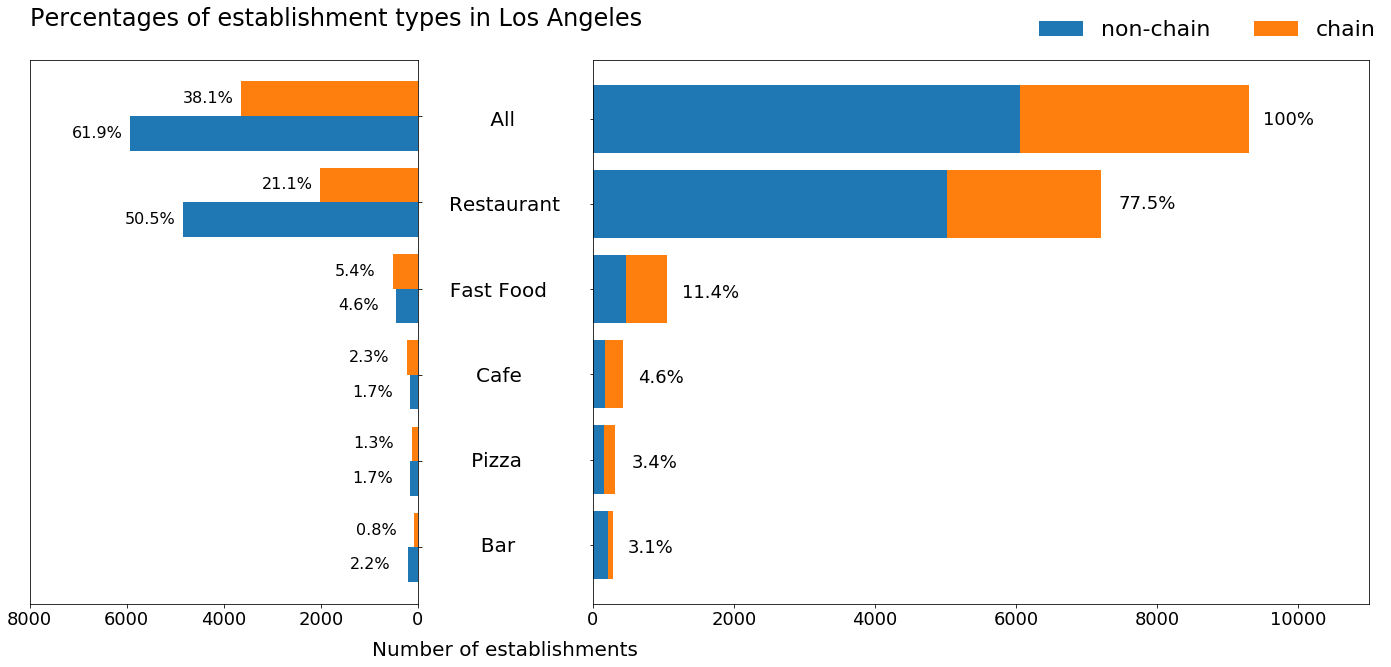

In [63]:
rest_cleaned_grp = rest_cleaned.groupby(by='object_type', observed=True).agg({'id':'count'})

type_chain_pivot = pd.pivot_table(index=['object_type'], columns=['chain'], 
                             aggfunc='size', data=rest, observed=True)
# display(type_chain_pivot)

type_chain_pivot['sum'] = type_chain_pivot.sum(axis = 1)
type_chain_pivot = type_chain_pivot.sort_values(by='sum')
type_chain_pivot = type_chain_pivot.append(type_chain_pivot.sum(),  ignore_index=True)

idx = pd.Index(['Bar', 'Pizza', 'Cafe', 'Fast Food', 
                'Restaurant', 'All'], name='object_type')

type_chain_pivot.set_index(idx, inplace=True)
# type_chain_pivot = type_chain_pivot.reset_index()

# display(type_chain_pivot)

fields = [False, True]
colors =  ['C0', 'C1']

labels = ["non-chain", "chain"]

# figure and axis
fig, ax = plt.subplots(1,2, figsize=(24, 10), gridspec_kw={'width_ratios': [1, 2]})
plt.subplots_adjust(wspace = 0.3)

type_chain_grp = (rest_cleaned
                  .groupby(by=['object_type', 'chain'], observed=True).agg({'id':'count'}))
idx_list = type_chain_grp.index.levels[0].to_list()

idx_list.append('All') 
type_chain_grp.index = type_chain_grp.index.set_levels(idx_list, level=0)



type_chain_grp.loc[('All', False), :] = 5934
type_chain_grp.loc[('All', True), :] = 3646

# display(type_chain_grp)

type_chain_grp = type_chain_grp.unstack().reindex(["Bar", "Pizza", "Cafe", 
                                                   "Fast Food", "Restaurant",
                                                   "All"])
type_chain_grp.plot(kind='barh', width=0.8, ax=ax[0])

ax[0].set_title('Percentages of establishment types in Los Angeles\n', 
                loc='left', fontsize=24)

ax[0].set_ylabel(' ', fontsize=18)
ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[0].axes.yaxis.set_ticklabels([])
ax[0].tick_params(axis ='both',labelsize = 18)


ax[0].set_xlim(0, 8000)


ax[0].invert_xaxis()

#ax[0].axes.xaxis.set_visible(False)
#ax[0].axes.yaxis.set_visible(False)
ax[0].legend().set_visible(False)


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax[0].patches:
    totals.append(i.get_width())
    
totals = sorted(totals, reverse=True)
# print(totals)
# set individual bar lables using above list
total = totals[0] + totals[2]

for i in ax[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[0].text(i.get_width()+1200, i.get_y()+.15, \
               str(round((i.get_width()/total)*100, 1))+'%', fontsize=16,color='black')

# plot bars
left = len(type_chain_pivot) * [0]
for idx, name in enumerate(fields):
    ax[1].barh(type_chain_pivot.index, type_chain_pivot[name], left = left, color=colors[idx])
    left = left + type_chain_pivot[name]
    
# title, legend, labels

percent_pivot = type_chain_pivot.loc[~type_chain_pivot.index.isin(['All'])] 
# display(percent_pivot)
percent_pivot = (percent_pivot / percent_pivot['sum'].sum() * 100).round(1)
    
    
ax[1].text(9500, 4.93, str(100) + "%", 
           fontsize=18, color='black')
ax[1].text(7450, 3.94, str(percent_pivot.loc["Restaurant", "sum"]) + "%", 
           fontsize=18, color='black')
ax[1].text(1270, 2.9, str(percent_pivot.loc["Fast Food", "sum"]) + "%", 
           fontsize=18, color='black')
ax[1].text(650, 1.9, str(percent_pivot.loc["Cafe", "sum"]) + "%", 
           fontsize=18, color='black')
ax[1].text(550, 0.9, str(percent_pivot.loc["Pizza", "sum"]) + "%", 
           fontsize=18, color='black')
ax[1].text(490, -0.1, str(percent_pivot.loc["Bar", "sum"]) + "%", 
           fontsize=18, color='black')

ax[1].legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False, fontsize=22)


ax[1].set_ylabel(' ', fontsize=22)
ax[1].set_yticks(["Bar", "Pizza", "Cafe", 
                  "Fast Food", "Restaurant", "All"])

ax[1].tick_params(axis ='both',labelsize = 18)
ax[1].set_yticklabels(["  Bar           ", "   Pizza          ",
                       "Cafe          ", "  Fast Food      ", "Restaurant    ",
                      ' All           '], ha='right', fontsize=20)
ax[1].set_xlim(0, 11000)
fig.text(0.4,0.06, "Number of establishments", ha="center", va="center", fontsize=20)

plt.savefig('fig_1.png')
plt.show()


From the plot, we can see that slightly more than 60% of the establishments in our dataset are not chains. In addition, restaurant establishments dominate the market with a share of 77.5%. Fast food establishments follows restaurants with a share of 11.4%, which are in turn followed by cafe establishments having a share of only 4.6%. Given the dominance of restaurants in the market, it is not surprising there are more restaurant establishments that are chains compared to the rest. But, to see better which types of establishments are chains, we next plot a stacked bar chart of the proportions of chain and non-chain establishments within each type of establishments.

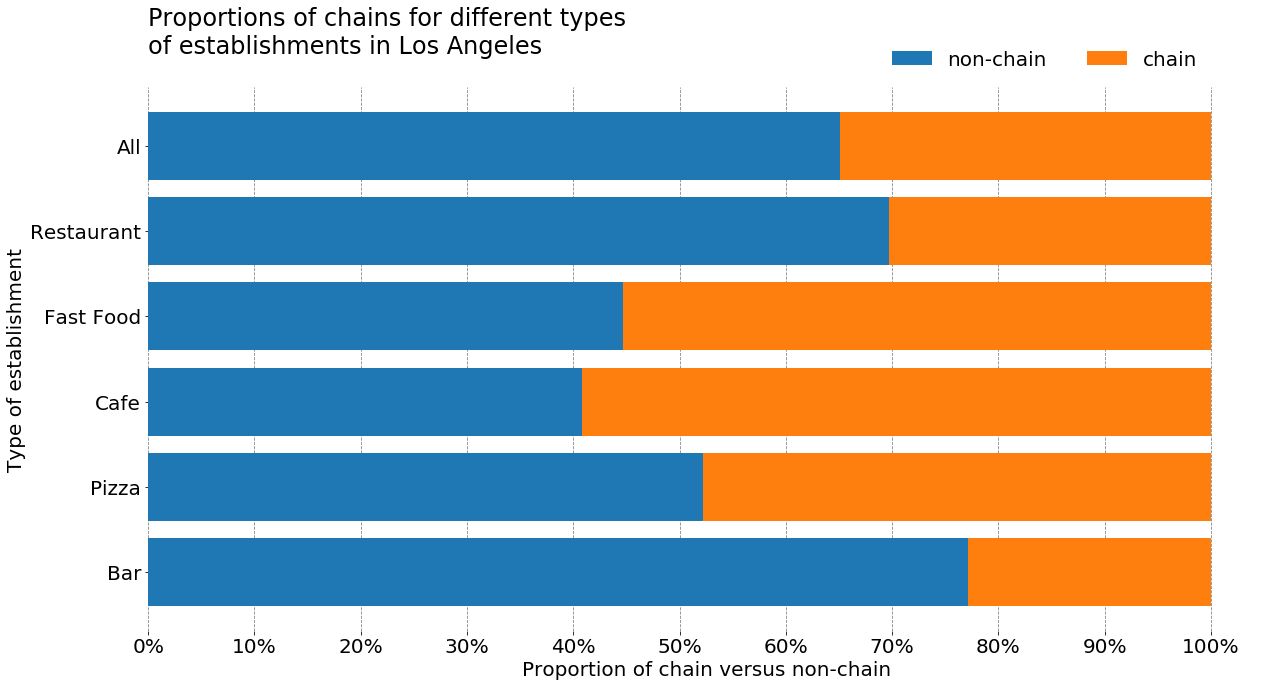

In [64]:
type_chain_pivot_2 = type_chain_pivot.div(type_chain_pivot['sum'], axis=0)

percent_pivot_2 = (type_chain_pivot_2*100).round(1)
# display(type_chain_pivot_2)

# variables
fields = [False, True]
colors =  ['C0', 'C1']
labels = ["non-chain", "chain"]

# figure and axis
plt.figure(figsize=(20,10))
# plot bars
left = len(type_chain_pivot_2) * [0]
for idx, name in enumerate(fields):
    plt.barh(type_chain_pivot_2.index, type_chain_pivot_2[name], 
             left = left,
             color=colors[idx])
    left = left + type_chain_pivot_2[name]
    
# title, legend, labels
plt.title('Proportions of chains for different types \nof establishments in Los Angeles\n', 
          loc='left', fontsize=24)
plt.xlabel('Proportion of chain versus non-chain', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Type of establishment', fontsize=20)
plt.yticks(fontsize=20)

# format x ticks
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)

    
ax = plt.gca()
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.legend(labels, bbox_to_anchor=([0.65, 1, 0, 0]), ncol=4, frameon=False, fontsize=20)

plt.savefig('fig_2.png')
plt.show()


Now we can clearly see that Cafe and Fast Food establishments are typically chains. Close to 60% of Cafe establishments and around 55% of Fast Food establishments are chains.

Let us now focus on the summary statistics of the number of seats for each type of restaurants. To visualize them, we show boxplots.

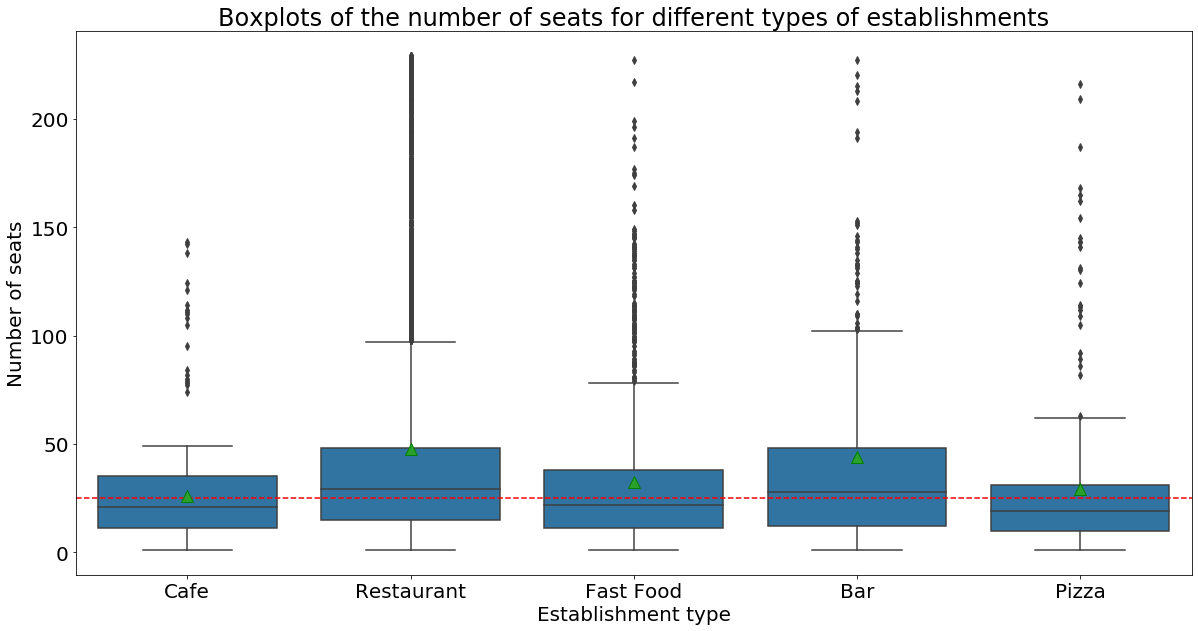

mean   50%
object_type                 
Bar          44.021429  28.0
Cafe         26.113757  21.0
Fast Food    32.483938  22.0
Pizza        29.000000  19.0
Restaurant   47.795892  29.0

In [65]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(x="object_type", y="number",
                 data=rest_cleaned,
                 showmeans=True,
                 meanprops={"markeredgecolor": "green",
                            "markersize": "12"},
                 palette=["C0"])

ax.set_title('Boxplots of the number of seats for different types of establishments',
             fontsize=24)
ax.set_xlabel('Establishment type', fontsize=20)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of seats', fontsize=20)
plt.yticks(fontsize=20)

ax.axhline(25, ls='--', c='red')

plt.savefig('fig_3.png')
plt.show()

display(rest_cleaned.groupby(by=['object_type'])['number'].describe().loc[:, ["mean", "50%"]])



We found that Cafe establishments have on average around 26 seats. Fast Food establishments have slightly more seats on average with a mean around 32. On the other hand Restaurant establishments average seat numbers is highest and close to 48 seats, so they have almost twice more seats than Cafes. Nevertheless, we also see that there are large outliers pulling the mean more than 10 seats higher than the median number of seats for all establishment types except for Cafes. The median number of seats for the latter is 21.

Let us also plot boxplots of the number of seats for each establishment type by adding the hue parameter to further categorize the establishments by their chain/non-chain property.

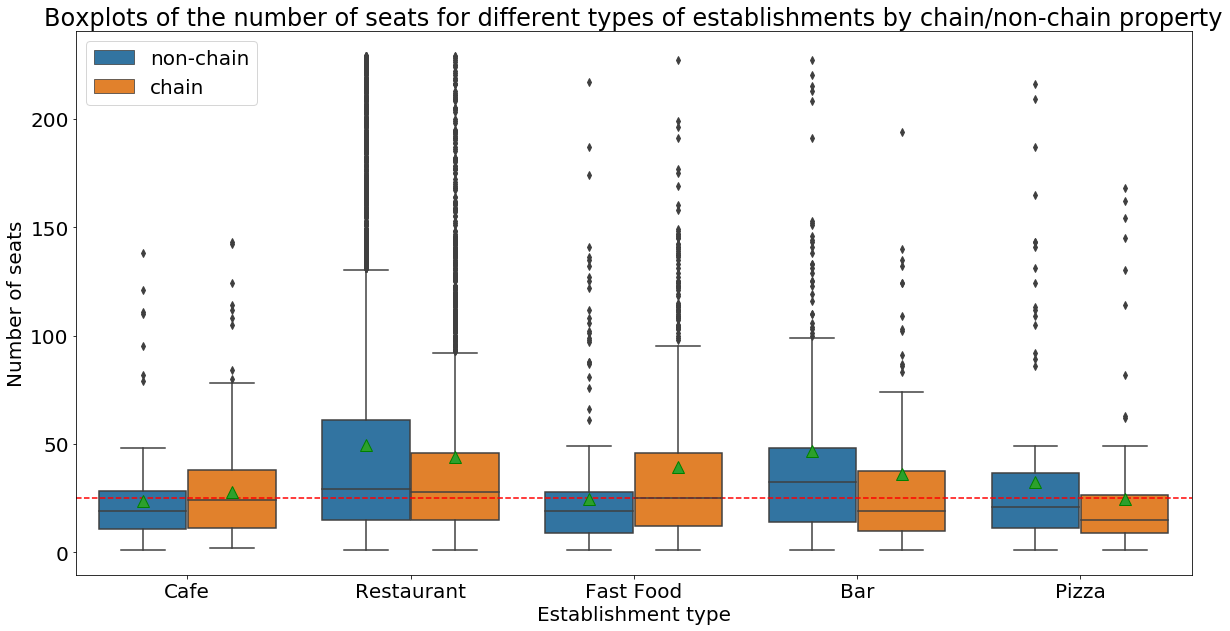

mean   50%
object_type chain                 
Bar         False  46.754808  32.5
            True   36.125000  19.0
Cafe        False  23.593750  19.0
            True   27.963303  24.0
Fast Food   False  24.343820  19.0
            True   39.450000  25.0
Pizza       False  32.395062  21.0
            True   24.669291  15.0
Restaurant  False  49.472119  29.0
            True   43.781899  28.0

In [66]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(x="object_type", y="number", hue="chain",
                 data=rest_cleaned, palette=["C0", "C1"],
                 showmeans=True,
                 meanprops={"markeredgecolor": "green",
                            "markersize": "12"})

ax.set_title('Boxplots of the number of seats for different types of establishments by chain/non-chain property',
             fontsize=24)
ax.set_xlabel('Establishment type', fontsize=20)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of seats', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.legend_.texts[0].set_text("non-chain")
ax.legend_.texts[1].set_text("chain")

ax.axhline(25, ls='--', c='red')

plt.savefig('fig_4.png')
plt.show()

display(rest_cleaned.groupby(by=['object_type', 'chain'])['number'].describe().loc[:, ["mean", "50%"]])



We see that the average number of seats for Cafe chains got slightly higher to about 28 seats, while for non-chain Cafes it dropped slightly to 25 seats. Similarly, the difference in the average number of seats for chain and non-chain Restaurant establishment is relatively small. For the remaining establishment types, on the other hand, the differences are more significant.

We continue our analysis with the study of chain establishments. For that purpose, we plot for each chain establishment a scatter plot showing the number of branches the chain has versus the number of seats that particular branch of the chain has. The plot is accompanied by a boxplot. Since there are two many chains, we omit the legend.

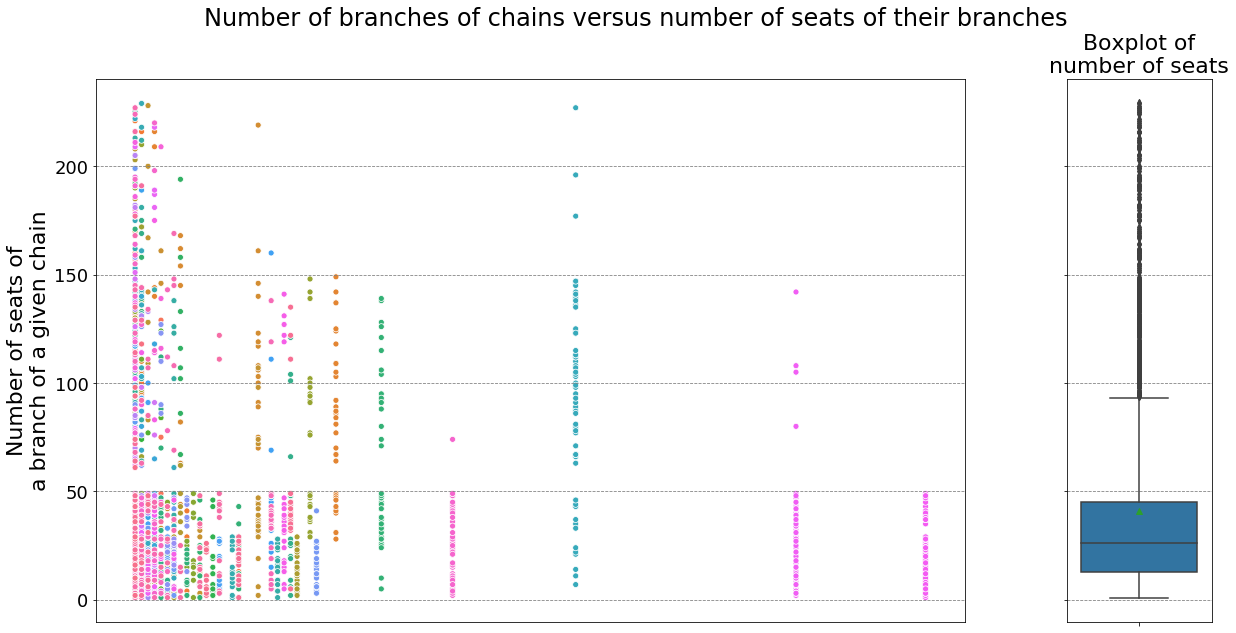

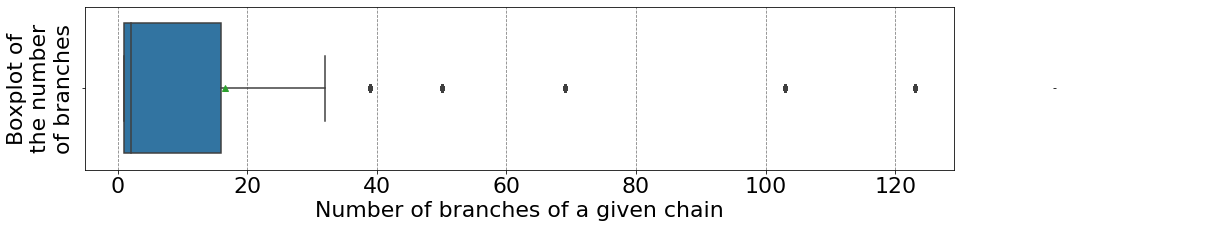

count    2959.000000
mean       40.848597
std        43.539038
min         1.000000
25%        13.000000
50%        26.000000
75%        45.000000
max       229.000000
Name: number, dtype: float64

count    2959.000000
mean       16.519432
std        31.318203
min         1.000000
25%         1.000000
50%         2.000000
75%        16.000000
max       123.000000
Name: count, dtype: float64

In [67]:
chain_rest = (rest_cleaned.loc[rest_cleaned['chain']==True]).copy()

grp_pivot = chain_rest.groupby(by=['object_name']).agg({'number':'count'}).reset_index()
grp_pivot = grp_pivot.rename(columns={'number':'count'})
# display(grp_pivot)


chain_rest = chain_rest.merge(grp_pivot, on='object_name')
chain_rest = chain_rest.sort_values(by='object_name')
# display(chain_rest.loc[chain_rest['count'] == 2])


fig, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True,
                       gridspec_kw={'width_ratios': [6, 1]})


sns.scatterplot(ax=ax[0], data=chain_rest, 
                x="count", y="number", hue='object_name', legend = False)

plt.suptitle('Number of branches of chains versus number of seats of their branches', 
             fontsize=24)
ax[0].set_ylabel('Number of seats of\na branch of a given chain', fontsize=22)
ax[0].set_xlabel('', fontsize=18)
ax[0].set_xticks([])
ax[0].tick_params(axis ='both',labelsize = 18)
ax[0].grid(color='gray', linestyle='dashed')

sns.boxplot(ax=ax[1], data=chain_rest, y="number", showmeans=True)
ax[1].set_title('Boxplot of\nnumber of seats', fontsize=22)
ax[1].set_ylabel('', fontsize=18)
ax[1].set_xlabel('', fontsize=18)
ax[1].yaxis.grid(color='gray', linestyle='dashed')

ax[0].tick_params(axis ='both',labelsize = 18)

plt.savefig('fig_5.png')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(20,3), sharey=True,
                       gridspec_kw={'width_ratios': [6, 1]})

sns.boxplot(ax=ax[0], data=chain_rest, x="count", showmeans=True)
ax[0].set_ylabel('Boxplot of\nthe number\nof branches', fontsize=22)
ax[0].set_xlabel('Number of branches of a given chain', fontsize=22)
ax[0].tick_params(axis ='both',labelsize = 22)
ax[0].xaxis.grid(color='gray', linestyle='dashed')

ax[1].set_xticks([100])
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

plt.savefig('fig_6.png')
plt.show()

display(chain_rest['number'].describe())

display(chain_rest['count'].describe())


We note that the seat numbers of different branches of some chains vary a lot. Nevertheless, with the help of the box plot, we can see better that the seat numbers of typical chains are less than 50 seats and the median is around 25 seats. Given the large number of outliers, we look here at the median instead of the mean value. Similarly, the number of branches of different chains vary a lot. However, only few chains have more then 40 branches, and many chains appear to have less than 20 branches. In fact, the median number of branches is just 2. 

Let us now focus only on Cafe chains. Below we generate the plots considering only those establishments. We also omit the legend.

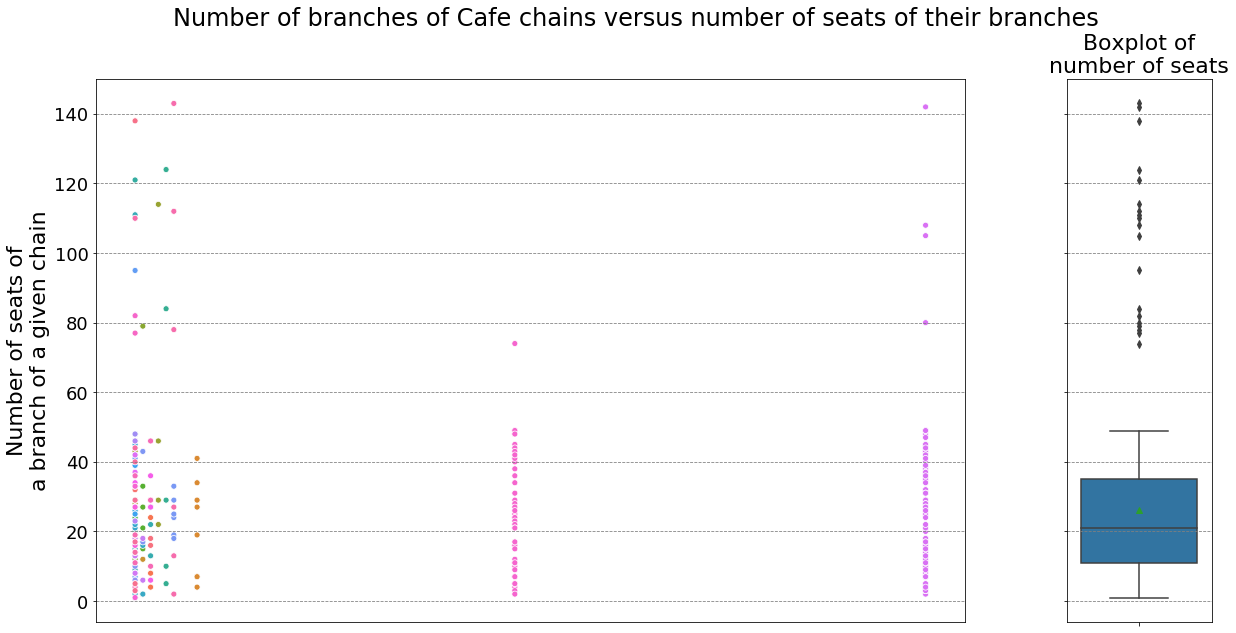

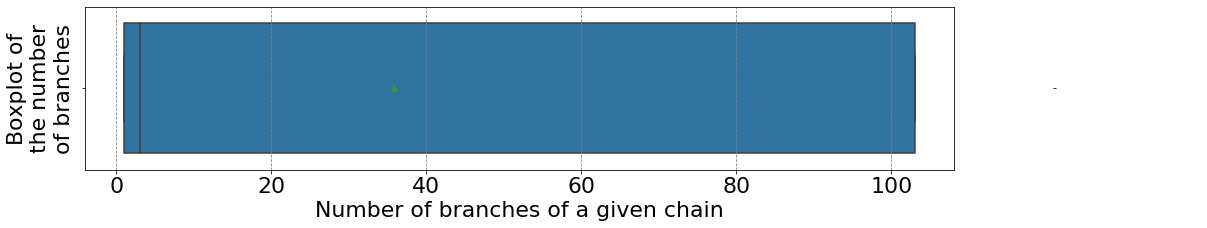

count    378.000000
mean      26.113757
std       22.742364
min        1.000000
25%       11.000000
50%       21.000000
75%       35.000000
max      143.000000
Name: number, dtype: float64

count    378.000000
mean      35.825397
std       44.132862
min        1.000000
25%        1.000000
50%        3.000000
75%      103.000000
max      103.000000
Name: count, dtype: float64

In [68]:
cafe_chains = rest_cleaned.loc[rest_cleaned['object_type'] == 'Cafe'].copy()

grp_pivot = cafe_chains.groupby(by=['object_name']).agg({'number':'count'}).reset_index()
grp_pivot = grp_pivot.rename(columns={'number':'count'})
# display(grp_pivot)


cafe_chains = cafe_chains.merge(grp_pivot, on='object_name')
cafe_chains = cafe_chains.sort_values(by='object_name')
# display(chain_rest.loc[chain_rest['count'] == 2])


fig, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True,
                       gridspec_kw={'width_ratios': [6, 1]})


sns.scatterplot(ax=ax[0], data=cafe_chains, 
                x="count", y="number", hue='object_name', legend = False)

plt.suptitle('Number of branches of Cafe chains versus number of seats of their branches', 
             fontsize=24)

ax[0].set_ylabel('Number of seats of\na branch of a given chain', fontsize=22)
ax[0].set_xlabel('', fontsize=18)
ax[0].set_xticks([])
ax[0].tick_params(axis ='both',labelsize = 18)
ax[0].grid(color='gray', linestyle='dashed')

sns.boxplot(ax=ax[1], data=cafe_chains, y="number", showmeans=True)
ax[1].set_title('Boxplot of\nnumber of seats', fontsize=22)
ax[1].set_ylabel('', fontsize=18)
ax[1].set_xlabel('', fontsize=18)
ax[1].yaxis.grid(color='gray', linestyle='dashed')

ax[0].tick_params(axis ='both',labelsize = 18)

plt.savefig('fig_7.png')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(20,3), sharey=True,
                       gridspec_kw={'width_ratios': [6, 1]})

sns.boxplot(ax=ax[0], data=cafe_chains, x="count", showmeans=True)
ax[0].set_ylabel('Boxplot of\nthe number\nof branches', fontsize=22)
ax[0].set_xlabel('Number of branches of a given chain', fontsize=22)
ax[0].tick_params(axis ='both',labelsize = 22)
ax[0].xaxis.grid(color='gray', linestyle='dashed')

ax[1].set_xticks([100])
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

plt.savefig('fig_8.png')
plt.show()

display(cafe_chains['number'].describe())

display(cafe_chains['count'].describe())


When we limit ourselves to Cafe chains, the seats numbers concentrated below 40 seats per branch, while the median number of seats fell from 25 to 20 seats. In addition, we can see from the plot that all but two Cafe chains have about less than 10 branches. The median for the number of branches is 3 for the Cafe chains in our data.

<a class="anchor" id="step2_2"></a> 
#### Trends in establishements by locations 

We now shift our focus on the locations of establishments. Let us identify the total number of streets and the number of streets that only have one establishment.

In [69]:
df_streets_all = rest_cleaned.groupby(by='address')['object_name'].count().sort_values(ascending=False).reset_index()
print('There are in total {} establishments.'.format(len(df_streets_all)))
print('There are {} streets with only one establishment.'.format((df_streets_all['object_name'] == 1).sum()))
      

There are in total 503 establishments.
There are 226 streets with only one establishment.


Although our data includes about 500 streets, slightly less than half contains data for only one establishment. We believe that street with only few establishments would not be attractive to open up an establishment such as a robot ron cafe. so, we identify next both those streets that have the highest number of establishments and those that have the highest number of Cafe establishments.

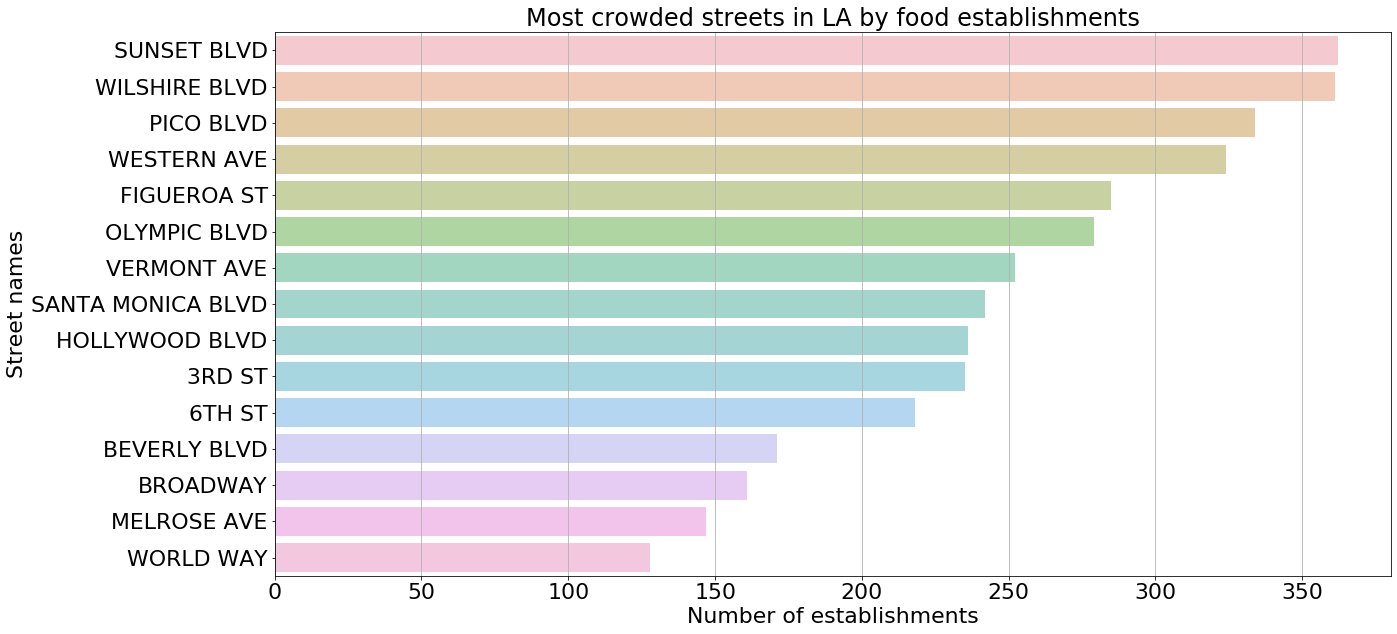

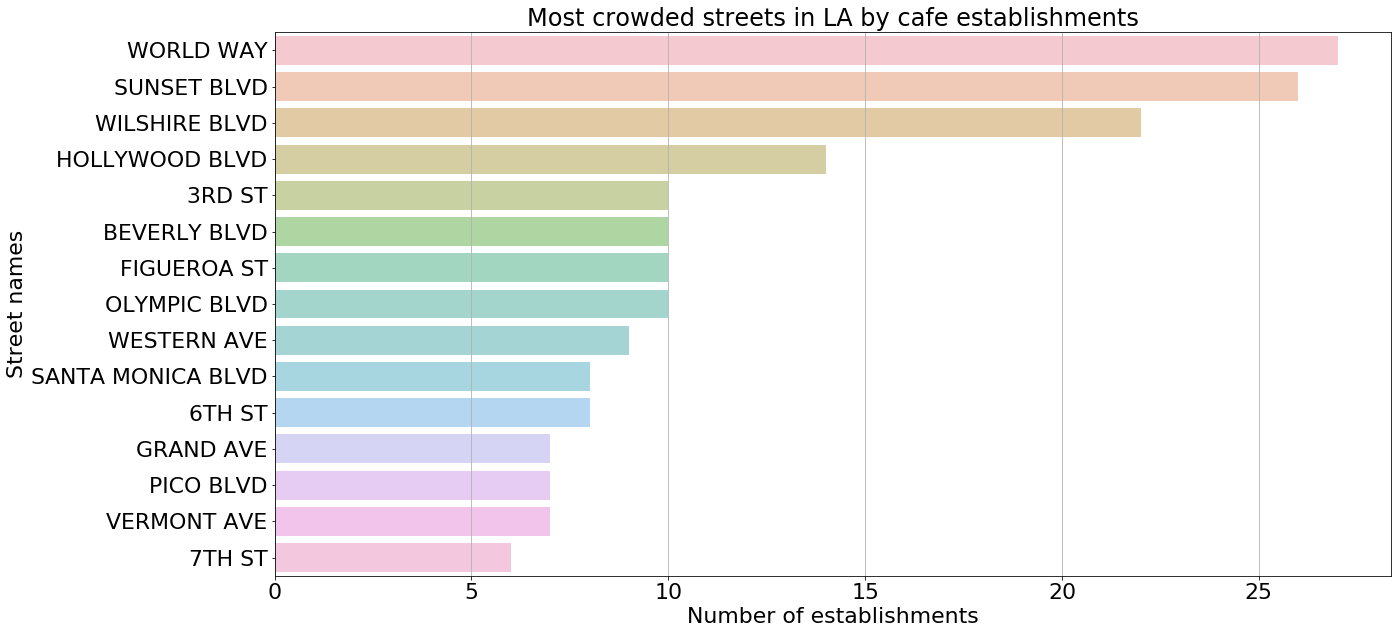

In [70]:
# display(df_streets_all)
df_streets_cafe = (rest_cleaned.loc[rest_cleaned['object_type'] == 'Cafe']
 .groupby(by='address')['object_name'].count().sort_values(ascending=False)).reset_index()

plt.figure(figsize=(20, 10))
sns.barplot(y='address', x='object_name', data=df_streets_all.head(15), alpha=0.5)
#sns.barplot(x='address', y='object_name', data=df_streets_cafe.head(11), alpha=0.5)

plt.title('Most crowded streets in LA by food establishments', fontsize= 24)
plt.xticks(fontsize= 22)
plt.yticks(fontsize= 22)
plt.ylabel('Street names', fontsize= 22)
plt.xlabel('Number of establishments', fontsize= 22)
plt.gca().xaxis.grid(True)

plt.savefig('fig_9.png')
plt.show()

plt.figure(figsize=(20, 10))
# sns.barplot(x='address', y='object_name', data=df_streets_all.head(11), alpha=0.5)
sns.barplot(y='address', x='object_name', data=df_streets_cafe.head(15), alpha=0.5)

plt.title('Most crowded streets in LA by cafe establishments', fontsize= 24)
plt.xticks(fontsize= 22)
plt.yticks(fontsize= 22)
plt.ylabel('Street names', fontsize= 22)
plt.xlabel('Number of establishments', fontsize= 22)
plt.gca().xaxis.grid(True)

plt.savefig('fig_10.png')
plt.show()


We found out that Sunset Boulevard and Whilshire Boulevard have the lead with more than 350 establishments. On the other hand, World Way and Sunset Boulevard have the lead with more than 25 cafe establishments. In addition, we observe that the identified streets have usually both the most non-cafe and cafe establishments. Nevertheless, some of these crowded streets might have relatively less cafe establishments. Those street would be attractive locations for our robot-run cafe. Therefore, we now look at the proportions of non-cafe and cafe establishments in the most crowded streets we have just identified.

non_cafe_counts  cafe_counts  sum
address                                             
SUNSET BLVD                    336           26  362
WILSHIRE BLVD                  339           22  361
PICO BLVD                      327            7  334
WESTERN AVE                    315            9  324
FIGUEROA ST                    275           10  285
OLYMPIC BLVD                   269           10  279
VERMONT AVE                    245            7  252
SANTA MONICA BLVD              234            8  242
HOLLYWOOD BLVD                 222           14  236
3RD ST                         225           10  235
6TH ST                         210            8  218
BEVERLY BLVD                   161           10  171
BROADWAY                       159            2  161
MELROSE AVE                    141            6  147
WORLD WAY                      101           27  128

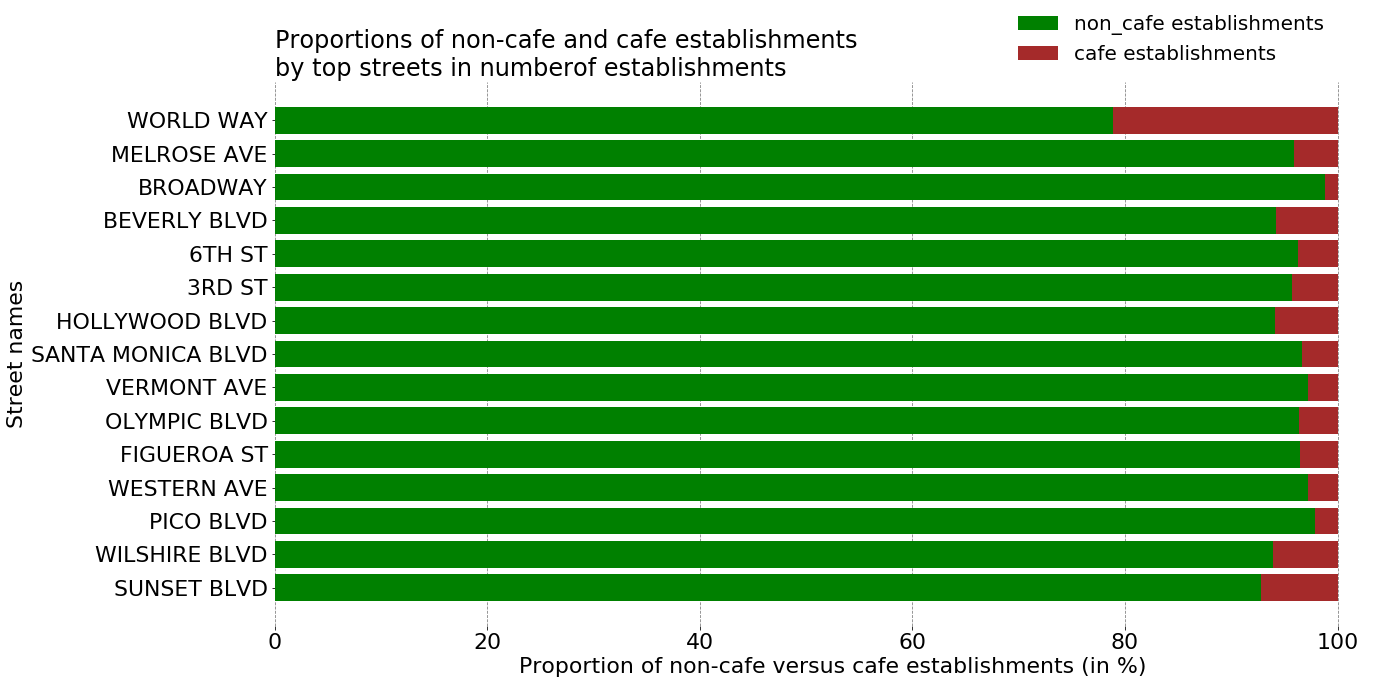

In [71]:
df_streets_noncafe = (rest_cleaned.loc[rest_cleaned['object_type'] != 'Cafe']
 .groupby(by='address')['object_name'].count().reset_index())
df_streets_noncafe =  df_streets_noncafe.rename({'object_name': 'non_cafe_counts'}, axis=1)

df_streets_cafe =  df_streets_cafe.rename({'object_name': 'cafe_counts'}, axis=1)
                      
df_streets = df_streets_noncafe.merge(df_streets_cafe, on='address')
df_streets['sum'] = df_streets.sum(axis=1)      
df_streets = df_streets.sort_values(by=['sum'], ascending=False)
df_streets = df_streets.set_index('address')
display(df_streets.head(15))

df_streets_2 = df_streets.div(df_streets['sum'], axis=0)

df_streets_2  = (df_streets_2 *100).round(1)


plt.figure(figsize=(20,10))
fields = ['non_cafe_counts', 'cafe_counts']
colors =  ['green', 'brown']

labels = ['non_cafe establishments', 'cafe establishments']
# plot bars

ax = plt.gca()

left = len(df_streets_2.head(15)) * [0]
for idx, name in enumerate(fields):
    ax.barh(df_streets_2.head(15).index, df_streets_2.head(15)[name], 
             left = left,
             color=colors[idx])
    left = left + df_streets_2.head(15)[name]
    

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.legend(labels, bbox_to_anchor=([0.65, 1, 0, 0]), ncol=1, frameon=False, fontsize=20)

# title, legend, labels
plt.title('Proportions of non-cafe and cafe establishments\nby top streets in number'
          'of establishments', 
          loc='left', fontsize=24)
plt.xlabel('Proportion of non-cafe versus cafe establishments (in %)', fontsize=22)
plt.xticks(fontsize=22)
plt.ylabel('Street names', fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('fig_11.png')
plt.show()



Indeed, we observe that Sunset Boulevard, Whilshire Bouleward, World Way, Beverly Boulevard, or Hollywood Boulevard are already quite packed with Cafes. On the other hand, streets like Broadway or Pico Boulevard have the least number of Cafes. 

Now, let us go back to the seat numbers and look at the distribution of the number of seats for the streets with a lot of restaurants. 

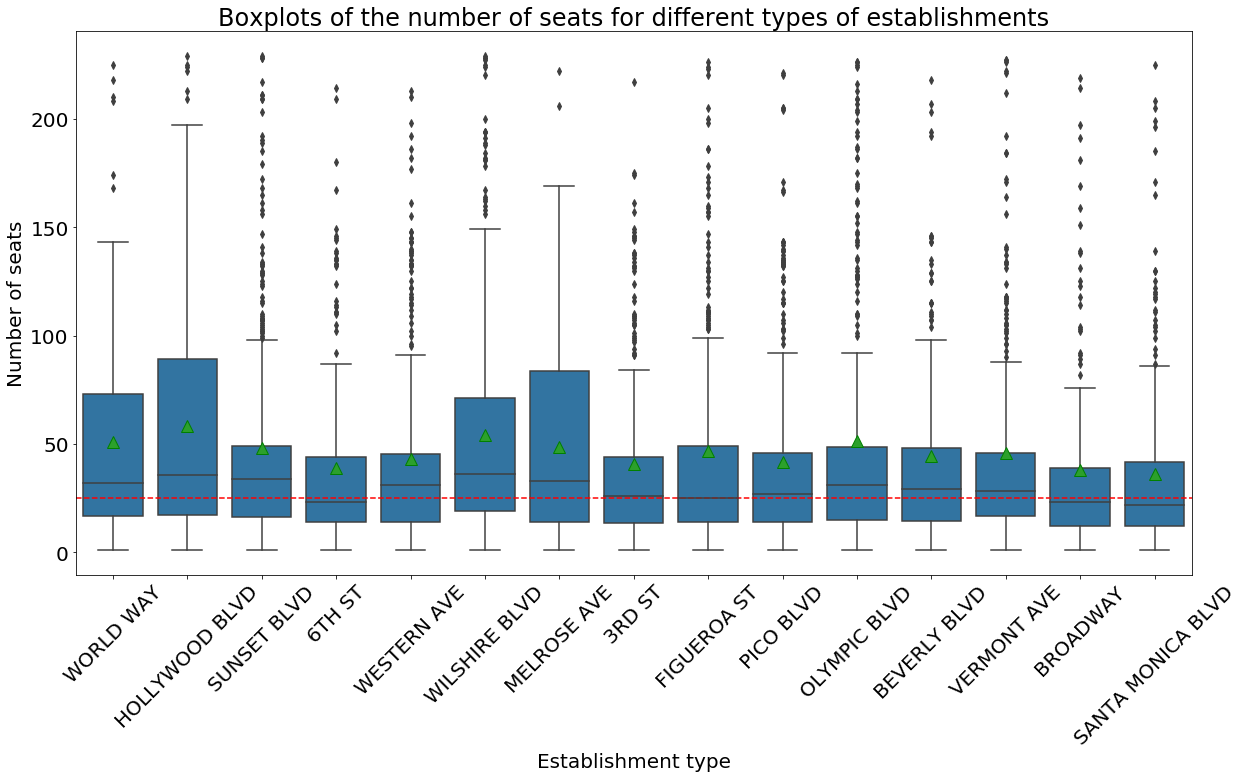

count    8776.000000
mean       44.438924
std        48.057372
min         1.000000
25%        14.000000
50%        27.000000
75%        46.000000
max       229.000000
Name: number, dtype: float64

In [72]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(y="number", x="address",
                 data=rest_cleaned.loc[rest_cleaned['address'].isin(df_streets.head(15).index.to_list())],
                 showmeans=True,
                 meanprops={"markeredgecolor": "green",
                            "markersize": "12"},
                 palette=["C0"])

ax.set_title('Boxplots of the number of seats for different types of establishments',
             fontsize=24)
ax.set_xlabel('Establishment type', fontsize=20)
plt.xticks(fontsize=20, rotation=45)
ax.set_ylabel('Number of seats', fontsize=20)
plt.yticks(fontsize=20)

ax.axhline(25, ls='--', c='red')

plt.savefig('fig_12.png')
plt.show()

display(rest_cleaned['number'].describe())




We can see that there are also a lot of variations and outliers in seat numbers of establishments in crowded streets. However, the median number of seats is close to 25 seats (red dashed line in the plot).   

**Concluding remarks:** In this step, we analysed in depth the restaurant data. We looked at the shares of the different types establishments, and for each type of establishment, we looked into the shares of chain and non-chain ones. We also studied trends in the locations of the establishments and identified the streets having the most number of restaurants. Along the way, we also paid special attention to Cafe establishments. In addition, we analysed how the number of seats are distributed for various subsets of the establishments.

<a class="anchor" id="step3"></a> 
### Step 3. Presentation of the results and overall conclusions

We prepared a presentation that aggregates the most important points that emerged from our market research. The slides can be accessed from the link below. 

Presentation: https://drive.google.com/file/d/1_MNwJkPUZS9FWOf_PeyxxMPJhWzz7-Do/view?usp=sharing

In this project, we investigated food establishment data from Los Angeles. The data had several issues, some of which should have been addressed during the collection of the data. Nevertheless, after extensive preprocessing, we analysed the data to help us decide if opening a robot-run cafe in Los Angeles has the potential of turning up to be a lucrative business. 

Our analysis revealed that more than 75% of the food establishments in LA are restaurants, while only about 5% are cafe establishments. More than 60% of the food establishments are non-chain establishments, yet the trend is reverse for cafe establishments. So the majority of Cafes in LA are branches of chains. 

We also found that despite many streets in LA have only one food establishemnt, a lot of the popular chains are located in streets where there are a lot of food establishments, especially restaurants. These streets turned out to have many cafes as well. However, we identified those that have a relatively smaller number of cafes. In particular, we identified Pico Boulevard, Broadway, and Western Avenue to fit our purpose specifically well. We believe they would be ideal to open up a robot-run cafe. Many people would come to these streets, so it would be easier to attract people, especially those looking for a cafe, since there would be relatively less competition. One point that should be further investigated is the distances between the selected streets in LA. This should be further explored to eliminate opening up the robot-run cafes too close to each other. 

Our analysis revealed that the number of seats of food establishments, despite showing a lot of variations (even among branches of a chain), remained below 50 when considering all food establishments and below 40 when considering cafe establishments. The median number of seats  on the other hand, is 25 when considering all establishments and 20 when considering only cafes. 

Finally, we identified that there is even a cafe chain that has up to about 100 branches, yet the median number of branches of cafes in LA are only 3. Since it would take time for our robot run cafe to become a huge chain, it would be reasonable to initially target 3 branches. Naturally the marginal cost of adding up branches should be considered in the decision process. But, this is out of the scope of our analysis. 

**Recommendations for the robot-run cafe:** We recommend to open up a first branch of our robot-run cafe in one of the following streets: Pico Boulevard, Broadway, and Western Avenue. We recommend to keep the number of seats in the range 20-40.  